In [1]:
from abc import ABC, abstractmethod
import gymnasium as gym
import random
import numpy as np
import torch
import torch.nn as nn
from collections import OrderedDict
import math
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy
import seaborn as sns
import pandas as pd

In [2]:
### MLP
class Multi_Layer_Perceptron(nn.Sequential):
    def __init__(self, input_dim, intern_dim, output_dim, depth = 2, isBiased = False):
        
        dict = OrderedDict([("input",nn.Linear(input_dim,intern_dim, bias=isBiased))])
        for i in range(depth):
            dict.update({str(i) : nn.Linear(intern_dim,intern_dim,bias=isBiased)})
        dict.update({"output" : nn.Linear(intern_dim,output_dim,bias=isBiased)})

        super().__init__(dict)

        self.reset_init_weights_biases(0) # so that we do not use a default initialization

    def reset_init_weights_biases(self, norm = -1):
        for layer in self.children():
            stdv = 1. / math.sqrt(layer.weight.size(1))
            if norm != -1 :
                stdv = norm
            layer.weight.data.uniform_(-stdv,stdv)
            if layer.bias is not None:
                layer.bias.data.uniform_(-stdv,stdv)

In [3]:
class Agent(ABC):

    @abstractmethod
    def observe(self, state, action, next_state, reward):
        pass

    @abstractmethod
    def select_action(self, state):
        pass
    
    @abstractmethod
    def update(self):
        pass

    def __init__(self, id, env):
        self.id = id
        self.env = env
                

In [16]:
class RandomAgent(Agent):
    def observe(self, state, action, next_state, reward):
        pass
        
    def select_action(self, state):
        return self.env.action_space.sample()
        
    def update(self):
        pass

    '''
    Test the agent on a seed (random or not) after the training
    '''  
    def play(self, episodes, seed = False, debug_mode=False):
        episodesHistory = np.zeros((episodes))
        
        for i in range(episodes):
            if(debug_mode) : print("Episode: "+str(i+1)+" starts")
                
            newSeed = random.randint(0,100000)
            if seed != False:
                newSeed = seed
                
            state,_ = self.env.reset(seed = newSeed)
            done = False
            episode_reward = 0
            
            while not done:
                                        
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)

                episode_reward += reward
                state = next_state
                done = terminated or truncated
                
            self.env.close()
            episodesHistory[i] = episode_reward
            if(debug_mode) : print("Episode "+str(i+1)+ " , Reward: "+str(episode_reward))
        return episodesHistory

In [47]:
class DQNAgent(Agent):

    def __init__(self, id, epsilonMax=1, epsilonMin = 0.05, reward_factor = 0.5, predList_batch_size = 200, env = gym.make('MountainCar-v0'), arrayNewPosReward = None, gamma = 0.99, replay_buffer_SIZE = 10000, batch_size = 64, observation_SIZE = 6):
        Agent.__init__(self,id,env)
        '''
        Definition of MLP for the Policy + the RND
        '''
        self.Q = Multi_Layer_Perceptron(input_dim = 2,intern_dim = 64, output_dim = 3, depth = 2, isBiased = False) # For the policy
        self.QTarget = Multi_Layer_Perceptron(input_dim = 2,intern_dim = 64, output_dim = 3, depth = 2, isBiased = False)
        self.Pred = Multi_Layer_Perceptron(input_dim = 2,intern_dim = 64, output_dim = 1, depth = 2, isBiased = False) # For the RND
        self.PredTarget = Multi_Layer_Perceptron(input_dim = 2,intern_dim = 64, output_dim = 1, depth = 2, isBiased = False)
        '''
        Definition of the hyperparameters for the training
        '''
        self.arrayNewPosReward = arrayNewPosReward # Heuristic Rewards
        self.reward_factor = reward_factor # For the RND
        self.gamma = gamma
        self.epsilon = epsilonMax
        self.epsilonMax = epsilonMax
        self.epsilonMin = epsilonMin
        '''
        Definition of the replay buffer
        '''
        self.replay_buffer_SIZE = replay_buffer_SIZE
        self.observation_SIZE = observation_SIZE
        self.replay_buffer = np.zeros((replay_buffer_SIZE,observation_SIZE))
        self.batch_size = batch_size
        '''
        Definition of the optimizer + loss function (there are 2 for the Q + RND)
        '''        
        self.optimizer = torch.optim.AdamW(self.Q.parameters())
        self.optimizer2 = torch.optim.AdamW(self.Pred.parameters())     
        self.LossFct = torch.nn.MSELoss()
        self.LossFct2 = torch.nn.MSELoss()
        '''
        Definition of parameters for the computing of the normalization (for the RND)
        '''        
        self.next_state_mean = 0
        self.next_state_std = 1
        self.RND_std = 1
        self.RND_mean = 0
        self.PredList = [] #History to compute the normalization
        self.predList_batch_size = predList_batch_size # batch size to compute the normalization
        '''
        Definition of extra informations
        '''   
        self.last_success_seed = 0 # To facilitate the test after training
        self.j = 0 # nb of steps already done
        
    def observe(self, state, action, next_state, reward):
        state = np.array(state)
        action = np.array([action])
        next_state = np.array(next_state)
        reward = np.array([reward])
        concatenatation = np.concatenate((state, action, next_state, reward))

        self.replay_buffer[self.j%self.replay_buffer_SIZE] = concatenatation
        
    '''
    Select actions with exploration (for the training)
    '''          
    def select_action(self, state):
        P = random.uniform(0,1)
        a=0
        if P <= 1-self.epsilon :
            arg = self.Q(torch.from_numpy(state).to(torch.float32)).max(axis = 0)[1].numpy()
            if arg.size == 1:
                a = arg
            else:
                a = np.random.choice(arg, size = 1)[0]
        else:
            a = random.randint(0,2)
        return a
    '''
    Select actions without exploration (for the tests)
    '''  
    def select_best_action(self, state):
        a = 0
        arg = self.Q(torch.from_numpy(state).to(torch.float32)).max(axis = 0)[1].numpy()
        if arg.size == 1:
            a = arg
        else:
            a = np.random.choice(arg, size = 1)[0]
        return a
    '''
    Update the Q network (j: nb of epochs)
    '''  
    def update(self):
        batchIndex = np.random.choice(min(self.j+1,self.replay_buffer.shape[0]), self.batch_size)
        batch = self.replay_buffer[batchIndex,:]
        target = torch.zeros((self.batch_size))
        input = torch.zeros((self.batch_size))

        A = torch.from_numpy(batch[:,3:5]).to(torch.float32)
        
        QMax = self.QTarget(A).max(axis = 1)[0].detach().numpy()
        target = torch.from_numpy(batch[:,5] + self.gamma*QMax).to(torch.float32)
        
        for i in range(A.shape[0]):
            if A[i,0] >= 0.5:
                target[i] = batch[i,5]
                 
        input = self.Q(torch.from_numpy(batch[:,:2]).to(torch.float32))[np.arange(batch.shape[0]),batch[:,2]]
        loss = self.LossFct(input, target)
        self.optimizer.zero_grad()  
        loss.backward()
        self.optimizer.step()
        
        if self.j%refreshQTarget == 0:
            self.QTarget.load_state_dict(self.Q.state_dict())

        grad = 0
        for layer in self.Q.children():
            grad += abs(layer.weight.grad).mean()
            
        return loss.item(), grad
    '''
    Update the predictor of RND (j: nb of epochs)
    '''          
    def update_Pred(self, next_state, firstUpdate):

        L = 0
        if self.j <= self.predList_batch_size:
            next_states = self.replay_buffer[:self.j+1,3:5]
            self.next_state_mean = np.mean(next_states, axis=0)
            next_state_mean_square = np.mean(next_states**2, axis=0)
            self.next_state_std = 2*(next_state_mean_square - self.next_state_mean**2)**(1/2)

        if self.j >= firstUpdate:
            next_state = (next_state - self.next_state_mean)/self.next_state_std
            
            target = self.PredTarget(torch.from_numpy(next_state).to(torch.float32))
            input = self.Pred(torch.from_numpy(next_state).to(torch.float32))
            loss = self.LossFct2(input, target)
            RND = loss.detach().numpy().item()
    
            if RND > 5: RND = 5
            if RND < -5: RND = -5
    
            self.optimizer2.zero_grad()
            
            loss.backward()
            self.optimizer2.step()
            
            if len(self.PredList) <= self.predList_batch_size:
                self.PredList.append(RND)
                self.RND_mean = sum(self.PredList) / float(len(self.PredList))
                RND_mean_square = sum([ x**2 for x in self.PredList ]) / float(len(self.PredList))
                self.RND_std = math.sqrt(RND_mean_square - self.RND_mean**2)
                
            if len(self.PredList) >= self.predList_batch_size:
                    
                RND = (RND - self.RND_mean)/self.RND_std
                
                if RND > 5: RND = 5
                if RND < -5: RND = -5
                    
            else: RND = 0
                
            L = loss.item()
        else: RND = 0
            
        return RND, L
    '''
    customReward: Heuristic or/and RND (uniqueReward: heuristic reward can be taken only one time during an episode)
    '''        
    def customReward(self, state, action, currentReward, next_state, firstUpdate):
        heurReward = 0
     
        if self.arrayNewPosReward.all() != None:
            for k in range(self.arrayNewPosReward.shape[0]):
                i = self.arrayNewPosReward[k,0]
                if (i <= next_state[0] and i +0.5 >=0) or (i >= next_state[0] and i +0.5 <=0):
                    if self.arrayNewPosReward[k,1] + 1 > heurReward:
                        heurReward = self.arrayNewPosReward[k,1] + 1
                        
        if self.reward_factor != 0: RND, loss_RND = self.update_Pred(next_state, firstUpdate)
        else: RND, loss_RND = 0,0
            
        return currentReward + heurReward + self.reward_factor*RND, loss_RND
    '''
    Test the agent on a seed (random or not) after the training
    '''  
    def play(self, seed = False):
        newSeed = random.randint(0,100000)
        
        if seed != False:
            newSeed = seed
            
        state,_ = self.env.reset(seed = newSeed)
        done = False
                    
        while done == False:
                                        
            action = self.select_best_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            state = next_state
            done = terminated or truncated
        self.env.close()
    '''
    All the training process   (refreshQTarget: to update QTarget (should be each epochs/actions) ;
                                firstUpdate: first step of update (to be sure to have enough data for the normalization and avoid big value)
                                epsilonDecreasing: how fast epsilon decrease during the training (exponentially) ;
                                debug_mode: print each step information ;
                                recap_mode: print each episode information ;
                                reset_init: to reset the training at 0 (norm of weight can be choosen by passing a float) ;
    '''  
    def train(self, episodes, refreshQTarget = 50000, firstUpdate = 0, epsilonDecreasing =100, debug_mode=False, recap_mode=False, reset_init = False):

        episodesHistory = np.zeros((episodes))
        rewardHistory = np.zeros((episodes*200))
        lossHistory = np.zeros((int(episodes*200)))
        lossRNDHistory = np.zeros((int(episodes*200)))
        gradHistory = np.zeros((int(episodes*200)))
        cumulativeHistory = np.zeros((episodes))
        
        if reset_init != False:
            self.Q.reset_init_weights_biases(reset_init)
            self.Pred.reset_init_weights_biases(reset_init)
            self.PredTarget.reset_init_weights_biases(reset_init)
            self.j=0
        self.QTarget.load_state_dict(self.Q.state_dict())
        self.replay_buffer = np.zeros((self.replay_buffer_SIZE, self.observation_SIZE))
        
        for e in tqdm(range(episodes)):
                
            if self.epsilon > self.epsilonMin:
                self.epsilon = self.epsilonMax*math.exp(-e/epsilonDecreasing)

            newSeed = random.randint(0,100000)
            state,_ = self.env.reset(seed = newSeed)
            done = False
            episode_reward = 0
            loss = 0
            grad = 0
            while done == False:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                reward, loss_RND = self.customReward(state, action, reward, next_state, firstUpdate)
                    
                self.observe(state,action,next_state,reward)

                if self.j >= firstUpdate: #Usefull for the RND case where we need some steps to do a good average approximation
                    loss,grad = self.update()

                state = next_state
                done = terminated or truncated

                episode_reward += reward
                rewardHistory[self.j] = reward
                lossHistory[self.j] = loss
                gradHistory[self.j] = grad
                lossRNDHistory[self.j] = loss_RND
                
                if terminated:
                    self.last_success_seed = newSeed
                    if debug_mode: print("Terminated")
                    if e > 0:
                        cumulativeHistory[e] = cumulativeHistory[e-1] +1
                    else:
                        cumulativeHistory[e] = 1
                else:
                    if e > 0:
                        cumulativeHistory[e] = cumulativeHistory[e-1]
                    else:
                        cumulativeHistory[e] = 0

                self.j+=1 # step done
                if debug_mode: print("Action "+str(self.j-1)+" selected: "+str(action)+" Reward: "+ str(reward))                     
            if recap_mode: print("Episode "+str(e+1)+ " , Reward: "+str(episode_reward)+" Epsilon: "+str(self.epsilon))
            episodesHistory[e] = episode_reward
            
        return episodesHistory, rewardHistory, lossHistory, gradHistory, cumulativeHistory, lossRNDHistory, self.Q.state_dict()

In [29]:
random_Agent = RandomAgent("idTest", env=gym.make('MountainCar-v0', render_mode='human'))
episodesHistory = random_Agent.play(episodes = 1,seed = False)

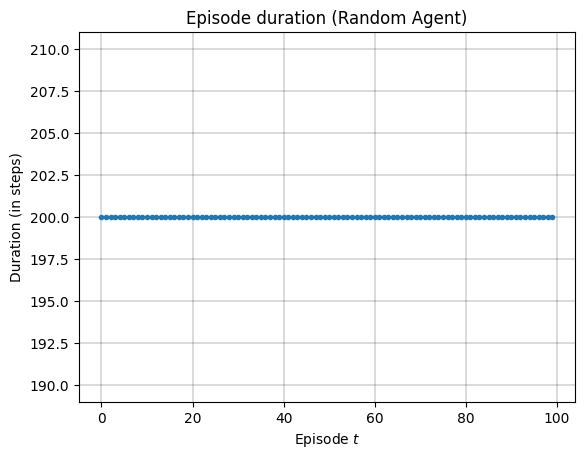

In [24]:
random_Agent.env=gym.make('MountainCar-v0')
episodesHistory = random_Agent.play(episodes = 100,seed = False)

fig1,ax1 = plt.subplots(1,1)
ax1.plot(range(episodesHistory.shape[0]), np.abs(episodesHistory), marker='.')
ax1.set_title(f'Episode duration (Random Agent)')
ax1.set_xlabel(r'Episode $t$')
ax1.set_ylabel('Duration (in steps)')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/EpDurationRA_ep{episodesHistory.shape[0]}.png', format='png')
    

In [41]:
episodes = 1000
batch_size = 64
refreshQTarget = 50000
reset_init = 1
replay_buffer_SIZE = 10000
epsilonDecreasing = 100
reward_factor = 0
predList_batch_size = 0
firstUpdate = 0
NewPosReward = np.array([None])

DQN = DQNAgent("id0",epsilonMax = 1, predList_batch_size = predList_batch_size, reward_factor = reward_factor, batch_size = batch_size, arrayNewPosReward = NewPosReward, replay_buffer_SIZE = replay_buffer_SIZE)
episodesHistory, _, lossHistory, _,_,_,_ = DQN.train(episodes, refreshQTarget = refreshQTarget, firstUpdate = firstUpdate, recap_mode=False, reset_init = reset_init, epsilonDecreasing =epsilonDecreasing)

fig1,ax1 = plt.subplots(1,1)
ax1.plot(range(episodesHistory.shape[0]), episodesHistory, marker='.')
ax1.set_title(f'Cumulative reward DQN basic reward')
ax1.set_xlabel(r'Episode $t$')
ax1.set_ylabel('Cumulative reward')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardDQNbasicR_ep{episodes}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

fig3,ax3 = plt.subplots(1,1)
ax3.plot(range(lossHistory.shape[0]), lossHistory, marker='.')
ax3.set_title(f'Loss DQN basic reward')
ax3.set_xlabel(r'Step $t$')
ax3.set_ylabel(r'$Loss$')
ax3.set_xscale('linear')
ax3.set_yscale('log')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/LossDQNbasicR_ep{episodes}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')


TypeError: __init__() got an unexpected keyword argument 'PredList_batch'

  0%|          | 0/400 [00:00<?, ?it/s]

Action 0 selected: 0 Reward: -1.0
Action 1 selected: 2 Reward: -1.0
Action 2 selected: 0 Reward: -1.0
Action 3 selected: 0 Reward: -1.0
Action 4 selected: 0 Reward: -1.0
Action 5 selected: 1 Reward: -1.0
Action 6 selected: 2 Reward: -1.0
Action 7 selected: 1 Reward: -1.0
Action 8 selected: 0 Reward: -1.0
Action 9 selected: 1 Reward: -1.0
Action 10 selected: 1 Reward: -1.0
Action 11 selected: 1 Reward: -1.0
Action 12 selected: 2 Reward: -1.0
Action 13 selected: 2 Reward: -1.0
Action 14 selected: 2 Reward: -1.0
Action 15 selected: 0 Reward: -1.0
Action 16 selected: 0 Reward: -1.0
Action 17 selected: 0 Reward: -1.0
Action 18 selected: 2 Reward: -1.0
Action 19 selected: 0 Reward: -1.0
Action 20 selected: 2 Reward: -1.0
Action 21 selected: 0 Reward: -1.0
Action 22 selected: 0 Reward: -1.0
Action 23 selected: 1 Reward: -1.0
Action 24 selected: 0 Reward: -1.0
Action 25 selected: 0 Reward: 0.10000000000000009
Action 26 selected: 1 Reward: 0.10000000000000009
Action 27 selected: 2 Reward: 0.100

  0%|          | 1/400 [00:00<03:18,  2.01it/s]

Action 170 selected: 1 Reward: -1.0
Action 171 selected: 2 Reward: -1.0
Action 172 selected: 0 Reward: 0.10000000000000009
Action 173 selected: 2 Reward: 0.10000000000000009
Action 174 selected: 0 Reward: 0.10000000000000009
Action 175 selected: 2 Reward: 0.10000000000000009
Action 176 selected: 1 Reward: 0.10000000000000009
Action 177 selected: 2 Reward: 0.10000000000000009
Action 178 selected: 2 Reward: 0.10000000000000009
Action 179 selected: 1 Reward: -1.0
Action 180 selected: 2 Reward: -1.0
Action 181 selected: 0 Reward: -1.0
Action 182 selected: 2 Reward: -1.0
Action 183 selected: 2 Reward: -1.0
Action 184 selected: 1 Reward: -1.0
Action 185 selected: 1 Reward: -1.0
Action 186 selected: 1 Reward: -1.0
Action 187 selected: 2 Reward: -1.0
Action 188 selected: 1 Reward: -1.0
Action 189 selected: 2 Reward: -1.0
Action 190 selected: 0 Reward: -1.0
Action 191 selected: 2 Reward: -1.0
Action 192 selected: 2 Reward: -1.0
Action 193 selected: 2 Reward: -1.0
Action 194 selected: 1 Reward: 

  0%|          | 2/400 [00:00<03:09,  2.10it/s]

Action 350 selected: 0 Reward: -1.0
Action 351 selected: 1 Reward: 0.10000000000000009
Action 352 selected: 0 Reward: 0.10000000000000009
Action 353 selected: 0 Reward: 0.10000000000000009
Action 354 selected: 1 Reward: 0.10000000000000009
Action 355 selected: 1 Reward: 0.10000000000000009
Action 356 selected: 1 Reward: 0.10000000000000009
Action 357 selected: 0 Reward: 0.10000000000000009
Action 358 selected: 2 Reward: 0.10000000000000009
Action 359 selected: 1 Reward: 0.10000000000000009
Action 360 selected: 0 Reward: 0.10000000000000009
Action 361 selected: 2 Reward: 0.10000000000000009
Action 362 selected: 0 Reward: 0.10000000000000009
Action 363 selected: 1 Reward: 0.10000000000000009
Action 364 selected: 2 Reward: 0.10000000000000009
Action 365 selected: 2 Reward: 0.10000000000000009
Action 366 selected: 2 Reward: 0.10000000000000009
Action 367 selected: 0 Reward: 0.10000000000000009
Action 368 selected: 2 Reward: 0.10000000000000009
Action 369 selected: 0 Reward: 0.1000000000000

  1%|          | 3/400 [00:01<03:11,  2.08it/s]

Action 524 selected: 1 Reward: -1.0
Action 525 selected: 0 Reward: -1.0
Action 526 selected: 0 Reward: -1.0
Action 527 selected: 2 Reward: -1.0
Action 528 selected: 1 Reward: -1.0
Action 529 selected: 0 Reward: -1.0
Action 530 selected: 2 Reward: -1.0
Action 531 selected: 0 Reward: -1.0
Action 532 selected: 0 Reward: -1.0
Action 533 selected: 1 Reward: -1.0
Action 534 selected: 1 Reward: -1.0
Action 535 selected: 1 Reward: 0.10000000000000009
Action 536 selected: 1 Reward: 0.10000000000000009
Action 537 selected: 0 Reward: 0.10000000000000009
Action 538 selected: 2 Reward: 0.10000000000000009
Action 539 selected: 1 Reward: 0.10000000000000009
Action 540 selected: 1 Reward: 0.10000000000000009
Action 541 selected: 0 Reward: -1.0
Action 542 selected: 0 Reward: -1.0
Action 543 selected: 0 Reward: -1.0
Action 544 selected: 2 Reward: -1.0
Action 545 selected: 2 Reward: -1.0
Action 546 selected: 0 Reward: -1.0
Action 547 selected: 0 Reward: -1.0
Action 548 selected: 0 Reward: -1.0
Action 549

  1%|          | 4/400 [00:01<03:08,  2.10it/s]

Action 778 selected: 0 Reward: -1.0
Action 779 selected: 2 Reward: -1.0
Action 780 selected: 1 Reward: -1.0
Action 781 selected: 1 Reward: -1.0
Action 782 selected: 2 Reward: -1.0
Action 783 selected: 0 Reward: -1.0
Action 784 selected: 1 Reward: -1.0
Action 785 selected: 1 Reward: -1.0
Action 786 selected: 1 Reward: -1.0
Action 787 selected: 0 Reward: -1.0
Action 788 selected: 0 Reward: -1.0
Action 789 selected: 0 Reward: -1.0
Action 790 selected: 0 Reward: -1.0
Action 791 selected: 1 Reward: -1.0
Action 792 selected: 0 Reward: -1.0
Action 793 selected: 0 Reward: -1.0
Action 794 selected: 0 Reward: -1.0
Action 795 selected: 0 Reward: -1.0
Action 796 selected: 1 Reward: 0.10000000000000009
Action 797 selected: 0 Reward: 0.10000000000000009
Action 798 selected: 2 Reward: 0.10000000000000009
Action 799 selected: 0 Reward: 0.10000000000000009
Episode 4 , Reward: -195.60000000000002 Epsilon: 0.9704455335485082
Action 800 selected: 1 Reward: -1.0
Action 801 selected: 0 Reward: -1.0
Action 8

  1%|▏         | 5/400 [00:02<03:06,  2.12it/s]

Action 957 selected: 2 Reward: -1.0
Action 958 selected: 1 Reward: -1.0
Action 959 selected: 2 Reward: -1.0
Action 960 selected: 2 Reward: -1.0
Action 961 selected: 0 Reward: -1.0
Action 962 selected: 2 Reward: -1.0
Action 963 selected: 1 Reward: -1.0
Action 964 selected: 2 Reward: 0.10000000000000009
Action 965 selected: 1 Reward: 0.10000000000000009
Action 966 selected: 1 Reward: 0.10000000000000009
Action 967 selected: 2 Reward: 0.10000000000000009
Action 968 selected: 2 Reward: 0.10000000000000009
Action 969 selected: 2 Reward: 0.1499999999999999
Action 970 selected: 1 Reward: 0.1499999999999999
Action 971 selected: 0 Reward: 0.1499999999999999
Action 972 selected: 0 Reward: 0.1499999999999999
Action 973 selected: 2 Reward: 0.1499999999999999
Action 974 selected: 2 Reward: 0.1499999999999999
Action 975 selected: 0 Reward: 0.1499999999999999
Action 976 selected: 2 Reward: 0.1499999999999999
Action 977 selected: 2 Reward: 0.1499999999999999
Action 978 selected: 2 Reward: 0.1499999999

  2%|▏         | 6/400 [00:02<03:07,  2.10it/s]

Action 1137 selected: 1 Reward: -1.0
Action 1138 selected: 0 Reward: -1.0
Action 1139 selected: 0 Reward: -1.0
Action 1140 selected: 1 Reward: -1.0
Action 1141 selected: 2 Reward: -1.0
Action 1142 selected: 2 Reward: 0.10000000000000009
Action 1143 selected: 0 Reward: 0.10000000000000009
Action 1144 selected: 2 Reward: 0.10000000000000009
Action 1145 selected: 0 Reward: 0.10000000000000009
Action 1146 selected: 0 Reward: 0.10000000000000009
Action 1147 selected: 1 Reward: 0.10000000000000009
Action 1148 selected: 0 Reward: 0.10000000000000009
Action 1149 selected: 2 Reward: 0.10000000000000009
Action 1150 selected: 2 Reward: 0.10000000000000009
Action 1151 selected: 2 Reward: 0.10000000000000009
Action 1152 selected: 1 Reward: 0.10000000000000009
Action 1153 selected: 0 Reward: 0.10000000000000009
Action 1154 selected: 0 Reward: 0.10000000000000009
Action 1155 selected: 0 Reward: 0.10000000000000009
Action 1156 selected: 2 Reward: 0.10000000000000009
Action 1157 selected: 2 Reward: 0.1

  2%|▏         | 7/400 [00:03<03:10,  2.07it/s]

Action 1394 selected: 0 Reward: -1.0
Action 1395 selected: 2 Reward: -1.0
Action 1396 selected: 1 Reward: -1.0
Action 1397 selected: 0 Reward: -1.0
Action 1398 selected: 0 Reward: -1.0
Action 1399 selected: 1 Reward: -1.0
Episode 7 , Reward: -160.40000000000003 Epsilon: 0.9417645335842487
Action 1400 selected: 0 Reward: -1.0
Action 1401 selected: 2 Reward: -1.0
Action 1402 selected: 2 Reward: -1.0
Action 1403 selected: 2 Reward: -1.0
Action 1404 selected: 0 Reward: -1.0
Action 1405 selected: 0 Reward: -1.0
Action 1406 selected: 1 Reward: -1.0
Action 1407 selected: 1 Reward: -1.0
Action 1408 selected: 2 Reward: -1.0
Action 1409 selected: 2 Reward: -1.0
Action 1410 selected: 1 Reward: -1.0
Action 1411 selected: 0 Reward: -1.0
Action 1412 selected: 2 Reward: -1.0
Action 1413 selected: 1 Reward: -1.0
Action 1414 selected: 1 Reward: -1.0
Action 1415 selected: 1 Reward: -1.0
Action 1416 selected: 0 Reward: -1.0
Action 1417 selected: 0 Reward: -1.0
Action 1418 selected: 0 Reward: -1.0
Action 

  2%|▏         | 8/400 [00:03<03:13,  2.03it/s]

Action 1568 selected: 1 Reward: 0.10000000000000009
Action 1569 selected: 1 Reward: 0.10000000000000009
Action 1570 selected: 2 Reward: 0.10000000000000009
Action 1571 selected: 0 Reward: 0.10000000000000009
Action 1572 selected: 2 Reward: 0.10000000000000009
Action 1573 selected: 0 Reward: 0.10000000000000009
Action 1574 selected: 0 Reward: 0.10000000000000009
Action 1575 selected: 1 Reward: 0.10000000000000009
Action 1576 selected: 2 Reward: -1.0
Action 1577 selected: 2 Reward: -1.0
Action 1578 selected: 0 Reward: -1.0
Action 1579 selected: 1 Reward: -1.0
Action 1580 selected: 2 Reward: -1.0
Action 1581 selected: 2 Reward: -1.0
Action 1582 selected: 0 Reward: -1.0
Action 1583 selected: 2 Reward: -1.0
Action 1584 selected: 1 Reward: -1.0
Action 1585 selected: 0 Reward: -1.0
Action 1586 selected: 1 Reward: -1.0
Action 1587 selected: 1 Reward: -1.0
Action 1588 selected: 1 Reward: -1.0
Action 1589 selected: 2 Reward: -1.0
Action 1590 selected: 0 Reward: -1.0
Action 1591 selected: 0 Rewar

  2%|▏         | 9/400 [00:04<03:11,  2.04it/s]

Action 1733 selected: 2 Reward: -1.0
Action 1734 selected: 0 Reward: -1.0
Action 1735 selected: 2 Reward: -1.0
Action 1736 selected: 1 Reward: -1.0
Action 1737 selected: 1 Reward: -1.0
Action 1738 selected: 1 Reward: -1.0
Action 1739 selected: 0 Reward: -1.0
Action 1740 selected: 2 Reward: -1.0
Action 1741 selected: 1 Reward: -1.0
Action 1742 selected: 2 Reward: -1.0
Action 1743 selected: 1 Reward: -1.0
Action 1744 selected: 0 Reward: -1.0
Action 1745 selected: 0 Reward: -1.0
Action 1746 selected: 1 Reward: -1.0
Action 1747 selected: 2 Reward: -1.0
Action 1748 selected: 2 Reward: -1.0
Action 1749 selected: 2 Reward: -1.0
Action 1750 selected: 0 Reward: -1.0
Action 1751 selected: 1 Reward: -1.0
Action 1752 selected: 1 Reward: -1.0
Action 1753 selected: 2 Reward: -1.0
Action 1754 selected: 2 Reward: -1.0
Action 1755 selected: 2 Reward: -1.0
Action 1756 selected: 0 Reward: -1.0
Action 1757 selected: 0 Reward: -1.0
Action 1758 selected: 1 Reward: -1.0
Action 1759 selected: 2 Reward: -1.0
A

  2%|▎         | 10/400 [00:04<03:08,  2.06it/s]

Action 1913 selected: 1 Reward: -1.0
Action 1914 selected: 0 Reward: -1.0
Action 1915 selected: 2 Reward: -1.0
Action 1916 selected: 1 Reward: -1.0
Action 1917 selected: 2 Reward: -1.0
Action 1918 selected: 2 Reward: -1.0
Action 1919 selected: 1 Reward: -1.0
Action 1920 selected: 0 Reward: -1.0
Action 1921 selected: 1 Reward: -1.0
Action 1922 selected: 1 Reward: -1.0
Action 1923 selected: 2 Reward: -1.0
Action 1924 selected: 2 Reward: -1.0
Action 1925 selected: 0 Reward: -1.0
Action 1926 selected: 2 Reward: -1.0
Action 1927 selected: 1 Reward: -1.0
Action 1928 selected: 0 Reward: -1.0
Action 1929 selected: 1 Reward: -1.0
Action 1930 selected: 2 Reward: -1.0
Action 1931 selected: 0 Reward: -1.0
Action 1932 selected: 0 Reward: -1.0
Action 1933 selected: 1 Reward: -1.0
Action 1934 selected: 0 Reward: -1.0
Action 1935 selected: 2 Reward: -1.0
Action 1936 selected: 1 Reward: -1.0
Action 1937 selected: 0 Reward: -1.0
Action 1938 selected: 2 Reward: -1.0
Action 1939 selected: 0 Reward: -1.0
A

  3%|▎         | 11/400 [00:05<03:08,  2.07it/s]

Action 2173 selected: 0 Reward: 0.10000000000000009
Action 2174 selected: 1 Reward: 0.10000000000000009
Action 2175 selected: 2 Reward: 0.10000000000000009
Action 2176 selected: 2 Reward: 0.10000000000000009
Action 2177 selected: 2 Reward: 0.10000000000000009
Action 2178 selected: 1 Reward: 0.10000000000000009
Action 2179 selected: 2 Reward: 0.10000000000000009
Action 2180 selected: 0 Reward: -1.0
Action 2181 selected: 0 Reward: -1.0
Action 2182 selected: 2 Reward: -1.0
Action 2183 selected: 0 Reward: -1.0
Action 2184 selected: 2 Reward: -1.0
Action 2185 selected: 0 Reward: -1.0
Action 2186 selected: 2 Reward: -1.0
Action 2187 selected: 2 Reward: -1.0
Action 2188 selected: 0 Reward: -1.0
Action 2189 selected: 1 Reward: -1.0
Action 2190 selected: 0 Reward: -1.0
Action 2191 selected: 0 Reward: -1.0
Action 2192 selected: 2 Reward: -1.0
Action 2193 selected: 0 Reward: -1.0
Action 2194 selected: 1 Reward: -1.0
Action 2195 selected: 2 Reward: -1.0
Action 2196 selected: 2 Reward: -1.0
Action 

  3%|▎         | 12/400 [00:05<03:09,  2.05it/s]

Action 2346 selected: 2 Reward: 0.10000000000000009
Action 2347 selected: 0 Reward: 0.10000000000000009
Action 2348 selected: 0 Reward: 0.10000000000000009
Action 2349 selected: 1 Reward: 0.10000000000000009
Action 2350 selected: 2 Reward: 0.10000000000000009
Action 2351 selected: 2 Reward: 0.10000000000000009
Action 2352 selected: 2 Reward: 0.10000000000000009
Action 2353 selected: 0 Reward: 0.10000000000000009
Action 2354 selected: 1 Reward: -1.0
Action 2355 selected: 0 Reward: -1.0
Action 2356 selected: 1 Reward: -1.0
Action 2357 selected: 2 Reward: -1.0
Action 2358 selected: 2 Reward: -1.0
Action 2359 selected: 0 Reward: -1.0
Action 2360 selected: 2 Reward: -1.0
Action 2361 selected: 2 Reward: -1.0
Action 2362 selected: 0 Reward: -1.0
Action 2363 selected: 0 Reward: -1.0
Action 2364 selected: 2 Reward: -1.0
Action 2365 selected: 1 Reward: -1.0
Action 2366 selected: 0 Reward: -1.0
Action 2367 selected: 0 Reward: -1.0
Action 2368 selected: 0 Reward: -1.0
Action 2369 selected: 1 Rewar

  3%|▎         | 13/400 [00:06<03:08,  2.05it/s]

Action 2517 selected: 1 Reward: -1.0
Action 2518 selected: 2 Reward: -1.0
Action 2519 selected: 0 Reward: -1.0
Action 2520 selected: 1 Reward: -1.0
Action 2521 selected: 2 Reward: -1.0
Action 2522 selected: 0 Reward: -1.0
Action 2523 selected: 0 Reward: -1.0
Action 2524 selected: 1 Reward: -1.0
Action 2525 selected: 1 Reward: -1.0
Action 2526 selected: 1 Reward: -1.0
Action 2527 selected: 0 Reward: -1.0
Action 2528 selected: 1 Reward: -1.0
Action 2529 selected: 0 Reward: -1.0
Action 2530 selected: 0 Reward: -1.0
Action 2531 selected: 2 Reward: -1.0
Action 2532 selected: 0 Reward: -1.0
Action 2533 selected: 0 Reward: -1.0
Action 2534 selected: 1 Reward: -1.0
Action 2535 selected: 2 Reward: 0.10000000000000009
Action 2536 selected: 0 Reward: 0.10000000000000009
Action 2537 selected: 0 Reward: 0.10000000000000009
Action 2538 selected: 1 Reward: 0.10000000000000009
Action 2539 selected: 0 Reward: 0.10000000000000009
Action 2540 selected: 2 Reward: 0.10000000000000009
Action 2541 selected: 

  4%|▎         | 14/400 [00:06<03:09,  2.03it/s]

Action 2770 selected: 1 Reward: -1.0
Action 2771 selected: 1 Reward: -1.0
Action 2772 selected: 0 Reward: -1.0
Action 2773 selected: 0 Reward: -1.0
Action 2774 selected: 0 Reward: -1.0
Action 2775 selected: 1 Reward: -1.0
Action 2776 selected: 1 Reward: -1.0
Action 2777 selected: 1 Reward: -1.0
Action 2778 selected: 0 Reward: -1.0
Action 2779 selected: 0 Reward: -1.0
Action 2780 selected: 1 Reward: 0.10000000000000009
Action 2781 selected: 1 Reward: 0.10000000000000009
Action 2782 selected: 2 Reward: 0.10000000000000009
Action 2783 selected: 1 Reward: 0.10000000000000009
Action 2784 selected: 1 Reward: 0.10000000000000009
Action 2785 selected: 0 Reward: 0.10000000000000009
Action 2786 selected: 1 Reward: 0.10000000000000009
Action 2787 selected: 1 Reward: 0.10000000000000009
Action 2788 selected: 2 Reward: 0.10000000000000009
Action 2789 selected: 0 Reward: 0.10000000000000009
Action 2790 selected: 2 Reward: 0.10000000000000009
Action 2791 selected: 1 Reward: 0.10000000000000009
Action

  4%|▍         | 15/400 [00:07<03:15,  1.97it/s]

Action 2923 selected: 2 Reward: 0.1499999999999999
Action 2924 selected: 1 Reward: 0.10000000000000009
Action 2925 selected: 2 Reward: 0.10000000000000009
Action 2926 selected: 0 Reward: 0.10000000000000009
Action 2927 selected: 2 Reward: 0.10000000000000009
Action 2928 selected: 1 Reward: 0.10000000000000009
Action 2929 selected: 1 Reward: -1.0
Action 2930 selected: 2 Reward: -1.0
Action 2931 selected: 1 Reward: -1.0
Action 2932 selected: 1 Reward: -1.0
Action 2933 selected: 0 Reward: -1.0
Action 2934 selected: 0 Reward: -1.0
Action 2935 selected: 2 Reward: -1.0
Action 2936 selected: 0 Reward: -1.0
Action 2937 selected: 2 Reward: -1.0
Action 2938 selected: 0 Reward: -1.0
Action 2939 selected: 1 Reward: 0.10000000000000009
Action 2940 selected: 1 Reward: 0.10000000000000009
Action 2941 selected: 0 Reward: 0.10000000000000009
Action 2942 selected: 0 Reward: 0.10000000000000009
Action 2943 selected: 0 Reward: 0.10000000000000009
Action 2944 selected: 2 Reward: 0.10000000000000009
Action 

  4%|▍         | 16/400 [00:07<03:23,  1.89it/s]

Action 3145 selected: 2 Reward: 0.10000000000000009
Action 3146 selected: 1 Reward: 0.10000000000000009
Action 3147 selected: 2 Reward: 0.10000000000000009
Action 3148 selected: 0 Reward: 0.10000000000000009
Action 3149 selected: 0 Reward: 0.10000000000000009
Action 3150 selected: 0 Reward: 0.10000000000000009
Action 3151 selected: 2 Reward: 0.10000000000000009
Action 3152 selected: 0 Reward: 0.10000000000000009
Action 3153 selected: 0 Reward: 0.10000000000000009
Action 3154 selected: 2 Reward: 0.10000000000000009
Action 3155 selected: 2 Reward: 0.10000000000000009
Action 3156 selected: 0 Reward: -1.0
Action 3157 selected: 0 Reward: -1.0
Action 3158 selected: 2 Reward: -1.0
Action 3159 selected: 2 Reward: -1.0
Action 3160 selected: 1 Reward: -1.0
Action 3161 selected: 0 Reward: -1.0
Action 3162 selected: 0 Reward: -1.0
Action 3163 selected: 2 Reward: -1.0
Action 3164 selected: 2 Reward: -1.0
Action 3165 selected: 2 Reward: -1.0
Action 3166 selected: 0 Reward: -1.0
Action 3167 selected:

  4%|▍         | 17/400 [00:08<03:24,  1.87it/s]

Action 3381 selected: 1 Reward: -1.0
Action 3382 selected: 1 Reward: -1.0
Action 3383 selected: 1 Reward: -1.0
Action 3384 selected: 2 Reward: -1.0
Action 3385 selected: 1 Reward: 0.10000000000000009
Action 3386 selected: 0 Reward: 0.10000000000000009
Action 3387 selected: 1 Reward: 0.10000000000000009
Action 3388 selected: 0 Reward: 0.10000000000000009
Action 3389 selected: 1 Reward: 0.10000000000000009
Action 3390 selected: 0 Reward: 0.10000000000000009
Action 3391 selected: 2 Reward: 0.10000000000000009
Action 3392 selected: 0 Reward: 0.1499999999999999
Action 3393 selected: 0 Reward: 0.1499999999999999
Action 3394 selected: 1 Reward: 0.1499999999999999
Action 3395 selected: 2 Reward: 0.1499999999999999
Action 3396 selected: 2 Reward: 0.1499999999999999
Action 3397 selected: 1 Reward: 0.1499999999999999
Action 3398 selected: 2 Reward: 0.1499999999999999
Action 3399 selected: 1 Reward: 0.1499999999999999
Episode 17 , Reward: -116.00000000000028 Epsilon: 0.8521437889662113
Action 3400

  4%|▍         | 18/400 [00:09<03:27,  1.84it/s]

Action 3533 selected: 0 Reward: -1.0
Action 3534 selected: 1 Reward: -1.0
Action 3535 selected: 0 Reward: -1.0
Action 3536 selected: 0 Reward: -1.0
Action 3537 selected: 1 Reward: -1.0
Action 3538 selected: 1 Reward: -1.0
Action 3539 selected: 2 Reward: -1.0
Action 3540 selected: 2 Reward: -1.0
Action 3541 selected: 0 Reward: -1.0
Action 3542 selected: 1 Reward: -1.0
Action 3543 selected: 0 Reward: -1.0
Action 3544 selected: 2 Reward: -1.0
Action 3545 selected: 2 Reward: -1.0
Action 3546 selected: 0 Reward: -1.0
Action 3547 selected: 1 Reward: -1.0
Action 3548 selected: 2 Reward: -1.0
Action 3549 selected: 1 Reward: -1.0
Action 3550 selected: 1 Reward: -1.0
Action 3551 selected: 2 Reward: -1.0
Action 3552 selected: 0 Reward: -1.0
Action 3553 selected: 2 Reward: -1.0
Action 3554 selected: 0 Reward: -1.0
Action 3555 selected: 1 Reward: -1.0
Action 3556 selected: 1 Reward: -1.0
Action 3557 selected: 2 Reward: -1.0
Action 3558 selected: 2 Reward: -1.0
Action 3559 selected: 0 Reward: -1.0
A

  5%|▍         | 19/400 [00:09<03:29,  1.82it/s]

Action 3752 selected: 1 Reward: -1.0
Action 3753 selected: 2 Reward: -1.0
Action 3754 selected: 0 Reward: -1.0
Action 3755 selected: 1 Reward: -1.0
Action 3756 selected: 2 Reward: -1.0
Action 3757 selected: 1 Reward: -1.0
Action 3758 selected: 0 Reward: -1.0
Action 3759 selected: 1 Reward: -1.0
Action 3760 selected: 1 Reward: -1.0
Action 3761 selected: 1 Reward: -1.0
Action 3762 selected: 2 Reward: -1.0
Action 3763 selected: 1 Reward: -1.0
Action 3764 selected: 2 Reward: -1.0
Action 3765 selected: 0 Reward: -1.0
Action 3766 selected: 2 Reward: -1.0
Action 3767 selected: 0 Reward: 0.10000000000000009
Action 3768 selected: 1 Reward: 0.10000000000000009
Action 3769 selected: 0 Reward: 0.10000000000000009
Action 3770 selected: 2 Reward: 0.10000000000000009
Action 3771 selected: 0 Reward: 0.10000000000000009
Action 3772 selected: 2 Reward: 0.10000000000000009
Action 3773 selected: 0 Reward: 0.10000000000000009
Action 3774 selected: 1 Reward: 0.10000000000000009
Action 3775 selected: 2 Rewar

  5%|▌         | 20/400 [00:10<03:21,  1.88it/s]

Action 3920 selected: 2 Reward: -1.0
Action 3921 selected: 2 Reward: -1.0
Action 3922 selected: 2 Reward: -1.0
Action 3923 selected: 0 Reward: -1.0
Action 3924 selected: 1 Reward: -1.0
Action 3925 selected: 1 Reward: -1.0
Action 3926 selected: 1 Reward: -1.0
Action 3927 selected: 1 Reward: -1.0
Action 3928 selected: 0 Reward: -1.0
Action 3929 selected: 1 Reward: -1.0
Action 3930 selected: 2 Reward: -1.0
Action 3931 selected: 2 Reward: -1.0
Action 3932 selected: 0 Reward: -1.0
Action 3933 selected: 1 Reward: -1.0
Action 3934 selected: 2 Reward: -1.0
Action 3935 selected: 2 Reward: -1.0
Action 3936 selected: 2 Reward: -1.0
Action 3937 selected: 2 Reward: -1.0
Action 3938 selected: 0 Reward: -1.0
Action 3939 selected: 1 Reward: -1.0
Action 3940 selected: 2 Reward: -1.0
Action 3941 selected: 2 Reward: -1.0
Action 3942 selected: 0 Reward: -1.0
Action 3943 selected: 2 Reward: -1.0
Action 3944 selected: 1 Reward: -1.0
Action 3945 selected: 2 Reward: -1.0
Action 3946 selected: 1 Reward: -1.0
A

  5%|▌         | 21/400 [00:10<03:13,  1.96it/s]

Action 4195 selected: 2 Reward: 0.10000000000000009
Action 4196 selected: 1 Reward: 0.10000000000000009
Action 4197 selected: 1 Reward: 0.10000000000000009
Action 4198 selected: 1 Reward: 0.1499999999999999
Action 4199 selected: 1 Reward: 0.1499999999999999
Episode 21 , Reward: -146.00000000000026 Epsilon: 0.8187307530779818
Action 4200 selected: 1 Reward: -1.0
Action 4201 selected: 2 Reward: -1.0
Action 4202 selected: 1 Reward: -1.0
Action 4203 selected: 0 Reward: -1.0
Action 4204 selected: 1 Reward: -1.0
Action 4205 selected: 2 Reward: -1.0
Action 4206 selected: 2 Reward: -1.0
Action 4207 selected: 1 Reward: -1.0
Action 4208 selected: 1 Reward: -1.0
Action 4209 selected: 1 Reward: -1.0
Action 4210 selected: 1 Reward: -1.0
Action 4211 selected: 2 Reward: -1.0
Action 4212 selected: 1 Reward: -1.0
Action 4213 selected: 0 Reward: -1.0
Action 4214 selected: 0 Reward: -1.0
Action 4215 selected: 0 Reward: -1.0
Action 4216 selected: 2 Reward: -1.0
Action 4217 selected: 1 Reward: -1.0
Action 

  6%|▌         | 22/400 [00:11<03:13,  1.96it/s]

Action 4366 selected: 2 Reward: 0.10000000000000009
Action 4367 selected: 0 Reward: 0.10000000000000009
Action 4368 selected: 0 Reward: 0.10000000000000009
Action 4369 selected: 1 Reward: 0.10000000000000009
Action 4370 selected: 0 Reward: 0.10000000000000009
Action 4371 selected: 2 Reward: 0.10000000000000009
Action 4372 selected: 1 Reward: 0.10000000000000009
Action 4373 selected: 0 Reward: 0.10000000000000009
Action 4374 selected: 2 Reward: 0.10000000000000009
Action 4375 selected: 1 Reward: 0.10000000000000009
Action 4376 selected: 1 Reward: 0.10000000000000009
Action 4377 selected: 2 Reward: 0.10000000000000009
Action 4378 selected: 1 Reward: 0.10000000000000009
Action 4379 selected: 2 Reward: 0.10000000000000009
Action 4380 selected: 0 Reward: 0.10000000000000009
Action 4381 selected: 0 Reward: 0.10000000000000009
Action 4382 selected: 1 Reward: 0.10000000000000009
Action 4383 selected: 1 Reward: 0.10000000000000009
Action 4384 selected: 1 Reward: -1.0
Action 4385 selected: 0 Rew

  6%|▌         | 23/400 [00:11<03:11,  1.96it/s]

Action 4534 selected: 0 Reward: -1.0
Action 4535 selected: 1 Reward: -1.0
Action 4536 selected: 2 Reward: -1.0
Action 4537 selected: 1 Reward: -1.0
Action 4538 selected: 1 Reward: -1.0
Action 4539 selected: 2 Reward: -1.0
Action 4540 selected: 0 Reward: -1.0
Action 4541 selected: 2 Reward: -1.0
Action 4542 selected: 0 Reward: -1.0
Action 4543 selected: 1 Reward: -1.0
Action 4544 selected: 0 Reward: -1.0
Action 4545 selected: 0 Reward: -1.0
Action 4546 selected: 0 Reward: -1.0
Action 4547 selected: 0 Reward: -1.0
Action 4548 selected: 0 Reward: -1.0
Action 4549 selected: 2 Reward: -1.0
Action 4550 selected: 0 Reward: -1.0
Action 4551 selected: 1 Reward: -1.0
Action 4552 selected: 1 Reward: -1.0
Action 4553 selected: 2 Reward: -1.0
Action 4554 selected: 2 Reward: -1.0
Action 4555 selected: 0 Reward: -1.0
Action 4556 selected: 2 Reward: -1.0
Action 4557 selected: 2 Reward: -1.0
Action 4558 selected: 2 Reward: -1.0
Action 4559 selected: 2 Reward: -1.0
Action 4560 selected: 1 Reward: -1.0
A

  6%|▌         | 24/400 [00:12<03:10,  1.98it/s]

Action 4767 selected: 0 Reward: -1.0
Action 4768 selected: 0 Reward: -1.0
Action 4769 selected: 2 Reward: -1.0
Action 4770 selected: 2 Reward: -1.0
Action 4771 selected: 2 Reward: -1.0
Action 4772 selected: 1 Reward: -1.0
Action 4773 selected: 0 Reward: -1.0
Action 4774 selected: 1 Reward: -1.0
Action 4775 selected: 2 Reward: -1.0
Action 4776 selected: 2 Reward: -1.0
Action 4777 selected: 2 Reward: -1.0
Action 4778 selected: 1 Reward: -1.0
Action 4779 selected: 0 Reward: -1.0
Action 4780 selected: 1 Reward: -1.0
Action 4781 selected: 2 Reward: 0.10000000000000009
Action 4782 selected: 2 Reward: 0.10000000000000009
Action 4783 selected: 2 Reward: -1.0
Action 4784 selected: 1 Reward: -1.0
Action 4785 selected: 1 Reward: -1.0
Action 4786 selected: 0 Reward: -1.0
Action 4787 selected: 0 Reward: -1.0
Action 4788 selected: 0 Reward: -1.0
Action 4789 selected: 0 Reward: -1.0
Action 4790 selected: 0 Reward: -1.0
Action 4791 selected: 1 Reward: -1.0
Action 4792 selected: 2 Reward: -1.0
Action 4

  6%|▋         | 25/400 [00:12<03:09,  1.98it/s]

Action 4936 selected: 2 Reward: -1.0
Action 4937 selected: 2 Reward: -1.0
Action 4938 selected: 1 Reward: -1.0
Action 4939 selected: 0 Reward: -1.0
Action 4940 selected: 0 Reward: -1.0
Action 4941 selected: 2 Reward: -1.0
Action 4942 selected: 0 Reward: -1.0
Action 4943 selected: 2 Reward: -1.0
Action 4944 selected: 1 Reward: -1.0
Action 4945 selected: 1 Reward: -1.0
Action 4946 selected: 1 Reward: -1.0
Action 4947 selected: 0 Reward: -1.0
Action 4948 selected: 2 Reward: -1.0
Action 4949 selected: 0 Reward: -1.0
Action 4950 selected: 0 Reward: -1.0
Action 4951 selected: 2 Reward: -1.0
Action 4952 selected: 0 Reward: -1.0
Action 4953 selected: 1 Reward: -1.0
Action 4954 selected: 0 Reward: -1.0
Action 4955 selected: 0 Reward: -1.0
Action 4956 selected: 0 Reward: -1.0
Action 4957 selected: 2 Reward: -1.0
Action 4958 selected: 0 Reward: -1.0
Action 4959 selected: 2 Reward: -1.0
Action 4960 selected: 1 Reward: -1.0
Action 4961 selected: 1 Reward: -1.0
Action 4962 selected: 2 Reward: -1.0
A

  6%|▋         | 26/400 [00:13<03:11,  1.95it/s]

Action 5173 selected: 1 Reward: -1.0
Action 5174 selected: 0 Reward: -1.0
Action 5175 selected: 2 Reward: -1.0
Action 5176 selected: 0 Reward: -1.0
Action 5177 selected: 1 Reward: -1.0
Action 5178 selected: 1 Reward: -1.0
Action 5179 selected: 2 Reward: -1.0
Action 5180 selected: 1 Reward: -1.0
Action 5181 selected: 1 Reward: -1.0
Action 5182 selected: 1 Reward: -1.0
Action 5183 selected: 1 Reward: -1.0
Action 5184 selected: 1 Reward: -1.0
Action 5185 selected: 2 Reward: -1.0
Action 5186 selected: 1 Reward: -1.0
Action 5187 selected: 2 Reward: -1.0
Action 5188 selected: 1 Reward: -1.0
Action 5189 selected: 2 Reward: -1.0
Action 5190 selected: 1 Reward: -1.0
Action 5191 selected: 2 Reward: -1.0
Action 5192 selected: 0 Reward: -1.0
Action 5193 selected: 2 Reward: -1.0
Action 5194 selected: 0 Reward: -1.0
Action 5195 selected: 0 Reward: -1.0
Action 5196 selected: 0 Reward: -1.0
Action 5197 selected: 2 Reward: -1.0
Action 5198 selected: 2 Reward: -1.0
Action 5199 selected: 0 Reward: -1.0
E

  7%|▋         | 27/400 [00:13<03:08,  1.98it/s]

Action 5338 selected: 0 Reward: -1.0
Action 5339 selected: 2 Reward: -1.0
Action 5340 selected: 2 Reward: -1.0
Action 5341 selected: 2 Reward: -1.0
Action 5342 selected: 0 Reward: -1.0
Action 5343 selected: 2 Reward: -1.0
Action 5344 selected: 2 Reward: -1.0
Action 5345 selected: 0 Reward: -1.0
Action 5346 selected: 2 Reward: -1.0
Action 5347 selected: 1 Reward: -1.0
Action 5348 selected: 2 Reward: -1.0
Action 5349 selected: 0 Reward: -1.0
Action 5350 selected: 0 Reward: -1.0
Action 5351 selected: 0 Reward: -1.0
Action 5352 selected: 0 Reward: -1.0
Action 5353 selected: 0 Reward: -1.0
Action 5354 selected: 0 Reward: -1.0
Action 5355 selected: 1 Reward: -1.0
Action 5356 selected: 1 Reward: -1.0
Action 5357 selected: 1 Reward: -1.0
Action 5358 selected: 2 Reward: -1.0
Action 5359 selected: 2 Reward: -1.0
Action 5360 selected: 1 Reward: -1.0
Action 5361 selected: 1 Reward: -1.0
Action 5362 selected: 1 Reward: -1.0
Action 5363 selected: 1 Reward: -1.0
Action 5364 selected: 2 Reward: -1.0
A

  7%|▋         | 28/400 [00:14<03:14,  1.91it/s]

Action 5574 selected: 1 Reward: -1.0
Action 5575 selected: 1 Reward: -1.0
Action 5576 selected: 1 Reward: -1.0
Action 5577 selected: 1 Reward: -1.0
Action 5578 selected: 1 Reward: -1.0
Action 5579 selected: 0 Reward: -1.0
Action 5580 selected: 0 Reward: -1.0
Action 5581 selected: 1 Reward: -1.0
Action 5582 selected: 2 Reward: -1.0
Action 5583 selected: 0 Reward: -1.0
Action 5584 selected: 1 Reward: -1.0
Action 5585 selected: 1 Reward: -1.0
Action 5586 selected: 0 Reward: -1.0
Action 5587 selected: 0 Reward: -1.0
Action 5588 selected: 1 Reward: -1.0
Action 5589 selected: 1 Reward: -1.0
Action 5590 selected: 1 Reward: -1.0
Action 5591 selected: 0 Reward: -1.0
Action 5592 selected: 1 Reward: -1.0
Action 5593 selected: 1 Reward: -1.0
Action 5594 selected: 1 Reward: -1.0
Action 5595 selected: 1 Reward: -1.0
Action 5596 selected: 1 Reward: -1.0
Action 5597 selected: 0 Reward: -1.0
Action 5598 selected: 1 Reward: -1.0
Action 5599 selected: 1 Reward: -1.0
Episode 28 , Reward: -187.900000000000

  7%|▋         | 29/400 [00:14<03:16,  1.88it/s]

Action 5725 selected: 0 Reward: -1.0
Action 5726 selected: 2 Reward: -1.0
Action 5727 selected: 2 Reward: -1.0
Action 5728 selected: 1 Reward: -1.0
Action 5729 selected: 1 Reward: -1.0
Action 5730 selected: 2 Reward: -1.0
Action 5731 selected: 0 Reward: -1.0
Action 5732 selected: 2 Reward: -1.0
Action 5733 selected: 0 Reward: -1.0
Action 5734 selected: 1 Reward: -1.0
Action 5735 selected: 1 Reward: -1.0
Action 5736 selected: 2 Reward: 0.10000000000000009
Action 5737 selected: 2 Reward: 0.10000000000000009
Action 5738 selected: 2 Reward: 0.10000000000000009
Action 5739 selected: 2 Reward: 0.10000000000000009
Action 5740 selected: 0 Reward: 0.10000000000000009
Action 5741 selected: 1 Reward: 0.10000000000000009
Action 5742 selected: 1 Reward: 0.10000000000000009
Action 5743 selected: 0 Reward: 0.10000000000000009
Action 5744 selected: 1 Reward: 0.10000000000000009
Action 5745 selected: 2 Reward: 0.10000000000000009
Action 5746 selected: 2 Reward: 0.1499999999999999
Action 5747 selected: 

  8%|▊         | 30/400 [00:15<03:18,  1.86it/s]

Action 5956 selected: 1 Reward: 0.10000000000000009
Action 5957 selected: 2 Reward: 0.10000000000000009
Action 5958 selected: 1 Reward: 0.10000000000000009
Action 5959 selected: 2 Reward: 0.10000000000000009
Action 5960 selected: 2 Reward: 0.10000000000000009
Action 5961 selected: 0 Reward: 0.10000000000000009
Action 5962 selected: 2 Reward: 0.10000000000000009
Action 5963 selected: 1 Reward: 0.10000000000000009
Action 5964 selected: 2 Reward: 0.10000000000000009
Action 5965 selected: 2 Reward: 0.10000000000000009
Action 5966 selected: 1 Reward: -1.0
Action 5967 selected: 1 Reward: -1.0
Action 5968 selected: 0 Reward: -1.0
Action 5969 selected: 1 Reward: -1.0
Action 5970 selected: 2 Reward: -1.0
Action 5971 selected: 2 Reward: -1.0
Action 5972 selected: 0 Reward: -1.0
Action 5973 selected: 0 Reward: -1.0
Action 5974 selected: 2 Reward: -1.0
Action 5975 selected: 0 Reward: -1.0
Action 5976 selected: 1 Reward: -1.0
Action 5977 selected: 0 Reward: -1.0
Action 5978 selected: 2 Reward: -1.0

  8%|▊         | 31/400 [00:15<03:21,  1.83it/s]

Action 6176 selected: 2 Reward: -1.0
Action 6177 selected: 0 Reward: -1.0
Action 6178 selected: 1 Reward: -1.0
Action 6179 selected: 2 Reward: -1.0
Action 6180 selected: 0 Reward: -1.0
Action 6181 selected: 2 Reward: -1.0
Action 6182 selected: 2 Reward: -1.0
Action 6183 selected: 2 Reward: -1.0
Action 6184 selected: 1 Reward: -1.0
Action 6185 selected: 1 Reward: -1.0
Action 6186 selected: 0 Reward: -1.0
Action 6187 selected: 2 Reward: -1.0
Action 6188 selected: 1 Reward: -1.0
Action 6189 selected: 0 Reward: -1.0
Action 6190 selected: 2 Reward: -1.0
Action 6191 selected: 2 Reward: -1.0
Action 6192 selected: 0 Reward: -1.0
Action 6193 selected: 0 Reward: 0.10000000000000009
Action 6194 selected: 0 Reward: 0.10000000000000009
Action 6195 selected: 2 Reward: 0.10000000000000009
Action 6196 selected: 2 Reward: 0.10000000000000009
Action 6197 selected: 2 Reward: 0.10000000000000009
Action 6198 selected: 1 Reward: 0.10000000000000009
Action 6199 selected: 2 Reward: 0.10000000000000009
Episode

  8%|▊         | 32/400 [00:16<03:21,  1.83it/s]

Action 6330 selected: 0 Reward: -1.0
Action 6331 selected: 1 Reward: -1.0
Action 6332 selected: 0 Reward: -1.0
Action 6333 selected: 0 Reward: -1.0
Action 6334 selected: 1 Reward: -1.0
Action 6335 selected: 2 Reward: -1.0
Action 6336 selected: 0 Reward: -1.0
Action 6337 selected: 0 Reward: -1.0
Action 6338 selected: 2 Reward: -1.0
Action 6339 selected: 0 Reward: -1.0
Action 6340 selected: 0 Reward: -1.0
Action 6341 selected: 1 Reward: -1.0
Action 6342 selected: 1 Reward: -1.0
Action 6343 selected: 2 Reward: -1.0
Action 6344 selected: 2 Reward: -1.0
Action 6345 selected: 2 Reward: -1.0
Action 6346 selected: 0 Reward: -1.0
Action 6347 selected: 0 Reward: -1.0
Action 6348 selected: 1 Reward: -1.0
Action 6349 selected: 1 Reward: -1.0
Action 6350 selected: 0 Reward: -1.0
Action 6351 selected: 0 Reward: -1.0
Action 6352 selected: 1 Reward: -1.0
Action 6353 selected: 1 Reward: -1.0
Action 6354 selected: 1 Reward: -1.0
Action 6355 selected: 0 Reward: -1.0
Action 6356 selected: 0 Reward: -1.0
A

  8%|▊         | 33/400 [00:16<03:22,  1.81it/s]

Action 6552 selected: 2 Reward: -1.0
Action 6553 selected: 2 Reward: -1.0
Action 6554 selected: 0 Reward: -1.0
Action 6555 selected: 0 Reward: -1.0
Action 6556 selected: 1 Reward: -1.0
Action 6557 selected: 2 Reward: -1.0
Action 6558 selected: 1 Reward: -1.0
Action 6559 selected: 1 Reward: -1.0
Action 6560 selected: 2 Reward: -1.0
Action 6561 selected: 1 Reward: -1.0
Action 6562 selected: 0 Reward: -1.0
Action 6563 selected: 0 Reward: -1.0
Action 6564 selected: 1 Reward: -1.0
Action 6565 selected: 2 Reward: -1.0
Action 6566 selected: 0 Reward: -1.0
Action 6567 selected: 0 Reward: -1.0
Action 6568 selected: 0 Reward: 0.10000000000000009
Action 6569 selected: 1 Reward: 0.10000000000000009
Action 6570 selected: 2 Reward: 0.10000000000000009
Action 6571 selected: 2 Reward: 0.10000000000000009
Action 6572 selected: 2 Reward: 0.10000000000000009
Action 6573 selected: 2 Reward: 0.10000000000000009
Action 6574 selected: 2 Reward: 0.10000000000000009
Action 6575 selected: 2 Reward: 0.1000000000

  8%|▊         | 34/400 [00:17<03:23,  1.80it/s]

Action 6778 selected: 0 Reward: -1.0
Action 6779 selected: 2 Reward: -1.0
Action 6780 selected: 2 Reward: -1.0
Action 6781 selected: 2 Reward: -1.0
Action 6782 selected: 2 Reward: -1.0
Action 6783 selected: 2 Reward: -1.0
Action 6784 selected: 2 Reward: -1.0
Action 6785 selected: 1 Reward: -1.0
Action 6786 selected: 0 Reward: -1.0
Action 6787 selected: 0 Reward: -1.0
Action 6788 selected: 1 Reward: -1.0
Action 6789 selected: 2 Reward: -1.0
Action 6790 selected: 2 Reward: -1.0
Action 6791 selected: 2 Reward: -1.0
Action 6792 selected: 1 Reward: -1.0
Action 6793 selected: 0 Reward: -1.0
Action 6794 selected: 1 Reward: -1.0
Action 6795 selected: 0 Reward: -1.0
Action 6796 selected: 2 Reward: -1.0
Action 6797 selected: 1 Reward: -1.0
Action 6798 selected: 0 Reward: -1.0
Action 6799 selected: 0 Reward: -1.0
Episode 34 , Reward: -200.0 Epsilon: 0.7189237334319262
Action 6800 selected: 1 Reward: -1.0
Action 6801 selected: 0 Reward: -1.0
Action 6802 selected: 2 Reward: -1.0
Action 6803 selecte

  9%|▉         | 35/400 [00:18<03:22,  1.80it/s]

Action 6930 selected: 2 Reward: -1.0
Action 6931 selected: 1 Reward: -1.0
Action 6932 selected: 1 Reward: -1.0
Action 6933 selected: 1 Reward: -1.0
Action 6934 selected: 0 Reward: -1.0
Action 6935 selected: 0 Reward: -1.0
Action 6936 selected: 0 Reward: -1.0
Action 6937 selected: 0 Reward: -1.0
Action 6938 selected: 0 Reward: -1.0
Action 6939 selected: 1 Reward: -1.0
Action 6940 selected: 2 Reward: -1.0
Action 6941 selected: 2 Reward: -1.0
Action 6942 selected: 0 Reward: -1.0
Action 6943 selected: 0 Reward: -1.0
Action 6944 selected: 1 Reward: -1.0
Action 6945 selected: 1 Reward: -1.0
Action 6946 selected: 2 Reward: -1.0
Action 6947 selected: 2 Reward: -1.0
Action 6948 selected: 2 Reward: -1.0
Action 6949 selected: 0 Reward: -1.0
Action 6950 selected: 1 Reward: -1.0
Action 6951 selected: 0 Reward: -1.0
Action 6952 selected: 0 Reward: -1.0
Action 6953 selected: 1 Reward: -1.0
Action 6954 selected: 2 Reward: -1.0
Action 6955 selected: 2 Reward: -1.0
Action 6956 selected: 2 Reward: -1.0
A

  9%|▉         | 36/400 [00:18<03:23,  1.79it/s]

Action 7150 selected: 2 Reward: -1.0
Action 7151 selected: 0 Reward: -1.0
Action 7152 selected: 2 Reward: -1.0
Action 7153 selected: 2 Reward: -1.0
Action 7154 selected: 1 Reward: -1.0
Action 7155 selected: 2 Reward: -1.0
Action 7156 selected: 1 Reward: -1.0
Action 7157 selected: 1 Reward: -1.0
Action 7158 selected: 1 Reward: -1.0
Action 7159 selected: 1 Reward: -1.0
Action 7160 selected: 0 Reward: -1.0
Action 7161 selected: 0 Reward: -1.0
Action 7162 selected: 2 Reward: -1.0
Action 7163 selected: 2 Reward: -1.0
Action 7164 selected: 0 Reward: -1.0
Action 7165 selected: 0 Reward: -1.0
Action 7166 selected: 1 Reward: -1.0
Action 7167 selected: 0 Reward: -1.0
Action 7168 selected: 2 Reward: -1.0
Action 7169 selected: 2 Reward: -1.0
Action 7170 selected: 1 Reward: -1.0
Action 7171 selected: 2 Reward: 0.10000000000000009
Action 7172 selected: 2 Reward: 0.10000000000000009
Action 7173 selected: 1 Reward: 0.10000000000000009
Action 7174 selected: 2 Reward: 0.10000000000000009
Action 7175 sel

  9%|▉         | 37/400 [00:19<03:25,  1.77it/s]

Action 7376 selected: 1 Reward: -1.0
Action 7377 selected: 0 Reward: -1.0
Action 7378 selected: 2 Reward: -1.0
Action 7379 selected: 1 Reward: -1.0
Action 7380 selected: 0 Reward: -1.0
Action 7381 selected: 1 Reward: -1.0
Action 7382 selected: 1 Reward: -1.0
Action 7383 selected: 0 Reward: -1.0
Action 7384 selected: 2 Reward: -1.0
Action 7385 selected: 2 Reward: -1.0
Action 7386 selected: 1 Reward: -1.0
Action 7387 selected: 1 Reward: -1.0
Action 7388 selected: 1 Reward: -1.0
Action 7389 selected: 0 Reward: -1.0
Action 7390 selected: 1 Reward: -1.0
Action 7391 selected: 2 Reward: -1.0
Action 7392 selected: 0 Reward: -1.0
Action 7393 selected: 2 Reward: -1.0
Action 7394 selected: 1 Reward: -1.0
Action 7395 selected: 1 Reward: -1.0
Action 7396 selected: 1 Reward: -1.0
Action 7397 selected: 0 Reward: -1.0
Action 7398 selected: 2 Reward: -1.0
Action 7399 selected: 0 Reward: -1.0
Episode 37 , Reward: -169.20000000000016 Epsilon: 0.697676326071031
Action 7400 selected: 0 Reward: -1.0
Action 

 10%|▉         | 38/400 [00:19<03:24,  1.77it/s]

Action 7524 selected: 2 Reward: -1.0
Action 7525 selected: 1 Reward: -1.0
Action 7526 selected: 1 Reward: -1.0
Action 7527 selected: 1 Reward: -1.0
Action 7528 selected: 0 Reward: -1.0
Action 7529 selected: 0 Reward: -1.0
Action 7530 selected: 2 Reward: -1.0
Action 7531 selected: 0 Reward: -1.0
Action 7532 selected: 2 Reward: -1.0
Action 7533 selected: 0 Reward: -1.0
Action 7534 selected: 0 Reward: -1.0
Action 7535 selected: 0 Reward: -1.0
Action 7536 selected: 0 Reward: -1.0
Action 7537 selected: 2 Reward: -1.0
Action 7538 selected: 1 Reward: -1.0
Action 7539 selected: 0 Reward: -1.0
Action 7540 selected: 0 Reward: -1.0
Action 7541 selected: 1 Reward: -1.0
Action 7542 selected: 2 Reward: 0.10000000000000009
Action 7543 selected: 2 Reward: 0.10000000000000009
Action 7544 selected: 1 Reward: 0.10000000000000009
Action 7545 selected: 1 Reward: 0.10000000000000009
Action 7546 selected: 2 Reward: 0.10000000000000009
Action 7547 selected: 0 Reward: 0.10000000000000009
Action 7548 selected: 

 10%|▉         | 39/400 [00:20<03:24,  1.76it/s]

Action 7752 selected: 2 Reward: -1.0
Action 7753 selected: 0 Reward: -1.0
Action 7754 selected: 2 Reward: -1.0
Action 7755 selected: 1 Reward: -1.0
Action 7756 selected: 2 Reward: -1.0
Action 7757 selected: 2 Reward: -1.0
Action 7758 selected: 0 Reward: -1.0
Action 7759 selected: 0 Reward: -1.0
Action 7760 selected: 2 Reward: -1.0
Action 7761 selected: 2 Reward: -1.0
Action 7762 selected: 2 Reward: -1.0
Action 7763 selected: 2 Reward: -1.0
Action 7764 selected: 2 Reward: -1.0
Action 7765 selected: 1 Reward: -1.0
Action 7766 selected: 0 Reward: -1.0
Action 7767 selected: 0 Reward: -1.0
Action 7768 selected: 2 Reward: -1.0
Action 7769 selected: 2 Reward: -1.0
Action 7770 selected: 0 Reward: -1.0
Action 7771 selected: 0 Reward: -1.0
Action 7772 selected: 2 Reward: -1.0
Action 7773 selected: 2 Reward: -1.0
Action 7774 selected: 0 Reward: -1.0
Action 7775 selected: 0 Reward: -1.0
Action 7776 selected: 0 Reward: -1.0
Action 7777 selected: 0 Reward: -1.0
Action 7778 selected: 1 Reward: -1.0
A

 10%|█         | 40/400 [00:20<03:24,  1.76it/s]

Action 7973 selected: 2 Reward: -1.0
Action 7974 selected: 1 Reward: -1.0
Action 7975 selected: 2 Reward: -1.0
Action 7976 selected: 2 Reward: -1.0
Action 7977 selected: 2 Reward: -1.0
Action 7978 selected: 0 Reward: -1.0
Action 7979 selected: 0 Reward: -1.0
Action 7980 selected: 0 Reward: -1.0
Action 7981 selected: 1 Reward: -1.0
Action 7982 selected: 1 Reward: -1.0
Action 7983 selected: 0 Reward: -1.0
Action 7984 selected: 2 Reward: -1.0
Action 7985 selected: 1 Reward: -1.0
Action 7986 selected: 1 Reward: -1.0
Action 7987 selected: 1 Reward: -1.0
Action 7988 selected: 1 Reward: -1.0
Action 7989 selected: 1 Reward: -1.0
Action 7990 selected: 2 Reward: -1.0
Action 7991 selected: 1 Reward: -1.0
Action 7992 selected: 0 Reward: -1.0
Action 7993 selected: 1 Reward: -1.0
Action 7994 selected: 1 Reward: -1.0
Action 7995 selected: 0 Reward: -1.0
Action 7996 selected: 0 Reward: -1.0
Action 7997 selected: 1 Reward: -1.0
Action 7998 selected: 2 Reward: -1.0
Action 7999 selected: 0 Reward: -1.0
E

 10%|█         | 41/400 [00:21<03:26,  1.74it/s]

Action 8189 selected: 0 Reward: -1.0
Action 8190 selected: 2 Reward: -1.0
Action 8191 selected: 2 Reward: -1.0
Action 8192 selected: 1 Reward: -1.0
Action 8193 selected: 1 Reward: -1.0
Action 8194 selected: 1 Reward: -1.0
Action 8195 selected: 2 Reward: -1.0
Action 8196 selected: 0 Reward: -1.0
Action 8197 selected: 2 Reward: -1.0
Action 8198 selected: 0 Reward: -1.0
Action 8199 selected: 2 Reward: -1.0
Episode 41 , Reward: -168.1000000000001 Epsilon: 0.6703200460356393
Action 8200 selected: 0 Reward: -1.0
Action 8201 selected: 1 Reward: -1.0
Action 8202 selected: 0 Reward: -1.0
Action 8203 selected: 0 Reward: -1.0
Action 8204 selected: 2 Reward: -1.0
Action 8205 selected: 1 Reward: -1.0
Action 8206 selected: 0 Reward: -1.0
Action 8207 selected: 2 Reward: -1.0
Action 8208 selected: 2 Reward: -1.0
Action 8209 selected: 2 Reward: -1.0
Action 8210 selected: 0 Reward: -1.0
Action 8211 selected: 0 Reward: -1.0
Action 8212 selected: 1 Reward: -1.0
Action 8213 selected: 1 Reward: -1.0
Action 

 10%|█         | 42/400 [00:22<03:20,  1.78it/s]

Action 8350 selected: 2 Reward: -1.0
Action 8351 selected: 1 Reward: -1.0
Action 8352 selected: 2 Reward: -1.0
Action 8353 selected: 1 Reward: -1.0
Action 8354 selected: 2 Reward: 0.10000000000000009
Action 8355 selected: 1 Reward: 0.10000000000000009
Action 8356 selected: 0 Reward: 0.10000000000000009
Action 8357 selected: 0 Reward: 0.10000000000000009
Action 8358 selected: 2 Reward: 0.10000000000000009
Action 8359 selected: 1 Reward: 0.10000000000000009
Action 8360 selected: 1 Reward: 0.10000000000000009
Action 8361 selected: 1 Reward: 0.10000000000000009
Action 8362 selected: 2 Reward: 0.10000000000000009
Action 8363 selected: 1 Reward: 0.10000000000000009
Action 8364 selected: 1 Reward: 0.10000000000000009
Action 8365 selected: 0 Reward: 0.10000000000000009
Action 8366 selected: 1 Reward: 0.10000000000000009
Action 8367 selected: 0 Reward: 0.10000000000000009
Action 8368 selected: 1 Reward: 0.10000000000000009
Action 8369 selected: 1 Reward: -1.0
Action 8370 selected: 1 Reward: -1.

 11%|█         | 43/400 [00:22<03:12,  1.85it/s]

Action 8526 selected: 1 Reward: -1.0
Action 8527 selected: 0 Reward: -1.0
Action 8528 selected: 0 Reward: -1.0
Action 8529 selected: 2 Reward: -1.0
Action 8530 selected: 2 Reward: -1.0
Action 8531 selected: 2 Reward: -1.0
Action 8532 selected: 1 Reward: -1.0
Action 8533 selected: 2 Reward: -1.0
Action 8534 selected: 1 Reward: -1.0
Action 8535 selected: 2 Reward: -1.0
Action 8536 selected: 2 Reward: -1.0
Action 8537 selected: 2 Reward: -1.0
Action 8538 selected: 0 Reward: -1.0
Action 8539 selected: 2 Reward: 0.10000000000000009
Action 8540 selected: 0 Reward: 0.10000000000000009
Action 8541 selected: 0 Reward: 0.10000000000000009
Action 8542 selected: 1 Reward: 0.10000000000000009
Action 8543 selected: 1 Reward: 0.10000000000000009
Action 8544 selected: 2 Reward: 0.10000000000000009
Action 8545 selected: 0 Reward: 0.10000000000000009
Action 8546 selected: 1 Reward: 0.10000000000000009
Action 8547 selected: 1 Reward: 0.10000000000000009
Action 8548 selected: 0 Reward: 0.10000000000000009

 11%|█         | 44/400 [00:23<03:13,  1.84it/s]

Action 8764 selected: 2 Reward: -1.0
Action 8765 selected: 0 Reward: -1.0
Action 8766 selected: 2 Reward: -1.0
Action 8767 selected: 0 Reward: -1.0
Action 8768 selected: 1 Reward: -1.0
Action 8769 selected: 0 Reward: -1.0
Action 8770 selected: 0 Reward: -1.0
Action 8771 selected: 2 Reward: -1.0
Action 8772 selected: 2 Reward: -1.0
Action 8773 selected: 2 Reward: -1.0
Action 8774 selected: 2 Reward: -1.0
Action 8775 selected: 0 Reward: -1.0
Action 8776 selected: 0 Reward: -1.0
Action 8777 selected: 2 Reward: -1.0
Action 8778 selected: 1 Reward: -1.0
Action 8779 selected: 2 Reward: -1.0
Action 8780 selected: 2 Reward: -1.0
Action 8781 selected: 1 Reward: -1.0
Action 8782 selected: 2 Reward: -1.0
Action 8783 selected: 2 Reward: -1.0
Action 8784 selected: 2 Reward: -1.0
Action 8785 selected: 0 Reward: -1.0
Action 8786 selected: 1 Reward: -1.0
Action 8787 selected: 1 Reward: -1.0
Action 8788 selected: 0 Reward: -1.0
Action 8789 selected: 2 Reward: -1.0
Action 8790 selected: 2 Reward: -1.0
A

 11%|█▏        | 45/400 [00:23<03:15,  1.82it/s]

Action 8992 selected: 0 Reward: -1.0
Action 8993 selected: 0 Reward: -1.0
Action 8994 selected: 1 Reward: -1.0
Action 8995 selected: 2 Reward: -1.0
Action 8996 selected: 1 Reward: -1.0
Action 8997 selected: 2 Reward: -1.0
Action 8998 selected: 2 Reward: -1.0
Action 8999 selected: 1 Reward: -1.0
Episode 45 , Reward: -185.70000000000007 Epsilon: 0.6440364210831414
Action 9000 selected: 0 Reward: -1.0
Action 9001 selected: 1 Reward: -1.0
Action 9002 selected: 0 Reward: -1.0
Action 9003 selected: 1 Reward: -1.0
Action 9004 selected: 1 Reward: -1.0
Action 9005 selected: 2 Reward: -1.0
Action 9006 selected: 1 Reward: -1.0
Action 9007 selected: 2 Reward: -1.0
Action 9008 selected: 2 Reward: -1.0
Action 9009 selected: 0 Reward: -1.0
Action 9010 selected: 0 Reward: -1.0
Action 9011 selected: 1 Reward: -1.0
Action 9012 selected: 2 Reward: -1.0
Action 9013 selected: 1 Reward: -1.0
Action 9014 selected: 2 Reward: -1.0
Action 9015 selected: 2 Reward: -1.0
Action 9016 selected: 2 Reward: -1.0
Action

 12%|█▏        | 46/400 [00:24<03:15,  1.81it/s]

Action 9142 selected: 1 Reward: -1.0
Action 9143 selected: 0 Reward: -1.0
Action 9144 selected: 2 Reward: -1.0
Action 9145 selected: 2 Reward: -1.0
Action 9146 selected: 2 Reward: -1.0
Action 9147 selected: 1 Reward: -1.0
Action 9148 selected: 0 Reward: -1.0
Action 9149 selected: 2 Reward: -1.0
Action 9150 selected: 2 Reward: -1.0
Action 9151 selected: 2 Reward: 0.10000000000000009
Action 9152 selected: 0 Reward: 0.10000000000000009
Action 9153 selected: 2 Reward: 0.10000000000000009
Action 9154 selected: 0 Reward: 0.10000000000000009
Action 9155 selected: 0 Reward: 0.10000000000000009
Action 9156 selected: 0 Reward: 0.10000000000000009
Action 9157 selected: 0 Reward: 0.10000000000000009
Action 9158 selected: 2 Reward: 0.10000000000000009
Action 9159 selected: 2 Reward: 0.10000000000000009
Action 9160 selected: 2 Reward: 0.10000000000000009
Action 9161 selected: 1 Reward: 0.10000000000000009
Action 9162 selected: 0 Reward: 0.10000000000000009
Action 9163 selected: 2 Reward: 0.100000000

 12%|█▏        | 47/400 [00:24<03:14,  1.82it/s]

Action 9361 selected: 0 Reward: -1.0
Action 9362 selected: 0 Reward: -1.0
Action 9363 selected: 0 Reward: -1.0
Action 9364 selected: 1 Reward: -1.0
Action 9365 selected: 1 Reward: -1.0
Action 9366 selected: 2 Reward: -1.0
Action 9367 selected: 2 Reward: -1.0
Action 9368 selected: 1 Reward: -1.0
Action 9369 selected: 0 Reward: -1.0
Action 9370 selected: 1 Reward: 0.10000000000000009
Action 9371 selected: 2 Reward: 0.10000000000000009
Action 9372 selected: 0 Reward: 0.10000000000000009
Action 9373 selected: 2 Reward: 0.10000000000000009
Action 9374 selected: 1 Reward: 0.10000000000000009
Action 9375 selected: 2 Reward: 0.10000000000000009
Action 9376 selected: 1 Reward: 0.10000000000000009
Action 9377 selected: 1 Reward: 0.10000000000000009
Action 9378 selected: 2 Reward: 0.10000000000000009
Action 9379 selected: 1 Reward: 0.10000000000000009
Action 9380 selected: 0 Reward: 0.10000000000000009
Action 9381 selected: 0 Reward: 0.10000000000000009
Action 9382 selected: 0 Reward: 0.100000000

 12%|█▏        | 48/400 [00:25<03:16,  1.79it/s]

Action 9582 selected: 0 Reward: -1.0
Action 9583 selected: 0 Reward: -1.0
Action 9584 selected: 1 Reward: -1.0
Action 9585 selected: 2 Reward: -1.0
Action 9586 selected: 1 Reward: -1.0
Action 9587 selected: 1 Reward: -1.0
Action 9588 selected: 0 Reward: -1.0
Action 9589 selected: 2 Reward: -1.0
Action 9590 selected: 0 Reward: -1.0
Action 9591 selected: 0 Reward: -1.0
Action 9592 selected: 2 Reward: -1.0
Action 9593 selected: 0 Reward: -1.0
Action 9594 selected: 1 Reward: -1.0
Action 9595 selected: 1 Reward: -1.0
Action 9596 selected: 1 Reward: -1.0
Action 9597 selected: 0 Reward: -1.0
Action 9598 selected: 1 Reward: -1.0
Action 9599 selected: 1 Reward: -1.0
Episode 48 , Reward: -181.3000000000001 Epsilon: 0.6250022682827008
Action 9600 selected: 1 Reward: -1.0
Action 9601 selected: 2 Reward: -1.0
Action 9602 selected: 1 Reward: -1.0
Action 9603 selected: 2 Reward: -1.0
Action 9604 selected: 0 Reward: -1.0
Action 9605 selected: 1 Reward: -1.0
Action 9606 selected: 0 Reward: -1.0
Action 

 12%|█▏        | 49/400 [00:25<03:14,  1.80it/s]

Action 9721 selected: 1 Reward: -1.0
Action 9722 selected: 2 Reward: -1.0
Action 9723 selected: 1 Reward: -1.0
Action 9724 selected: 1 Reward: -1.0
Action 9725 selected: 2 Reward: -1.0
Action 9726 selected: 0 Reward: -1.0
Action 9727 selected: 1 Reward: -1.0
Action 9728 selected: 1 Reward: 0.10000000000000009
Action 9729 selected: 2 Reward: 0.10000000000000009
Action 9730 selected: 0 Reward: 0.10000000000000009
Action 9731 selected: 1 Reward: 0.10000000000000009
Action 9732 selected: 1 Reward: 0.10000000000000009
Action 9733 selected: 1 Reward: 0.10000000000000009
Action 9734 selected: 1 Reward: 0.10000000000000009
Action 9735 selected: 2 Reward: 0.10000000000000009
Action 9736 selected: 1 Reward: 0.10000000000000009
Action 9737 selected: 2 Reward: 0.10000000000000009
Action 9738 selected: 0 Reward: 0.10000000000000009
Action 9739 selected: 0 Reward: 0.10000000000000009
Action 9740 selected: 0 Reward: 0.10000000000000009
Action 9741 selected: 1 Reward: 0.10000000000000009
Action 9742 s

 12%|█▎        | 50/400 [00:26<03:10,  1.84it/s]

Action 9960 selected: 2 Reward: 0.1499999999999999
Action 9961 selected: 2 Reward: 0.1499999999999999
Action 9962 selected: 0 Reward: 0.1499999999999999
Action 9963 selected: 1 Reward: 0.1499999999999999
Action 9964 selected: 0 Reward: 0.1499999999999999
Action 9965 selected: 1 Reward: 0.1499999999999999
Action 9966 selected: 0 Reward: 0.1499999999999999
Action 9967 selected: 1 Reward: 0.1499999999999999
Action 9968 selected: 2 Reward: 0.1499999999999999
Action 9969 selected: 2 Reward: 0.1499999999999999
Action 9970 selected: 2 Reward: 0.10000000000000009
Action 9971 selected: 2 Reward: 0.10000000000000009
Action 9972 selected: 1 Reward: 0.10000000000000009
Action 9973 selected: 1 Reward: 0.10000000000000009
Action 9974 selected: 0 Reward: 0.10000000000000009
Action 9975 selected: 2 Reward: 0.10000000000000009
Action 9976 selected: 2 Reward: 0.10000000000000009
Action 9977 selected: 1 Reward: 0.10000000000000009
Action 9978 selected: 2 Reward: -1.0
Action 9979 selected: 1 Reward: -1.0


 13%|█▎        | 51/400 [00:26<03:08,  1.85it/s]

Action 10135 selected: 0 Reward: -1.0
Action 10136 selected: 0 Reward: -1.0
Action 10137 selected: 2 Reward: -1.0
Action 10138 selected: 2 Reward: -1.0
Action 10139 selected: 2 Reward: -1.0
Action 10140 selected: 1 Reward: -1.0
Action 10141 selected: 1 Reward: -1.0
Action 10142 selected: 0 Reward: -1.0
Action 10143 selected: 0 Reward: -1.0
Action 10144 selected: 2 Reward: -1.0
Action 10145 selected: 2 Reward: -1.0
Action 10146 selected: 2 Reward: -1.0
Action 10147 selected: 0 Reward: -1.0
Action 10148 selected: 1 Reward: -1.0
Action 10149 selected: 2 Reward: -1.0
Action 10150 selected: 1 Reward: 0.10000000000000009
Action 10151 selected: 1 Reward: 0.10000000000000009
Action 10152 selected: 1 Reward: 0.10000000000000009
Action 10153 selected: 1 Reward: 0.10000000000000009
Action 10154 selected: 0 Reward: 0.10000000000000009
Action 10155 selected: 2 Reward: 0.10000000000000009
Action 10156 selected: 0 Reward: 0.10000000000000009
Action 10157 selected: 0 Reward: 0.10000000000000009
Action

 13%|█▎        | 52/400 [00:27<03:13,  1.80it/s]

Action 10346 selected: 2 Reward: -1.0
Action 10347 selected: 0 Reward: -1.0
Action 10348 selected: 1 Reward: -1.0
Action 10349 selected: 0 Reward: -1.0
Action 10350 selected: 1 Reward: -1.0
Action 10351 selected: 0 Reward: -1.0
Action 10352 selected: 0 Reward: -1.0
Action 10353 selected: 2 Reward: -1.0
Action 10354 selected: 2 Reward: -1.0
Action 10355 selected: 1 Reward: -1.0
Action 10356 selected: 1 Reward: -1.0
Action 10357 selected: 0 Reward: -1.0
Action 10358 selected: 0 Reward: -1.0
Action 10359 selected: 1 Reward: -1.0
Action 10360 selected: 0 Reward: -1.0
Action 10361 selected: 1 Reward: -1.0
Action 10362 selected: 1 Reward: -1.0
Action 10363 selected: 1 Reward: -1.0
Action 10364 selected: 1 Reward: 0.10000000000000009
Action 10365 selected: 1 Reward: 0.10000000000000009
Action 10366 selected: 2 Reward: 0.10000000000000009
Action 10367 selected: 2 Reward: 0.10000000000000009
Action 10368 selected: 2 Reward: 0.10000000000000009
Action 10369 selected: 2 Reward: 0.1000000000000000

 13%|█▎        | 53/400 [00:28<03:42,  1.56it/s]

Action 10569 selected: 1 Reward: -1.0
Action 10570 selected: 2 Reward: -1.0
Action 10571 selected: 1 Reward: -1.0
Action 10572 selected: 0 Reward: -1.0
Action 10573 selected: 0 Reward: -1.0
Action 10574 selected: 2 Reward: -1.0
Action 10575 selected: 2 Reward: -1.0
Action 10576 selected: 2 Reward: -1.0
Action 10577 selected: 2 Reward: -1.0
Action 10578 selected: 1 Reward: -1.0
Action 10579 selected: 1 Reward: -1.0
Action 10580 selected: 0 Reward: -1.0
Action 10581 selected: 0 Reward: -1.0
Action 10582 selected: 0 Reward: -1.0
Action 10583 selected: 0 Reward: -1.0
Action 10584 selected: 2 Reward: -1.0
Action 10585 selected: 0 Reward: -1.0
Action 10586 selected: 0 Reward: -1.0
Action 10587 selected: 0 Reward: -1.0
Action 10588 selected: 2 Reward: -1.0
Action 10589 selected: 2 Reward: -1.0
Action 10590 selected: 0 Reward: -1.0
Action 10591 selected: 0 Reward: -1.0
Action 10592 selected: 1 Reward: -1.0
Action 10593 selected: 1 Reward: -1.0
Action 10594 selected: 0 Reward: -1.0
Action 10595

 14%|█▎        | 54/400 [00:29<03:54,  1.48it/s]

Action 10784 selected: 1 Reward: 0.10000000000000009
Action 10785 selected: 1 Reward: 0.10000000000000009
Action 10786 selected: 1 Reward: 0.10000000000000009
Action 10787 selected: 2 Reward: 0.10000000000000009
Action 10788 selected: 0 Reward: 0.10000000000000009
Action 10789 selected: 0 Reward: 0.10000000000000009
Action 10790 selected: 2 Reward: 0.10000000000000009
Action 10791 selected: 1 Reward: 0.10000000000000009
Action 10792 selected: 2 Reward: 0.10000000000000009
Action 10793 selected: 1 Reward: 0.10000000000000009
Action 10794 selected: 2 Reward: 0.10000000000000009
Action 10795 selected: 2 Reward: 0.10000000000000009
Action 10796 selected: 0 Reward: 0.10000000000000009
Action 10797 selected: 1 Reward: 0.10000000000000009
Action 10798 selected: 1 Reward: 0.10000000000000009
Action 10799 selected: 0 Reward: -1.0
Episode 54 , Reward: -141.7000000000003 Epsilon: 0.5886049696783552
Action 10800 selected: 2 Reward: -1.0
Action 10801 selected: 0 Reward: -1.0
Action 10802 selected: 

 14%|█▍        | 55/400 [00:29<03:59,  1.44it/s]

Action 10958 selected: 0 Reward: -1.0
Action 10959 selected: 0 Reward: -1.0
Action 10960 selected: 0 Reward: -1.0
Action 10961 selected: 1 Reward: -1.0
Action 10962 selected: 1 Reward: 0.10000000000000009
Action 10963 selected: 1 Reward: 0.10000000000000009
Action 10964 selected: 1 Reward: 0.10000000000000009
Action 10965 selected: 2 Reward: 0.10000000000000009
Action 10966 selected: 1 Reward: 0.10000000000000009
Action 10967 selected: 0 Reward: 0.10000000000000009
Action 10968 selected: 0 Reward: 0.10000000000000009
Action 10969 selected: 1 Reward: 0.10000000000000009
Action 10970 selected: 1 Reward: 0.10000000000000009
Action 10971 selected: 1 Reward: 0.10000000000000009
Action 10972 selected: 2 Reward: 0.10000000000000009
Action 10973 selected: 2 Reward: 0.10000000000000009
Action 10974 selected: 1 Reward: 0.10000000000000009
Action 10975 selected: 0 Reward: 0.10000000000000009
Action 10976 selected: 2 Reward: 0.10000000000000009
Action 10977 selected: 2 Reward: 0.10000000000000009


 14%|█▍        | 56/400 [00:30<03:52,  1.48it/s]

Action 11159 selected: 1 Reward: -1.0
Action 11160 selected: 0 Reward: -1.0
Action 11161 selected: 0 Reward: -1.0
Action 11162 selected: 1 Reward: -1.0
Action 11163 selected: 1 Reward: -1.0
Action 11164 selected: 2 Reward: -1.0
Action 11165 selected: 2 Reward: -1.0
Action 11166 selected: 0 Reward: -1.0
Action 11167 selected: 2 Reward: -1.0
Action 11168 selected: 1 Reward: -1.0
Action 11169 selected: 0 Reward: -1.0
Action 11170 selected: 0 Reward: -1.0
Action 11171 selected: 2 Reward: -1.0
Action 11172 selected: 1 Reward: -1.0
Action 11173 selected: 2 Reward: -1.0
Action 11174 selected: 2 Reward: -1.0
Action 11175 selected: 1 Reward: -1.0
Action 11176 selected: 1 Reward: -1.0
Action 11177 selected: 1 Reward: -1.0
Action 11178 selected: 0 Reward: -1.0
Action 11179 selected: 1 Reward: -1.0
Action 11180 selected: 0 Reward: -1.0
Action 11181 selected: 2 Reward: -1.0
Action 11182 selected: 1 Reward: -1.0
Action 11183 selected: 2 Reward: -1.0
Action 11184 selected: 1 Reward: -1.0
Action 11185

 14%|█▍        | 57/400 [00:31<03:58,  1.44it/s]

Action 11382 selected: 1 Reward: -1.0
Action 11383 selected: 1 Reward: -1.0
Action 11384 selected: 2 Reward: -1.0
Action 11385 selected: 0 Reward: -1.0
Action 11386 selected: 0 Reward: -1.0
Action 11387 selected: 1 Reward: -1.0
Action 11388 selected: 1 Reward: -1.0
Action 11389 selected: 0 Reward: -1.0
Action 11390 selected: 0 Reward: -1.0
Action 11391 selected: 1 Reward: -1.0
Action 11392 selected: 2 Reward: -1.0
Action 11393 selected: 2 Reward: -1.0
Action 11394 selected: 2 Reward: -1.0
Action 11395 selected: 0 Reward: -1.0
Action 11396 selected: 2 Reward: -1.0
Action 11397 selected: 1 Reward: -1.0
Action 11398 selected: 1 Reward: -1.0
Action 11399 selected: 2 Reward: -1.0
Episode 57 , Reward: -182.39999999999998 Epsilon: 0.5712090638488149
Action 11400 selected: 1 Reward: -1.0
Action 11401 selected: 0 Reward: -1.0
Action 11402 selected: 0 Reward: -1.0
Action 11403 selected: 0 Reward: -1.0
Action 11404 selected: 2 Reward: -1.0
Action 11405 selected: 2 Reward: -1.0
Action 11406 select

 14%|█▍        | 58/400 [00:31<03:53,  1.46it/s]

Action 11566 selected: 1 Reward: -1.0
Action 11567 selected: 2 Reward: -1.0
Action 11568 selected: 2 Reward: -1.0
Action 11569 selected: 2 Reward: -1.0
Action 11570 selected: 0 Reward: -1.0
Action 11571 selected: 0 Reward: -1.0
Action 11572 selected: 0 Reward: -1.0
Action 11573 selected: 1 Reward: -1.0
Action 11574 selected: 2 Reward: -1.0
Action 11575 selected: 1 Reward: 0.10000000000000009
Action 11576 selected: 1 Reward: 0.10000000000000009
Action 11577 selected: 1 Reward: 0.10000000000000009
Action 11578 selected: 2 Reward: 0.10000000000000009
Action 11579 selected: 1 Reward: 0.10000000000000009
Action 11580 selected: 1 Reward: 0.10000000000000009
Action 11581 selected: 1 Reward: 0.10000000000000009
Action 11582 selected: 2 Reward: 0.10000000000000009
Action 11583 selected: 0 Reward: 0.10000000000000009
Action 11584 selected: 2 Reward: 0.10000000000000009
Action 11585 selected: 2 Reward: 0.10000000000000009
Action 11586 selected: 2 Reward: -1.0
Action 11587 selected: 2 Reward: -1.0

 15%|█▍        | 59/400 [00:32<03:47,  1.50it/s]

Action 11761 selected: 0 Reward: -1.0
Action 11762 selected: 1 Reward: -1.0
Action 11763 selected: 1 Reward: -1.0
Action 11764 selected: 2 Reward: -1.0
Action 11765 selected: 2 Reward: -1.0
Action 11766 selected: 2 Reward: -1.0
Action 11767 selected: 0 Reward: -1.0
Action 11768 selected: 0 Reward: -1.0
Action 11769 selected: 2 Reward: -1.0
Action 11770 selected: 1 Reward: -1.0
Action 11771 selected: 1 Reward: -1.0
Action 11772 selected: 0 Reward: -1.0
Action 11773 selected: 2 Reward: -1.0
Action 11774 selected: 2 Reward: -1.0
Action 11775 selected: 2 Reward: -1.0
Action 11776 selected: 2 Reward: -1.0
Action 11777 selected: 2 Reward: -1.0
Action 11778 selected: 2 Reward: -1.0
Action 11779 selected: 0 Reward: -1.0
Action 11780 selected: 0 Reward: -1.0
Action 11781 selected: 1 Reward: -1.0
Action 11782 selected: 1 Reward: -1.0
Action 11783 selected: 1 Reward: -1.0
Action 11784 selected: 1 Reward: -1.0
Action 11785 selected: 1 Reward: -1.0
Action 11786 selected: 1 Reward: -1.0
Action 11787

 15%|█▌        | 60/400 [00:33<03:41,  1.54it/s]

Action 11966 selected: 0 Reward: 0.10000000000000009
Action 11967 selected: 1 Reward: 0.10000000000000009
Action 11968 selected: 0 Reward: 0.10000000000000009
Action 11969 selected: 0 Reward: 0.10000000000000009
Action 11970 selected: 2 Reward: 0.10000000000000009
Action 11971 selected: 2 Reward: 0.10000000000000009
Action 11972 selected: 1 Reward: 0.10000000000000009
Action 11973 selected: 0 Reward: 0.10000000000000009
Action 11974 selected: 0 Reward: 0.10000000000000009
Action 11975 selected: 0 Reward: 0.10000000000000009
Action 11976 selected: 1 Reward: 0.10000000000000009
Action 11977 selected: 0 Reward: 0.10000000000000009
Action 11978 selected: 0 Reward: 0.10000000000000009
Action 11979 selected: 1 Reward: 0.1499999999999999
Action 11980 selected: 1 Reward: 0.1499999999999999
Action 11981 selected: 2 Reward: 0.1499999999999999
Action 11982 selected: 1 Reward: 0.1499999999999999
Action 11983 selected: 1 Reward: 0.10000000000000009
Action 11984 selected: 0 Reward: 0.100000000000000

 15%|█▌        | 61/400 [00:33<03:37,  1.56it/s]

Action 12174 selected: 1 Reward: 0.1499999999999999
Action 12175 selected: 2 Reward: 0.1499999999999999
Action 12176 selected: 2 Reward: 0.1499999999999999
Action 12177 selected: 2 Reward: 0.1499999999999999
Action 12178 selected: 0 Reward: 0.1499999999999999
Action 12179 selected: 0 Reward: 0.1499999999999999
Action 12180 selected: 0 Reward: 0.1499999999999999
Action 12181 selected: 2 Reward: 0.1499999999999999
Action 12182 selected: 2 Reward: 0.1499999999999999
Action 12183 selected: 1 Reward: 0.1499999999999999
Action 12184 selected: 0 Reward: 0.1499999999999999
Action 12185 selected: 1 Reward: 0.1499999999999999
Action 12186 selected: 0 Reward: 0.10000000000000009
Action 12187 selected: 1 Reward: 0.10000000000000009
Action 12188 selected: 0 Reward: 0.10000000000000009
Action 12189 selected: 0 Reward: 0.10000000000000009
Action 12190 selected: 0 Reward: -1.0
Action 12191 selected: 2 Reward: -1.0
Action 12192 selected: 1 Reward: -1.0
Action 12193 selected: 0 Reward: -1.0
Action 12194

 16%|█▌        | 62/400 [00:34<03:34,  1.58it/s]

Action 12370 selected: 2 Reward: -1.0
Action 12371 selected: 0 Reward: -1.0
Action 12372 selected: 1 Reward: -1.0
Action 12373 selected: 1 Reward: -1.0
Action 12374 selected: 1 Reward: 0.10000000000000009
Action 12375 selected: 0 Reward: 0.10000000000000009
Action 12376 selected: 1 Reward: 0.10000000000000009
Action 12377 selected: 2 Reward: 0.10000000000000009
Action 12378 selected: 2 Reward: 0.10000000000000009
Action 12379 selected: 2 Reward: 0.10000000000000009
Action 12380 selected: 0 Reward: 0.1499999999999999
Action 12381 selected: 0 Reward: 0.1499999999999999
Action 12382 selected: 1 Reward: 0.1499999999999999
Action 12383 selected: 1 Reward: 0.1499999999999999
Action 12384 selected: 1 Reward: 0.1499999999999999
Action 12385 selected: 1 Reward: 0.1499999999999999
Action 12386 selected: 0 Reward: 0.1499999999999999
Action 12387 selected: 0 Reward: 0.1499999999999999
Action 12388 selected: 1 Reward: 0.1499999999999999
Action 12389 selected: 0 Reward: 0.1499999999999999
Action 123

 16%|█▌        | 63/400 [00:34<03:34,  1.57it/s]

Action 12569 selected: 2 Reward: -1.0
Action 12570 selected: 1 Reward: -1.0
Action 12571 selected: 2 Reward: -1.0
Action 12572 selected: 2 Reward: -1.0
Action 12573 selected: 2 Reward: 0.10000000000000009
Action 12574 selected: 0 Reward: 0.10000000000000009
Action 12575 selected: 0 Reward: 0.10000000000000009
Action 12576 selected: 0 Reward: 0.10000000000000009
Action 12577 selected: 2 Reward: 0.10000000000000009
Action 12578 selected: 0 Reward: 0.10000000000000009
Action 12579 selected: 2 Reward: 0.10000000000000009
Action 12580 selected: 2 Reward: 0.10000000000000009
Action 12581 selected: 2 Reward: 0.10000000000000009
Action 12582 selected: 1 Reward: 0.1499999999999999
Action 12583 selected: 0 Reward: 0.1499999999999999
Action 12584 selected: 2 Reward: 0.1499999999999999
Action 12585 selected: 0 Reward: 0.1499999999999999
Action 12586 selected: 2 Reward: 0.1499999999999999
Action 12587 selected: 2 Reward: 0.1499999999999999
Action 12588 selected: 2 Reward: 0.1499999999999999
Action 

 16%|█▌        | 64/400 [00:35<03:32,  1.58it/s]

Action 12774 selected: 0 Reward: -1.0
Action 12775 selected: 1 Reward: -1.0
Action 12776 selected: 1 Reward: -1.0
Action 12777 selected: 2 Reward: -1.0
Action 12778 selected: 2 Reward: -1.0
Action 12779 selected: 2 Reward: -1.0
Action 12780 selected: 0 Reward: -1.0
Action 12781 selected: 2 Reward: -1.0
Action 12782 selected: 0 Reward: -1.0
Action 12783 selected: 2 Reward: -1.0
Action 12784 selected: 1 Reward: -1.0
Action 12785 selected: 1 Reward: -1.0
Action 12786 selected: 1 Reward: -1.0
Action 12787 selected: 0 Reward: -1.0
Action 12788 selected: 2 Reward: -1.0
Action 12789 selected: 2 Reward: -1.0
Action 12790 selected: 2 Reward: -1.0
Action 12791 selected: 2 Reward: -1.0
Action 12792 selected: 2 Reward: -1.0
Action 12793 selected: 2 Reward: -1.0
Action 12794 selected: 0 Reward: 0.10000000000000009
Action 12795 selected: 0 Reward: 0.10000000000000009
Action 12796 selected: 0 Reward: 0.10000000000000009
Action 12797 selected: 2 Reward: 0.10000000000000009
Action 12798 selected: 2 Rew

 16%|█▋        | 65/400 [00:36<03:35,  1.56it/s]

Action 12972 selected: 1 Reward: -1.0
Action 12973 selected: 2 Reward: -1.0
Action 12974 selected: 2 Reward: -1.0
Action 12975 selected: 2 Reward: -1.0
Action 12976 selected: 2 Reward: -1.0
Action 12977 selected: 0 Reward: -1.0
Action 12978 selected: 1 Reward: -1.0
Action 12979 selected: 0 Reward: -1.0
Action 12980 selected: 0 Reward: -1.0
Action 12981 selected: 2 Reward: -1.0
Action 12982 selected: 0 Reward: -1.0
Action 12983 selected: 0 Reward: -1.0
Action 12984 selected: 2 Reward: -1.0
Action 12985 selected: 1 Reward: -1.0
Action 12986 selected: 2 Reward: -1.0
Action 12987 selected: 2 Reward: -1.0
Action 12988 selected: 1 Reward: -1.0
Action 12989 selected: 2 Reward: -1.0
Action 12990 selected: 1 Reward: -1.0
Action 12991 selected: 1 Reward: -1.0
Action 12992 selected: 1 Reward: -1.0
Action 12993 selected: 0 Reward: -1.0
Action 12994 selected: 2 Reward: -1.0
Action 12995 selected: 0 Reward: -1.0
Action 12996 selected: 0 Reward: -1.0
Action 12997 selected: 2 Reward: -1.0
Action 12998

 16%|█▋        | 66/400 [00:36<03:32,  1.58it/s]

Action 13169 selected: 1 Reward: -1.0
Action 13170 selected: 1 Reward: -1.0
Action 13171 selected: 2 Reward: -1.0
Action 13172 selected: 2 Reward: -1.0
Action 13173 selected: 2 Reward: -1.0
Action 13174 selected: 0 Reward: -1.0
Action 13175 selected: 0 Reward: -1.0
Action 13176 selected: 2 Reward: -1.0
Action 13177 selected: 2 Reward: -1.0
Action 13178 selected: 0 Reward: 0.10000000000000009
Action 13179 selected: 2 Reward: 0.10000000000000009
Action 13180 selected: 1 Reward: 0.10000000000000009
Action 13181 selected: 1 Reward: 0.10000000000000009
Action 13182 selected: 2 Reward: 0.10000000000000009
Action 13183 selected: 1 Reward: 0.10000000000000009
Action 13184 selected: 1 Reward: 0.10000000000000009
Action 13185 selected: 1 Reward: 0.10000000000000009
Action 13186 selected: 2 Reward: 0.10000000000000009
Action 13187 selected: 1 Reward: 0.1499999999999999
Action 13188 selected: 0 Reward: 0.1499999999999999
Action 13189 selected: 0 Reward: 0.1499999999999999
Action 13190 selected: 1 

 17%|█▋        | 67/400 [00:37<03:29,  1.59it/s]

Action 13372 selected: 0 Reward: 0.10000000000000009
Action 13373 selected: 2 Reward: 0.10000000000000009
Action 13374 selected: 0 Reward: 0.10000000000000009
Action 13375 selected: 0 Reward: 0.1499999999999999
Action 13376 selected: 1 Reward: 0.1499999999999999
Action 13377 selected: 2 Reward: 0.1499999999999999
Action 13378 selected: 2 Reward: 0.1499999999999999
Action 13379 selected: 2 Reward: 0.1499999999999999
Action 13380 selected: 0 Reward: 0.1499999999999999
Action 13381 selected: 2 Reward: 0.1499999999999999
Action 13382 selected: 2 Reward: 0.1499999999999999
Action 13383 selected: 0 Reward: 0.1499999999999999
Action 13384 selected: 0 Reward: 0.1499999999999999
Action 13385 selected: 2 Reward: 0.1499999999999999
Action 13386 selected: 0 Reward: 0.1499999999999999
Action 13387 selected: 1 Reward: 0.1499999999999999
Action 13388 selected: 2 Reward: 0.1499999999999999
Action 13389 selected: 1 Reward: 0.1499999999999999
Action 13390 selected: 1 Reward: 0.1499999999999999
Action 13

 17%|█▋        | 68/400 [00:38<03:33,  1.56it/s]

Action 13560 selected: 1 Reward: -1.0
Action 13561 selected: 1 Reward: -1.0
Action 13562 selected: 2 Reward: -1.0
Action 13563 selected: 2 Reward: -1.0
Action 13564 selected: 1 Reward: -1.0
Action 13565 selected: 1 Reward: -1.0
Action 13566 selected: 1 Reward: -1.0
Action 13567 selected: 1 Reward: -1.0
Action 13568 selected: 2 Reward: -1.0
Action 13569 selected: 0 Reward: 0.10000000000000009
Action 13570 selected: 0 Reward: 0.10000000000000009
Action 13571 selected: 0 Reward: 0.10000000000000009
Action 13572 selected: 2 Reward: 0.10000000000000009
Action 13573 selected: 1 Reward: 0.10000000000000009
Action 13574 selected: 2 Reward: 0.10000000000000009
Action 13575 selected: 0 Reward: 0.10000000000000009
Action 13576 selected: 1 Reward: 0.10000000000000009
Action 13577 selected: 1 Reward: 0.1499999999999999
Action 13578 selected: 1 Reward: 0.1499999999999999
Action 13579 selected: 2 Reward: 0.1499999999999999
Action 13580 selected: 2 Reward: 0.1499999999999999
Action 13581 selected: 2 R

 17%|█▋        | 69/400 [00:38<03:34,  1.54it/s]

Action 13762 selected: 1 Reward: 0.10000000000000009
Action 13763 selected: 0 Reward: 0.10000000000000009
Action 13764 selected: 1 Reward: 0.10000000000000009
Action 13765 selected: 1 Reward: 0.10000000000000009
Action 13766 selected: 2 Reward: 0.10000000000000009
Action 13767 selected: 1 Reward: 0.10000000000000009
Action 13768 selected: 0 Reward: 0.10000000000000009
Action 13769 selected: 0 Reward: -1.0
Action 13770 selected: 0 Reward: -1.0
Action 13771 selected: 1 Reward: -1.0
Action 13772 selected: 0 Reward: -1.0
Action 13773 selected: 1 Reward: -1.0
Action 13774 selected: 0 Reward: -1.0
Action 13775 selected: 1 Reward: -1.0
Action 13776 selected: 1 Reward: -1.0
Action 13777 selected: 1 Reward: -1.0
Action 13778 selected: 0 Reward: 0.10000000000000009
Action 13779 selected: 0 Reward: 0.10000000000000009
Action 13780 selected: 0 Reward: 0.10000000000000009
Action 13781 selected: 2 Reward: 0.10000000000000009
Action 13782 selected: 0 Reward: 0.1499999999999999
Action 13783 selected: 

 18%|█▊        | 70/400 [00:39<03:48,  1.45it/s]

Action 13976 selected: 1 Reward: -1.0
Action 13977 selected: 1 Reward: -1.0
Action 13978 selected: 0 Reward: -1.0
Action 13979 selected: 1 Reward: -1.0
Action 13980 selected: 2 Reward: -1.0
Action 13981 selected: 2 Reward: -1.0
Action 13982 selected: 2 Reward: -1.0
Action 13983 selected: 2 Reward: -1.0
Action 13984 selected: 0 Reward: -1.0
Action 13985 selected: 1 Reward: -1.0
Action 13986 selected: 0 Reward: -1.0
Action 13987 selected: 2 Reward: -1.0
Action 13988 selected: 0 Reward: -1.0
Action 13989 selected: 0 Reward: -1.0
Action 13990 selected: 2 Reward: -1.0
Action 13991 selected: 0 Reward: -1.0
Action 13992 selected: 1 Reward: -1.0
Action 13993 selected: 1 Reward: -1.0
Action 13994 selected: 1 Reward: -1.0
Action 13995 selected: 1 Reward: -1.0
Action 13996 selected: 1 Reward: -1.0
Action 13997 selected: 1 Reward: -1.0
Action 13998 selected: 1 Reward: -1.0
Action 13999 selected: 1 Reward: -1.0
Episode 70 , Reward: -154.89999999999998 Epsilon: 0.5015760690660556
Action 14000 select

 18%|█▊        | 71/400 [00:40<03:56,  1.39it/s]

Action 14192 selected: 0 Reward: -1.0
Action 14193 selected: 0 Reward: -1.0
Action 14194 selected: 2 Reward: -1.0
Action 14195 selected: 0 Reward: -1.0
Action 14196 selected: 2 Reward: -1.0
Action 14197 selected: 2 Reward: 0.10000000000000009
Action 14198 selected: 1 Reward: 0.10000000000000009
Action 14199 selected: 1 Reward: 0.10000000000000009
Episode 71 , Reward: -196.70000000000002 Epsilon: 0.4965853037914095
Action 14200 selected: 1 Reward: -1.0
Action 14201 selected: 0 Reward: -1.0
Action 14202 selected: 1 Reward: -1.0
Action 14203 selected: 2 Reward: -1.0
Action 14204 selected: 2 Reward: -1.0
Action 14205 selected: 0 Reward: -1.0
Action 14206 selected: 2 Reward: -1.0
Action 14207 selected: 0 Reward: -1.0
Action 14208 selected: 0 Reward: -1.0
Action 14209 selected: 2 Reward: -1.0
Action 14210 selected: 1 Reward: -1.0
Action 14211 selected: 1 Reward: -1.0
Action 14212 selected: 0 Reward: -1.0
Action 14213 selected: 1 Reward: -1.0
Action 14214 selected: 1 Reward: -1.0
Action 14215

 18%|█▊        | 72/400 [00:41<03:56,  1.39it/s]

Action 14367 selected: 0 Reward: -1.0
Action 14368 selected: 1 Reward: -1.0
Action 14369 selected: 1 Reward: -1.0
Action 14370 selected: 2 Reward: -1.0
Action 14371 selected: 0 Reward: -1.0
Action 14372 selected: 2 Reward: -1.0
Action 14373 selected: 2 Reward: -1.0
Action 14374 selected: 1 Reward: -1.0
Action 14375 selected: 0 Reward: -1.0
Action 14376 selected: 0 Reward: -1.0
Action 14377 selected: 0 Reward: -1.0
Action 14378 selected: 0 Reward: -1.0
Action 14379 selected: 1 Reward: -1.0
Action 14380 selected: 0 Reward: -1.0
Action 14381 selected: 1 Reward: -1.0
Action 14382 selected: 2 Reward: -1.0
Action 14383 selected: 2 Reward: -1.0
Action 14384 selected: 2 Reward: -1.0
Action 14385 selected: 0 Reward: -1.0
Action 14386 selected: 0 Reward: -1.0
Action 14387 selected: 1 Reward: -1.0
Action 14388 selected: 0 Reward: -1.0
Action 14389 selected: 0 Reward: -1.0
Action 14390 selected: 1 Reward: -1.0
Action 14391 selected: 0 Reward: -1.0
Action 14392 selected: 0 Reward: -1.0
Action 14393

 18%|█▊        | 73/400 [00:41<04:03,  1.34it/s]

Action 14571 selected: 1 Reward: 0.1499999999999999
Action 14572 selected: 1 Reward: 0.1499999999999999
Action 14573 selected: 2 Reward: 0.1499999999999999
Action 14574 selected: 2 Reward: 0.19999999999999996
Action 14575 selected: 2 Reward: 0.19999999999999996
Action 14576 selected: 2 Reward: 0.19999999999999996
Action 14577 selected: 1 Reward: 0.19999999999999996
Action 14578 selected: 0 Reward: 0.19999999999999996
Action 14579 selected: 1 Reward: 0.19999999999999996
Action 14580 selected: 2 Reward: 0.25
Action 14581 selected: 0 Reward: 0.25
Action 14582 selected: 1 Reward: 0.25
Action 14583 selected: 0 Reward: 0.25
Action 14584 selected: 0 Reward: 0.25
Action 14585 selected: 1 Reward: 0.25
Action 14586 selected: 0 Reward: 0.25
Action 14587 selected: 0 Reward: 0.25
Action 14588 selected: 0 Reward: 0.25
Action 14589 selected: 0 Reward: 0.25
Action 14590 selected: 0 Reward: 0.25
Action 14591 selected: 0 Reward: 0.25
Action 14592 selected: 2 Reward: 0.25
Action 14593 selected: 1 Reward:

 18%|█▊        | 74/400 [00:42<04:00,  1.36it/s]

Action 14738 selected: 2 Reward: -1.0
Action 14739 selected: 0 Reward: -1.0
Action 14740 selected: 2 Reward: -1.0
Action 14741 selected: 2 Reward: -1.0
Action 14742 selected: 0 Reward: -1.0
Action 14743 selected: 0 Reward: -1.0
Action 14744 selected: 2 Reward: -1.0
Action 14745 selected: 0 Reward: -1.0
Action 14746 selected: 0 Reward: -1.0
Action 14747 selected: 0 Reward: -1.0
Action 14748 selected: 2 Reward: -1.0
Action 14749 selected: 2 Reward: -1.0
Action 14750 selected: 1 Reward: -1.0
Action 14751 selected: 0 Reward: -1.0
Action 14752 selected: 1 Reward: -1.0
Action 14753 selected: 0 Reward: -1.0
Action 14754 selected: 1 Reward: -1.0
Action 14755 selected: 0 Reward: -1.0
Action 14756 selected: 0 Reward: -1.0
Action 14757 selected: 1 Reward: -1.0
Action 14758 selected: 2 Reward: -1.0
Action 14759 selected: 2 Reward: -1.0
Action 14760 selected: 2 Reward: 0.10000000000000009
Action 14761 selected: 0 Reward: 0.10000000000000009
Action 14762 selected: 2 Reward: 0.10000000000000009
Actio

 19%|█▉        | 75/400 [00:43<03:55,  1.38it/s]

Action 14988 selected: 1 Reward: -1.0
Action 14989 selected: 0 Reward: -1.0
Action 14990 selected: 1 Reward: -1.0
Action 14991 selected: 1 Reward: -1.0
Action 14992 selected: 1 Reward: -1.0
Action 14993 selected: 0 Reward: -1.0
Action 14994 selected: 2 Reward: -1.0
Action 14995 selected: 0 Reward: -1.0
Action 14996 selected: 0 Reward: -1.0
Action 14997 selected: 2 Reward: -1.0
Action 14998 selected: 2 Reward: 0.10000000000000009
Action 14999 selected: 2 Reward: 0.10000000000000009
Episode 75 , Reward: -117.80000000000024 Epsilon: 0.4771139155210344
Action 15000 selected: 2 Reward: -1.0
Action 15001 selected: 1 Reward: -1.0
Action 15002 selected: 1 Reward: -1.0
Action 15003 selected: 0 Reward: -1.0
Action 15004 selected: 1 Reward: -1.0
Action 15005 selected: 1 Reward: -1.0
Action 15006 selected: 2 Reward: -1.0
Action 15007 selected: 2 Reward: -1.0
Action 15008 selected: 0 Reward: -1.0
Action 15009 selected: 0 Reward: -1.0
Action 15010 selected: 0 Reward: -1.0
Action 15011 selected: 0 Re

 19%|█▉        | 76/400 [00:44<03:51,  1.40it/s]

Action 15172 selected: 1 Reward: 0.10000000000000009
Action 15173 selected: 1 Reward: 0.10000000000000009
Action 15174 selected: 1 Reward: 0.10000000000000009
Action 15175 selected: 2 Reward: 0.10000000000000009
Action 15176 selected: 2 Reward: 0.10000000000000009
Action 15177 selected: 2 Reward: 0.10000000000000009
Action 15178 selected: 0 Reward: 0.10000000000000009
Action 15179 selected: 0 Reward: 0.10000000000000009
Action 15180 selected: 0 Reward: 0.1499999999999999
Action 15181 selected: 1 Reward: 0.1499999999999999
Action 15182 selected: 0 Reward: 0.1499999999999999
Action 15183 selected: 0 Reward: 0.1499999999999999
Action 15184 selected: 1 Reward: 0.1499999999999999
Action 15185 selected: 1 Reward: 0.1499999999999999
Action 15186 selected: 0 Reward: 0.1499999999999999
Action 15187 selected: 0 Reward: 0.1499999999999999
Action 15188 selected: 1 Reward: 0.1499999999999999
Action 15189 selected: 2 Reward: 0.1499999999999999
Action 15190 selected: 2 Reward: 0.1499999999999999
Acti

 19%|█▉        | 77/400 [00:44<03:46,  1.43it/s]

Action 15359 selected: 2 Reward: 0.10000000000000009
Action 15360 selected: 0 Reward: 0.10000000000000009
Action 15361 selected: 0 Reward: 0.10000000000000009
Action 15362 selected: 1 Reward: 0.10000000000000009
Action 15363 selected: 1 Reward: 0.10000000000000009
Action 15364 selected: 1 Reward: 0.10000000000000009
Action 15365 selected: 1 Reward: 0.10000000000000009
Action 15366 selected: 1 Reward: 0.10000000000000009
Action 15367 selected: 1 Reward: 0.10000000000000009
Action 15368 selected: 2 Reward: -1.0
Action 15369 selected: 2 Reward: -1.0
Action 15370 selected: 2 Reward: -1.0
Action 15371 selected: 2 Reward: -1.0
Action 15372 selected: 0 Reward: -1.0
Action 15373 selected: 0 Reward: -1.0
Action 15374 selected: 0 Reward: -1.0
Action 15375 selected: 0 Reward: -1.0
Action 15376 selected: 1 Reward: -1.0
Action 15377 selected: 0 Reward: -1.0
Action 15378 selected: 2 Reward: -1.0
Action 15379 selected: 0 Reward: -1.0
Action 15380 selected: 0 Reward: -1.0
Action 15381 selected: 0 Rewa

 20%|█▉        | 78/400 [00:45<03:48,  1.41it/s]

Action 15597 selected: 0 Reward: -1.0
Action 15598 selected: 1 Reward: -1.0
Action 15599 selected: 0 Reward: -1.0
Episode 78 , Reward: -190.10000000000005 Epsilon: 0.46301306831122807
Action 15600 selected: 2 Reward: -1.0
Action 15601 selected: 2 Reward: -1.0
Action 15602 selected: 2 Reward: -1.0
Action 15603 selected: 1 Reward: -1.0
Action 15604 selected: 2 Reward: -1.0
Action 15605 selected: 2 Reward: -1.0
Action 15606 selected: 0 Reward: -1.0
Action 15607 selected: 1 Reward: -1.0
Action 15608 selected: 1 Reward: -1.0
Action 15609 selected: 0 Reward: -1.0
Action 15610 selected: 0 Reward: -1.0
Action 15611 selected: 0 Reward: -1.0
Action 15612 selected: 0 Reward: -1.0
Action 15613 selected: 0 Reward: -1.0
Action 15614 selected: 2 Reward: -1.0
Action 15615 selected: 2 Reward: -1.0
Action 15616 selected: 2 Reward: -1.0
Action 15617 selected: 2 Reward: -1.0
Action 15618 selected: 1 Reward: -1.0
Action 15619 selected: 0 Reward: -1.0
Action 15620 selected: 1 Reward: -1.0
Action 15621 selec

 20%|█▉        | 79/400 [00:46<03:50,  1.39it/s]

Action 15776 selected: 0 Reward: 0.1499999999999999
Action 15777 selected: 0 Reward: 0.1499999999999999
Action 15778 selected: 0 Reward: 0.1499999999999999
Action 15779 selected: 2 Reward: 0.1499999999999999
Action 15780 selected: 0 Reward: 0.1499999999999999
Action 15781 selected: 2 Reward: 0.1499999999999999
Action 15782 selected: 2 Reward: 0.1499999999999999
Action 15783 selected: 0 Reward: 0.1499999999999999
Action 15784 selected: 2 Reward: 0.1499999999999999
Action 15785 selected: 1 Reward: 0.1499999999999999
Action 15786 selected: 1 Reward: 0.10000000000000009
Action 15787 selected: 1 Reward: 0.10000000000000009
Action 15788 selected: 1 Reward: 0.10000000000000009
Action 15789 selected: 1 Reward: 0.10000000000000009
Action 15790 selected: 1 Reward: 0.10000000000000009
Action 15791 selected: 2 Reward: -1.0
Action 15792 selected: 0 Reward: -1.0
Action 15793 selected: 2 Reward: -1.0
Action 15794 selected: 0 Reward: -1.0
Action 15795 selected: 0 Reward: -1.0
Action 15796 selected: 0 

 20%|██        | 80/400 [00:46<03:46,  1.42it/s]

Action 15962 selected: 2 Reward: -1.0
Action 15963 selected: 2 Reward: -1.0
Action 15964 selected: 1 Reward: -1.0
Action 15965 selected: 0 Reward: -1.0
Action 15966 selected: 0 Reward: -1.0
Action 15967 selected: 0 Reward: -1.0
Action 15968 selected: 1 Reward: -1.0
Action 15969 selected: 2 Reward: -1.0
Action 15970 selected: 1 Reward: 0.10000000000000009
Action 15971 selected: 2 Reward: 0.10000000000000009
Action 15972 selected: 0 Reward: 0.10000000000000009
Action 15973 selected: 2 Reward: 0.10000000000000009
Action 15974 selected: 2 Reward: 0.10000000000000009
Action 15975 selected: 2 Reward: 0.10000000000000009
Action 15976 selected: 1 Reward: 0.10000000000000009
Action 15977 selected: 2 Reward: 0.10000000000000009
Action 15978 selected: 1 Reward: 0.10000000000000009
Action 15979 selected: 0 Reward: 0.10000000000000009
Action 15980 selected: 0 Reward: 0.10000000000000009
Action 15981 selected: 0 Reward: 0.10000000000000009
Action 15982 selected: 0 Reward: 0.10000000000000009
Action 

 20%|██        | 81/400 [00:47<03:44,  1.42it/s]

Action 16145 selected: 1 Reward: -1.0
Action 16146 selected: 1 Reward: -1.0
Action 16147 selected: 1 Reward: -1.0
Action 16148 selected: 1 Reward: -1.0
Action 16149 selected: 1 Reward: -1.0
Action 16150 selected: 0 Reward: -1.0
Action 16151 selected: 2 Reward: -1.0
Action 16152 selected: 2 Reward: -1.0
Action 16153 selected: 1 Reward: -1.0
Action 16154 selected: 2 Reward: -1.0
Action 16155 selected: 0 Reward: -1.0
Action 16156 selected: 2 Reward: -1.0
Action 16157 selected: 2 Reward: -1.0
Action 16158 selected: 1 Reward: -1.0
Action 16159 selected: 1 Reward: -1.0
Action 16160 selected: 1 Reward: -1.0
Action 16161 selected: 0 Reward: -1.0
Action 16162 selected: 1 Reward: -1.0
Action 16163 selected: 2 Reward: -1.0
Action 16164 selected: 0 Reward: -1.0
Action 16165 selected: 1 Reward: -1.0
Action 16166 selected: 0 Reward: -1.0
Action 16167 selected: 0 Reward: -1.0
Action 16168 selected: 1 Reward: -1.0
Action 16169 selected: 1 Reward: -1.0
Action 16170 selected: 2 Reward: -1.0
Action 16171

 20%|██        | 82/400 [00:48<03:58,  1.33it/s]

Action 16392 selected: 2 Reward: 0.10000000000000009
Action 16393 selected: 2 Reward: 0.10000000000000009
Action 16394 selected: 1 Reward: 0.1499999999999999
Action 16395 selected: 2 Reward: 0.1499999999999999
Action 16396 selected: 1 Reward: 0.1499999999999999
Action 16397 selected: 1 Reward: 0.1499999999999999
Action 16398 selected: 2 Reward: 0.1499999999999999
Action 16399 selected: 2 Reward: 0.1499999999999999
Episode 82 , Reward: -128.20000000000027 Epsilon: 0.4448580662229411
Action 16400 selected: 0 Reward: -1.0
Action 16401 selected: 2 Reward: -1.0
Action 16402 selected: 1 Reward: -1.0
Action 16403 selected: 2 Reward: -1.0
Action 16404 selected: 2 Reward: -1.0
Action 16405 selected: 1 Reward: -1.0
Action 16406 selected: 2 Reward: -1.0
Action 16407 selected: 2 Reward: -1.0
Action 16408 selected: 1 Reward: -1.0
Action 16409 selected: 0 Reward: -1.0
Action 16410 selected: 0 Reward: -1.0
Action 16411 selected: 0 Reward: -1.0
Action 16412 selected: 1 Reward: -1.0
Action 16413 select

 21%|██        | 83/400 [00:49<03:52,  1.36it/s]

Action 16574 selected: 0 Reward: 0.10000000000000009
Action 16575 selected: 1 Reward: 0.10000000000000009
Action 16576 selected: 1 Reward: 0.10000000000000009
Action 16577 selected: 1 Reward: 0.10000000000000009
Action 16578 selected: 2 Reward: 0.10000000000000009
Action 16579 selected: 0 Reward: 0.10000000000000009
Action 16580 selected: 0 Reward: 0.10000000000000009
Action 16581 selected: 0 Reward: 0.10000000000000009
Action 16582 selected: 0 Reward: -1.0
Action 16583 selected: 2 Reward: -1.0
Action 16584 selected: 0 Reward: -1.0
Action 16585 selected: 2 Reward: -1.0
Action 16586 selected: 2 Reward: -1.0
Action 16587 selected: 0 Reward: -1.0
Action 16588 selected: 2 Reward: -1.0
Action 16589 selected: 0 Reward: -1.0
Action 16590 selected: 2 Reward: -1.0
Action 16591 selected: 1 Reward: -1.0
Action 16592 selected: 2 Reward: 0.10000000000000009
Action 16593 selected: 2 Reward: 0.10000000000000009
Action 16594 selected: 2 Reward: 0.10000000000000009
Action 16595 selected: 2 Reward: 0.10

 21%|██        | 84/400 [00:49<03:42,  1.42it/s]

Action 16769 selected: 1 Reward: 0.10000000000000009
Action 16770 selected: 0 Reward: 0.10000000000000009
Action 16771 selected: 1 Reward: 0.10000000000000009
Action 16772 selected: 2 Reward: 0.10000000000000009
Action 16773 selected: 1 Reward: 0.1499999999999999
Action 16774 selected: 1 Reward: 0.1499999999999999
Action 16775 selected: 2 Reward: 0.1499999999999999
Action 16776 selected: 2 Reward: 0.1499999999999999
Action 16777 selected: 2 Reward: 0.1499999999999999
Action 16778 selected: 0 Reward: 0.1499999999999999
Action 16779 selected: 0 Reward: 0.1499999999999999
Action 16780 selected: 0 Reward: 0.1499999999999999
Action 16781 selected: 0 Reward: 0.1499999999999999
Action 16782 selected: 0 Reward: 0.1499999999999999
Action 16783 selected: 1 Reward: 0.1499999999999999
Action 16784 selected: 2 Reward: 0.1499999999999999
Action 16785 selected: 1 Reward: 0.1499999999999999
Action 16786 selected: 2 Reward: 0.1499999999999999
Action 16787 selected: 0 Reward: 0.1499999999999999
Action 1

 21%|██▏       | 85/400 [00:50<03:38,  1.44it/s]

Action 16958 selected: 1 Reward: -1.0
Action 16959 selected: 1 Reward: -1.0
Action 16960 selected: 0 Reward: -1.0
Action 16961 selected: 2 Reward: -1.0
Action 16962 selected: 2 Reward: -1.0
Action 16963 selected: 1 Reward: -1.0
Action 16964 selected: 0 Reward: -1.0
Action 16965 selected: 0 Reward: -1.0
Action 16966 selected: 1 Reward: -1.0
Action 16967 selected: 1 Reward: -1.0
Action 16968 selected: 1 Reward: -1.0
Action 16969 selected: 0 Reward: -1.0
Action 16970 selected: 2 Reward: -1.0
Action 16971 selected: 1 Reward: -1.0
Action 16972 selected: 2 Reward: -1.0
Action 16973 selected: 1 Reward: -1.0
Action 16974 selected: 2 Reward: -1.0
Action 16975 selected: 2 Reward: -1.0
Action 16976 selected: 2 Reward: -1.0
Action 16977 selected: 2 Reward: -1.0
Action 16978 selected: 2 Reward: -1.0
Action 16979 selected: 0 Reward: -1.0
Action 16980 selected: 2 Reward: -1.0
Action 16981 selected: 0 Reward: -1.0
Action 16982 selected: 0 Reward: -1.0
Action 16983 selected: 0 Reward: -1.0
Action 16984

 22%|██▏       | 86/400 [00:51<03:43,  1.40it/s]

Action 17189 selected: 1 Reward: 0.1499999999999999
Action 17190 selected: 1 Reward: 0.1499999999999999
Action 17191 selected: 0 Reward: 0.1499999999999999
Action 17192 selected: 0 Reward: 0.1499999999999999
Action 17193 selected: 1 Reward: 0.1499999999999999
Action 17194 selected: 1 Reward: 0.1499999999999999
Action 17195 selected: 1 Reward: 0.1499999999999999
Action 17196 selected: 1 Reward: 0.10000000000000009
Action 17197 selected: 1 Reward: 0.10000000000000009
Action 17198 selected: 0 Reward: 0.10000000000000009
Action 17199 selected: 0 Reward: 0.10000000000000009
Episode 86 , Reward: -126.6000000000002 Epsilon: 0.4274149319487267
Action 17200 selected: 0 Reward: -1.0
Action 17201 selected: 0 Reward: -1.0
Action 17202 selected: 0 Reward: -1.0
Action 17203 selected: 0 Reward: -1.0
Action 17204 selected: 0 Reward: -1.0
Action 17205 selected: 1 Reward: -1.0
Action 17206 selected: 0 Reward: -1.0
Action 17207 selected: 1 Reward: -1.0
Action 17208 selected: 1 Reward: -1.0
Action 17209 s

 22%|██▏       | 87/400 [00:51<03:43,  1.40it/s]

Action 17361 selected: 0 Reward: 0.10000000000000009
Action 17362 selected: 2 Reward: 0.10000000000000009
Action 17363 selected: 0 Reward: 0.10000000000000009
Action 17364 selected: 2 Reward: 0.10000000000000009
Action 17365 selected: 2 Reward: 0.10000000000000009
Action 17366 selected: 2 Reward: 0.10000000000000009
Action 17367 selected: 1 Reward: 0.10000000000000009
Action 17368 selected: 1 Reward: 0.10000000000000009
Action 17369 selected: 1 Reward: 0.10000000000000009
Action 17370 selected: 1 Reward: 0.10000000000000009
Action 17371 selected: 1 Reward: 0.10000000000000009
Action 17372 selected: 1 Reward: 0.10000000000000009
Action 17373 selected: 1 Reward: 0.10000000000000009
Action 17374 selected: 0 Reward: 0.10000000000000009
Action 17375 selected: 1 Reward: 0.10000000000000009
Action 17376 selected: 0 Reward: -1.0
Action 17377 selected: 2 Reward: -1.0
Action 17378 selected: 2 Reward: -1.0
Action 17379 selected: 0 Reward: -1.0
Action 17380 selected: 0 Reward: -1.0
Action 17381 se

 22%|██▏       | 88/400 [00:52<03:40,  1.42it/s]

Action 17550 selected: 0 Reward: 0.19999999999999996
Action 17551 selected: 0 Reward: 0.25
Action 17552 selected: 2 Reward: 0.25
Action 17553 selected: 2 Reward: 0.25
Action 17554 selected: 0 Reward: 0.19999999999999996
Action 17555 selected: 2 Reward: 0.19999999999999996
Action 17556 selected: 2 Reward: 0.19999999999999996
Action 17557 selected: 2 Reward: 0.19999999999999996
Action 17558 selected: 0 Reward: 0.19999999999999996
Action 17559 selected: 2 Reward: 0.19999999999999996
Action 17560 selected: 0 Reward: 0.19999999999999996
Action 17561 selected: 2 Reward: 0.19999999999999996
Action 17562 selected: 2 Reward: 0.19999999999999996
Action 17563 selected: 1 Reward: 0.1499999999999999
Action 17564 selected: 2 Reward: 0.1499999999999999
Action 17565 selected: 1 Reward: 0.1499999999999999
Action 17566 selected: 2 Reward: 0.1499999999999999
Action 17567 selected: 2 Reward: 0.10000000000000009
Action 17568 selected: 2 Reward: 0.10000000000000009
Action 17569 selected: 2 Reward: 0.1000000

 22%|██▏       | 89/400 [00:53<03:36,  1.44it/s]

Action 17796 selected: 2 Reward: -1.0
Action 17797 selected: 1 Reward: -1.0
Action 17798 selected: 0 Reward: -1.0
Action 17799 selected: 2 Reward: 0.10000000000000009
Episode 89 , Reward: -119.10000000000028 Epsilon: 0.4147829116815814
Action 17800 selected: 1 Reward: -1.0
Action 17801 selected: 1 Reward: -1.0
Action 17802 selected: 0 Reward: -1.0
Action 17803 selected: 0 Reward: -1.0
Action 17804 selected: 0 Reward: -1.0
Action 17805 selected: 0 Reward: -1.0
Action 17806 selected: 0 Reward: -1.0
Action 17807 selected: 1 Reward: -1.0
Action 17808 selected: 1 Reward: -1.0
Action 17809 selected: 1 Reward: -1.0
Action 17810 selected: 1 Reward: -1.0
Action 17811 selected: 2 Reward: -1.0
Action 17812 selected: 1 Reward: -1.0
Action 17813 selected: 2 Reward: -1.0
Action 17814 selected: 2 Reward: -1.0
Action 17815 selected: 0 Reward: -1.0
Action 17816 selected: 0 Reward: -1.0
Action 17817 selected: 0 Reward: -1.0
Action 17818 selected: 1 Reward: -1.0
Action 17819 selected: 0 Reward: -1.0
Acti

 22%|██▎       | 90/400 [00:53<03:32,  1.46it/s]

Action 17981 selected: 1 Reward: 0.10000000000000009
Action 17982 selected: 0 Reward: 0.10000000000000009
Action 17983 selected: 0 Reward: 0.10000000000000009
Action 17984 selected: 1 Reward: 0.10000000000000009
Action 17985 selected: 1 Reward: 0.10000000000000009
Action 17986 selected: 1 Reward: 0.10000000000000009
Action 17987 selected: 1 Reward: 0.10000000000000009
Action 17988 selected: 1 Reward: 0.10000000000000009
Action 17989 selected: 0 Reward: 0.10000000000000009
Action 17990 selected: 2 Reward: -1.0
Action 17991 selected: 2 Reward: -1.0
Action 17992 selected: 0 Reward: -1.0
Action 17993 selected: 2 Reward: -1.0
Action 17994 selected: 0 Reward: -1.0
Action 17995 selected: 1 Reward: -1.0
Action 17996 selected: 1 Reward: -1.0
Action 17997 selected: 1 Reward: -1.0
Action 17998 selected: 1 Reward: -1.0
Action 17999 selected: 1 Reward: -1.0
Episode 90 , Reward: -102.50000000000026 Epsilon: 0.4106557527523455
Action 18000 selected: 1 Reward: -1.0
Action 18001 selected: 2 Reward: -1.

 23%|██▎       | 91/400 [00:54<03:29,  1.47it/s]

Action 18168 selected: 2 Reward: -1.0
Action 18169 selected: 1 Reward: -1.0
Action 18170 selected: 1 Reward: -1.0
Action 18171 selected: 1 Reward: -1.0
Action 18172 selected: 0 Reward: -1.0
Action 18173 selected: 0 Reward: -1.0
Action 18174 selected: 0 Reward: -1.0
Action 18175 selected: 0 Reward: -1.0
Action 18176 selected: 1 Reward: -1.0
Action 18177 selected: 1 Reward: -1.0
Action 18178 selected: 1 Reward: -1.0
Action 18179 selected: 1 Reward: -1.0
Action 18180 selected: 2 Reward: -1.0
Action 18181 selected: 2 Reward: -1.0
Action 18182 selected: 0 Reward: -1.0
Action 18183 selected: 2 Reward: -1.0
Action 18184 selected: 2 Reward: -1.0
Action 18185 selected: 2 Reward: -1.0
Action 18186 selected: 2 Reward: -1.0
Action 18187 selected: 0 Reward: -1.0
Action 18188 selected: 1 Reward: -1.0
Action 18189 selected: 2 Reward: -1.0
Action 18190 selected: 1 Reward: -1.0
Action 18191 selected: 1 Reward: -1.0
Action 18192 selected: 0 Reward: -1.0
Action 18193 selected: 1 Reward: -1.0
Action 18194

 23%|██▎       | 92/400 [00:55<03:34,  1.43it/s]

Action 18399 selected: 2 Reward: -1.0
Episode 92 , Reward: -120.3000000000003 Epsilon: 0.40252422403363597
Action 18400 selected: 1 Reward: -1.0
Action 18401 selected: 1 Reward: -1.0
Action 18402 selected: 1 Reward: -1.0
Action 18403 selected: 1 Reward: -1.0
Action 18404 selected: 2 Reward: -1.0
Action 18405 selected: 2 Reward: -1.0
Action 18406 selected: 2 Reward: -1.0
Action 18407 selected: 2 Reward: -1.0
Action 18408 selected: 1 Reward: -1.0
Action 18409 selected: 0 Reward: -1.0
Action 18410 selected: 0 Reward: -1.0
Action 18411 selected: 0 Reward: -1.0
Action 18412 selected: 1 Reward: -1.0
Action 18413 selected: 1 Reward: -1.0
Action 18414 selected: 0 Reward: -1.0
Action 18415 selected: 1 Reward: -1.0
Action 18416 selected: 0 Reward: -1.0
Action 18417 selected: 1 Reward: -1.0
Action 18418 selected: 0 Reward: -1.0
Action 18419 selected: 1 Reward: -1.0
Action 18420 selected: 1 Reward: -1.0
Action 18421 selected: 2 Reward: -1.0
Action 18422 selected: 1 Reward: -1.0
Action 18423 select

 23%|██▎       | 93/400 [00:56<03:39,  1.40it/s]

Action 18568 selected: 2 Reward: 0.10000000000000009
Action 18569 selected: 2 Reward: 0.10000000000000009
Action 18570 selected: 2 Reward: 0.10000000000000009
Action 18571 selected: 1 Reward: 0.10000000000000009
Action 18572 selected: 2 Reward: 0.10000000000000009
Action 18573 selected: 1 Reward: 0.10000000000000009
Action 18574 selected: 1 Reward: 0.10000000000000009
Action 18575 selected: 1 Reward: 0.10000000000000009
Action 18576 selected: 1 Reward: 0.10000000000000009
Action 18577 selected: 1 Reward: 0.10000000000000009
Action 18578 selected: 0 Reward: 0.10000000000000009
Action 18579 selected: 2 Reward: -1.0
Action 18580 selected: 2 Reward: -1.0
Action 18581 selected: 2 Reward: -1.0
Action 18582 selected: 2 Reward: -1.0
Action 18583 selected: 2 Reward: -1.0
Action 18584 selected: 2 Reward: -1.0
Action 18585 selected: 2 Reward: -1.0
Action 18586 selected: 2 Reward: -1.0
Action 18587 selected: 2 Reward: -1.0
Action 18588 selected: 2 Reward: -1.0
Action 18589 selected: 1 Reward: -1.0

 24%|██▎       | 94/400 [00:56<03:45,  1.36it/s]

Action 18782 selected: 0 Reward: -1.0
Action 18783 selected: 1 Reward: -1.0
Action 18784 selected: 1 Reward: -1.0
Action 18785 selected: 1 Reward: -1.0
Action 18786 selected: 1 Reward: -1.0
Action 18787 selected: 2 Reward: -1.0
Action 18788 selected: 1 Reward: -1.0
Action 18789 selected: 1 Reward: -1.0
Action 18790 selected: 0 Reward: -1.0
Action 18791 selected: 1 Reward: -1.0
Action 18792 selected: 2 Reward: -1.0
Action 18793 selected: 0 Reward: -1.0
Action 18794 selected: 2 Reward: -1.0
Action 18795 selected: 2 Reward: -1.0
Action 18796 selected: 2 Reward: -1.0
Action 18797 selected: 2 Reward: -1.0
Action 18798 selected: 0 Reward: -1.0
Action 18799 selected: 0 Reward: -1.0
Episode 94 , Reward: -157.10000000000022 Epsilon: 0.3945537103716011
Action 18800 selected: 0 Reward: -1.0
Action 18801 selected: 0 Reward: -1.0
Action 18802 selected: 0 Reward: -1.0
Action 18803 selected: 1 Reward: -1.0
Action 18804 selected: 1 Reward: -1.0
Action 18805 selected: 0 Reward: -1.0
Action 18806 select

 24%|██▍       | 95/400 [00:57<03:48,  1.33it/s]

Action 18946 selected: 2 Reward: 0.1499999999999999
Action 18947 selected: 0 Reward: 0.1499999999999999
Action 18948 selected: 0 Reward: 0.1499999999999999
Action 18949 selected: 0 Reward: 0.1499999999999999
Action 18950 selected: 1 Reward: 0.1499999999999999
Action 18951 selected: 0 Reward: 0.1499999999999999
Action 18952 selected: 1 Reward: 0.1499999999999999
Action 18953 selected: 2 Reward: 0.1499999999999999
Action 18954 selected: 1 Reward: 0.1499999999999999
Action 18955 selected: 1 Reward: 0.1499999999999999
Action 18956 selected: 1 Reward: 0.1499999999999999
Action 18957 selected: 1 Reward: 0.1499999999999999
Action 18958 selected: 1 Reward: 0.1499999999999999
Action 18959 selected: 1 Reward: 0.1499999999999999
Action 18960 selected: 1 Reward: 0.1499999999999999
Action 18961 selected: 1 Reward: 0.1499999999999999
Action 18962 selected: 0 Reward: 0.1499999999999999
Action 18963 selected: 2 Reward: 0.10000000000000009
Action 18964 selected: 2 Reward: 0.10000000000000009
Action 189

 24%|██▍       | 96/400 [00:58<04:01,  1.26it/s]

Action 19190 selected: 0 Reward: -1.0
Action 19191 selected: 2 Reward: -1.0
Action 19192 selected: 2 Reward: -1.0
Action 19193 selected: 2 Reward: -1.0
Action 19194 selected: 1 Reward: -1.0
Action 19195 selected: 2 Reward: -1.0
Action 19196 selected: 0 Reward: -1.0
Action 19197 selected: 2 Reward: -1.0
Action 19198 selected: 0 Reward: -1.0
Action 19199 selected: 0 Reward: -1.0
Episode 96 , Reward: -174.70000000000013 Epsilon: 0.38674102345450123
Action 19200 selected: 2 Reward: -1.0
Action 19201 selected: 2 Reward: -1.0
Action 19202 selected: 2 Reward: -1.0
Action 19203 selected: 1 Reward: -1.0
Action 19204 selected: 1 Reward: -1.0
Action 19205 selected: 1 Reward: -1.0
Action 19206 selected: 1 Reward: -1.0
Action 19207 selected: 1 Reward: -1.0
Action 19208 selected: 2 Reward: -1.0
Action 19209 selected: 2 Reward: -1.0
Action 19210 selected: 0 Reward: -1.0
Action 19211 selected: 2 Reward: -1.0
Action 19212 selected: 2 Reward: -1.0
Action 19213 selected: 2 Reward: -1.0
Action 19214 selec

 24%|██▍       | 97/400 [00:59<04:04,  1.24it/s]

Action 19399 selected: 1 Reward: 0.10000000000000009
Episode 97 , Reward: -100.05000000000021 Epsilon: 0.38289288597511206
Action 19400 selected: 0 Reward: -1.0
Action 19401 selected: 2 Reward: -1.0
Action 19402 selected: 2 Reward: -1.0
Action 19403 selected: 1 Reward: -1.0
Action 19404 selected: 2 Reward: -1.0
Action 19405 selected: 1 Reward: -1.0
Action 19406 selected: 2 Reward: -1.0
Action 19407 selected: 2 Reward: -1.0
Action 19408 selected: 1 Reward: -1.0
Action 19409 selected: 2 Reward: -1.0
Action 19410 selected: 2 Reward: -1.0
Action 19411 selected: 1 Reward: -1.0
Action 19412 selected: 2 Reward: -1.0
Action 19413 selected: 1 Reward: -1.0
Action 19414 selected: 1 Reward: -1.0
Action 19415 selected: 1 Reward: -1.0
Action 19416 selected: 1 Reward: -1.0
Action 19417 selected: 1 Reward: -1.0
Action 19418 selected: 1 Reward: -1.0
Action 19419 selected: 1 Reward: -1.0
Action 19420 selected: 1 Reward: -1.0
Action 19421 selected: 0 Reward: -1.0
Action 19422 selected: 0 Reward: -1.0
Act

 24%|██▍       | 98/400 [01:00<03:54,  1.29it/s]

Action 19582 selected: 1 Reward: -1.0
Action 19583 selected: 1 Reward: -1.0
Action 19584 selected: 1 Reward: -1.0
Action 19585 selected: 1 Reward: 0.10000000000000009
Action 19586 selected: 0 Reward: 0.10000000000000009
Action 19587 selected: 0 Reward: 0.10000000000000009
Action 19588 selected: 0 Reward: 0.10000000000000009
Action 19589 selected: 2 Reward: 0.10000000000000009
Action 19590 selected: 0 Reward: 0.10000000000000009
Action 19591 selected: 2 Reward: 0.10000000000000009
Action 19592 selected: 2 Reward: 0.10000000000000009
Action 19593 selected: 0 Reward: 0.10000000000000009
Action 19594 selected: 0 Reward: 0.10000000000000009
Action 19595 selected: 0 Reward: 0.10000000000000009
Action 19596 selected: 0 Reward: 0.10000000000000009
Action 19597 selected: 1 Reward: 0.10000000000000009
Action 19598 selected: 1 Reward: 0.10000000000000009
Action 19599 selected: 0 Reward: 0.10000000000000009
Episode 98 , Reward: -148.30000000000027 Epsilon: 0.37908303810339883
Action 19600 selected

 25%|██▍       | 99/400 [01:00<03:46,  1.33it/s]

Action 19762 selected: 0 Reward: -1.0
Action 19763 selected: 0 Reward: -1.0
Action 19764 selected: 0 Reward: -1.0
Action 19765 selected: 0 Reward: -1.0
Action 19766 selected: 0 Reward: -1.0
Action 19767 selected: 0 Reward: -1.0
Action 19768 selected: 0 Reward: -1.0
Action 19769 selected: 1 Reward: -1.0
Action 19770 selected: 1 Reward: -1.0
Action 19771 selected: 1 Reward: -1.0
Action 19772 selected: 1 Reward: -1.0
Action 19773 selected: 1 Reward: -1.0
Action 19774 selected: 1 Reward: -1.0
Action 19775 selected: 2 Reward: -1.0
Action 19776 selected: 2 Reward: -1.0
Action 19777 selected: 0 Reward: -1.0
Action 19778 selected: 0 Reward: -1.0
Action 19779 selected: 0 Reward: -1.0
Action 19780 selected: 0 Reward: -1.0
Action 19781 selected: 0 Reward: -1.0
Action 19782 selected: 0 Reward: -1.0
Action 19783 selected: 1 Reward: -1.0
Action 19784 selected: 1 Reward: -1.0
Action 19785 selected: 0 Reward: -1.0
Action 19786 selected: 2 Reward: -1.0
Action 19787 selected: 1 Reward: -1.0
Action 19788

 25%|██▌       | 100/400 [01:01<03:45,  1.33it/s]

Action 19995 selected: 0 Reward: 0.10000000000000009
Action 19996 selected: 0 Reward: -1.0
Action 19997 selected: 1 Reward: -1.0
Action 19998 selected: 1 Reward: -1.0
Action 19999 selected: 2 Reward: -1.0
Episode 100 , Reward: -93.25000000000011 Epsilon: 0.3715766910220457
Action 20000 selected: 1 Reward: -1.0
Action 20001 selected: 1 Reward: -1.0
Action 20002 selected: 1 Reward: -1.0
Action 20003 selected: 2 Reward: -1.0
Action 20004 selected: 1 Reward: -1.0
Action 20005 selected: 1 Reward: -1.0
Action 20006 selected: 1 Reward: -1.0
Action 20007 selected: 2 Reward: -1.0
Action 20008 selected: 2 Reward: -1.0
Action 20009 selected: 2 Reward: -1.0
Action 20010 selected: 2 Reward: -1.0
Action 20011 selected: 0 Reward: -1.0
Action 20012 selected: 2 Reward: -1.0
Action 20013 selected: 2 Reward: -1.0
Action 20014 selected: 2 Reward: -1.0
Action 20015 selected: 1 Reward: -1.0
Action 20016 selected: 1 Reward: -1.0
Action 20017 selected: 1 Reward: -1.0
Action 20018 selected: 1 Reward: -1.0
Acti

 25%|██▌       | 101/400 [01:02<03:35,  1.39it/s]

Action 20190 selected: 2 Reward: -1.0
Action 20191 selected: 0 Reward: 0.10000000000000009
Action 20192 selected: 0 Reward: 0.10000000000000009
Action 20193 selected: 0 Reward: 0.10000000000000009
Action 20194 selected: 0 Reward: 0.10000000000000009
Action 20195 selected: 1 Reward: 0.10000000000000009
Action 20196 selected: 0 Reward: 0.10000000000000009
Action 20197 selected: 1 Reward: 0.1499999999999999
Action 20198 selected: 2 Reward: 0.1499999999999999
Action 20199 selected: 2 Reward: 0.1499999999999999
Episode 101 , Reward: -105.4000000000002 Epsilon: 0.36787944117144233
Action 20200 selected: 2 Reward: -1.0
Action 20201 selected: 2 Reward: -1.0
Action 20202 selected: 2 Reward: -1.0
Action 20203 selected: 0 Reward: -1.0
Action 20204 selected: 1 Reward: -1.0
Action 20205 selected: 1 Reward: -1.0
Action 20206 selected: 1 Reward: -1.0
Action 20207 selected: 1 Reward: -1.0
Action 20208 selected: 1 Reward: -1.0
Action 20209 selected: 0 Reward: -1.0
Action 20210 selected: 1 Reward: -1.0


 26%|██▌       | 102/400 [01:02<03:30,  1.42it/s]

Action 20374 selected: 0 Reward: 0.10000000000000009
Action 20375 selected: 0 Reward: 0.10000000000000009
Action 20376 selected: 0 Reward: 0.10000000000000009
Action 20377 selected: 1 Reward: 0.10000000000000009
Action 20378 selected: 0 Reward: 0.1499999999999999
Action 20379 selected: 1 Reward: 0.1499999999999999
Action 20380 selected: 1 Reward: 0.1499999999999999
Action 20381 selected: 2 Reward: 0.1499999999999999
Action 20382 selected: 2 Reward: 0.1499999999999999
Action 20383 selected: 2 Reward: 0.1499999999999999
Action 20384 selected: 1 Reward: 0.1499999999999999
Action 20385 selected: 1 Reward: 0.1499999999999999
Action 20386 selected: 1 Reward: 0.1499999999999999
Action 20387 selected: 0 Reward: 0.1499999999999999
Action 20388 selected: 0 Reward: 0.1499999999999999
Action 20389 selected: 0 Reward: 0.1499999999999999
Action 20390 selected: 0 Reward: 0.1499999999999999
Action 20391 selected: 0 Reward: 0.1499999999999999
Action 20392 selected: 0 Reward: 0.1499999999999999
Action 2

 26%|██▌       | 103/400 [01:03<03:26,  1.44it/s]

Action 20570 selected: 0 Reward: 0.19999999999999996
Action 20571 selected: 0 Reward: 0.19999999999999996
Action 20572 selected: 0 Reward: 0.19999999999999996
Action 20573 selected: 0 Reward: 0.19999999999999996
Action 20574 selected: 2 Reward: 0.19999999999999996
Action 20575 selected: 1 Reward: 0.19999999999999996
Action 20576 selected: 2 Reward: 0.19999999999999996
Action 20577 selected: 2 Reward: 0.19999999999999996
Action 20578 selected: 2 Reward: 0.19999999999999996
Action 20579 selected: 2 Reward: 0.19999999999999996
Action 20580 selected: 2 Reward: 0.19999999999999996
Action 20581 selected: 2 Reward: 0.1499999999999999
Action 20582 selected: 2 Reward: 0.1499999999999999
Action 20583 selected: 2 Reward: 0.1499999999999999
Action 20584 selected: 2 Reward: 0.1499999999999999
Action 20585 selected: 2 Reward: 0.1499999999999999
Action 20586 selected: 1 Reward: 0.10000000000000009
Action 20587 selected: 2 Reward: 0.10000000000000009
Action 20588 selected: 0 Reward: 0.1000000000000000

 26%|██▌       | 104/400 [01:04<03:22,  1.46it/s]

Action 20758 selected: 2 Reward: -1.0
Action 20759 selected: 2 Reward: -1.0
Action 20760 selected: 2 Reward: -1.0
Action 20761 selected: 0 Reward: -1.0
Action 20762 selected: 0 Reward: -1.0
Action 20763 selected: 0 Reward: -1.0
Action 20764 selected: 2 Reward: -1.0
Action 20765 selected: 0 Reward: -1.0
Action 20766 selected: 0 Reward: -1.0
Action 20767 selected: 1 Reward: -1.0
Action 20768 selected: 2 Reward: 0.10000000000000009
Action 20769 selected: 1 Reward: 0.10000000000000009
Action 20770 selected: 1 Reward: 0.10000000000000009
Action 20771 selected: 1 Reward: 0.10000000000000009
Action 20772 selected: 1 Reward: 0.10000000000000009
Action 20773 selected: 1 Reward: 0.10000000000000009
Action 20774 selected: 0 Reward: 0.10000000000000009
Action 20775 selected: 0 Reward: 0.10000000000000009
Action 20776 selected: 0 Reward: 0.10000000000000009
Action 20777 selected: 2 Reward: 0.10000000000000009
Action 20778 selected: 0 Reward: 0.10000000000000009
Action 20779 selected: 0 Reward: 0.10

 26%|██▋       | 105/400 [01:04<03:21,  1.46it/s]

Action 20944 selected: 2 Reward: 0.10000000000000009
Action 20945 selected: 2 Reward: 0.10000000000000009
Action 20946 selected: 2 Reward: 0.10000000000000009
Action 20947 selected: 1 Reward: 0.10000000000000009
Action 20948 selected: 2 Reward: 0.10000000000000009
Action 20949 selected: 1 Reward: 0.10000000000000009
Action 20950 selected: 1 Reward: 0.10000000000000009
Action 20951 selected: 2 Reward: -1.0
Action 20952 selected: 1 Reward: -1.0
Action 20953 selected: 1 Reward: -1.0
Action 20954 selected: 0 Reward: -1.0
Action 20955 selected: 0 Reward: -1.0
Action 20956 selected: 0 Reward: -1.0
Action 20957 selected: 0 Reward: -1.0
Action 20958 selected: 1 Reward: -1.0
Action 20959 selected: 2 Reward: -1.0
Action 20960 selected: 2 Reward: -1.0
Action 20961 selected: 2 Reward: -1.0
Action 20962 selected: 2 Reward: -1.0
Action 20963 selected: 1 Reward: -1.0
Action 20964 selected: 1 Reward: -1.0
Action 20965 selected: 1 Reward: -1.0
Action 20966 selected: 0 Reward: -1.0
Action 20967 selected

 26%|██▋       | 106/400 [01:05<03:19,  1.47it/s]

Action 21181 selected: 1 Reward: 0.19999999999999996
Action 21182 selected: 2 Reward: 0.19999999999999996
Action 21183 selected: 0 Reward: 0.1499999999999999
Action 21184 selected: 1 Reward: 0.1499999999999999
Action 21185 selected: 1 Reward: 0.1499999999999999
Action 21186 selected: 0 Reward: 0.1499999999999999
Action 21187 selected: 2 Reward: 0.10000000000000009
Action 21188 selected: 2 Reward: 0.10000000000000009
Action 21189 selected: 2 Reward: 0.10000000000000009
Action 21190 selected: 0 Reward: 0.10000000000000009
Action 21191 selected: 2 Reward: -1.0
Action 21192 selected: 0 Reward: -1.0
Action 21193 selected: 0 Reward: -1.0
Action 21194 selected: 2 Reward: -1.0
Action 21195 selected: 0 Reward: -1.0
Action 21196 selected: 0 Reward: -1.0
Action 21197 selected: 1 Reward: -1.0
Action 21198 selected: 0 Reward: 0.10000000000000009
Action 21199 selected: 1 Reward: 0.10000000000000009
Episode 106 , Reward: -64.14999999999993 Epsilon: 0.3499377491111553
Action 21200 selected: 1 Reward: 

 27%|██▋       | 107/400 [01:06<03:19,  1.47it/s]

Action 21369 selected: 1 Reward: -1.0
Action 21370 selected: 1 Reward: -1.0
Action 21371 selected: 1 Reward: -1.0
Action 21372 selected: 1 Reward: -1.0
Action 21373 selected: 0 Reward: -1.0
Action 21374 selected: 1 Reward: -1.0
Action 21375 selected: 2 Reward: -1.0
Action 21376 selected: 0 Reward: -1.0
Action 21377 selected: 0 Reward: -1.0
Action 21378 selected: 0 Reward: -1.0
Action 21379 selected: 0 Reward: -1.0
Action 21380 selected: 2 Reward: -1.0
Action 21381 selected: 0 Reward: -1.0
Action 21382 selected: 2 Reward: -1.0
Action 21383 selected: 2 Reward: -1.0
Action 21384 selected: 2 Reward: -1.0
Action 21385 selected: 2 Reward: -1.0
Action 21386 selected: 2 Reward: -1.0
Action 21387 selected: 2 Reward: -1.0
Action 21388 selected: 1 Reward: -1.0
Action 21389 selected: 1 Reward: -1.0
Action 21390 selected: 1 Reward: -1.0
Action 21391 selected: 0 Reward: -1.0
Action 21392 selected: 0 Reward: -1.0
Action 21393 selected: 0 Reward: -1.0
Action 21394 selected: 1 Reward: -1.0
Action 21395

 27%|██▋       | 108/400 [01:06<03:17,  1.48it/s]

Action 21557 selected: 2 Reward: -1.0
Action 21558 selected: 2 Reward: -1.0
Action 21559 selected: 2 Reward: -1.0
Action 21560 selected: 2 Reward: -1.0
Action 21561 selected: 2 Reward: -1.0
Action 21562 selected: 1 Reward: -1.0
Action 21563 selected: 0 Reward: -1.0
Action 21564 selected: 2 Reward: -1.0
Action 21565 selected: 2 Reward: -1.0
Action 21566 selected: 0 Reward: -1.0
Action 21567 selected: 0 Reward: -1.0
Action 21568 selected: 0 Reward: -1.0
Action 21569 selected: 0 Reward: -1.0
Action 21570 selected: 0 Reward: -1.0
Action 21571 selected: 0 Reward: -1.0
Action 21572 selected: 1 Reward: 0.10000000000000009
Action 21573 selected: 2 Reward: 0.10000000000000009
Action 21574 selected: 1 Reward: 0.10000000000000009
Action 21575 selected: 1 Reward: 0.10000000000000009
Action 21576 selected: 2 Reward: 0.10000000000000009
Action 21577 selected: 2 Reward: 0.10000000000000009
Action 21578 selected: 2 Reward: 0.10000000000000009
Action 21579 selected: 1 Reward: 0.10000000000000009
Action

 27%|██▋       | 109/400 [01:07<03:15,  1.49it/s]

Action 21749 selected: 2 Reward: -1.0
Action 21750 selected: 1 Reward: -1.0
Action 21751 selected: 1 Reward: -1.0
Action 21752 selected: 1 Reward: -1.0
Action 21753 selected: 0 Reward: -1.0
Action 21754 selected: 1 Reward: -1.0
Action 21755 selected: 0 Reward: -1.0
Action 21756 selected: 0 Reward: 0.10000000000000009
Action 21757 selected: 0 Reward: 0.10000000000000009
Action 21758 selected: 2 Reward: 0.10000000000000009
Action 21759 selected: 0 Reward: 0.10000000000000009
Action 21760 selected: 0 Reward: 0.10000000000000009
Action 21761 selected: 2 Reward: 0.10000000000000009
Action 21762 selected: 1 Reward: 0.10000000000000009
Action 21763 selected: 2 Reward: 0.10000000000000009
Action 21764 selected: 2 Reward: 0.10000000000000009
Action 21765 selected: 0 Reward: 0.10000000000000009
Action 21766 selected: 2 Reward: 0.10000000000000009
Action 21767 selected: 2 Reward: 0.10000000000000009
Action 21768 selected: 2 Reward: 0.10000000000000009
Action 21769 selected: 1 Reward: 0.1000000000

 28%|██▊       | 110/400 [01:08<03:14,  1.49it/s]

Action 21996 selected: 2 Reward: -1.0
Action 21997 selected: 2 Reward: -1.0
Action 21998 selected: 2 Reward: -1.0
Action 21999 selected: 2 Reward: -1.0
Episode 110 , Reward: -172.50000000000014 Epsilon: 0.33621649370673334
Action 22000 selected: 2 Reward: -1.0
Action 22001 selected: 2 Reward: -1.0
Action 22002 selected: 1 Reward: -1.0
Action 22003 selected: 1 Reward: -1.0
Action 22004 selected: 1 Reward: -1.0
Action 22005 selected: 1 Reward: -1.0
Action 22006 selected: 1 Reward: -1.0
Action 22007 selected: 1 Reward: -1.0
Action 22008 selected: 1 Reward: -1.0
Action 22009 selected: 0 Reward: -1.0
Action 22010 selected: 0 Reward: -1.0
Action 22011 selected: 0 Reward: -1.0
Action 22012 selected: 1 Reward: -1.0
Action 22013 selected: 1 Reward: -1.0
Action 22014 selected: 2 Reward: -1.0
Action 22015 selected: 2 Reward: -1.0
Action 22016 selected: 2 Reward: -1.0
Action 22017 selected: 2 Reward: -1.0
Action 22018 selected: 2 Reward: -1.0
Action 22019 selected: 0 Reward: -1.0
Action 22020 sele

 28%|██▊       | 111/400 [01:08<03:14,  1.49it/s]

Action 22187 selected: 1 Reward: 0.10000000000000009
Action 22188 selected: 1 Reward: 0.10000000000000009
Action 22189 selected: 1 Reward: 0.10000000000000009
Action 22190 selected: 1 Reward: 0.10000000000000009
Action 22191 selected: 1 Reward: 0.10000000000000009
Action 22192 selected: 2 Reward: -1.0
Action 22193 selected: 0 Reward: -1.0
Action 22194 selected: 0 Reward: -1.0
Action 22195 selected: 0 Reward: -1.0
Action 22196 selected: 0 Reward: -1.0
Action 22197 selected: 2 Reward: -1.0
Action 22198 selected: 0 Reward: -1.0
Action 22199 selected: 0 Reward: -1.0
Episode 111 , Reward: -150.69999999999996 Epsilon: 0.33287108369807955
Action 22200 selected: 2 Reward: -1.0
Action 22201 selected: 1 Reward: -1.0
Action 22202 selected: 2 Reward: -1.0
Action 22203 selected: 2 Reward: -1.0
Action 22204 selected: 1 Reward: -1.0
Action 22205 selected: 1 Reward: -1.0
Action 22206 selected: 1 Reward: -1.0
Action 22207 selected: 2 Reward: -1.0
Action 22208 selected: 1 Reward: -1.0
Action 22209 selec

 28%|██▊       | 112/400 [01:09<03:17,  1.46it/s]

Action 22365 selected: 0 Reward: 0.1499999999999999
Action 22366 selected: 0 Reward: 0.10000000000000009
Action 22367 selected: 0 Reward: 0.10000000000000009
Action 22368 selected: 0 Reward: 0.10000000000000009
Action 22369 selected: 1 Reward: 0.10000000000000009
Action 22370 selected: 1 Reward: 0.10000000000000009
Action 22371 selected: 0 Reward: 0.10000000000000009
Action 22372 selected: 0 Reward: -1.0
Action 22373 selected: 1 Reward: -1.0
Action 22374 selected: 2 Reward: -1.0
Action 22375 selected: 2 Reward: -1.0
Action 22376 selected: 0 Reward: -1.0
Action 22377 selected: 2 Reward: -1.0
Action 22378 selected: 2 Reward: -1.0
Action 22379 selected: 2 Reward: -1.0
Action 22380 selected: 1 Reward: -1.0
Action 22381 selected: 1 Reward: 0.10000000000000009
Action 22382 selected: 1 Reward: 0.10000000000000009
Action 22383 selected: 1 Reward: 0.10000000000000009
Action 22384 selected: 1 Reward: 0.10000000000000009
Action 22385 selected: 2 Reward: 0.10000000000000009
Action 22386 selected: 

 28%|██▊       | 113/400 [01:10<03:15,  1.47it/s]

Action 22559 selected: 1 Reward: 0.10000000000000009
Action 22560 selected: 1 Reward: 0.10000000000000009
Action 22561 selected: 1 Reward: 0.10000000000000009
Action 22562 selected: 1 Reward: 0.10000000000000009
Action 22563 selected: 1 Reward: 0.10000000000000009
Action 22564 selected: 1 Reward: 0.10000000000000009
Action 22565 selected: 1 Reward: 0.10000000000000009
Action 22566 selected: 1 Reward: 0.10000000000000009
Action 22567 selected: 1 Reward: 0.10000000000000009
Action 22568 selected: 1 Reward: 0.10000000000000009
Action 22569 selected: 1 Reward: 0.10000000000000009
Action 22570 selected: 1 Reward: 0.10000000000000009
Action 22571 selected: 1 Reward: 0.10000000000000009
Action 22572 selected: 0 Reward: 0.10000000000000009
Action 22573 selected: 0 Reward: 0.10000000000000009
Action 22574 selected: 0 Reward: 0.10000000000000009
Action 22575 selected: 0 Reward: 0.10000000000000009
Action 22576 selected: 0 Reward: 0.10000000000000009
Action 22577 selected: 0 Reward: 0.10000000000

 28%|██▊       | 114/400 [01:10<03:19,  1.44it/s]

Action 22788 selected: 0 Reward: -1.0
Action 22789 selected: 0 Reward: -1.0
Action 22790 selected: 0 Reward: -1.0
Action 22791 selected: 0 Reward: -1.0
Action 22792 selected: 0 Reward: -1.0
Action 22793 selected: 0 Reward: -1.0
Action 22794 selected: 0 Reward: -1.0
Action 22795 selected: 0 Reward: -1.0
Action 22796 selected: 2 Reward: -1.0
Action 22797 selected: 1 Reward: -1.0
Action 22798 selected: 1 Reward: -1.0
Action 22799 selected: 2 Reward: -1.0
Episode 114 , Reward: -179.1000000000001 Epsilon: 0.32303325642225295
Action 22800 selected: 1 Reward: -1.0
Action 22801 selected: 1 Reward: -1.0
Action 22802 selected: 1 Reward: -1.0
Action 22803 selected: 1 Reward: -1.0
Action 22804 selected: 1 Reward: -1.0
Action 22805 selected: 0 Reward: -1.0
Action 22806 selected: 0 Reward: -1.0
Action 22807 selected: 0 Reward: -1.0
Action 22808 selected: 0 Reward: -1.0
Action 22809 selected: 2 Reward: -1.0
Action 22810 selected: 0 Reward: -1.0
Action 22811 selected: 1 Reward: -1.0
Action 22812 selec

 29%|██▉       | 115/400 [01:11<03:23,  1.40it/s]

Action 22949 selected: 1 Reward: -1.0
Action 22950 selected: 1 Reward: -1.0
Action 22951 selected: 0 Reward: -1.0
Action 22952 selected: 2 Reward: -1.0
Action 22953 selected: 2 Reward: 0.10000000000000009
Action 22954 selected: 1 Reward: 0.10000000000000009
Action 22955 selected: 1 Reward: 0.10000000000000009
Action 22956 selected: 1 Reward: 0.10000000000000009
Action 22957 selected: 0 Reward: 0.10000000000000009
Action 22958 selected: 1 Reward: 0.10000000000000009
Action 22959 selected: 0 Reward: 0.10000000000000009
Action 22960 selected: 0 Reward: 0.1499999999999999
Action 22961 selected: 2 Reward: 0.1499999999999999
Action 22962 selected: 0 Reward: 0.1499999999999999
Action 22963 selected: 2 Reward: 0.1499999999999999
Action 22964 selected: 1 Reward: 0.1499999999999999
Action 22965 selected: 0 Reward: 0.1499999999999999
Action 22966 selected: 2 Reward: 0.1499999999999999
Action 22967 selected: 2 Reward: 0.1499999999999999
Action 22968 selected: 2 Reward: 0.1499999999999999
Action 22

 29%|██▉       | 116/400 [01:12<03:28,  1.36it/s]

Action 23157 selected: 1 Reward: -1.0
Action 23158 selected: 1 Reward: -1.0
Action 23159 selected: 1 Reward: -1.0
Action 23160 selected: 1 Reward: -1.0
Action 23161 selected: 1 Reward: -1.0
Action 23162 selected: 1 Reward: -1.0
Action 23163 selected: 1 Reward: -1.0
Action 23164 selected: 1 Reward: -1.0
Action 23165 selected: 1 Reward: -1.0
Action 23166 selected: 1 Reward: -1.0
Action 23167 selected: 1 Reward: -1.0
Action 23168 selected: 1 Reward: -1.0
Action 23169 selected: 1 Reward: 0.10000000000000009
Action 23170 selected: 1 Reward: 0.10000000000000009
Action 23171 selected: 1 Reward: 0.10000000000000009
Action 23172 selected: 1 Reward: 0.10000000000000009
Action 23173 selected: 1 Reward: 0.10000000000000009
Action 23174 selected: 1 Reward: 0.10000000000000009
Action 23175 selected: 2 Reward: 0.10000000000000009
Action 23176 selected: 2 Reward: 0.10000000000000009
Action 23177 selected: 2 Reward: 0.10000000000000009
Action 23178 selected: 1 Reward: 0.10000000000000009
Action 23179 s

 29%|██▉       | 117/400 [01:13<03:32,  1.33it/s]

Action 23369 selected: 2 Reward: 0.10000000000000009
Action 23370 selected: 1 Reward: 0.10000000000000009
Action 23371 selected: 1 Reward: 0.10000000000000009
Action 23372 selected: 1 Reward: 0.10000000000000009
Action 23373 selected: 1 Reward: 0.10000000000000009
Action 23374 selected: 2 Reward: 0.10000000000000009
Action 23375 selected: 0 Reward: 0.10000000000000009
Action 23376 selected: 0 Reward: 0.10000000000000009
Action 23377 selected: 2 Reward: 0.10000000000000009
Action 23378 selected: 0 Reward: 0.10000000000000009
Action 23379 selected: 0 Reward: 0.10000000000000009
Action 23380 selected: 1 Reward: 0.10000000000000009
Action 23381 selected: 0 Reward: 0.10000000000000009
Action 23382 selected: 1 Reward: 0.10000000000000009
Action 23383 selected: 1 Reward: 0.10000000000000009
Action 23384 selected: 1 Reward: 0.10000000000000009
Action 23385 selected: 1 Reward: 0.10000000000000009
Action 23386 selected: 1 Reward: 0.10000000000000009
Action 23387 selected: 1 Reward: 0.10000000000

 30%|██▉       | 118/400 [01:14<03:39,  1.29it/s]

Action 23574 selected: 2 Reward: 0.25
Action 23575 selected: 2 Reward: 0.25
Action 23576 selected: 2 Reward: 0.19999999999999996
Action 23577 selected: 2 Reward: 0.19999999999999996
Action 23578 selected: 2 Reward: 0.19999999999999996
Action 23579 selected: 2 Reward: 0.19999999999999996
Action 23580 selected: 1 Reward: 0.19999999999999996
Action 23581 selected: 2 Reward: 0.19999999999999996
Action 23582 selected: 1 Reward: 0.1499999999999999
Action 23583 selected: 1 Reward: 0.1499999999999999
Action 23584 selected: 2 Reward: 0.1499999999999999
Action 23585 selected: 1 Reward: 0.1499999999999999
Action 23586 selected: 1 Reward: 0.10000000000000009
Action 23587 selected: 1 Reward: 0.10000000000000009
Action 23588 selected: 1 Reward: 0.10000000000000009
Action 23589 selected: 1 Reward: -1.0
Action 23590 selected: 1 Reward: -1.0
Action 23591 selected: 1 Reward: -1.0
Action 23592 selected: 0 Reward: -1.0
Action 23593 selected: 1 Reward: -1.0
Action 23594 selected: 1 Reward: -1.0
Action 2359

 30%|██▉       | 119/400 [01:14<03:35,  1.31it/s]

Action 23743 selected: 0 Reward: -1.0
Action 23744 selected: 1 Reward: -1.0
Action 23745 selected: 1 Reward: -1.0
Action 23746 selected: 1 Reward: 0.10000000000000009
Action 23747 selected: 1 Reward: 0.10000000000000009
Action 23748 selected: 1 Reward: 0.10000000000000009
Action 23749 selected: 1 Reward: 0.10000000000000009
Action 23750 selected: 1 Reward: 0.10000000000000009
Action 23751 selected: 1 Reward: 0.10000000000000009
Action 23752 selected: 1 Reward: 0.10000000000000009
Action 23753 selected: 1 Reward: 0.10000000000000009
Action 23754 selected: 2 Reward: 0.10000000000000009
Action 23755 selected: 1 Reward: -1.0
Action 23756 selected: 2 Reward: -1.0
Action 23757 selected: 2 Reward: -1.0
Action 23758 selected: 2 Reward: -1.0
Action 23759 selected: 2 Reward: -1.0
Action 23760 selected: 2 Reward: -1.0
Action 23761 selected: 2 Reward: -1.0
Action 23762 selected: 2 Reward: -1.0
Action 23763 selected: 2 Reward: -1.0
Action 23764 selected: 2 Reward: -1.0
Action 23765 selected: 2 Rewa

 30%|███       | 120/400 [01:15<03:28,  1.34it/s]

Action 23982 selected: 1 Reward: -1.0
Action 23983 selected: 0 Reward: -1.0
Action 23984 selected: 0 Reward: -1.0
Action 23985 selected: 0 Reward: -1.0
Action 23986 selected: 1 Reward: -1.0
Action 23987 selected: 0 Reward: -1.0
Action 23988 selected: 0 Reward: -1.0
Action 23989 selected: 0 Reward: -1.0
Action 23990 selected: 0 Reward: -1.0
Action 23991 selected: 1 Reward: -1.0
Action 23992 selected: 1 Reward: -1.0
Action 23993 selected: 2 Reward: -1.0
Action 23994 selected: 1 Reward: -1.0
Action 23995 selected: 1 Reward: -1.0
Action 23996 selected: 2 Reward: -1.0
Action 23997 selected: 2 Reward: -1.0
Action 23998 selected: 2 Reward: -1.0
Action 23999 selected: 2 Reward: -1.0
Episode 120 , Reward: -164.8000000000001 Epsilon: 0.3042212640667041
Action 24000 selected: 2 Reward: -1.0
Action 24001 selected: 2 Reward: -1.0
Action 24002 selected: 2 Reward: -1.0
Action 24003 selected: 2 Reward: -1.0
Action 24004 selected: 0 Reward: -1.0
Action 24005 selected: 0 Reward: -1.0
Action 24006 select

 30%|███       | 121/400 [01:16<03:20,  1.39it/s]

Action 24178 selected: 1 Reward: -1.0
Action 24179 selected: 1 Reward: -1.0
Action 24180 selected: 2 Reward: -1.0
Action 24181 selected: 2 Reward: -1.0
Action 24182 selected: 2 Reward: -1.0
Action 24183 selected: 2 Reward: -1.0
Action 24184 selected: 2 Reward: 0.10000000000000009
Action 24185 selected: 1 Reward: 0.10000000000000009
Action 24186 selected: 1 Reward: 0.10000000000000009
Action 24187 selected: 1 Reward: 0.10000000000000009
Action 24188 selected: 1 Reward: 0.10000000000000009
Action 24189 selected: 0 Reward: 0.10000000000000009
Action 24190 selected: 2 Reward: 0.1499999999999999
Action 24191 selected: 2 Reward: 0.1499999999999999
Action 24192 selected: 2 Reward: 0.1499999999999999
Action 24193 selected: 2 Reward: 0.1499999999999999
Action 24194 selected: 2 Reward: 0.1499999999999999
Action 24195 selected: 2 Reward: 0.1499999999999999
Action 24196 selected: 2 Reward: 0.1499999999999999
Action 24197 selected: 2 Reward: 0.1499999999999999
Action 24198 selected: 2 Reward: 0.149

 30%|███       | 122/400 [01:16<03:15,  1.42it/s]

Action 24367 selected: 2 Reward: 0.19999999999999996
Action 24368 selected: 0 Reward: 0.19999999999999996
Action 24369 selected: 1 Reward: 0.25
Action 24370 selected: 2 Reward: 0.25
Action 24371 selected: 1 Reward: 0.25
Action 24372 selected: 2 Reward: 0.25
Action 24373 selected: 2 Reward: 0.25
Action 24374 selected: 0 Reward: 0.25
Action 24375 selected: 2 Reward: 0.25
Action 24376 selected: 1 Reward: 0.25
Action 24377 selected: 2 Reward: 0.25
Action 24378 selected: 2 Reward: 0.25
Action 24379 selected: 1 Reward: 0.25
Action 24380 selected: 1 Reward: 0.25
Action 24381 selected: 0 Reward: 0.25
Action 24382 selected: 1 Reward: 0.25
Action 24383 selected: 0 Reward: 0.25
Action 24384 selected: 0 Reward: 0.19999999999999996
Action 24385 selected: 0 Reward: 0.19999999999999996
Action 24386 selected: 0 Reward: 0.19999999999999996
Action 24387 selected: 2 Reward: 0.19999999999999996
Action 24388 selected: 0 Reward: 0.1499999999999999
Action 24389 selected: 1 Reward: 0.1499999999999999
Action 2

 31%|███       | 123/400 [01:17<03:12,  1.44it/s]

Action 24544 selected: 2 Reward: -1.0
Action 24545 selected: 2 Reward: 0.10000000000000009
Action 24546 selected: 0 Reward: 0.10000000000000009
Action 24547 selected: 0 Reward: 0.10000000000000009
Action 24548 selected: 0 Reward: 0.10000000000000009
Action 24549 selected: 0 Reward: 0.1499999999999999
Action 24550 selected: 0 Reward: 0.1499999999999999
Action 24551 selected: 2 Reward: 0.1499999999999999
Action 24552 selected: 0 Reward: 0.1499999999999999
Action 24553 selected: 1 Reward: 0.19999999999999996
Action 24554 selected: 0 Reward: 0.19999999999999996
Action 24555 selected: 2 Reward: 0.19999999999999996
Action 24556 selected: 1 Reward: 0.19999999999999996
Action 24557 selected: 1 Reward: 0.19999999999999996
Action 24558 selected: 2 Reward: 0.19999999999999996
Action 24559 selected: 0 Reward: 0.19999999999999996
Action 24560 selected: 2 Reward: 0.19999999999999996
Action 24561 selected: 2 Reward: 0.19999999999999996
Action 24562 selected: 2 Reward: 0.19999999999999996
Action 24563

 31%|███       | 124/400 [01:18<03:10,  1.45it/s]

Action 24789 selected: 2 Reward: 0.19999999999999996
Action 24790 selected: 1 Reward: 0.19999999999999996
Action 24791 selected: 1 Reward: 0.19999999999999996
Action 24792 selected: 0 Reward: 0.19999999999999996
Action 24793 selected: 1 Reward: 0.1499999999999999
Action 24794 selected: 0 Reward: 0.1499999999999999
Action 24795 selected: 1 Reward: 0.1499999999999999
Action 24796 selected: 1 Reward: 0.1499999999999999
Action 24797 selected: 1 Reward: 0.1499999999999999
Action 24798 selected: 0 Reward: 0.1499999999999999
Action 24799 selected: 2 Reward: 0.1499999999999999
Episode 124 , Reward: -128.45000000000022 Epsilon: 0.2922925776808594
Action 24800 selected: 1 Reward: -1.0
Action 24801 selected: 0 Reward: -1.0
Action 24802 selected: 0 Reward: -1.0
Action 24803 selected: 0 Reward: -1.0
Action 24804 selected: 1 Reward: -1.0
Action 24805 selected: 1 Reward: -1.0
Action 24806 selected: 1 Reward: -1.0
Action 24807 selected: 1 Reward: -1.0
Action 24808 selected: 1 Reward: -1.0
Action 24809

 31%|███▏      | 125/400 [01:19<03:12,  1.43it/s]

Action 24966 selected: 1 Reward: 0.3500000000000001
Action 24967 selected: 1 Reward: 0.3500000000000001
Action 24968 selected: 1 Reward: 0.3500000000000001
Action 24969 selected: 1 Reward: 0.3500000000000001
Action 24970 selected: 2 Reward: 0.3500000000000001
Action 24971 selected: 2 Reward: 0.3500000000000001
Action 24972 selected: 2 Reward: 0.3500000000000001
Action 24973 selected: 2 Reward: 0.3500000000000001
Action 24974 selected: 2 Reward: 0.3500000000000001
Action 24975 selected: 2 Reward: 0.3500000000000001
Action 24976 selected: 2 Reward: 0.30000000000000004
Action 24977 selected: 2 Reward: 0.30000000000000004
Action 24978 selected: 2 Reward: 0.30000000000000004
Action 24979 selected: 2 Reward: 0.25
Action 24980 selected: 0 Reward: 0.25
Action 24981 selected: 2 Reward: 0.25
Action 24982 selected: 2 Reward: 0.19999999999999996
Action 24983 selected: 1 Reward: 0.19999999999999996
Action 24984 selected: 1 Reward: 0.1499999999999999
Action 24985 selected: 1 Reward: 0.14999999999999

 32%|███▏      | 126/400 [01:19<03:09,  1.44it/s]

Action 25155 selected: 0 Reward: 0.10000000000000009
Action 25156 selected: 0 Reward: 0.10000000000000009
Action 25157 selected: 0 Reward: 0.1499999999999999
Action 25158 selected: 0 Reward: 0.1499999999999999
Action 25159 selected: 0 Reward: 0.19999999999999996
Action 25160 selected: 0 Reward: 0.19999999999999996
Action 25161 selected: 0 Reward: 0.19999999999999996
Action 25162 selected: 1 Reward: 0.19999999999999996
Action 25163 selected: 0 Reward: 0.25
Action 25164 selected: 0 Reward: 0.25
Action 25165 selected: 2 Reward: 0.25
Action 25166 selected: 2 Reward: 0.30000000000000004
Action 25167 selected: 2 Reward: 0.30000000000000004
Action 25168 selected: 2 Reward: 0.30000000000000004
Action 25169 selected: 2 Reward: 0.30000000000000004
Action 25170 selected: 2 Reward: 0.30000000000000004
Action 25171 selected: 2 Reward: 0.30000000000000004
Action 25172 selected: 2 Reward: 0.30000000000000004
Action 25173 selected: 1 Reward: 0.30000000000000004
Action 25174 selected: 2 Reward: 0.30000

 32%|███▏      | 127/400 [01:20<03:11,  1.42it/s]

Action 25384 selected: 2 Reward: 0.10000000000000009
Action 25385 selected: 2 Reward: 0.1499999999999999
Action 25386 selected: 2 Reward: 0.1499999999999999
Action 25387 selected: 2 Reward: 0.1499999999999999
Action 25388 selected: 1 Reward: 0.1499999999999999
Action 25389 selected: 1 Reward: 0.1499999999999999
Action 25390 selected: 1 Reward: 0.1499999999999999
Action 25391 selected: 1 Reward: 0.1499999999999999
Action 25392 selected: 1 Reward: 0.1499999999999999
Action 25393 selected: 1 Reward: 0.1499999999999999
Action 25394 selected: 0 Reward: 0.1499999999999999
Action 25395 selected: 1 Reward: 0.1499999999999999
Action 25396 selected: 0 Reward: 0.1499999999999999
Action 25397 selected: 1 Reward: 0.1499999999999999
Action 25398 selected: 0 Reward: 0.1499999999999999
Action 25399 selected: 0 Reward: 0.1499999999999999
Episode 127 , Reward: -92.20000000000026 Epsilon: 0.2836540264997704
Action 25400 selected: 2 Reward: -1.0
Action 25401 selected: 0 Reward: -1.0
Action 25402 selected:

 32%|███▏      | 128/400 [01:21<03:10,  1.42it/s]

Action 25569 selected: 2 Reward: 0.1499999999999999
Action 25570 selected: 2 Reward: 0.1499999999999999
Action 25571 selected: 2 Reward: 0.19999999999999996
Action 25572 selected: 2 Reward: 0.19999999999999996
Action 25573 selected: 2 Reward: 0.19999999999999996
Action 25574 selected: 2 Reward: 0.25
Action 25575 selected: 2 Reward: 0.25
Action 25576 selected: 2 Reward: 0.25
Action 25577 selected: 0 Reward: 0.25
Action 25578 selected: 2 Reward: 0.25
Action 25579 selected: 2 Reward: 0.30000000000000004
Action 25580 selected: 2 Reward: 0.30000000000000004
Action 25581 selected: 2 Reward: 0.30000000000000004
Action 25582 selected: 1 Reward: 0.30000000000000004
Action 25583 selected: 1 Reward: 0.30000000000000004
Action 25584 selected: 1 Reward: 0.30000000000000004
Action 25585 selected: 2 Reward: 0.30000000000000004
Action 25586 selected: 0 Reward: 0.3500000000000001
Action 25587 selected: 0 Reward: 0.3500000000000001
Action 25588 selected: 0 Reward: 0.3500000000000001
Action 25589 selecte

 32%|███▏      | 129/400 [01:21<03:20,  1.35it/s]

Action 25778 selected: 1 Reward: 0.1499999999999999
Action 25779 selected: 1 Reward: 0.10000000000000009
Action 25780 selected: 1 Reward: 0.10000000000000009
Action 25781 selected: 1 Reward: 0.10000000000000009
Action 25782 selected: 1 Reward: -1.0
Action 25783 selected: 1 Reward: -1.0
Action 25784 selected: 1 Reward: -1.0
Action 25785 selected: 1 Reward: -1.0
Action 25786 selected: 0 Reward: 0.10000000000000009
Action 25787 selected: 0 Reward: 0.10000000000000009
Action 25788 selected: 0 Reward: 0.10000000000000009
Action 25789 selected: 0 Reward: 0.1499999999999999
Action 25790 selected: 0 Reward: 0.1499999999999999
Action 25791 selected: 0 Reward: 0.19999999999999996
Action 25792 selected: 0 Reward: 0.19999999999999996
Action 25793 selected: 0 Reward: 0.25
Action 25794 selected: 0 Reward: 0.25
Action 25795 selected: 2 Reward: 0.25
Action 25796 selected: 2 Reward: 0.30000000000000004
Action 25797 selected: 1 Reward: 0.30000000000000004
Action 25798 selected: 2 Reward: 0.3000000000000

 32%|███▎      | 130/400 [01:22<03:19,  1.35it/s]

Action 25952 selected: 0 Reward: 0.1499999999999999
Action 25953 selected: 0 Reward: 0.1499999999999999
Action 25954 selected: 0 Reward: 0.1499999999999999
Action 25955 selected: 0 Reward: 0.19999999999999996
Action 25956 selected: 1 Reward: 0.19999999999999996
Action 25957 selected: 0 Reward: 0.19999999999999996
Action 25958 selected: 0 Reward: 0.19999999999999996
Action 25959 selected: 0 Reward: 0.19999999999999996
Action 25960 selected: 0 Reward: 0.19999999999999996
Action 25961 selected: 2 Reward: 0.19999999999999996
Action 25962 selected: 2 Reward: 0.19999999999999996
Action 25963 selected: 2 Reward: 0.19999999999999996
Action 25964 selected: 2 Reward: 0.19999999999999996
Action 25965 selected: 2 Reward: 0.19999999999999996
Action 25966 selected: 1 Reward: 0.19999999999999996
Action 25967 selected: 2 Reward: 0.19999999999999996
Action 25968 selected: 0 Reward: 0.19999999999999996
Action 25969 selected: 2 Reward: 0.19999999999999996
Action 25970 selected: 2 Reward: 0.19999999999999

 33%|███▎      | 131/400 [01:23<03:18,  1.35it/s]

Action 26165 selected: 0 Reward: -1.0
Action 26166 selected: 0 Reward: -1.0
Action 26167 selected: 0 Reward: -1.0
Action 26168 selected: 0 Reward: 0.10000000000000009
Action 26169 selected: 0 Reward: 0.10000000000000009
Action 26170 selected: 0 Reward: 0.10000000000000009
Action 26171 selected: 0 Reward: 0.1499999999999999
Action 26172 selected: 0 Reward: 0.1499999999999999
Action 26173 selected: 0 Reward: 0.1499999999999999
Action 26174 selected: 1 Reward: 0.19999999999999996
Action 26175 selected: 0 Reward: 0.19999999999999996
Action 26176 selected: 1 Reward: 0.19999999999999996
Action 26177 selected: 1 Reward: 0.19999999999999996
Action 26178 selected: 1 Reward: 0.25
Action 26179 selected: 1 Reward: 0.25
Action 26180 selected: 1 Reward: 0.25
Action 26181 selected: 1 Reward: 0.25
Action 26182 selected: 0 Reward: 0.25
Action 26183 selected: 0 Reward: 0.30000000000000004
Action 26184 selected: 0 Reward: 0.30000000000000004
Action 26185 selected: 0 Reward: 0.30000000000000004
Action 261

 33%|███▎      | 132/400 [01:24<03:17,  1.36it/s]

Action 26354 selected: 2 Reward: 0.19999999999999996
Action 26355 selected: 2 Reward: 0.19999999999999996
Action 26356 selected: 2 Reward: 0.19999999999999996
Action 26357 selected: 2 Reward: 0.1499999999999999
Action 26358 selected: 2 Reward: 0.1499999999999999
Action 26359 selected: 2 Reward: 0.1499999999999999
Action 26360 selected: 2 Reward: 0.1499999999999999
Action 26361 selected: 2 Reward: 0.1499999999999999
Action 26362 selected: 0 Reward: 0.1499999999999999
Action 26363 selected: 2 Reward: 0.1499999999999999
Action 26364 selected: 0 Reward: 0.10000000000000009
Action 26365 selected: 2 Reward: 0.10000000000000009
Action 26366 selected: 0 Reward: 0.10000000000000009
Action 26367 selected: 1 Reward: 0.10000000000000009
Action 26368 selected: 0 Reward: -1.0
Action 26369 selected: 1 Reward: -1.0
Action 26370 selected: 1 Reward: -1.0
Action 26371 selected: 1 Reward: -1.0
Action 26372 selected: 1 Reward: -1.0
Action 26373 selected: 1 Reward: -1.0
Action 26374 selected: 2 Reward: -1.0

 33%|███▎      | 133/400 [01:24<03:13,  1.38it/s]

Action 26585 selected: 2 Reward: 0.3500000000000001
Action 26586 selected: 2 Reward: 0.3999999999999999
Action 26587 selected: 2 Reward: 0.3999999999999999
Action 26588 selected: 1 Reward: 0.44999999999999996
Action 26589 selected: 2 Reward: 0.44999999999999996
Action 26590 selected: 2 Reward: 0.5
Action 26591 selected: 2 Reward: 0.5
Terminated
Action 26592 selected: 2 Reward: 1.0
Episode 133 , Reward: -1.8000000000000078 Epsilon: 0.26713530196585034
Action 26593 selected: 1 Reward: -1.0
Action 26594 selected: 0 Reward: -1.0
Action 26595 selected: 0 Reward: -1.0
Action 26596 selected: 2 Reward: -1.0
Action 26597 selected: 2 Reward: -1.0
Action 26598 selected: 2 Reward: -1.0
Action 26599 selected: 2 Reward: -1.0
Action 26600 selected: 2 Reward: -1.0
Action 26601 selected: 2 Reward: -1.0
Action 26602 selected: 2 Reward: -1.0
Action 26603 selected: 0 Reward: -1.0
Action 26604 selected: 0 Reward: -1.0
Action 26605 selected: 0 Reward: -1.0
Action 26606 selected: 0 Reward: -1.0
Action 26607 

 34%|███▎      | 134/400 [01:25<03:05,  1.44it/s]

Action 26762 selected: 2 Reward: 0.44999999999999996
Action 26763 selected: 1 Reward: 0.5
Action 26764 selected: 2 Reward: 0.5
Action 26765 selected: 2 Reward: 0.5
Terminated
Action 26766 selected: 2 Reward: 1.0
Episode 134 , Reward: -20.399999999999935 Epsilon: 0.26447726129982396
Action 26767 selected: 1 Reward: -1.0
Action 26768 selected: 1 Reward: -1.0
Action 26769 selected: 0 Reward: -1.0
Action 26770 selected: 0 Reward: -1.0
Action 26771 selected: 0 Reward: -1.0
Action 26772 selected: 0 Reward: -1.0
Action 26773 selected: 0 Reward: -1.0
Action 26774 selected: 1 Reward: -1.0
Action 26775 selected: 2 Reward: -1.0
Action 26776 selected: 0 Reward: -1.0
Action 26777 selected: 1 Reward: -1.0
Action 26778 selected: 0 Reward: -1.0
Action 26779 selected: 0 Reward: -1.0
Action 26780 selected: 0 Reward: -1.0
Action 26781 selected: 0 Reward: -1.0
Action 26782 selected: 2 Reward: -1.0
Action 26783 selected: 0 Reward: -1.0
Action 26784 selected: 0 Reward: -1.0
Action 26785 selected: 0 Reward: 

 34%|███▍      | 135/400 [01:26<02:54,  1.52it/s]

Action 26880 selected: 2 Reward: 0.30000000000000004
Action 26881 selected: 2 Reward: 0.30000000000000004
Action 26882 selected: 2 Reward: 0.30000000000000004
Action 26883 selected: 0 Reward: 0.25
Action 26884 selected: 2 Reward: 0.25
Action 26885 selected: 0 Reward: 0.25
Action 26886 selected: 2 Reward: 0.19999999999999996
Action 26887 selected: 2 Reward: 0.19999999999999996
Action 26888 selected: 0 Reward: 0.19999999999999996
Action 26889 selected: 2 Reward: 0.1499999999999999
Action 26890 selected: 2 Reward: 0.1499999999999999
Action 26891 selected: 2 Reward: 0.10000000000000009
Action 26892 selected: 2 Reward: 0.10000000000000009
Action 26893 selected: 2 Reward: -1.0
Action 26894 selected: 2 Reward: -1.0
Action 26895 selected: 1 Reward: -1.0
Action 26896 selected: 1 Reward: -1.0
Action 26897 selected: 1 Reward: 0.10000000000000009
Action 26898 selected: 0 Reward: 0.10000000000000009
Action 26899 selected: 2 Reward: 0.1499999999999999
Action 26900 selected: 0 Reward: 0.1499999999999

 34%|███▍      | 136/400 [01:26<02:45,  1.59it/s]

Action 27030 selected: 1 Reward: 0.10000000000000009
Action 27031 selected: 2 Reward: 0.10000000000000009
Action 27032 selected: 2 Reward: -1.0
Action 27033 selected: 2 Reward: -1.0
Action 27034 selected: 2 Reward: -1.0
Action 27035 selected: 2 Reward: -1.0
Action 27036 selected: 1 Reward: -1.0
Action 27037 selected: 1 Reward: 0.10000000000000009
Action 27038 selected: 2 Reward: 0.10000000000000009
Action 27039 selected: 2 Reward: 0.1499999999999999
Action 27040 selected: 2 Reward: 0.1499999999999999
Action 27041 selected: 2 Reward: 0.19999999999999996
Action 27042 selected: 2 Reward: 0.19999999999999996
Action 27043 selected: 2 Reward: 0.19999999999999996
Action 27044 selected: 2 Reward: 0.25
Action 27045 selected: 0 Reward: 0.25
Action 27046 selected: 2 Reward: 0.30000000000000004
Action 27047 selected: 2 Reward: 0.30000000000000004
Action 27048 selected: 2 Reward: 0.30000000000000004
Action 27049 selected: 2 Reward: 0.30000000000000004
Action 27050 selected: 2 Reward: 0.350000000000

 34%|███▍      | 137/400 [01:27<02:43,  1.60it/s]

Action 27196 selected: 2 Reward: 0.30000000000000004
Action 27197 selected: 2 Reward: 0.30000000000000004
Action 27198 selected: 2 Reward: 0.25
Action 27199 selected: 2 Reward: 0.25
Action 27200 selected: 2 Reward: 0.25
Action 27201 selected: 2 Reward: 0.19999999999999996
Action 27202 selected: 2 Reward: 0.19999999999999996
Action 27203 selected: 2 Reward: 0.1499999999999999
Action 27204 selected: 2 Reward: 0.1499999999999999
Action 27205 selected: 2 Reward: 0.10000000000000009
Action 27206 selected: 1 Reward: 0.10000000000000009
Action 27207 selected: 2 Reward: -1.0
Action 27208 selected: 2 Reward: -1.0
Action 27209 selected: 1 Reward: -1.0
Action 27210 selected: 2 Reward: 0.10000000000000009
Action 27211 selected: 2 Reward: 0.10000000000000009
Action 27212 selected: 1 Reward: 0.1499999999999999
Action 27213 selected: 2 Reward: 0.19999999999999996
Action 27214 selected: 2 Reward: 0.19999999999999996
Action 27215 selected: 2 Reward: 0.25
Action 27216 selected: 2 Reward: 0.25
Action 272

 34%|███▍      | 138/400 [01:28<02:58,  1.47it/s]

Action 27402 selected: 2 Reward: 0.3999999999999999
Action 27403 selected: 2 Reward: 0.44999999999999996
Action 27404 selected: 2 Reward: 0.44999999999999996
Action 27405 selected: 1 Reward: 0.44999999999999996
Action 27406 selected: 2 Reward: 0.44999999999999996
Action 27407 selected: 2 Reward: 0.44999999999999996
Action 27408 selected: 2 Reward: 0.44999999999999996
Action 27409 selected: 2 Reward: 0.44999999999999996
Action 27410 selected: 2 Reward: 0.44999999999999996
Action 27411 selected: 2 Reward: 0.44999999999999996
Action 27412 selected: 2 Reward: 0.44999999999999996
Action 27413 selected: 2 Reward: 0.44999999999999996
Action 27414 selected: 2 Reward: 0.44999999999999996
Action 27415 selected: 0 Reward: 0.44999999999999996
Action 27416 selected: 2 Reward: 0.44999999999999996
Action 27417 selected: 2 Reward: 0.3999999999999999
Action 27418 selected: 0 Reward: 0.3999999999999999
Action 27419 selected: 0 Reward: 0.3999999999999999
Action 27420 selected: 0 Reward: 0.399999999999999

 35%|███▍      | 139/400 [01:28<02:59,  1.45it/s]

Action 27550 selected: 1 Reward: 0.3500000000000001
Action 27551 selected: 1 Reward: 0.3500000000000001
Action 27552 selected: 2 Reward: 0.3500000000000001
Action 27553 selected: 0 Reward: 0.3500000000000001
Action 27554 selected: 2 Reward: 0.3500000000000001
Action 27555 selected: 2 Reward: 0.3500000000000001
Action 27556 selected: 2 Reward: 0.3500000000000001
Action 27557 selected: 2 Reward: 0.3500000000000001
Action 27558 selected: 2 Reward: 0.30000000000000004
Action 27559 selected: 2 Reward: 0.30000000000000004
Action 27560 selected: 2 Reward: 0.30000000000000004
Action 27561 selected: 0 Reward: 0.30000000000000004
Action 27562 selected: 0 Reward: 0.25
Action 27563 selected: 0 Reward: 0.25
Action 27564 selected: 2 Reward: 0.19999999999999996
Action 27565 selected: 2 Reward: 0.19999999999999996
Action 27566 selected: 2 Reward: 0.19999999999999996
Action 27567 selected: 2 Reward: 0.1499999999999999
Action 27568 selected: 2 Reward: 0.1499999999999999
Action 27569 selected: 2 Reward: 

 35%|███▌      | 140/400 [01:29<03:07,  1.39it/s]

Action 27743 selected: 2 Reward: 0.19999999999999996
Action 27744 selected: 2 Reward: 0.19999999999999996
Action 27745 selected: 2 Reward: 0.1499999999999999
Action 27746 selected: 2 Reward: 0.1499999999999999
Action 27747 selected: 2 Reward: 0.1499999999999999
Action 27748 selected: 2 Reward: 0.10000000000000009
Action 27749 selected: 2 Reward: 0.10000000000000009
Action 27750 selected: 2 Reward: -1.0
Action 27751 selected: 2 Reward: -1.0
Action 27752 selected: 2 Reward: -1.0
Action 27753 selected: 2 Reward: -1.0
Action 27754 selected: 0 Reward: 0.10000000000000009
Action 27755 selected: 0 Reward: 0.10000000000000009
Action 27756 selected: 2 Reward: 0.1499999999999999
Action 27757 selected: 2 Reward: 0.1499999999999999
Action 27758 selected: 2 Reward: 0.19999999999999996
Action 27759 selected: 2 Reward: 0.19999999999999996
Action 27760 selected: 2 Reward: 0.25
Action 27761 selected: 2 Reward: 0.25
Action 27762 selected: 2 Reward: 0.30000000000000004
Action 27763 selected: 2 Reward: 0.

 35%|███▌      | 141/400 [01:30<03:06,  1.39it/s]

Action 27920 selected: 2 Reward: 0.19999999999999996
Action 27921 selected: 2 Reward: 0.19999999999999996
Action 27922 selected: 2 Reward: 0.25
Action 27923 selected: 1 Reward: 0.25
Action 27924 selected: 0 Reward: 0.30000000000000004
Action 27925 selected: 2 Reward: 0.30000000000000004
Action 27926 selected: 2 Reward: 0.3500000000000001
Action 27927 selected: 2 Reward: 0.3500000000000001
Action 27928 selected: 2 Reward: 0.3500000000000001
Action 27929 selected: 2 Reward: 0.3999999999999999
Action 27930 selected: 2 Reward: 0.3999999999999999
Action 27931 selected: 2 Reward: 0.44999999999999996
Action 27932 selected: 2 Reward: 0.44999999999999996
Action 27933 selected: 2 Reward: 0.44999999999999996
Action 27934 selected: 2 Reward: 0.5
Action 27935 selected: 2 Reward: 0.5
Action 27936 selected: 2 Reward: 0.5
Terminated
Action 27937 selected: 2 Reward: 1.0
Episode 141 , Reward: -21.49999999999996 Epsilon: 0.2465969639416065
Action 27938 selected: 2 Reward: -1.0
Action 27939 selected: 1 Re

 36%|███▌      | 142/400 [01:30<03:03,  1.40it/s]

Action 28071 selected: 2 Reward: 0.30000000000000004
Action 28072 selected: 2 Reward: 0.30000000000000004
Action 28073 selected: 2 Reward: 0.30000000000000004
Action 28074 selected: 2 Reward: 0.25
Action 28075 selected: 2 Reward: 0.25
Action 28076 selected: 2 Reward: 0.19999999999999996
Action 28077 selected: 2 Reward: 0.19999999999999996
Action 28078 selected: 2 Reward: 0.1499999999999999
Action 28079 selected: 2 Reward: 0.1499999999999999
Action 28080 selected: 1 Reward: 0.10000000000000009
Action 28081 selected: 2 Reward: 0.10000000000000009
Action 28082 selected: 2 Reward: -1.0
Action 28083 selected: 2 Reward: -1.0
Action 28084 selected: 2 Reward: -1.0
Action 28085 selected: 2 Reward: 0.10000000000000009
Action 28086 selected: 2 Reward: 0.10000000000000009
Action 28087 selected: 2 Reward: 0.1499999999999999
Action 28088 selected: 2 Reward: 0.19999999999999996
Action 28089 selected: 2 Reward: 0.19999999999999996
Action 28090 selected: 2 Reward: 0.25
Action 28091 selected: 2 Reward: 

 36%|███▌      | 143/400 [01:31<03:05,  1.39it/s]

Action 28301 selected: 2 Reward: 0.10000000000000009
Action 28302 selected: 0 Reward: -1.0
Episode 143 , Reward: 8.749999999999993 Epsilon: 0.24171401689703645
Action 28303 selected: 1 Reward: -1.0
Action 28304 selected: 1 Reward: -1.0
Action 28305 selected: 1 Reward: -1.0
Action 28306 selected: 1 Reward: -1.0
Action 28307 selected: 1 Reward: -1.0
Action 28308 selected: 1 Reward: -1.0
Action 28309 selected: 1 Reward: -1.0
Action 28310 selected: 2 Reward: -1.0
Action 28311 selected: 1 Reward: -1.0
Action 28312 selected: 1 Reward: -1.0
Action 28313 selected: 1 Reward: -1.0
Action 28314 selected: 1 Reward: -1.0
Action 28315 selected: 1 Reward: -1.0
Action 28316 selected: 1 Reward: -1.0
Action 28317 selected: 0 Reward: -1.0
Action 28318 selected: 1 Reward: -1.0
Action 28319 selected: 1 Reward: -1.0
Action 28320 selected: 1 Reward: -1.0
Action 28321 selected: 1 Reward: -1.0
Action 28322 selected: 1 Reward: -1.0
Action 28323 selected: 1 Reward: -1.0
Action 28324 selected: 1 Reward: -1.0
Acti

 36%|███▌      | 144/400 [01:32<03:07,  1.37it/s]

Action 28474 selected: 0 Reward: 0.30000000000000004
Action 28475 selected: 1 Reward: 0.30000000000000004
Action 28476 selected: 1 Reward: 0.30000000000000004
Action 28477 selected: 1 Reward: 0.30000000000000004
Action 28478 selected: 1 Reward: 0.30000000000000004
Action 28479 selected: 2 Reward: 0.25
Action 28480 selected: 2 Reward: 0.25
Action 28481 selected: 2 Reward: 0.25
Action 28482 selected: 2 Reward: 0.25
Action 28483 selected: 2 Reward: 0.19999999999999996
Action 28484 selected: 2 Reward: 0.19999999999999996
Action 28485 selected: 0 Reward: 0.1499999999999999
Action 28486 selected: 2 Reward: 0.1499999999999999
Action 28487 selected: 0 Reward: 0.1499999999999999
Action 28488 selected: 2 Reward: 0.10000000000000009
Action 28489 selected: 2 Reward: 0.10000000000000009
Action 28490 selected: 2 Reward: -1.0
Action 28491 selected: 2 Reward: -1.0
Action 28492 selected: 2 Reward: -1.0
Action 28493 selected: 2 Reward: -1.0
Action 28494 selected: 2 Reward: 0.10000000000000009
Action 284

 36%|███▋      | 145/400 [01:33<03:01,  1.41it/s]

Action 28657 selected: 2 Reward: 0.1499999999999999
Action 28658 selected: 2 Reward: 0.1499999999999999
Action 28659 selected: 2 Reward: 0.19999999999999996
Action 28660 selected: 2 Reward: 0.19999999999999996
Action 28661 selected: 2 Reward: 0.19999999999999996
Action 28662 selected: 2 Reward: 0.19999999999999996
Action 28663 selected: 2 Reward: 0.25
Action 28664 selected: 2 Reward: 0.25
Action 28665 selected: 0 Reward: 0.25
Action 28666 selected: 2 Reward: 0.25
Action 28667 selected: 2 Reward: 0.25
Action 28668 selected: 2 Reward: 0.25
Action 28669 selected: 2 Reward: 0.25
Action 28670 selected: 2 Reward: 0.25
Action 28671 selected: 2 Reward: 0.25
Action 28672 selected: 1 Reward: 0.25
Action 28673 selected: 2 Reward: 0.25
Action 28674 selected: 2 Reward: 0.25
Action 28675 selected: 0 Reward: 0.25
Action 28676 selected: 1 Reward: 0.25
Action 28677 selected: 2 Reward: 0.25
Action 28678 selected: 0 Reward: 0.25
Action 28679 selected: 0 Reward: 0.25
Action 28680 selected: 0 Reward: 0.25


 36%|███▋      | 146/400 [01:33<02:54,  1.46it/s]

Action 28842 selected: 0 Reward: 0.19999999999999996
Action 28843 selected: 2 Reward: 0.19999999999999996
Action 28844 selected: 0 Reward: 0.19999999999999996
Action 28845 selected: 2 Reward: 0.1499999999999999
Action 28846 selected: 0 Reward: 0.1499999999999999
Action 28847 selected: 2 Reward: 0.10000000000000009
Action 28848 selected: 2 Reward: 0.10000000000000009
Action 28849 selected: 2 Reward: 0.10000000000000009
Action 28850 selected: 2 Reward: -1.0
Action 28851 selected: 2 Reward: -1.0
Action 28852 selected: 2 Reward: -1.0
Action 28853 selected: 2 Reward: -1.0
Action 28854 selected: 2 Reward: 0.10000000000000009
Action 28855 selected: 2 Reward: 0.10000000000000009
Action 28856 selected: 2 Reward: 0.1499999999999999
Action 28857 selected: 2 Reward: 0.1499999999999999
Action 28858 selected: 2 Reward: 0.19999999999999996
Action 28859 selected: 2 Reward: 0.19999999999999996
Action 28860 selected: 2 Reward: 0.25
Action 28861 selected: 2 Reward: 0.25
Action 28862 selected: 2 Reward: 0

 37%|███▋      | 147/400 [01:34<02:52,  1.46it/s]

Action 29039 selected: 2 Reward: -1.0
Action 29040 selected: 2 Reward: -1.0
Action 29041 selected: 2 Reward: -1.0
Action 29042 selected: 2 Reward: -1.0
Action 29043 selected: 2 Reward: -1.0
Action 29044 selected: 2 Reward: 0.10000000000000009
Action 29045 selected: 2 Reward: 0.10000000000000009
Action 29046 selected: 2 Reward: 0.10000000000000009
Action 29047 selected: 2 Reward: 0.10000000000000009
Action 29048 selected: 2 Reward: 0.10000000000000009
Action 29049 selected: 1 Reward: 0.1499999999999999
Action 29050 selected: 2 Reward: 0.1499999999999999
Action 29051 selected: 2 Reward: 0.1499999999999999
Action 29052 selected: 0 Reward: 0.1499999999999999
Action 29053 selected: 0 Reward: 0.1499999999999999
Action 29054 selected: 2 Reward: 0.1499999999999999
Action 29055 selected: 2 Reward: 0.19999999999999996
Action 29056 selected: 2 Reward: 0.19999999999999996
Action 29057 selected: 2 Reward: 0.19999999999999996
Action 29058 selected: 2 Reward: 0.19999999999999996
Action 29059 selected

 37%|███▋      | 148/400 [01:35<02:53,  1.45it/s]

Action 29219 selected: 2 Reward: 0.25
Action 29220 selected: 2 Reward: 0.25
Action 29221 selected: 2 Reward: 0.25
Action 29222 selected: 0 Reward: 0.25
Action 29223 selected: 0 Reward: 0.25
Action 29224 selected: 0 Reward: 0.25
Action 29225 selected: 0 Reward: 0.25
Action 29226 selected: 0 Reward: 0.25
Action 29227 selected: 0 Reward: 0.19999999999999996
Action 29228 selected: 0 Reward: 0.19999999999999996
Action 29229 selected: 0 Reward: 0.19999999999999996
Action 29230 selected: 0 Reward: 0.19999999999999996
Action 29231 selected: 0 Reward: 0.1499999999999999
Action 29232 selected: 0 Reward: 0.1499999999999999
Action 29233 selected: 0 Reward: 0.10000000000000009
Action 29234 selected: 0 Reward: 0.10000000000000009
Action 29235 selected: 1 Reward: 0.10000000000000009
Action 29236 selected: 0 Reward: -1.0
Action 29237 selected: 0 Reward: -1.0
Action 29238 selected: 0 Reward: -1.0
Action 29239 selected: 0 Reward: -1.0
Action 29240 selected: 0 Reward: 0.10000000000000009
Action 29241 sel

 37%|███▋      | 149/400 [01:35<02:45,  1.51it/s]

Action 29400 selected: 1 Reward: 0.3500000000000001
Action 29401 selected: 1 Reward: 0.3500000000000001
Action 29402 selected: 0 Reward: 0.3500000000000001
Action 29403 selected: 0 Reward: 0.3500000000000001
Action 29404 selected: 0 Reward: 0.3500000000000001
Action 29405 selected: 0 Reward: 0.30000000000000004
Action 29406 selected: 0 Reward: 0.30000000000000004
Action 29407 selected: 0 Reward: 0.30000000000000004
Action 29408 selected: 2 Reward: 0.30000000000000004
Action 29409 selected: 2 Reward: 0.30000000000000004
Action 29410 selected: 2 Reward: 0.25
Action 29411 selected: 2 Reward: 0.25
Action 29412 selected: 0 Reward: 0.25
Action 29413 selected: 2 Reward: 0.19999999999999996
Action 29414 selected: 2 Reward: 0.19999999999999996
Action 29415 selected: 2 Reward: 0.1499999999999999
Action 29416 selected: 1 Reward: 0.1499999999999999
Action 29417 selected: 2 Reward: 0.10000000000000009
Action 29418 selected: 2 Reward: 0.10000000000000009
Action 29419 selected: 0 Reward: -1.0
Action 

 38%|███▊      | 150/400 [01:36<02:48,  1.49it/s]

Action 29624 selected: 1 Reward: 0.3500000000000001
Action 29625 selected: 1 Reward: 0.3500000000000001
Action 29626 selected: 1 Reward: 0.3500000000000001
Action 29627 selected: 1 Reward: 0.3500000000000001
Action 29628 selected: 1 Reward: 0.3500000000000001
Action 29629 selected: 1 Reward: 0.30000000000000004
Action 29630 selected: 1 Reward: 0.30000000000000004
Action 29631 selected: 1 Reward: 0.30000000000000004
Action 29632 selected: 0 Reward: 0.30000000000000004
Action 29633 selected: 1 Reward: 0.25
Action 29634 selected: 0 Reward: 0.25
Action 29635 selected: 1 Reward: 0.25
Action 29636 selected: 2 Reward: 0.19999999999999996
Action 29637 selected: 1 Reward: 0.19999999999999996
Action 29638 selected: 2 Reward: 0.1499999999999999
Action 29639 selected: 2 Reward: 0.1499999999999999
Action 29640 selected: 2 Reward: 0.10000000000000009
Action 29641 selected: 2 Reward: 0.10000000000000009
Action 29642 selected: 2 Reward: -1.0
Action 29643 selected: 2 Reward: -1.0
Action 29644 selected:

 38%|███▊      | 151/400 [01:37<02:45,  1.50it/s]

Action 29817 selected: 0 Reward: -1.0
Action 29818 selected: 1 Reward: -1.0
Action 29819 selected: 0 Reward: -1.0
Action 29820 selected: 0 Reward: -1.0
Action 29821 selected: 0 Reward: 0.10000000000000009
Action 29822 selected: 0 Reward: 0.10000000000000009
Action 29823 selected: 0 Reward: 0.10000000000000009
Action 29824 selected: 0 Reward: 0.1499999999999999
Action 29825 selected: 0 Reward: 0.1499999999999999
Action 29826 selected: 0 Reward: 0.19999999999999996
Action 29827 selected: 0 Reward: 0.19999999999999996
Action 29828 selected: 0 Reward: 0.25
Action 29829 selected: 0 Reward: 0.25
Action 29830 selected: 0 Reward: 0.25
Action 29831 selected: 0 Reward: 0.30000000000000004
Action 29832 selected: 0 Reward: 0.30000000000000004
Action 29833 selected: 0 Reward: 0.30000000000000004
Action 29834 selected: 0 Reward: 0.3500000000000001
Action 29835 selected: 1 Reward: 0.3500000000000001
Action 29836 selected: 0 Reward: 0.3500000000000001
Action 29837 selected: 0 Reward: 0.350000000000000

 38%|███▊      | 152/400 [01:37<02:33,  1.62it/s]

Action 29947 selected: 0 Reward: -1.0
Action 29948 selected: 2 Reward: 0.10000000000000009
Action 29949 selected: 0 Reward: 0.10000000000000009
Action 29950 selected: 1 Reward: 0.1499999999999999
Action 29951 selected: 0 Reward: 0.1499999999999999
Action 29952 selected: 0 Reward: 0.19999999999999996
Action 29953 selected: 0 Reward: 0.25
Action 29954 selected: 1 Reward: 0.25
Action 29955 selected: 0 Reward: 0.30000000000000004
Action 29956 selected: 0 Reward: 0.30000000000000004
Action 29957 selected: 0 Reward: 0.30000000000000004
Action 29958 selected: 2 Reward: 0.3500000000000001
Action 29959 selected: 0 Reward: 0.3500000000000001
Action 29960 selected: 0 Reward: 0.3500000000000001
Action 29961 selected: 1 Reward: 0.3500000000000001
Action 29962 selected: 1 Reward: 0.3500000000000001
Action 29963 selected: 2 Reward: 0.3500000000000001
Action 29964 selected: 1 Reward: 0.3500000000000001
Action 29965 selected: 1 Reward: 0.3500000000000001
Action 29966 selected: 1 Reward: 0.3500000000000

 38%|███▊      | 153/400 [01:38<02:36,  1.58it/s]

Action 30202 selected: 2 Reward: 0.30000000000000004
Action 30203 selected: 0 Reward: 0.30000000000000004
Episode 153 , Reward: -75.84999999999988 Epsilon: 0.21871188695221475
Action 30204 selected: 1 Reward: -1.0
Action 30205 selected: 1 Reward: -1.0
Action 30206 selected: 1 Reward: -1.0
Action 30207 selected: 1 Reward: -1.0
Action 30208 selected: 1 Reward: -1.0
Action 30209 selected: 1 Reward: -1.0
Action 30210 selected: 1 Reward: -1.0
Action 30211 selected: 1 Reward: -1.0
Action 30212 selected: 1 Reward: -1.0
Action 30213 selected: 1 Reward: -1.0
Action 30214 selected: 1 Reward: -1.0
Action 30215 selected: 1 Reward: -1.0
Action 30216 selected: 1 Reward: -1.0
Action 30217 selected: 1 Reward: -1.0
Action 30218 selected: 1 Reward: -1.0
Action 30219 selected: 1 Reward: -1.0
Action 30220 selected: 1 Reward: -1.0
Action 30221 selected: 2 Reward: -1.0
Action 30222 selected: 2 Reward: -1.0
Action 30223 selected: 1 Reward: -1.0
Action 30224 selected: 1 Reward: -1.0
Action 30225 selected: 1 R

 38%|███▊      | 154/400 [01:38<02:37,  1.57it/s]

Action 30390 selected: 2 Reward: 0.3999999999999999
Action 30391 selected: 2 Reward: 0.3999999999999999
Action 30392 selected: 2 Reward: 0.44999999999999996
Action 30393 selected: 2 Reward: 0.44999999999999996
Action 30394 selected: 2 Reward: 0.44999999999999996
Action 30395 selected: 0 Reward: 0.44999999999999996
Action 30396 selected: 2 Reward: 0.5
Action 30397 selected: 2 Reward: 0.5
Action 30398 selected: 2 Reward: 0.5
Action 30399 selected: 2 Reward: 0.5
Terminated
Action 30400 selected: 2 Reward: 1.0
Episode 154 , Reward: -50.949999999999996 Epsilon: 0.21653566731600707
Action 30401 selected: 0 Reward: -1.0
Action 30402 selected: 0 Reward: -1.0
Action 30403 selected: 0 Reward: -1.0
Action 30404 selected: 1 Reward: -1.0
Action 30405 selected: 0 Reward: -1.0
Action 30406 selected: 0 Reward: -1.0
Action 30407 selected: 0 Reward: -1.0
Action 30408 selected: 0 Reward: -1.0
Action 30409 selected: 0 Reward: -1.0
Action 30410 selected: 0 Reward: -1.0
Action 30411 selected: 0 Reward: -1.0

 39%|███▉      | 155/400 [01:39<02:28,  1.65it/s]

Action 30519 selected: 1 Reward: 0.3500000000000001
Action 30520 selected: 1 Reward: 0.3500000000000001
Action 30521 selected: 1 Reward: 0.3500000000000001
Action 30522 selected: 1 Reward: 0.3500000000000001
Action 30523 selected: 1 Reward: 0.3500000000000001
Action 30524 selected: 1 Reward: 0.30000000000000004
Action 30525 selected: 1 Reward: 0.30000000000000004
Action 30526 selected: 1 Reward: 0.30000000000000004
Action 30527 selected: 1 Reward: 0.25
Action 30528 selected: 2 Reward: 0.25
Action 30529 selected: 2 Reward: 0.25
Action 30530 selected: 2 Reward: 0.19999999999999996
Action 30531 selected: 2 Reward: 0.19999999999999996
Action 30532 selected: 2 Reward: 0.1499999999999999
Action 30533 selected: 2 Reward: 0.1499999999999999
Action 30534 selected: 2 Reward: 0.10000000000000009
Action 30535 selected: 0 Reward: 0.10000000000000009
Action 30536 selected: 2 Reward: -1.0
Action 30537 selected: 2 Reward: -1.0
Action 30538 selected: 2 Reward: -1.0
Action 30539 selected: 2 Reward: -1.0

 39%|███▉      | 156/400 [01:40<02:29,  1.63it/s]

Action 30703 selected: 0 Reward: 0.30000000000000004
Action 30704 selected: 0 Reward: 0.30000000000000004
Action 30705 selected: 0 Reward: 0.25
Action 30706 selected: 1 Reward: 0.25
Action 30707 selected: 1 Reward: 0.25
Action 30708 selected: 1 Reward: 0.25
Action 30709 selected: 1 Reward: 0.19999999999999996
Action 30710 selected: 1 Reward: 0.19999999999999996
Action 30711 selected: 2 Reward: 0.19999999999999996
Action 30712 selected: 2 Reward: 0.1499999999999999
Action 30713 selected: 2 Reward: 0.1499999999999999
Action 30714 selected: 2 Reward: 0.1499999999999999
Action 30715 selected: 2 Reward: 0.10000000000000009
Action 30716 selected: 2 Reward: 0.10000000000000009
Action 30717 selected: 1 Reward: -1.0
Action 30718 selected: 1 Reward: -1.0
Action 30719 selected: 2 Reward: -1.0
Action 30720 selected: 2 Reward: -1.0
Action 30721 selected: 2 Reward: 0.10000000000000009
Action 30722 selected: 2 Reward: 0.10000000000000009
Action 30723 selected: 2 Reward: 0.1499999999999999
Action 3072

 39%|███▉      | 157/400 [01:40<02:27,  1.65it/s]

Action 30883 selected: 1 Reward: 0.25
Action 30884 selected: 1 Reward: 0.25
Action 30885 selected: 1 Reward: 0.19999999999999996
Action 30886 selected: 1 Reward: 0.19999999999999996
Action 30887 selected: 2 Reward: 0.1499999999999999
Action 30888 selected: 2 Reward: 0.1499999999999999
Action 30889 selected: 2 Reward: 0.10000000000000009
Action 30890 selected: 2 Reward: 0.10000000000000009
Action 30891 selected: 2 Reward: -1.0
Action 30892 selected: 2 Reward: -1.0
Action 30893 selected: 2 Reward: -1.0
Action 30894 selected: 2 Reward: -1.0
Action 30895 selected: 0 Reward: 0.10000000000000009
Action 30896 selected: 2 Reward: 0.10000000000000009
Action 30897 selected: 2 Reward: 0.1499999999999999
Action 30898 selected: 2 Reward: 0.1499999999999999
Action 30899 selected: 2 Reward: 0.19999999999999996
Action 30900 selected: 0 Reward: 0.19999999999999996
Action 30901 selected: 0 Reward: 0.25
Action 30902 selected: 2 Reward: 0.25
Action 30903 selected: 2 Reward: 0.30000000000000004
Action 3090

 40%|███▉      | 158/400 [01:41<02:29,  1.62it/s]

Action 31080 selected: 1 Reward: 0.1499999999999999
Action 31081 selected: 1 Reward: 0.1499999999999999
Action 31082 selected: 1 Reward: 0.1499999999999999
Action 31083 selected: 1 Reward: 0.10000000000000009
Action 31084 selected: 0 Reward: 0.10000000000000009
Action 31085 selected: 1 Reward: 0.10000000000000009
Action 31086 selected: 1 Reward: 0.10000000000000009
Action 31087 selected: 1 Reward: 0.10000000000000009
Action 31088 selected: 1 Reward: 0.10000000000000009
Action 31089 selected: 1 Reward: -1.0
Action 31090 selected: 2 Reward: -1.0
Action 31091 selected: 2 Reward: -1.0
Action 31092 selected: 1 Reward: -1.0
Action 31093 selected: 2 Reward: -1.0
Action 31094 selected: 2 Reward: -1.0
Action 31095 selected: 2 Reward: -1.0
Action 31096 selected: 2 Reward: -1.0
Action 31097 selected: 2 Reward: 0.10000000000000009
Action 31098 selected: 2 Reward: 0.10000000000000009
Action 31099 selected: 2 Reward: 0.10000000000000009
Action 31100 selected: 0 Reward: 0.10000000000000009
Action 311

 40%|███▉      | 159/400 [01:41<02:34,  1.56it/s]

Action 31266 selected: 2 Reward: 0.19999999999999996
Action 31267 selected: 2 Reward: 0.19999999999999996
Action 31268 selected: 2 Reward: 0.19999999999999996
Action 31269 selected: 2 Reward: 0.25
Action 31270 selected: 2 Reward: 0.25
Action 31271 selected: 2 Reward: 0.25
Action 31272 selected: 2 Reward: 0.25
Action 31273 selected: 0 Reward: 0.25
Action 31274 selected: 2 Reward: 0.25
Action 31275 selected: 1 Reward: 0.30000000000000004
Action 31276 selected: 2 Reward: 0.30000000000000004
Action 31277 selected: 2 Reward: 0.30000000000000004
Action 31278 selected: 2 Reward: 0.30000000000000004
Action 31279 selected: 2 Reward: 0.30000000000000004
Action 31280 selected: 2 Reward: 0.30000000000000004
Action 31281 selected: 2 Reward: 0.30000000000000004
Action 31282 selected: 2 Reward: 0.30000000000000004
Action 31283 selected: 0 Reward: 0.30000000000000004
Action 31284 selected: 0 Reward: 0.30000000000000004
Action 31285 selected: 0 Reward: 0.30000000000000004
Action 31286 selected: 0 Rewar

 40%|████      | 160/400 [01:42<02:34,  1.56it/s]

Action 31458 selected: 2 Reward: 0.1499999999999999
Action 31459 selected: 0 Reward: 0.19999999999999996
Action 31460 selected: 2 Reward: 0.19999999999999996
Action 31461 selected: 0 Reward: 0.19999999999999996
Action 31462 selected: 2 Reward: 0.19999999999999996
Action 31463 selected: 2 Reward: 0.25
Action 31464 selected: 2 Reward: 0.25
Action 31465 selected: 2 Reward: 0.25
Action 31466 selected: 2 Reward: 0.25
Action 31467 selected: 2 Reward: 0.25
Action 31468 selected: 2 Reward: 0.25
Action 31469 selected: 2 Reward: 0.30000000000000004
Action 31470 selected: 2 Reward: 0.30000000000000004
Action 31471 selected: 2 Reward: 0.30000000000000004
Action 31472 selected: 2 Reward: 0.30000000000000004
Action 31473 selected: 2 Reward: 0.30000000000000004
Action 31474 selected: 2 Reward: 0.30000000000000004
Action 31475 selected: 1 Reward: 0.30000000000000004
Action 31476 selected: 2 Reward: 0.30000000000000004
Action 31477 selected: 2 Reward: 0.30000000000000004
Action 31478 selected: 2 Reward

 40%|████      | 161/400 [01:43<02:39,  1.50it/s]

Action 31693 selected: 1 Reward: 0.1499999999999999
Action 31694 selected: 1 Reward: 0.1499999999999999
Action 31695 selected: 0 Reward: 0.10000000000000009
Action 31696 selected: 1 Reward: 0.10000000000000009
Action 31697 selected: 2 Reward: 0.10000000000000009
Action 31698 selected: 0 Reward: 0.10000000000000009
Action 31699 selected: 1 Reward: 0.10000000000000009
Action 31700 selected: 1 Reward: 0.10000000000000009
Action 31701 selected: 1 Reward: 0.10000000000000009
Action 31702 selected: 1 Reward: 0.10000000000000009
Action 31703 selected: 1 Reward: 0.10000000000000009
Action 31704 selected: 1 Reward: -1.0
Action 31705 selected: 1 Reward: -1.0
Action 31706 selected: 1 Reward: -1.0
Action 31707 selected: 2 Reward: -1.0
Action 31708 selected: 2 Reward: -1.0
Action 31709 selected: 2 Reward: -1.0
Action 31710 selected: 2 Reward: -1.0
Action 31711 selected: 2 Reward: -1.0
Action 31712 selected: 0 Reward: -1.0
Action 31713 selected: 2 Reward: -1.0
Action 31714 selected: 2 Reward: -1.0
A

 40%|████      | 162/400 [01:44<02:50,  1.39it/s]

Action 31903 selected: 0 Reward: 0.19999999999999996
Action 31904 selected: 0 Reward: 0.1499999999999999
Action 31905 selected: 0 Reward: 0.1499999999999999
Action 31906 selected: 0 Reward: 0.10000000000000009
Action 31907 selected: 0 Reward: -1.0
Action 31908 selected: 0 Reward: -1.0
Action 31909 selected: 0 Reward: -1.0
Action 31910 selected: 0 Reward: -1.0
Action 31911 selected: 0 Reward: 0.10000000000000009
Action 31912 selected: 0 Reward: 0.1499999999999999
Action 31913 selected: 0 Reward: 0.1499999999999999
Action 31914 selected: 0 Reward: 0.19999999999999996
Action 31915 selected: 0 Reward: 0.19999999999999996
Action 31916 selected: 0 Reward: 0.25
Action 31917 selected: 0 Reward: 0.30000000000000004
Episode 162 , Reward: -24.149999999999935 Epsilon: 0.1998876140751445
Action 31918 selected: 2 Reward: -1.0
Action 31919 selected: 1 Reward: -1.0
Action 31920 selected: 1 Reward: -1.0
Action 31921 selected: 1 Reward: -1.0
Action 31922 selected: 1 Reward: -1.0
Action 31923 selected: 1

 41%|████      | 163/400 [01:44<02:53,  1.37it/s]

Action 32069 selected: 0 Reward: 0.10000000000000009
Action 32070 selected: 2 Reward: 0.10000000000000009
Action 32071 selected: 0 Reward: 0.10000000000000009
Action 32072 selected: 2 Reward: 0.10000000000000009
Action 32073 selected: 2 Reward: 0.10000000000000009
Action 32074 selected: 2 Reward: -1.0
Action 32075 selected: 2 Reward: -1.0
Action 32076 selected: 2 Reward: -1.0
Action 32077 selected: 1 Reward: -1.0
Action 32078 selected: 2 Reward: -1.0
Action 32079 selected: 2 Reward: -1.0
Action 32080 selected: 2 Reward: -1.0
Action 32081 selected: 2 Reward: 0.10000000000000009
Action 32082 selected: 2 Reward: 0.10000000000000009
Action 32083 selected: 0 Reward: 0.10000000000000009
Action 32084 selected: 2 Reward: 0.10000000000000009
Action 32085 selected: 0 Reward: 0.1499999999999999
Action 32086 selected: 2 Reward: 0.1499999999999999
Action 32087 selected: 2 Reward: 0.1499999999999999
Action 32088 selected: 2 Reward: 0.1499999999999999
Action 32089 selected: 2 Reward: 0.19999999999999

 41%|████      | 164/400 [01:45<02:56,  1.34it/s]

Action 32284 selected: 1 Reward: 0.25
Action 32285 selected: 0 Reward: 0.25
Action 32286 selected: 0 Reward: 0.30000000000000004
Action 32287 selected: 1 Reward: 0.30000000000000004
Action 32288 selected: 0 Reward: 0.30000000000000004
Action 32289 selected: 0 Reward: 0.30000000000000004
Action 32290 selected: 0 Reward: 0.30000000000000004
Action 32291 selected: 0 Reward: 0.30000000000000004
Action 32292 selected: 1 Reward: 0.3500000000000001
Action 32293 selected: 2 Reward: 0.3500000000000001
Action 32294 selected: 0 Reward: 0.3500000000000001
Action 32295 selected: 0 Reward: 0.3500000000000001
Action 32296 selected: 0 Reward: 0.3500000000000001
Action 32297 selected: 0 Reward: 0.3500000000000001
Action 32298 selected: 0 Reward: 0.3500000000000001
Action 32299 selected: 0 Reward: 0.3500000000000001
Action 32300 selected: 0 Reward: 0.3500000000000001
Action 32301 selected: 0 Reward: 0.3500000000000001
Action 32302 selected: 2 Reward: 0.3500000000000001
Action 32303 selected: 0 Reward: 0

 41%|████▏     | 165/400 [01:46<02:56,  1.33it/s]

Action 32498 selected: 0 Reward: 0.25
Action 32499 selected: 0 Reward: 0.25
Action 32500 selected: 0 Reward: 0.30000000000000004
Action 32501 selected: 1 Reward: 0.30000000000000004
Action 32502 selected: 2 Reward: 0.30000000000000004
Action 32503 selected: 2 Reward: 0.3500000000000001
Action 32504 selected: 1 Reward: 0.3500000000000001
Action 32505 selected: 1 Reward: 0.3500000000000001
Action 32506 selected: 1 Reward: 0.3500000000000001
Action 32507 selected: 1 Reward: 0.3500000000000001
Action 32508 selected: 1 Reward: 0.3500000000000001
Action 32509 selected: 1 Reward: 0.3500000000000001
Action 32510 selected: 0 Reward: 0.3500000000000001
Action 32511 selected: 0 Reward: 0.3500000000000001
Action 32512 selected: 0 Reward: 0.3500000000000001
Action 32513 selected: 0 Reward: 0.3500000000000001
Action 32514 selected: 0 Reward: 0.3500000000000001
Action 32515 selected: 0 Reward: 0.30000000000000004
Action 32516 selected: 0 Reward: 0.30000000000000004
Action 32517 selected: 1 Reward: 0.

 42%|████▏     | 166/400 [01:47<02:50,  1.38it/s]

Action 32683 selected: 2 Reward: 0.30000000000000004
Action 32684 selected: 0 Reward: 0.30000000000000004
Action 32685 selected: 0 Reward: 0.30000000000000004
Action 32686 selected: 0 Reward: 0.30000000000000004
Action 32687 selected: 0 Reward: 0.25
Action 32688 selected: 0 Reward: 0.25
Action 32689 selected: 0 Reward: 0.19999999999999996
Action 32690 selected: 0 Reward: 0.19999999999999996
Action 32691 selected: 0 Reward: 0.19999999999999996
Action 32692 selected: 2 Reward: 0.1499999999999999
Action 32693 selected: 0 Reward: 0.1499999999999999
Action 32694 selected: 1 Reward: 0.10000000000000009
Action 32695 selected: 0 Reward: -1.0
Action 32696 selected: 0 Reward: -1.0
Action 32697 selected: 1 Reward: -1.0
Action 32698 selected: 0 Reward: -1.0
Action 32699 selected: 0 Reward: 0.10000000000000009
Action 32700 selected: 0 Reward: 0.10000000000000009
Action 32701 selected: 0 Reward: 0.1499999999999999
Action 32702 selected: 0 Reward: 0.19999999999999996
Action 32703 selected: 0 Reward: 

 42%|████▏     | 167/400 [01:47<02:37,  1.48it/s]

Action 32877 selected: 0 Reward: 0.3999999999999999
Action 32878 selected: 2 Reward: 0.3999999999999999
Action 32879 selected: 2 Reward: 0.3999999999999999
Action 32880 selected: 2 Reward: 0.44999999999999996
Action 32881 selected: 2 Reward: 0.44999999999999996
Action 32882 selected: 2 Reward: 0.44999999999999996
Action 32883 selected: 2 Reward: 0.5
Action 32884 selected: 2 Reward: 0.5
Action 32885 selected: 2 Reward: 0.5
Terminated
Action 32886 selected: 2 Reward: 1.0
Episode 167 , Reward: -9.09999999999997 Epsilon: 0.19013898010152055
Action 32887 selected: 1 Reward: -1.0
Action 32888 selected: 1 Reward: -1.0
Action 32889 selected: 1 Reward: -1.0
Action 32890 selected: 0 Reward: -1.0
Action 32891 selected: 0 Reward: -1.0
Action 32892 selected: 0 Reward: -1.0
Action 32893 selected: 0 Reward: -1.0
Action 32894 selected: 0 Reward: -1.0
Action 32895 selected: 0 Reward: -1.0
Action 32896 selected: 0 Reward: -1.0
Action 32897 selected: 0 Reward: -1.0
Action 32898 selected: 0 Reward: -1.0
A

 42%|████▏     | 168/400 [01:48<02:27,  1.57it/s]

Action 33006 selected: 1 Reward: 0.3500000000000001
Action 33007 selected: 1 Reward: 0.3500000000000001
Action 33008 selected: 1 Reward: 0.3500000000000001
Action 33009 selected: 1 Reward: 0.3500000000000001
Action 33010 selected: 1 Reward: 0.3500000000000001
Action 33011 selected: 1 Reward: 0.3500000000000001
Action 33012 selected: 1 Reward: 0.30000000000000004
Action 33013 selected: 1 Reward: 0.30000000000000004
Action 33014 selected: 1 Reward: 0.30000000000000004
Action 33015 selected: 1 Reward: 0.30000000000000004
Action 33016 selected: 1 Reward: 0.25
Action 33017 selected: 0 Reward: 0.25
Action 33018 selected: 1 Reward: 0.25
Action 33019 selected: 1 Reward: 0.19999999999999996
Action 33020 selected: 2 Reward: 0.19999999999999996
Action 33021 selected: 2 Reward: 0.19999999999999996
Action 33022 selected: 2 Reward: 0.1499999999999999
Action 33023 selected: 2 Reward: 0.1499999999999999
Action 33024 selected: 2 Reward: 0.10000000000000009
Action 33025 selected: 2 Reward: 0.10000000000

 42%|████▏     | 169/400 [01:48<02:22,  1.62it/s]

Action 33197 selected: 2 Reward: 0.10000000000000009
Action 33198 selected: 2 Reward: -1.0
Action 33199 selected: 0 Reward: -1.0
Action 33200 selected: 0 Reward: -1.0
Action 33201 selected: 2 Reward: 0.10000000000000009
Action 33202 selected: 2 Reward: 0.10000000000000009
Action 33203 selected: 2 Reward: 0.1499999999999999
Action 33204 selected: 2 Reward: 0.1499999999999999
Action 33205 selected: 2 Reward: 0.19999999999999996
Action 33206 selected: 2 Reward: 0.19999999999999996
Action 33207 selected: 2 Reward: 0.25
Action 33208 selected: 2 Reward: 0.25
Action 33209 selected: 2 Reward: 0.30000000000000004
Action 33210 selected: 2 Reward: 0.30000000000000004
Action 33211 selected: 2 Reward: 0.30000000000000004
Action 33212 selected: 2 Reward: 0.3500000000000001
Action 33213 selected: 2 Reward: 0.3500000000000001
Action 33214 selected: 2 Reward: 0.3999999999999999
Action 33215 selected: 2 Reward: 0.3999999999999999
Action 33216 selected: 2 Reward: 0.3999999999999999
Action 33217 selected:

 42%|████▎     | 170/400 [01:49<02:25,  1.58it/s]

Action 33381 selected: 1 Reward: 0.19999999999999996
Action 33382 selected: 2 Reward: 0.19999999999999996
Action 33383 selected: 2 Reward: 0.19999999999999996
Action 33384 selected: 2 Reward: 0.19999999999999996
Action 33385 selected: 2 Reward: 0.25
Action 33386 selected: 2 Reward: 0.25
Action 33387 selected: 1 Reward: 0.25
Action 33388 selected: 2 Reward: 0.25
Action 33389 selected: 2 Reward: 0.30000000000000004
Action 33390 selected: 2 Reward: 0.30000000000000004
Action 33391 selected: 1 Reward: 0.30000000000000004
Action 33392 selected: 2 Reward: 0.30000000000000004
Action 33393 selected: 2 Reward: 0.30000000000000004
Action 33394 selected: 2 Reward: 0.30000000000000004
Action 33395 selected: 0 Reward: 0.3500000000000001
Action 33396 selected: 2 Reward: 0.3500000000000001
Action 33397 selected: 2 Reward: 0.3500000000000001
Action 33398 selected: 2 Reward: 0.3500000000000001
Action 33399 selected: 2 Reward: 0.3500000000000001
Action 33400 selected: 2 Reward: 0.3500000000000001
Action

 43%|████▎     | 171/400 [01:50<02:26,  1.57it/s]

Action 33550 selected: 0 Reward: 0.3500000000000001
Action 33551 selected: 0 Reward: 0.3500000000000001
Action 33552 selected: 0 Reward: 0.3500000000000001
Action 33553 selected: 0 Reward: 0.3500000000000001
Action 33554 selected: 0 Reward: 0.3500000000000001
Action 33555 selected: 0 Reward: 0.3500000000000001
Action 33556 selected: 1 Reward: 0.30000000000000004
Action 33557 selected: 1 Reward: 0.30000000000000004
Action 33558 selected: 1 Reward: 0.30000000000000004
Action 33559 selected: 1 Reward: 0.30000000000000004
Action 33560 selected: 1 Reward: 0.30000000000000004
Action 33561 selected: 1 Reward: 0.25
Action 33562 selected: 1 Reward: 0.25
Action 33563 selected: 1 Reward: 0.25
Action 33564 selected: 1 Reward: 0.19999999999999996
Action 33565 selected: 0 Reward: 0.19999999999999996
Action 33566 selected: 0 Reward: 0.1499999999999999
Action 33567 selected: 1 Reward: 0.1499999999999999
Action 33568 selected: 2 Reward: 0.1499999999999999
Action 33569 selected: 2 Reward: 0.100000000000

 43%|████▎     | 172/400 [01:50<02:30,  1.52it/s]

Action 33792 selected: 0 Reward: 0.10000000000000009
Action 33793 selected: 0 Reward: 0.10000000000000009
Action 33794 selected: 0 Reward: 0.10000000000000009
Action 33795 selected: 0 Reward: 0.10000000000000009
Action 33796 selected: 0 Reward: 0.1499999999999999
Action 33797 selected: 0 Reward: 0.1499999999999999
Action 33798 selected: 0 Reward: 0.1499999999999999
Action 33799 selected: 0 Reward: 0.1499999999999999
Action 33800 selected: 0 Reward: 0.1499999999999999
Action 33801 selected: 0 Reward: 0.1499999999999999
Episode 172 , Reward: -123.80000000000024 Epsilon: 0.1808657926171221
Action 33802 selected: 2 Reward: -1.0
Action 33803 selected: 0 Reward: -1.0
Action 33804 selected: 0 Reward: -1.0
Action 33805 selected: 1 Reward: -1.0
Action 33806 selected: 0 Reward: -1.0
Action 33807 selected: 0 Reward: -1.0
Action 33808 selected: 0 Reward: -1.0
Action 33809 selected: 1 Reward: -1.0
Action 33810 selected: 2 Reward: -1.0
Action 33811 selected: 0 Reward: -1.0
Action 33812 selected: 0 R

 43%|████▎     | 173/400 [01:51<02:26,  1.55it/s]

Action 33965 selected: 2 Reward: 0.3999999999999999
Action 33966 selected: 2 Reward: 0.44999999999999996
Action 33967 selected: 1 Reward: 0.44999999999999996
Action 33968 selected: 2 Reward: 0.44999999999999996
Action 33969 selected: 2 Reward: 0.5
Action 33970 selected: 2 Reward: 0.5
Terminated
Action 33971 selected: 2 Reward: 1.0
Episode 173 , Reward: -5.950000000000016 Epsilon: 0.17906614791149322
Action 33972 selected: 1 Reward: -1.0
Action 33973 selected: 1 Reward: -1.0
Action 33974 selected: 0 Reward: -1.0
Action 33975 selected: 0 Reward: -1.0
Action 33976 selected: 0 Reward: -1.0
Action 33977 selected: 0 Reward: -1.0
Action 33978 selected: 1 Reward: -1.0
Action 33979 selected: 0 Reward: -1.0
Action 33980 selected: 1 Reward: -1.0
Action 33981 selected: 0 Reward: -1.0
Action 33982 selected: 0 Reward: -1.0
Action 33983 selected: 0 Reward: -1.0
Action 33984 selected: 0 Reward: -1.0
Action 33985 selected: 0 Reward: -1.0
Action 33986 selected: 0 Reward: -1.0
Action 33987 selected: 0 Re

 44%|████▎     | 174/400 [01:52<02:24,  1.56it/s]

Action 34144 selected: 1 Reward: 0.5
Action 34145 selected: 0 Reward: 0.5
Terminated
Action 34146 selected: 2 Reward: 1.0
Episode 174 , Reward: 2.349999999999973 Epsilon: 0.17728440996987782
Action 34147 selected: 0 Reward: -1.0
Action 34148 selected: 0 Reward: -1.0
Action 34149 selected: 0 Reward: -1.0
Action 34150 selected: 0 Reward: -1.0
Action 34151 selected: 2 Reward: -1.0
Action 34152 selected: 0 Reward: -1.0
Action 34153 selected: 0 Reward: -1.0
Action 34154 selected: 0 Reward: -1.0
Action 34155 selected: 0 Reward: -1.0
Action 34156 selected: 0 Reward: -1.0
Action 34157 selected: 0 Reward: -1.0
Action 34158 selected: 0 Reward: -1.0
Action 34159 selected: 2 Reward: -1.0
Action 34160 selected: 0 Reward: -1.0
Action 34161 selected: 0 Reward: -1.0
Action 34162 selected: 0 Reward: -1.0
Action 34163 selected: 0 Reward: 0.10000000000000009
Action 34164 selected: 2 Reward: 0.10000000000000009
Action 34165 selected: 0 Reward: 0.10000000000000009
Action 34166 selected: 0 Reward: 0.1000000

 44%|████▍     | 175/400 [01:52<02:19,  1.62it/s]

Action 34274 selected: 1 Reward: 0.3500000000000001
Action 34275 selected: 1 Reward: 0.3500000000000001
Action 34276 selected: 1 Reward: 0.3500000000000001
Action 34277 selected: 1 Reward: 0.3500000000000001
Action 34278 selected: 1 Reward: 0.3500000000000001
Action 34279 selected: 1 Reward: 0.3500000000000001
Action 34280 selected: 1 Reward: 0.30000000000000004
Action 34281 selected: 1 Reward: 0.30000000000000004
Action 34282 selected: 1 Reward: 0.30000000000000004
Action 34283 selected: 1 Reward: 0.30000000000000004
Action 34284 selected: 1 Reward: 0.25
Action 34285 selected: 0 Reward: 0.25
Action 34286 selected: 1 Reward: 0.25
Action 34287 selected: 1 Reward: 0.19999999999999996
Action 34288 selected: 2 Reward: 0.19999999999999996
Action 34289 selected: 2 Reward: 0.1499999999999999
Action 34290 selected: 2 Reward: 0.1499999999999999
Action 34291 selected: 2 Reward: 0.10000000000000009
Action 34292 selected: 2 Reward: 0.10000000000000009
Action 34293 selected: 2 Reward: -1.0
Action 3

 44%|████▍     | 176/400 [01:53<02:15,  1.65it/s]

Action 34460 selected: 1 Reward: 0.25
Action 34461 selected: 1 Reward: 0.25
Action 34462 selected: 1 Reward: 0.19999999999999996
Action 34463 selected: 2 Reward: 0.19999999999999996
Action 34464 selected: 2 Reward: 0.19999999999999996
Action 34465 selected: 2 Reward: 0.1499999999999999
Action 34466 selected: 2 Reward: 0.1499999999999999
Action 34467 selected: 2 Reward: 0.10000000000000009
Action 34468 selected: 2 Reward: 0.10000000000000009
Action 34469 selected: 2 Reward: -1.0
Action 34470 selected: 2 Reward: -1.0
Action 34471 selected: 2 Reward: -1.0
Action 34472 selected: 2 Reward: 0.10000000000000009
Action 34473 selected: 2 Reward: 0.10000000000000009
Action 34474 selected: 2 Reward: 0.1499999999999999
Action 34475 selected: 2 Reward: 0.1499999999999999
Action 34476 selected: 2 Reward: 0.19999999999999996
Action 34477 selected: 2 Reward: 0.19999999999999996
Action 34478 selected: 2 Reward: 0.25
Action 34479 selected: 1 Reward: 0.25
Action 34480 selected: 2 Reward: 0.30000000000000

 44%|████▍     | 177/400 [01:53<02:19,  1.60it/s]

Action 34647 selected: 0 Reward: 0.10000000000000009
Action 34648 selected: 0 Reward: 0.10000000000000009
Action 34649 selected: 0 Reward: 0.10000000000000009
Action 34650 selected: 0 Reward: 0.10000000000000009
Action 34651 selected: 0 Reward: 0.10000000000000009
Action 34652 selected: 2 Reward: 0.10000000000000009
Action 34653 selected: 1 Reward: -1.0
Action 34654 selected: 2 Reward: -1.0
Action 34655 selected: 1 Reward: -1.0
Action 34656 selected: 0 Reward: -1.0
Action 34657 selected: 0 Reward: -1.0
Action 34658 selected: 0 Reward: -1.0
Action 34659 selected: 0 Reward: -1.0
Action 34660 selected: 0 Reward: -1.0
Action 34661 selected: 0 Reward: -1.0
Action 34662 selected: 0 Reward: 0.10000000000000009
Action 34663 selected: 1 Reward: 0.10000000000000009
Action 34664 selected: 0 Reward: 0.10000000000000009
Action 34665 selected: 0 Reward: 0.10000000000000009
Action 34666 selected: 0 Reward: 0.1499999999999999
Action 34667 selected: 0 Reward: 0.1499999999999999
Action 34668 selected: 0

 44%|████▍     | 178/400 [01:54<02:14,  1.65it/s]

Action 34832 selected: 2 Reward: 0.1499999999999999
Action 34833 selected: 2 Reward: 0.1499999999999999
Action 34834 selected: 1 Reward: 0.10000000000000009
Action 34835 selected: 2 Reward: 0.10000000000000009
Action 34836 selected: 2 Reward: -1.0
Action 34837 selected: 2 Reward: -1.0
Action 34838 selected: 2 Reward: -1.0
Action 34839 selected: 2 Reward: -1.0
Action 34840 selected: 2 Reward: 0.10000000000000009
Action 34841 selected: 2 Reward: 0.10000000000000009
Action 34842 selected: 0 Reward: 0.1499999999999999
Action 34843 selected: 2 Reward: 0.1499999999999999
Action 34844 selected: 2 Reward: 0.19999999999999996
Action 34845 selected: 2 Reward: 0.19999999999999996
Action 34846 selected: 1 Reward: 0.25
Action 34847 selected: 1 Reward: 0.25
Action 34848 selected: 2 Reward: 0.30000000000000004
Action 34849 selected: 2 Reward: 0.30000000000000004
Action 34850 selected: 2 Reward: 0.3500000000000001
Action 34851 selected: 2 Reward: 0.3500000000000001
Action 34852 selected: 2 Reward: 0.3

 45%|████▍     | 179/400 [01:55<02:16,  1.62it/s]

Action 35021 selected: 2 Reward: 0.25
Action 35022 selected: 2 Reward: 0.30000000000000004
Action 35023 selected: 2 Reward: 0.30000000000000004
Action 35024 selected: 2 Reward: 0.30000000000000004
Action 35025 selected: 2 Reward: 0.30000000000000004
Action 35026 selected: 2 Reward: 0.3500000000000001
Action 35027 selected: 2 Reward: 0.3500000000000001
Action 35028 selected: 2 Reward: 0.3500000000000001
Action 35029 selected: 2 Reward: 0.3500000000000001
Action 35030 selected: 2 Reward: 0.3999999999999999
Action 35031 selected: 2 Reward: 0.3999999999999999
Action 35032 selected: 2 Reward: 0.3999999999999999
Action 35033 selected: 2 Reward: 0.3999999999999999
Action 35034 selected: 2 Reward: 0.3999999999999999
Action 35035 selected: 2 Reward: 0.3999999999999999
Action 35036 selected: 2 Reward: 0.44999999999999996
Action 35037 selected: 2 Reward: 0.44999999999999996
Action 35038 selected: 2 Reward: 0.44999999999999996
Action 35039 selected: 2 Reward: 0.44999999999999996
Action 35040 selec

 45%|████▌     | 180/400 [01:55<02:18,  1.59it/s]

Action 35213 selected: 2 Reward: 0.3500000000000001
Action 35214 selected: 1 Reward: 0.3500000000000001
Action 35215 selected: 0 Reward: 0.3500000000000001
Action 35216 selected: 2 Reward: 0.3500000000000001
Action 35217 selected: 2 Reward: 0.3500000000000001
Action 35218 selected: 2 Reward: 0.3500000000000001
Action 35219 selected: 2 Reward: 0.3500000000000001
Action 35220 selected: 2 Reward: 0.3999999999999999
Action 35221 selected: 2 Reward: 0.3999999999999999
Action 35222 selected: 2 Reward: 0.3999999999999999
Action 35223 selected: 2 Reward: 0.3999999999999999
Action 35224 selected: 2 Reward: 0.3999999999999999
Action 35225 selected: 2 Reward: 0.3999999999999999
Action 35226 selected: 2 Reward: 0.3999999999999999
Action 35227 selected: 2 Reward: 0.3999999999999999
Action 35228 selected: 2 Reward: 0.3999999999999999
Action 35229 selected: 2 Reward: 0.3999999999999999
Action 35230 selected: 2 Reward: 0.3999999999999999
Action 35231 selected: 2 Reward: 0.3999999999999999
Action 35232

 45%|████▌     | 181/400 [01:56<02:20,  1.56it/s]

Action 35405 selected: 2 Reward: 0.30000000000000004
Action 35406 selected: 1 Reward: 0.30000000000000004
Action 35407 selected: 0 Reward: 0.3500000000000001
Action 35408 selected: 2 Reward: 0.3500000000000001
Action 35409 selected: 0 Reward: 0.3500000000000001
Action 35410 selected: 2 Reward: 0.3500000000000001
Action 35411 selected: 2 Reward: 0.3500000000000001
Action 35412 selected: 2 Reward: 0.3500000000000001
Action 35413 selected: 2 Reward: 0.3999999999999999
Action 35414 selected: 2 Reward: 0.3999999999999999
Action 35415 selected: 2 Reward: 0.3999999999999999
Action 35416 selected: 2 Reward: 0.3999999999999999
Action 35417 selected: 2 Reward: 0.3999999999999999
Action 35418 selected: 2 Reward: 0.3999999999999999
Action 35419 selected: 2 Reward: 0.3999999999999999
Action 35420 selected: 2 Reward: 0.3999999999999999
Action 35421 selected: 2 Reward: 0.3999999999999999
Action 35422 selected: 0 Reward: 0.3999999999999999
Action 35423 selected: 2 Reward: 0.3999999999999999
Action 354

 46%|████▌     | 182/400 [01:57<02:22,  1.53it/s]

Action 35647 selected: 0 Reward: 0.19999999999999996
Action 35648 selected: 0 Reward: 0.1499999999999999
Action 35649 selected: 0 Reward: 0.1499999999999999
Episode 182 , Reward: -13.89999999999997 Epsilon: 0.16365413680270405
Action 35650 selected: 0 Reward: -1.0
Action 35651 selected: 0 Reward: -1.0
Action 35652 selected: 0 Reward: -1.0
Action 35653 selected: 0 Reward: -1.0
Action 35654 selected: 0 Reward: -1.0
Action 35655 selected: 0 Reward: -1.0
Action 35656 selected: 0 Reward: -1.0
Action 35657 selected: 0 Reward: -1.0
Action 35658 selected: 0 Reward: -1.0
Action 35659 selected: 0 Reward: -1.0
Action 35660 selected: 0 Reward: -1.0
Action 35661 selected: 0 Reward: 0.10000000000000009
Action 35662 selected: 0 Reward: 0.10000000000000009
Action 35663 selected: 0 Reward: 0.10000000000000009
Action 35664 selected: 0 Reward: 0.10000000000000009
Action 35665 selected: 1 Reward: 0.10000000000000009
Action 35666 selected: 0 Reward: 0.10000000000000009
Action 35667 selected: 2 Reward: 0.10

 46%|████▌     | 183/400 [01:57<02:24,  1.50it/s]

Action 35824 selected: 0 Reward: 0.25
Action 35825 selected: 0 Reward: 0.25
Action 35826 selected: 0 Reward: 0.25
Action 35827 selected: 1 Reward: 0.30000000000000004
Action 35828 selected: 0 Reward: 0.30000000000000004
Action 35829 selected: 1 Reward: 0.30000000000000004
Action 35830 selected: 0 Reward: 0.3500000000000001
Action 35831 selected: 0 Reward: 0.3500000000000001
Action 35832 selected: 0 Reward: 0.3500000000000001
Action 35833 selected: 0 Reward: 0.3500000000000001
Action 35834 selected: 0 Reward: 0.3500000000000001
Action 35835 selected: 0 Reward: 0.3500000000000001
Action 35836 selected: 0 Reward: 0.3500000000000001
Action 35837 selected: 0 Reward: 0.3500000000000001
Action 35838 selected: 0 Reward: 0.3500000000000001
Action 35839 selected: 0 Reward: 0.3500000000000001
Action 35840 selected: 1 Reward: 0.3500000000000001
Action 35841 selected: 0 Reward: 0.3500000000000001
Action 35842 selected: 0 Reward: 0.3500000000000001
Action 35843 selected: 0 Reward: 0.3500000000000001

 46%|████▌     | 184/400 [01:58<02:23,  1.51it/s]

Action 36018 selected: 1 Reward: 0.10000000000000009
Action 36019 selected: 1 Reward: 0.10000000000000009
Action 36020 selected: 0 Reward: 0.10000000000000009
Action 36021 selected: 0 Reward: -1.0
Action 36022 selected: 0 Reward: -1.0
Action 36023 selected: 0 Reward: -1.0
Action 36024 selected: 0 Reward: -1.0
Action 36025 selected: 0 Reward: -1.0
Action 36026 selected: 0 Reward: -1.0
Action 36027 selected: 0 Reward: -1.0
Action 36028 selected: 0 Reward: -1.0
Action 36029 selected: 0 Reward: -1.0
Action 36030 selected: 1 Reward: -1.0
Action 36031 selected: 0 Reward: -1.0
Action 36032 selected: 0 Reward: -1.0
Action 36033 selected: 0 Reward: 0.10000000000000009
Action 36034 selected: 1 Reward: 0.10000000000000009
Action 36035 selected: 0 Reward: 0.10000000000000009
Action 36036 selected: 0 Reward: 0.10000000000000009
Action 36037 selected: 0 Reward: 0.10000000000000009
Action 36038 selected: 1 Reward: 0.1499999999999999
Action 36039 selected: 0 Reward: 0.1499999999999999
Action 36040 sel

 46%|████▋     | 185/400 [01:59<02:29,  1.44it/s]

Action 36236 selected: 0 Reward: -1.0
Action 36237 selected: 2 Reward: -1.0
Action 36238 selected: 0 Reward: -1.0
Action 36239 selected: 0 Reward: -1.0
Action 36240 selected: 0 Reward: -1.0
Action 36241 selected: 0 Reward: -1.0
Action 36242 selected: 0 Reward: -1.0
Action 36243 selected: 0 Reward: -1.0
Action 36244 selected: 0 Reward: -1.0
Action 36245 selected: 0 Reward: 0.10000000000000009
Action 36246 selected: 0 Reward: 0.10000000000000009
Action 36247 selected: 0 Reward: 0.10000000000000009
Action 36248 selected: 0 Reward: 0.10000000000000009
Action 36249 selected: 0 Reward: 0.10000000000000009
Episode 185 , Reward: -79.49999999999991 Epsilon: 0.15881742610692068
Action 36250 selected: 0 Reward: -1.0
Action 36251 selected: 0 Reward: -1.0
Action 36252 selected: 0 Reward: -1.0
Action 36253 selected: 0 Reward: -1.0
Action 36254 selected: 0 Reward: -1.0
Action 36255 selected: 0 Reward: -1.0
Action 36256 selected: 2 Reward: -1.0
Action 36257 selected: 0 Reward: -1.0
Action 36258 select

 46%|████▋     | 186/400 [01:59<02:25,  1.48it/s]

Action 36403 selected: 2 Reward: 0.3500000000000001
Action 36404 selected: 2 Reward: 0.3500000000000001
Action 36405 selected: 2 Reward: 0.3500000000000001
Action 36406 selected: 2 Reward: 0.3500000000000001
Action 36407 selected: 2 Reward: 0.3999999999999999
Action 36408 selected: 2 Reward: 0.3999999999999999
Action 36409 selected: 1 Reward: 0.3999999999999999
Action 36410 selected: 1 Reward: 0.44999999999999996
Action 36411 selected: 2 Reward: 0.44999999999999996
Action 36412 selected: 2 Reward: 0.44999999999999996
Action 36413 selected: 2 Reward: 0.44999999999999996
Action 36414 selected: 1 Reward: 0.5
Action 36415 selected: 2 Reward: 0.5
Action 36416 selected: 2 Reward: 0.5
Action 36417 selected: 2 Reward: 0.5
Terminated
Action 36418 selected: 2 Reward: 1.0
Episode 186 , Reward: -2.9500000000000153 Epsilon: 0.1572371663136276
Action 36419 selected: 0 Reward: -1.0
Action 36420 selected: 0 Reward: -1.0
Action 36421 selected: 0 Reward: -1.0
Action 36422 selected: 1 Reward: -1.0
Action

 47%|████▋     | 187/400 [02:00<02:34,  1.38it/s]

Action 36611 selected: 0 Reward: 0.30000000000000004
Action 36612 selected: 0 Reward: 0.3500000000000001
Action 36613 selected: 0 Reward: 0.3500000000000001
Action 36614 selected: 0 Reward: 0.3500000000000001
Action 36615 selected: 2 Reward: 0.3500000000000001
Action 36616 selected: 0 Reward: 0.3500000000000001
Action 36617 selected: 0 Reward: 0.3500000000000001
Action 36618 selected: 0 Reward: 0.3500000000000001
Episode 187 , Reward: -14.300000000000006 Epsilon: 0.1556726303679973
Action 36619 selected: 0 Reward: -1.0
Action 36620 selected: 0 Reward: -1.0
Action 36621 selected: 1 Reward: -1.0
Action 36622 selected: 0 Reward: -1.0
Action 36623 selected: 0 Reward: -1.0
Action 36624 selected: 0 Reward: -1.0
Action 36625 selected: 0 Reward: -1.0
Action 36626 selected: 0 Reward: -1.0
Action 36627 selected: 0 Reward: -1.0
Action 36628 selected: 0 Reward: -1.0
Action 36629 selected: 0 Reward: -1.0
Action 36630 selected: 0 Reward: -1.0
Action 36631 selected: 0 Reward: -1.0
Action 36632 select

 47%|████▋     | 188/400 [02:01<02:31,  1.40it/s]

Action 36772 selected: 2 Reward: 0.19999999999999996
Action 36773 selected: 2 Reward: 0.19999999999999996
Action 36774 selected: 2 Reward: 0.25
Action 36775 selected: 2 Reward: 0.25
Action 36776 selected: 2 Reward: 0.30000000000000004
Action 36777 selected: 2 Reward: 0.30000000000000004
Action 36778 selected: 2 Reward: 0.30000000000000004
Action 36779 selected: 2 Reward: 0.3500000000000001
Action 36780 selected: 2 Reward: 0.3500000000000001
Action 36781 selected: 2 Reward: 0.3999999999999999
Action 36782 selected: 2 Reward: 0.3999999999999999
Action 36783 selected: 2 Reward: 0.3999999999999999
Action 36784 selected: 2 Reward: 0.44999999999999996
Action 36785 selected: 2 Reward: 0.44999999999999996
Action 36786 selected: 2 Reward: 0.44999999999999996
Action 36787 selected: 2 Reward: 0.5
Action 36788 selected: 2 Reward: 0.5
Action 36789 selected: 2 Reward: 0.5
Action 36790 selected: 0 Reward: 0.5
Terminated
Action 36791 selected: 2 Reward: 1.0
Episode 188 , Reward: -4.150000000000015 Eps

 47%|████▋     | 189/400 [02:02<02:36,  1.35it/s]

Action 36987 selected: 0 Reward: 0.10000000000000009
Action 36988 selected: 0 Reward: 0.10000000000000009
Action 36989 selected: 0 Reward: 0.1499999999999999
Action 36990 selected: 0 Reward: 0.19999999999999996
Action 36991 selected: 0 Reward: 0.19999999999999996
Episode 189 , Reward: -27.399999999999924 Epsilon: 0.1525901057568839
Action 36992 selected: 0 Reward: -1.0
Action 36993 selected: 1 Reward: -1.0
Action 36994 selected: 0 Reward: -1.0
Action 36995 selected: 0 Reward: -1.0
Action 36996 selected: 0 Reward: -1.0
Action 36997 selected: 1 Reward: -1.0
Action 36998 selected: 0 Reward: -1.0
Action 36999 selected: 0 Reward: -1.0
Action 37000 selected: 0 Reward: -1.0
Action 37001 selected: 0 Reward: -1.0
Action 37002 selected: 2 Reward: -1.0
Action 37003 selected: 0 Reward: -1.0
Action 37004 selected: 0 Reward: -1.0
Action 37005 selected: 0 Reward: -1.0
Action 37006 selected: 0 Reward: -1.0
Action 37007 selected: 0 Reward: -1.0
Action 37008 selected: 1 Reward: 0.10000000000000009
Actio

 48%|████▊     | 190/400 [02:02<02:36,  1.35it/s]

Action 37148 selected: 2 Reward: 0.1499999999999999
Action 37149 selected: 2 Reward: 0.19999999999999996
Action 37150 selected: 0 Reward: 0.19999999999999996
Action 37151 selected: 1 Reward: 0.19999999999999996
Action 37152 selected: 2 Reward: 0.19999999999999996
Action 37153 selected: 2 Reward: 0.19999999999999996
Action 37154 selected: 2 Reward: 0.19999999999999996
Action 37155 selected: 2 Reward: 0.25
Action 37156 selected: 2 Reward: 0.25
Action 37157 selected: 2 Reward: 0.25
Action 37158 selected: 2 Reward: 0.25
Action 37159 selected: 2 Reward: 0.25
Action 37160 selected: 2 Reward: 0.25
Action 37161 selected: 2 Reward: 0.25
Action 37162 selected: 2 Reward: 0.25
Action 37163 selected: 1 Reward: 0.25
Action 37164 selected: 0 Reward: 0.25
Action 37165 selected: 0 Reward: 0.25
Action 37166 selected: 0 Reward: 0.25
Action 37167 selected: 0 Reward: 0.25
Action 37168 selected: 0 Reward: 0.19999999999999996
Action 37169 selected: 0 Reward: 0.19999999999999996
Action 37170 selected: 2 Rewar

 48%|████▊     | 191/400 [02:03<02:30,  1.39it/s]

Action 37341 selected: 0 Reward: 0.10000000000000009
Action 37342 selected: 1 Reward: 0.10000000000000009
Action 37343 selected: 1 Reward: 0.10000000000000009
Action 37344 selected: 2 Reward: 0.10000000000000009
Action 37345 selected: 1 Reward: 0.10000000000000009
Action 37346 selected: 1 Reward: 0.10000000000000009
Action 37347 selected: 1 Reward: 0.10000000000000009
Action 37348 selected: 1 Reward: 0.10000000000000009
Action 37349 selected: 0 Reward: 0.1499999999999999
Action 37350 selected: 0 Reward: 0.1499999999999999
Action 37351 selected: 0 Reward: 0.1499999999999999
Action 37352 selected: 0 Reward: 0.1499999999999999
Action 37353 selected: 0 Reward: 0.1499999999999999
Action 37354 selected: 0 Reward: 0.1499999999999999
Action 37355 selected: 0 Reward: 0.1499999999999999
Action 37356 selected: 0 Reward: 0.1499999999999999
Action 37357 selected: 0 Reward: 0.1499999999999999
Action 37358 selected: 0 Reward: 0.1499999999999999
Action 37359 selected: 0 Reward: 0.1499999999999999
Acti

 48%|████▊     | 192/400 [02:04<02:23,  1.45it/s]

Action 37509 selected: 1 Reward: 0.30000000000000004
Action 37510 selected: 2 Reward: 0.30000000000000004
Action 37511 selected: 1 Reward: 0.30000000000000004
Action 37512 selected: 1 Reward: 0.30000000000000004
Action 37513 selected: 1 Reward: 0.30000000000000004
Action 37514 selected: 0 Reward: 0.25
Action 37515 selected: 1 Reward: 0.25
Action 37516 selected: 1 Reward: 0.25
Action 37517 selected: 1 Reward: 0.25
Action 37518 selected: 1 Reward: 0.25
Action 37519 selected: 1 Reward: 0.19999999999999996
Action 37520 selected: 1 Reward: 0.19999999999999996
Action 37521 selected: 1 Reward: 0.19999999999999996
Action 37522 selected: 1 Reward: 0.1499999999999999
Action 37523 selected: 1 Reward: 0.1499999999999999
Action 37524 selected: 1 Reward: 0.1499999999999999
Action 37525 selected: 2 Reward: 0.10000000000000009
Action 37526 selected: 2 Reward: 0.10000000000000009
Action 37527 selected: 2 Reward: -1.0
Action 37528 selected: 2 Reward: -1.0
Action 37529 selected: 2 Reward: -1.0
Action 375

 48%|████▊     | 193/400 [02:04<02:24,  1.43it/s]

Action 37736 selected: 2 Reward: 0.30000000000000004
Action 37737 selected: 2 Reward: 0.30000000000000004
Action 37738 selected: 2 Reward: 0.3500000000000001
Action 37739 selected: 2 Reward: 0.3500000000000001
Action 37740 selected: 1 Reward: 0.3500000000000001
Action 37741 selected: 2 Reward: 0.3500000000000001
Action 37742 selected: 2 Reward: 0.3500000000000001
Action 37743 selected: 2 Reward: 0.3500000000000001
Action 37744 selected: 2 Reward: 0.3500000000000001
Action 37745 selected: 2 Reward: 0.3500000000000001
Action 37746 selected: 2 Reward: 0.3500000000000001
Action 37747 selected: 2 Reward: 0.3500000000000001
Action 37748 selected: 2 Reward: 0.3500000000000001
Action 37749 selected: 2 Reward: 0.3500000000000001
Action 37750 selected: 0 Reward: 0.3500000000000001
Action 37751 selected: 0 Reward: 0.30000000000000004
Action 37752 selected: 0 Reward: 0.30000000000000004
Action 37753 selected: 0 Reward: 0.30000000000000004
Action 37754 selected: 0 Reward: 0.30000000000000004
Action

 48%|████▊     | 194/400 [02:05<02:21,  1.46it/s]

Action 37927 selected: 0 Reward: 0.19999999999999996
Action 37928 selected: 0 Reward: 0.19999999999999996
Action 37929 selected: 0 Reward: 0.19999999999999996
Action 37930 selected: 0 Reward: 0.19999999999999996
Action 37931 selected: 0 Reward: 0.1499999999999999
Action 37932 selected: 0 Reward: 0.1499999999999999
Action 37933 selected: 1 Reward: 0.10000000000000009
Action 37934 selected: 1 Reward: 0.10000000000000009
Action 37935 selected: 1 Reward: -1.0
Action 37936 selected: 1 Reward: -1.0
Action 37937 selected: 0 Reward: -1.0
Action 37938 selected: 0 Reward: -1.0
Action 37939 selected: 0 Reward: -1.0
Action 37940 selected: 0 Reward: 0.10000000000000009
Action 37941 selected: 2 Reward: 0.10000000000000009
Action 37942 selected: 0 Reward: 0.1499999999999999
Action 37943 selected: 0 Reward: 0.1499999999999999
Action 37944 selected: 0 Reward: 0.19999999999999996
Action 37945 selected: 0 Reward: 0.19999999999999996
Action 37946 selected: 0 Reward: 0.25
Action 37947 selected: 0 Reward: 0

 49%|████▉     | 195/400 [02:06<02:19,  1.46it/s]

Action 38120 selected: 2 Reward: 0.3500000000000001
Action 38121 selected: 2 Reward: 0.3500000000000001
Action 38122 selected: 2 Reward: 0.3500000000000001
Action 38123 selected: 2 Reward: 0.3500000000000001
Action 38124 selected: 2 Reward: 0.3500000000000001
Action 38125 selected: 2 Reward: 0.3500000000000001
Action 38126 selected: 2 Reward: 0.3999999999999999
Action 38127 selected: 2 Reward: 0.3999999999999999
Action 38128 selected: 1 Reward: 0.3999999999999999
Action 38129 selected: 2 Reward: 0.3999999999999999
Action 38130 selected: 2 Reward: 0.3999999999999999
Action 38131 selected: 2 Reward: 0.3999999999999999
Action 38132 selected: 2 Reward: 0.3999999999999999
Action 38133 selected: 2 Reward: 0.3999999999999999
Action 38134 selected: 2 Reward: 0.3999999999999999
Action 38135 selected: 2 Reward: 0.3999999999999999
Action 38136 selected: 2 Reward: 0.3999999999999999
Action 38137 selected: 2 Reward: 0.3999999999999999
Action 38138 selected: 2 Reward: 0.3999999999999999
Action 38139

 49%|████▉     | 196/400 [02:06<02:18,  1.47it/s]

Action 38309 selected: 1 Reward: -1.0
Action 38310 selected: 1 Reward: -1.0
Action 38311 selected: 1 Reward: -1.0
Action 38312 selected: 2 Reward: -1.0
Action 38313 selected: 1 Reward: -1.0
Action 38314 selected: 1 Reward: -1.0
Action 38315 selected: 1 Reward: -1.0
Action 38316 selected: 1 Reward: -1.0
Action 38317 selected: 1 Reward: -1.0
Action 38318 selected: 0 Reward: 0.10000000000000009
Action 38319 selected: 0 Reward: 0.10000000000000009
Action 38320 selected: 0 Reward: 0.10000000000000009
Action 38321 selected: 0 Reward: 0.10000000000000009
Action 38322 selected: 0 Reward: 0.10000000000000009
Action 38323 selected: 0 Reward: 0.10000000000000009
Action 38324 selected: 0 Reward: 0.10000000000000009
Action 38325 selected: 0 Reward: 0.10000000000000009
Action 38326 selected: 0 Reward: 0.10000000000000009
Action 38327 selected: 0 Reward: 0.10000000000000009
Action 38328 selected: 0 Reward: -1.0
Action 38329 selected: 0 Reward: -1.0
Action 38330 selected: 0 Reward: -1.0
Action 38331 s

 49%|████▉     | 197/400 [02:07<02:17,  1.48it/s]

Action 38554 selected: 0 Reward: 0.30000000000000004
Action 38555 selected: 0 Reward: 0.30000000000000004
Action 38556 selected: 0 Reward: 0.3500000000000001
Action 38557 selected: 0 Reward: 0.3500000000000001
Action 38558 selected: 0 Reward: 0.3500000000000001
Action 38559 selected: 0 Reward: 0.3500000000000001
Action 38560 selected: 0 Reward: 0.3500000000000001
Action 38561 selected: 0 Reward: 0.3500000000000001
Episode 197 , Reward: -35.44999999999991 Epsilon: 0.140858420921045
Action 38562 selected: 0 Reward: -1.0
Action 38563 selected: 0 Reward: -1.0
Action 38564 selected: 0 Reward: -1.0
Action 38565 selected: 0 Reward: -1.0
Action 38566 selected: 0 Reward: -1.0
Action 38567 selected: 0 Reward: -1.0
Action 38568 selected: 2 Reward: -1.0
Action 38569 selected: 0 Reward: -1.0
Action 38570 selected: 0 Reward: -1.0
Action 38571 selected: 0 Reward: -1.0
Action 38572 selected: 0 Reward: -1.0
Action 38573 selected: 0 Reward: -1.0
Action 38574 selected: 0 Reward: -1.0
Action 38575 selecte

 50%|████▉     | 198/400 [02:08<02:16,  1.48it/s]

Action 38745 selected: 2 Reward: 0.44999999999999996
Action 38746 selected: 2 Reward: 0.44999999999999996
Action 38747 selected: 2 Reward: 0.44999999999999996
Action 38748 selected: 2 Reward: 0.44999999999999996
Action 38749 selected: 2 Reward: 0.44999999999999996
Action 38750 selected: 2 Reward: 0.44999999999999996
Action 38751 selected: 2 Reward: 0.44999999999999996
Action 38752 selected: 1 Reward: 0.3999999999999999
Action 38753 selected: 2 Reward: 0.3999999999999999
Action 38754 selected: 2 Reward: 0.3999999999999999
Action 38755 selected: 2 Reward: 0.3999999999999999
Action 38756 selected: 2 Reward: 0.3999999999999999
Action 38757 selected: 2 Reward: 0.3999999999999999
Action 38758 selected: 2 Reward: 0.3999999999999999
Action 38759 selected: 2 Reward: 0.3999999999999999
Action 38760 selected: 2 Reward: 0.3999999999999999
Action 38761 selected: 2 Reward: 0.3999999999999999
Episode 198 , Reward: 3.200000000000007 Epsilon: 0.13945685621505094
Action 38762 selected: 0 Reward: -1.0
Ac

 50%|████▉     | 199/400 [02:08<02:13,  1.51it/s]

Action 38937 selected: 2 Reward: 0.44999999999999996
Action 38938 selected: 2 Reward: 0.44999999999999996
Action 38939 selected: 2 Reward: 0.44999999999999996
Action 38940 selected: 2 Reward: 0.44999999999999996
Action 38941 selected: 2 Reward: 0.44999999999999996
Action 38942 selected: 2 Reward: 0.44999999999999996
Action 38943 selected: 2 Reward: 0.5
Action 38944 selected: 2 Reward: 0.5
Action 38945 selected: 2 Reward: 0.5
Action 38946 selected: 2 Reward: 0.5
Action 38947 selected: 2 Reward: 0.5
Action 38948 selected: 2 Reward: 0.5
Action 38949 selected: 2 Reward: 0.5
Terminated
Action 38950 selected: 2 Reward: 1.0
Episode 199 , Reward: -2.500000000000008 Epsilon: 0.13806923731089282
Action 38951 selected: 1 Reward: -1.0
Action 38952 selected: 1 Reward: -1.0
Action 38953 selected: 1 Reward: -1.0
Action 38954 selected: 2 Reward: -1.0
Action 38955 selected: 1 Reward: -1.0
Action 38956 selected: 1 Reward: -1.0
Action 38957 selected: 1 Reward: -1.0
Action 38958 selected: 1 Reward: -1.0
A

 50%|█████     | 200/400 [02:09<02:15,  1.48it/s]

Action 39115 selected: 2 Reward: 0.1499999999999999
Action 39116 selected: 2 Reward: 0.19999999999999996
Action 39117 selected: 2 Reward: 0.19999999999999996
Action 39118 selected: 1 Reward: 0.19999999999999996
Action 39119 selected: 2 Reward: 0.19999999999999996
Action 39120 selected: 2 Reward: 0.19999999999999996
Action 39121 selected: 2 Reward: 0.19999999999999996
Action 39122 selected: 2 Reward: 0.25
Action 39123 selected: 0 Reward: 0.25
Action 39124 selected: 0 Reward: 0.25
Action 39125 selected: 2 Reward: 0.25
Action 39126 selected: 2 Reward: 0.25
Action 39127 selected: 1 Reward: 0.25
Action 39128 selected: 1 Reward: 0.25
Action 39129 selected: 0 Reward: 0.25
Action 39130 selected: 0 Reward: 0.25
Action 39131 selected: 0 Reward: 0.25
Action 39132 selected: 0 Reward: 0.19999999999999996
Action 39133 selected: 0 Reward: 0.19999999999999996
Action 39134 selected: 0 Reward: 0.19999999999999996
Action 39135 selected: 0 Reward: 0.19999999999999996
Action 39136 selected: 0 Reward: 0.199

 50%|█████     | 201/400 [02:10<02:12,  1.50it/s]

Action 39307 selected: 1 Reward: -1.0
Action 39308 selected: 1 Reward: -1.0
Action 39309 selected: 1 Reward: -1.0
Action 39310 selected: 1 Reward: -1.0
Action 39311 selected: 1 Reward: -1.0
Action 39312 selected: 0 Reward: -1.0
Action 39313 selected: 1 Reward: -1.0
Action 39314 selected: 0 Reward: -1.0
Action 39315 selected: 0 Reward: -1.0
Action 39316 selected: 0 Reward: -1.0
Action 39317 selected: 0 Reward: -1.0
Action 39318 selected: 0 Reward: -1.0
Action 39319 selected: 0 Reward: -1.0
Action 39320 selected: 0 Reward: -1.0
Action 39321 selected: 1 Reward: -1.0
Action 39322 selected: 1 Reward: -1.0
Action 39323 selected: 0 Reward: 0.10000000000000009
Action 39324 selected: 1 Reward: 0.10000000000000009
Action 39325 selected: 2 Reward: 0.10000000000000009
Action 39326 selected: 1 Reward: 0.10000000000000009
Action 39327 selected: 1 Reward: 0.10000000000000009
Action 39328 selected: 1 Reward: 0.10000000000000009
Action 39329 selected: 0 Reward: 0.10000000000000009
Action 39330 selected

 50%|█████     | 202/400 [02:10<02:15,  1.46it/s]

Action 39535 selected: 0 Reward: 0.1499999999999999
Action 39536 selected: 0 Reward: 0.1499999999999999
Action 39537 selected: 0 Reward: 0.1499999999999999
Action 39538 selected: 0 Reward: 0.1499999999999999
Action 39539 selected: 2 Reward: 0.1499999999999999
Action 39540 selected: 0 Reward: 0.19999999999999996
Action 39541 selected: 0 Reward: 0.19999999999999996
Action 39542 selected: 0 Reward: 0.19999999999999996
Action 39543 selected: 0 Reward: 0.19999999999999996
Action 39544 selected: 0 Reward: 0.19999999999999996
Action 39545 selected: 0 Reward: 0.19999999999999996
Action 39546 selected: 0 Reward: 0.25
Action 39547 selected: 0 Reward: 0.25
Action 39548 selected: 0 Reward: 0.25
Action 39549 selected: 0 Reward: 0.25
Action 39550 selected: 0 Reward: 0.25
Episode 202 , Reward: -63.34999999999995 Epsilon: 0.13398867466880499
Action 39551 selected: 0 Reward: -1.0
Action 39552 selected: 0 Reward: -1.0
Action 39553 selected: 0 Reward: -1.0
Action 39554 selected: 0 Reward: -1.0
Action 395

 51%|█████     | 203/400 [02:11<02:12,  1.48it/s]

Action 39730 selected: 0 Reward: 0.10000000000000009
Action 39731 selected: 0 Reward: 0.10000000000000009
Action 39732 selected: 0 Reward: 0.10000000000000009
Action 39733 selected: 0 Reward: -1.0
Action 39734 selected: 0 Reward: -1.0
Action 39735 selected: 0 Reward: -1.0
Action 39736 selected: 0 Reward: -1.0
Action 39737 selected: 0 Reward: -1.0
Action 39738 selected: 1 Reward: -1.0
Action 39739 selected: 0 Reward: -1.0
Action 39740 selected: 0 Reward: -1.0
Action 39741 selected: 0 Reward: -1.0
Action 39742 selected: 0 Reward: -1.0
Action 39743 selected: 0 Reward: -1.0
Action 39744 selected: 0 Reward: -1.0
Action 39745 selected: 0 Reward: -1.0
Action 39746 selected: 0 Reward: -1.0
Action 39747 selected: 0 Reward: -1.0
Action 39748 selected: 0 Reward: -1.0
Action 39749 selected: 0 Reward: -1.0
Action 39750 selected: 0 Reward: -1.0
Episode 203 , Reward: -38.5 Epsilon: 0.13265546508012172
Action 39751 selected: 0 Reward: -1.0
Action 39752 selected: 0 Reward: -1.0
Action 39753 selected: 0

 51%|█████     | 204/400 [02:12<02:12,  1.48it/s]

Action 39926 selected: 0 Reward: 0.25
Action 39927 selected: 0 Reward: 0.25
Action 39928 selected: 0 Reward: 0.19999999999999996
Action 39929 selected: 0 Reward: 0.19999999999999996
Action 39930 selected: 0 Reward: 0.19999999999999996
Action 39931 selected: 0 Reward: 0.19999999999999996
Action 39932 selected: 0 Reward: 0.19999999999999996
Action 39933 selected: 0 Reward: 0.1499999999999999
Action 39934 selected: 0 Reward: 0.1499999999999999
Action 39935 selected: 0 Reward: 0.1499999999999999
Action 39936 selected: 0 Reward: 0.10000000000000009
Action 39937 selected: 1 Reward: 0.10000000000000009
Action 39938 selected: 0 Reward: -1.0
Action 39939 selected: 0 Reward: -1.0
Action 39940 selected: 0 Reward: -1.0
Action 39941 selected: 0 Reward: -1.0
Action 39942 selected: 0 Reward: -1.0
Action 39943 selected: 0 Reward: 0.10000000000000009
Action 39944 selected: 0 Reward: 0.10000000000000009
Action 39945 selected: 0 Reward: 0.1499999999999999
Action 39946 selected: 0 Reward: 0.14999999999999

 51%|█████▏    | 205/400 [02:12<02:11,  1.49it/s]

Action 40117 selected: 0 Reward: 0.30000000000000004
Action 40118 selected: 2 Reward: 0.30000000000000004
Action 40119 selected: 2 Reward: 0.30000000000000004
Action 40120 selected: 2 Reward: 0.30000000000000004
Action 40121 selected: 2 Reward: 0.30000000000000004
Action 40122 selected: 2 Reward: 0.30000000000000004
Action 40123 selected: 2 Reward: 0.30000000000000004
Action 40124 selected: 1 Reward: 0.3500000000000001
Action 40125 selected: 2 Reward: 0.3500000000000001
Action 40126 selected: 2 Reward: 0.3500000000000001
Action 40127 selected: 2 Reward: 0.30000000000000004
Action 40128 selected: 2 Reward: 0.30000000000000004
Action 40129 selected: 2 Reward: 0.30000000000000004
Action 40130 selected: 2 Reward: 0.30000000000000004
Action 40131 selected: 0 Reward: 0.30000000000000004
Action 40132 selected: 0 Reward: 0.30000000000000004
Action 40133 selected: 0 Reward: 0.30000000000000004
Action 40134 selected: 0 Reward: 0.30000000000000004
Action 40135 selected: 0 Reward: 0.30000000000000

 52%|█████▏    | 206/400 [02:13<02:15,  1.43it/s]

Action 40349 selected: 0 Reward: 0.10000000000000009
Action 40350 selected: 0 Reward: 0.10000000000000009
Episode 206 , Reward: -47.14999999999993 Epsilon: 0.12873490358780423
Action 40351 selected: 0 Reward: -1.0
Action 40352 selected: 0 Reward: -1.0
Action 40353 selected: 0 Reward: -1.0
Action 40354 selected: 0 Reward: -1.0
Action 40355 selected: 0 Reward: -1.0
Action 40356 selected: 0 Reward: -1.0
Action 40357 selected: 0 Reward: -1.0
Action 40358 selected: 0 Reward: -1.0
Action 40359 selected: 0 Reward: -1.0
Action 40360 selected: 2 Reward: -1.0
Action 40361 selected: 0 Reward: -1.0
Action 40362 selected: 0 Reward: -1.0
Action 40363 selected: 0 Reward: -1.0
Action 40364 selected: 0 Reward: -1.0
Action 40365 selected: 0 Reward: 0.10000000000000009
Action 40366 selected: 0 Reward: 0.10000000000000009
Action 40367 selected: 0 Reward: 0.10000000000000009
Action 40368 selected: 0 Reward: 0.10000000000000009
Action 40369 selected: 0 Reward: 0.10000000000000009
Action 40370 selected: 0 Re

 52%|█████▏    | 207/400 [02:14<02:13,  1.44it/s]

Action 40530 selected: 2 Reward: 0.44999999999999996
Action 40531 selected: 2 Reward: 0.44999999999999996
Action 40532 selected: 2 Reward: 0.44999999999999996
Action 40533 selected: 2 Reward: 0.44999999999999996
Action 40534 selected: 2 Reward: 0.44999999999999996
Action 40535 selected: 2 Reward: 0.44999999999999996
Action 40536 selected: 2 Reward: 0.5
Action 40537 selected: 2 Reward: 0.5
Action 40538 selected: 2 Reward: 0.5
Action 40539 selected: 2 Reward: 0.5
Action 40540 selected: 2 Reward: 0.5
Action 40541 selected: 2 Reward: 0.5
Action 40542 selected: 2 Reward: 0.5
Action 40543 selected: 2 Reward: 0.5
Terminated
Action 40544 selected: 2 Reward: 1.0
Episode 207 , Reward: 6.899999999999985 Epsilon: 0.12745396989482075
Action 40545 selected: 2 Reward: -1.0
Action 40546 selected: 0 Reward: -1.0
Action 40547 selected: 0 Reward: -1.0
Action 40548 selected: 0 Reward: -1.0
Action 40549 selected: 0 Reward: -1.0
Action 40550 selected: 0 Reward: -1.0
Action 40551 selected: 0 Reward: -1.0
Act

 52%|█████▏    | 208/400 [02:15<02:15,  1.42it/s]

Action 40702 selected: 0 Reward: 0.10000000000000009
Action 40703 selected: 0 Reward: 0.10000000000000009
Action 40704 selected: 0 Reward: 0.10000000000000009
Action 40705 selected: 0 Reward: 0.10000000000000009
Action 40706 selected: 0 Reward: 0.10000000000000009
Action 40707 selected: 0 Reward: 0.10000000000000009
Action 40708 selected: 0 Reward: 0.10000000000000009
Action 40709 selected: 0 Reward: -1.0
Action 40710 selected: 0 Reward: -1.0
Action 40711 selected: 0 Reward: -1.0
Action 40712 selected: 0 Reward: -1.0
Action 40713 selected: 0 Reward: -1.0
Action 40714 selected: 0 Reward: -1.0
Action 40715 selected: 0 Reward: -1.0
Action 40716 selected: 0 Reward: -1.0
Action 40717 selected: 0 Reward: -1.0
Action 40718 selected: 0 Reward: -1.0
Action 40719 selected: 0 Reward: -1.0
Action 40720 selected: 0 Reward: 0.10000000000000009
Action 40721 selected: 0 Reward: 0.10000000000000009
Action 40722 selected: 0 Reward: 0.10000000000000009
Action 40723 selected: 0 Reward: 0.10000000000000009

 52%|█████▏    | 209/400 [02:15<02:21,  1.35it/s]

Action 40897 selected: 0 Reward: -1.0
Action 40898 selected: 0 Reward: -1.0
Action 40899 selected: 0 Reward: -1.0
Action 40900 selected: 0 Reward: -1.0
Action 40901 selected: 0 Reward: -1.0
Action 40902 selected: 0 Reward: -1.0
Action 40903 selected: 0 Reward: -1.0
Action 40904 selected: 0 Reward: -1.0
Action 40905 selected: 2 Reward: -1.0
Action 40906 selected: 0 Reward: -1.0
Action 40907 selected: 0 Reward: -1.0
Action 40908 selected: 0 Reward: -1.0
Action 40909 selected: 0 Reward: -1.0
Action 40910 selected: 0 Reward: 0.10000000000000009
Action 40911 selected: 0 Reward: 0.10000000000000009
Action 40912 selected: 2 Reward: 0.10000000000000009
Action 40913 selected: 2 Reward: 0.10000000000000009
Action 40914 selected: 0 Reward: 0.10000000000000009
Action 40915 selected: 0 Reward: 0.10000000000000009
Action 40916 selected: 0 Reward: 0.10000000000000009
Action 40917 selected: 0 Reward: 0.1499999999999999
Action 40918 selected: 0 Reward: 0.1499999999999999
Action 40919 selected: 0 Reward

 52%|█████▎    | 210/400 [02:16<02:24,  1.31it/s]

Action 41110 selected: 0 Reward: 0.10000000000000009
Action 41111 selected: 0 Reward: 0.10000000000000009
Action 41112 selected: 0 Reward: 0.10000000000000009
Action 41113 selected: 0 Reward: 0.10000000000000009
Action 41114 selected: 0 Reward: 0.10000000000000009
Action 41115 selected: 0 Reward: -1.0
Action 41116 selected: 0 Reward: -1.0
Action 41117 selected: 1 Reward: -1.0
Action 41118 selected: 0 Reward: -1.0
Action 41119 selected: 1 Reward: -1.0
Action 41120 selected: 0 Reward: -1.0
Action 41121 selected: 0 Reward: -1.0
Action 41122 selected: 0 Reward: -1.0
Action 41123 selected: 0 Reward: 0.10000000000000009
Action 41124 selected: 0 Reward: 0.10000000000000009
Action 41125 selected: 0 Reward: 0.10000000000000009
Action 41126 selected: 0 Reward: 0.1499999999999999
Action 41127 selected: 0 Reward: 0.1499999999999999
Action 41128 selected: 0 Reward: 0.1499999999999999
Action 41129 selected: 0 Reward: 0.1499999999999999
Action 41130 selected: 0 Reward: 0.19999999999999996
Action 4113

 53%|█████▎    | 211/400 [02:17<02:23,  1.32it/s]

Action 41324 selected: 0 Reward: 0.19999999999999996
Action 41325 selected: 0 Reward: 0.19999999999999996
Action 41326 selected: 0 Reward: 0.19999999999999996
Action 41327 selected: 0 Reward: 0.19999999999999996
Action 41328 selected: 0 Reward: 0.19999999999999996
Action 41329 selected: 0 Reward: 0.19999999999999996
Action 41330 selected: 0 Reward: 0.19999999999999996
Action 41331 selected: 0 Reward: 0.19999999999999996
Action 41332 selected: 0 Reward: 0.19999999999999996
Action 41333 selected: 0 Reward: 0.19999999999999996
Action 41334 selected: 1 Reward: 0.19999999999999996
Action 41335 selected: 1 Reward: 0.19999999999999996
Action 41336 selected: 2 Reward: 0.19999999999999996
Action 41337 selected: 1 Reward: 0.19999999999999996
Action 41338 selected: 1 Reward: 0.19999999999999996
Action 41339 selected: 1 Reward: 0.19999999999999996
Action 41340 selected: 1 Reward: 0.19999999999999996
Action 41341 selected: 1 Reward: 0.19999999999999996
Action 41342 selected: 1 Reward: 0.14999999999

 53%|█████▎    | 212/400 [02:18<02:19,  1.35it/s]

Action 41490 selected: 2 Reward: 0.10000000000000009
Action 41491 selected: 2 Reward: 0.10000000000000009
Action 41492 selected: 2 Reward: -1.0
Action 41493 selected: 2 Reward: -1.0
Action 41494 selected: 2 Reward: -1.0
Action 41495 selected: 2 Reward: -1.0
Action 41496 selected: 2 Reward: 0.10000000000000009
Action 41497 selected: 2 Reward: 0.10000000000000009
Action 41498 selected: 2 Reward: 0.1499999999999999
Action 41499 selected: 2 Reward: 0.1499999999999999
Action 41500 selected: 2 Reward: 0.19999999999999996
Action 41501 selected: 2 Reward: 0.19999999999999996
Action 41502 selected: 2 Reward: 0.25
Action 41503 selected: 2 Reward: 0.25
Action 41504 selected: 2 Reward: 0.30000000000000004
Action 41505 selected: 2 Reward: 0.30000000000000004
Action 41506 selected: 2 Reward: 0.30000000000000004
Action 41507 selected: 2 Reward: 0.3500000000000001
Action 41508 selected: 2 Reward: 0.3500000000000001
Action 41509 selected: 0 Reward: 0.3500000000000001
Action 41510 selected: 2 Reward: 0.

 53%|█████▎    | 213/400 [02:18<02:15,  1.38it/s]

Action 41660 selected: 0 Reward: -1.0
Action 41661 selected: 0 Reward: -1.0
Action 41662 selected: 0 Reward: -1.0
Action 41663 selected: 1 Reward: -1.0
Action 41664 selected: 1 Reward: -1.0
Action 41665 selected: 1 Reward: -1.0
Action 41666 selected: 1 Reward: -1.0
Action 41667 selected: 1 Reward: -1.0
Action 41668 selected: 1 Reward: -1.0
Action 41669 selected: 1 Reward: -1.0
Action 41670 selected: 1 Reward: -1.0
Action 41671 selected: 1 Reward: -1.0
Action 41672 selected: 1 Reward: -1.0
Action 41673 selected: 1 Reward: 0.10000000000000009
Action 41674 selected: 1 Reward: 0.10000000000000009
Action 41675 selected: 1 Reward: 0.10000000000000009
Action 41676 selected: 1 Reward: 0.10000000000000009
Action 41677 selected: 1 Reward: 0.10000000000000009
Action 41678 selected: 1 Reward: 0.10000000000000009
Action 41679 selected: 1 Reward: 0.10000000000000009
Action 41680 selected: 0 Reward: 0.10000000000000009
Action 41681 selected: 2 Reward: 0.10000000000000009
Action 41682 selected: 0 Rewa

 54%|█████▎    | 214/400 [02:19<02:11,  1.41it/s]

Action 41914 selected: 0 Reward: 0.19999999999999996
Action 41915 selected: 0 Reward: 0.19999999999999996
Action 41916 selected: 0 Reward: 0.19999999999999996
Action 41917 selected: 0 Reward: 0.19999999999999996
Action 41918 selected: 0 Reward: 0.19999999999999996
Action 41919 selected: 0 Reward: 0.19999999999999996
Action 41920 selected: 0 Reward: 0.19999999999999996
Episode 214 , Reward: -56.84999999999998 Epsilon: 0.11883729385240965
Action 41921 selected: 0 Reward: -1.0
Action 41922 selected: 1 Reward: -1.0
Action 41923 selected: 1 Reward: -1.0
Action 41924 selected: 1 Reward: -1.0
Action 41925 selected: 1 Reward: -1.0
Action 41926 selected: 0 Reward: -1.0
Action 41927 selected: 0 Reward: -1.0
Action 41928 selected: 0 Reward: -1.0
Action 41929 selected: 0 Reward: -1.0
Action 41930 selected: 1 Reward: -1.0
Action 41931 selected: 0 Reward: -1.0
Action 41932 selected: 0 Reward: -1.0
Action 41933 selected: 0 Reward: -1.0
Action 41934 selected: 0 Reward: -1.0
Action 41935 selected: 0 Re

 54%|█████▍    | 215/400 [02:20<02:06,  1.46it/s]

Action 42103 selected: 2 Reward: 0.5
Action 42104 selected: 2 Reward: 0.5
Action 42105 selected: 2 Reward: 0.5
Terminated
Action 42106 selected: 2 Reward: 1.0
Episode 215 , Reward: 6.950000000000003 Epsilon: 0.11765484302177918
Action 42107 selected: 0 Reward: -1.0
Action 42108 selected: 0 Reward: -1.0
Action 42109 selected: 0 Reward: -1.0
Action 42110 selected: 0 Reward: -1.0
Action 42111 selected: 0 Reward: -1.0
Action 42112 selected: 0 Reward: -1.0
Action 42113 selected: 0 Reward: -1.0
Action 42114 selected: 0 Reward: -1.0
Action 42115 selected: 0 Reward: -1.0
Action 42116 selected: 0 Reward: -1.0
Action 42117 selected: 0 Reward: -1.0
Action 42118 selected: 0 Reward: -1.0
Action 42119 selected: 0 Reward: 0.10000000000000009
Action 42120 selected: 0 Reward: 0.10000000000000009
Action 42121 selected: 0 Reward: 0.10000000000000009
Action 42122 selected: 0 Reward: 0.10000000000000009
Action 42123 selected: 1 Reward: 0.10000000000000009
Action 42124 selected: 0 Reward: 0.1000000000000000

 54%|█████▍    | 216/400 [02:20<02:05,  1.46it/s]

Action 42290 selected: 0 Reward: 0.19999999999999996
Action 42291 selected: 0 Reward: 0.19999999999999996
Action 42292 selected: 0 Reward: 0.19999999999999996
Action 42293 selected: 0 Reward: 0.1499999999999999
Action 42294 selected: 0 Reward: 0.1499999999999999
Action 42295 selected: 0 Reward: 0.1499999999999999
Action 42296 selected: 0 Reward: 0.1499999999999999
Action 42297 selected: 0 Reward: 0.1499999999999999
Action 42298 selected: 0 Reward: 0.1499999999999999
Action 42299 selected: 0 Reward: 0.1499999999999999
Action 42300 selected: 0 Reward: 0.10000000000000009
Action 42301 selected: 2 Reward: 0.10000000000000009
Action 42302 selected: 0 Reward: 0.10000000000000009
Action 42303 selected: 2 Reward: 0.10000000000000009
Action 42304 selected: 0 Reward: 0.10000000000000009
Action 42305 selected: 0 Reward: 0.10000000000000009
Action 42306 selected: 0 Reward: -1.0
Episode 216 , Reward: -57.549999999999955 Epsilon: 0.11648415777349697
Action 42307 selected: 0 Reward: -1.0
Action 42308

 54%|█████▍    | 217/400 [02:21<02:04,  1.47it/s]

Action 42482 selected: 1 Reward: -1.0
Action 42483 selected: 0 Reward: -1.0
Action 42484 selected: 1 Reward: -1.0
Action 42485 selected: 1 Reward: -1.0
Action 42486 selected: 1 Reward: -1.0
Action 42487 selected: 1 Reward: -1.0
Action 42488 selected: 1 Reward: -1.0
Action 42489 selected: 1 Reward: 0.10000000000000009
Action 42490 selected: 1 Reward: 0.10000000000000009
Action 42491 selected: 1 Reward: 0.10000000000000009
Action 42492 selected: 1 Reward: 0.10000000000000009
Action 42493 selected: 1 Reward: 0.10000000000000009
Action 42494 selected: 0 Reward: 0.10000000000000009
Action 42495 selected: 0 Reward: 0.10000000000000009
Action 42496 selected: 0 Reward: 0.10000000000000009
Action 42497 selected: 0 Reward: 0.1499999999999999
Action 42498 selected: 0 Reward: 0.1499999999999999
Action 42499 selected: 0 Reward: 0.1499999999999999
Action 42500 selected: 2 Reward: 0.1499999999999999
Action 42501 selected: 0 Reward: 0.1499999999999999
Action 42502 selected: 0 Reward: 0.149999999999999

 55%|█████▍    | 218/400 [02:22<02:05,  1.45it/s]

Action 42666 selected: 0 Reward: 0.10000000000000009
Action 42667 selected: 1 Reward: 0.10000000000000009
Action 42668 selected: 0 Reward: 0.10000000000000009
Action 42669 selected: 0 Reward: 0.10000000000000009
Action 42670 selected: 0 Reward: 0.10000000000000009
Action 42671 selected: 0 Reward: 0.10000000000000009
Action 42672 selected: 0 Reward: -1.0
Action 42673 selected: 1 Reward: -1.0
Action 42674 selected: 0 Reward: -1.0
Action 42675 selected: 0 Reward: -1.0
Action 42676 selected: 0 Reward: -1.0
Action 42677 selected: 0 Reward: -1.0
Action 42678 selected: 0 Reward: -1.0
Action 42679 selected: 0 Reward: -1.0
Action 42680 selected: 0 Reward: -1.0
Action 42681 selected: 0 Reward: -1.0
Action 42682 selected: 0 Reward: -1.0
Action 42683 selected: 0 Reward: -1.0
Action 42684 selected: 0 Reward: -1.0
Action 42685 selected: 0 Reward: -1.0
Action 42686 selected: 1 Reward: -1.0
Action 42687 selected: 0 Reward: -1.0
Action 42688 selected: 0 Reward: -1.0
Action 42689 selected: 0 Reward: -1.

 55%|█████▍    | 219/400 [02:23<02:08,  1.41it/s]

Action 42895 selected: 0 Reward: 0.30000000000000004
Action 42896 selected: 0 Reward: 0.30000000000000004
Action 42897 selected: 0 Reward: 0.30000000000000004
Action 42898 selected: 0 Reward: 0.30000000000000004
Action 42899 selected: 0 Reward: 0.30000000000000004
Action 42900 selected: 0 Reward: 0.30000000000000004
Action 42901 selected: 0 Reward: 0.30000000000000004
Action 42902 selected: 0 Reward: 0.30000000000000004
Action 42903 selected: 0 Reward: 0.30000000000000004
Action 42904 selected: 0 Reward: 0.30000000000000004
Action 42905 selected: 0 Reward: 0.25
Action 42906 selected: 0 Reward: 0.25
Episode 219 , Reward: -38.249999999999986 Epsilon: 0.11304153064044985
Action 42907 selected: 0 Reward: -1.0
Action 42908 selected: 0 Reward: -1.0
Action 42909 selected: 0 Reward: -1.0
Action 42910 selected: 0 Reward: -1.0
Action 42911 selected: 0 Reward: -1.0
Action 42912 selected: 0 Reward: -1.0
Action 42913 selected: 2 Reward: -1.0
Action 42914 selected: 0 Reward: -1.0
Action 42915 select

 55%|█████▌    | 220/400 [02:23<02:05,  1.43it/s]

Action 43078 selected: 0 Reward: -1.0
Action 43079 selected: 0 Reward: -1.0
Action 43080 selected: 0 Reward: -1.0
Action 43081 selected: 0 Reward: -1.0
Action 43082 selected: 0 Reward: -1.0
Action 43083 selected: 0 Reward: 0.10000000000000009
Action 43084 selected: 0 Reward: 0.10000000000000009
Action 43085 selected: 0 Reward: 0.10000000000000009
Action 43086 selected: 0 Reward: 0.10000000000000009
Action 43087 selected: 0 Reward: 0.1499999999999999
Action 43088 selected: 0 Reward: 0.1499999999999999
Action 43089 selected: 0 Reward: 0.1499999999999999
Action 43090 selected: 0 Reward: 0.1499999999999999
Action 43091 selected: 0 Reward: 0.1499999999999999
Action 43092 selected: 0 Reward: 0.19999999999999996
Action 43093 selected: 0 Reward: 0.19999999999999996
Action 43094 selected: 0 Reward: 0.19999999999999996
Action 43095 selected: 0 Reward: 0.19999999999999996
Action 43096 selected: 0 Reward: 0.19999999999999996
Action 43097 selected: 0 Reward: 0.19999999999999996
Action 43098 selecte

 55%|█████▌    | 221/400 [02:24<02:03,  1.45it/s]

Action 43268 selected: 2 Reward: 0.1499999999999999
Action 43269 selected: 2 Reward: 0.1499999999999999
Action 43270 selected: 2 Reward: 0.19999999999999996
Action 43271 selected: 2 Reward: 0.19999999999999996
Action 43272 selected: 2 Reward: 0.19999999999999996
Action 43273 selected: 2 Reward: 0.19999999999999996
Action 43274 selected: 2 Reward: 0.25
Action 43275 selected: 2 Reward: 0.25
Action 43276 selected: 2 Reward: 0.25
Action 43277 selected: 2 Reward: 0.30000000000000004
Action 43278 selected: 2 Reward: 0.30000000000000004
Action 43279 selected: 2 Reward: 0.30000000000000004
Action 43280 selected: 2 Reward: 0.30000000000000004
Action 43281 selected: 2 Reward: 0.30000000000000004
Action 43282 selected: 2 Reward: 0.30000000000000004
Action 43283 selected: 2 Reward: 0.3500000000000001
Action 43284 selected: 2 Reward: 0.3500000000000001
Action 43285 selected: 2 Reward: 0.3500000000000001
Action 43286 selected: 2 Reward: 0.3500000000000001
Action 43287 selected: 1 Reward: 0.350000000

 56%|█████▌    | 222/400 [02:25<02:02,  1.46it/s]

Action 43457 selected: 2 Reward: 0.10000000000000009
Action 43458 selected: 0 Reward: 0.10000000000000009
Action 43459 selected: 0 Reward: 0.10000000000000009
Action 43460 selected: 0 Reward: 0.10000000000000009
Action 43461 selected: 0 Reward: 0.10000000000000009
Action 43462 selected: 2 Reward: 0.10000000000000009
Action 43463 selected: 0 Reward: 0.10000000000000009
Action 43464 selected: 0 Reward: 0.10000000000000009
Action 43465 selected: 0 Reward: 0.10000000000000009
Action 43466 selected: 0 Reward: 0.10000000000000009
Action 43467 selected: 1 Reward: 0.10000000000000009
Action 43468 selected: 1 Reward: 0.10000000000000009
Action 43469 selected: 1 Reward: 0.10000000000000009
Action 43470 selected: 1 Reward: 0.10000000000000009
Action 43471 selected: 2 Reward: 0.10000000000000009
Action 43472 selected: 1 Reward: 0.10000000000000009
Action 43473 selected: 1 Reward: 0.10000000000000009
Action 43474 selected: 1 Reward: 0.10000000000000009
Action 43475 selected: 1 Reward: 0.10000000000

 56%|█████▌    | 223/400 [02:25<02:01,  1.46it/s]

Action 43693 selected: 0 Reward: 0.19999999999999996
Action 43694 selected: 0 Reward: 0.19999999999999996
Action 43695 selected: 0 Reward: 0.19999999999999996
Action 43696 selected: 0 Reward: 0.25
Action 43697 selected: 0 Reward: 0.25
Action 43698 selected: 0 Reward: 0.25
Action 43699 selected: 0 Reward: 0.25
Action 43700 selected: 2 Reward: 0.25
Action 43701 selected: 0 Reward: 0.25
Action 43702 selected: 0 Reward: 0.25
Action 43703 selected: 0 Reward: 0.19999999999999996
Action 43704 selected: 0 Reward: 0.19999999999999996
Action 43705 selected: 2 Reward: 0.19999999999999996
Action 43706 selected: 0 Reward: 0.19999999999999996
Episode 223 , Reward: -55.84999999999998 Epsilon: 0.10860910882495796
Action 43707 selected: 0 Reward: -1.0
Action 43708 selected: 0 Reward: -1.0
Action 43709 selected: 0 Reward: -1.0
Action 43710 selected: 0 Reward: -1.0
Action 43711 selected: 0 Reward: -1.0
Action 43712 selected: 0 Reward: -1.0
Action 43713 selected: 0 Reward: -1.0
Action 43714 selected: 0 Re

 56%|█████▌    | 224/400 [02:26<02:00,  1.46it/s]

Action 43878 selected: 0 Reward: 0.19999999999999996
Action 43879 selected: 0 Reward: 0.19999999999999996
Action 43880 selected: 0 Reward: 0.1499999999999999
Action 43881 selected: 0 Reward: 0.1499999999999999
Action 43882 selected: 1 Reward: 0.10000000000000009
Action 43883 selected: 0 Reward: 0.10000000000000009
Action 43884 selected: 2 Reward: -1.0
Action 43885 selected: 0 Reward: -1.0
Action 43886 selected: 0 Reward: -1.0
Action 43887 selected: 0 Reward: -1.0
Action 43888 selected: 0 Reward: 0.10000000000000009
Action 43889 selected: 0 Reward: 0.10000000000000009
Action 43890 selected: 0 Reward: 0.1499999999999999
Action 43891 selected: 0 Reward: 0.1499999999999999
Action 43892 selected: 0 Reward: 0.19999999999999996
Action 43893 selected: 2 Reward: 0.19999999999999996
Action 43894 selected: 0 Reward: 0.25
Action 43895 selected: 0 Reward: 0.25
Action 43896 selected: 0 Reward: 0.25
Action 43897 selected: 0 Reward: 0.30000000000000004
Action 43898 selected: 0 Reward: 0.30000000000000

 56%|█████▋    | 225/400 [02:27<01:59,  1.46it/s]

Action 44058 selected: 0 Reward: -1.0
Action 44059 selected: 0 Reward: 0.10000000000000009
Action 44060 selected: 0 Reward: 0.10000000000000009
Action 44061 selected: 1 Reward: 0.10000000000000009
Action 44062 selected: 0 Reward: 0.10000000000000009
Action 44063 selected: 0 Reward: 0.10000000000000009
Action 44064 selected: 0 Reward: 0.10000000000000009
Action 44065 selected: 0 Reward: -1.0
Action 44066 selected: 0 Reward: -1.0
Action 44067 selected: 0 Reward: -1.0
Action 44068 selected: 0 Reward: -1.0
Action 44069 selected: 0 Reward: -1.0
Action 44070 selected: 0 Reward: -1.0
Action 44071 selected: 0 Reward: -1.0
Action 44072 selected: 0 Reward: -1.0
Action 44073 selected: 0 Reward: -1.0
Action 44074 selected: 0 Reward: -1.0
Action 44075 selected: 0 Reward: -1.0
Action 44076 selected: 0 Reward: -1.0
Action 44077 selected: 2 Reward: -1.0
Action 44078 selected: 2 Reward: 0.10000000000000009
Action 44079 selected: 0 Reward: 0.10000000000000009
Action 44080 selected: 0 Reward: 0.100000000

 56%|█████▋    | 226/400 [02:27<01:58,  1.47it/s]

Action 44249 selected: 1 Reward: 0.1499999999999999
Action 44250 selected: 0 Reward: 0.10000000000000009
Action 44251 selected: 0 Reward: 0.10000000000000009
Action 44252 selected: 0 Reward: 0.10000000000000009
Action 44253 selected: 1 Reward: 0.10000000000000009
Action 44254 selected: 1 Reward: -1.0
Action 44255 selected: 1 Reward: -1.0
Action 44256 selected: 1 Reward: -1.0
Action 44257 selected: 1 Reward: -1.0
Action 44258 selected: 1 Reward: -1.0
Action 44259 selected: 2 Reward: -1.0
Action 44260 selected: 1 Reward: -1.0
Action 44261 selected: 1 Reward: 0.10000000000000009
Action 44262 selected: 1 Reward: 0.10000000000000009
Action 44263 selected: 1 Reward: 0.10000000000000009
Action 44264 selected: 1 Reward: 0.10000000000000009
Action 44265 selected: 1 Reward: 0.1499999999999999
Action 44266 selected: 1 Reward: 0.1499999999999999
Action 44267 selected: 1 Reward: 0.1499999999999999
Action 44268 selected: 1 Reward: 0.1499999999999999
Action 44269 selected: 1 Reward: 0.149999999999999

 57%|█████▋    | 227/400 [02:28<01:56,  1.48it/s]

Action 44496 selected: 0 Reward: 0.25
Action 44497 selected: 0 Reward: 0.25
Action 44498 selected: 0 Reward: 0.25
Action 44499 selected: 0 Reward: 0.25
Action 44500 selected: 0 Reward: 0.25
Action 44501 selected: 0 Reward: 0.25
Action 44502 selected: 0 Reward: 0.25
Action 44503 selected: 0 Reward: 0.25
Action 44504 selected: 0 Reward: 0.25
Action 44505 selected: 0 Reward: 0.25
Action 44506 selected: 0 Reward: 0.25
Episode 227 , Reward: -37.99999999999997 Epsilon: 0.10435048475476504
Action 44507 selected: 0 Reward: -1.0
Action 44508 selected: 0 Reward: -1.0
Action 44509 selected: 0 Reward: -1.0
Action 44510 selected: 0 Reward: -1.0
Action 44511 selected: 0 Reward: -1.0
Action 44512 selected: 0 Reward: -1.0
Action 44513 selected: 0 Reward: -1.0
Action 44514 selected: 0 Reward: 0.10000000000000009
Action 44515 selected: 0 Reward: 0.10000000000000009
Action 44516 selected: 0 Reward: 0.10000000000000009
Action 44517 selected: 0 Reward: 0.10000000000000009
Action 44518 selected: 0 Reward: 0

 57%|█████▋    | 228/400 [02:29<01:56,  1.48it/s]

Action 44679 selected: 0 Reward: 0.10000000000000009
Action 44680 selected: 2 Reward: 0.10000000000000009
Action 44681 selected: 0 Reward: 0.10000000000000009
Action 44682 selected: 0 Reward: 0.1499999999999999
Action 44683 selected: 0 Reward: 0.1499999999999999
Action 44684 selected: 0 Reward: 0.1499999999999999
Action 44685 selected: 0 Reward: 0.1499999999999999
Action 44686 selected: 0 Reward: 0.1499999999999999
Action 44687 selected: 0 Reward: 0.1499999999999999
Action 44688 selected: 0 Reward: 0.1499999999999999
Action 44689 selected: 0 Reward: 0.1499999999999999
Action 44690 selected: 0 Reward: 0.1499999999999999
Action 44691 selected: 0 Reward: 0.1499999999999999
Action 44692 selected: 0 Reward: 0.1499999999999999
Action 44693 selected: 0 Reward: 0.1499999999999999
Action 44694 selected: 0 Reward: 0.1499999999999999
Action 44695 selected: 0 Reward: 0.1499999999999999
Action 44696 selected: 0 Reward: 0.1499999999999999
Action 44697 selected: 0 Reward: 0.1499999999999999
Action 44

 57%|█████▋    | 229/400 [02:29<01:55,  1.49it/s]

Action 44869 selected: 0 Reward: -1.0
Action 44870 selected: 0 Reward: -1.0
Action 44871 selected: 0 Reward: -1.0
Action 44872 selected: 0 Reward: 0.10000000000000009
Action 44873 selected: 0 Reward: 0.10000000000000009
Action 44874 selected: 0 Reward: 0.10000000000000009
Action 44875 selected: 0 Reward: 0.10000000000000009
Action 44876 selected: 0 Reward: 0.10000000000000009
Action 44877 selected: 0 Reward: 0.1499999999999999
Action 44878 selected: 0 Reward: 0.1499999999999999
Action 44879 selected: 0 Reward: 0.1499999999999999
Action 44880 selected: 0 Reward: 0.1499999999999999
Action 44881 selected: 0 Reward: 0.1499999999999999
Action 44882 selected: 0 Reward: 0.19999999999999996
Action 44883 selected: 0 Reward: 0.19999999999999996
Action 44884 selected: 0 Reward: 0.19999999999999996
Action 44885 selected: 0 Reward: 0.19999999999999996
Action 44886 selected: 0 Reward: 0.19999999999999996
Action 44887 selected: 0 Reward: 0.19999999999999996
Action 44888 selected: 0 Reward: 0.19999999

 57%|█████▊    | 230/400 [02:30<01:54,  1.49it/s]

Action 45061 selected: 2 Reward: -1.0
Action 45062 selected: 0 Reward: -1.0
Action 45063 selected: 2 Reward: -1.0
Action 45064 selected: 1 Reward: -1.0
Action 45065 selected: 0 Reward: -1.0
Action 45066 selected: 0 Reward: -1.0
Action 45067 selected: 0 Reward: -1.0
Action 45068 selected: 2 Reward: -1.0
Action 45069 selected: 0 Reward: -1.0
Action 45070 selected: 0 Reward: -1.0
Action 45071 selected: 0 Reward: -1.0
Action 45072 selected: 0 Reward: -1.0
Action 45073 selected: 0 Reward: -1.0
Action 45074 selected: 0 Reward: -1.0
Action 45075 selected: 0 Reward: -1.0
Action 45076 selected: 0 Reward: -1.0
Action 45077 selected: 0 Reward: -1.0
Action 45078 selected: 0 Reward: -1.0
Action 45079 selected: 1 Reward: -1.0
Action 45080 selected: 0 Reward: -1.0
Action 45081 selected: 0 Reward: -1.0
Action 45082 selected: 0 Reward: -1.0
Action 45083 selected: 0 Reward: -1.0
Action 45084 selected: 0 Reward: -1.0
Action 45085 selected: 0 Reward: -1.0
Action 45086 selected: 1 Reward: -1.0
Action 45087

 58%|█████▊    | 231/400 [02:31<02:00,  1.40it/s]

Action 45281 selected: 0 Reward: 0.10000000000000009
Action 45282 selected: 0 Reward: 0.10000000000000009
Action 45283 selected: 0 Reward: 0.10000000000000009
Action 45284 selected: 0 Reward: 0.10000000000000009
Action 45285 selected: 0 Reward: 0.10000000000000009
Action 45286 selected: 1 Reward: 0.10000000000000009
Action 45287 selected: 0 Reward: 0.10000000000000009
Action 45288 selected: 1 Reward: 0.10000000000000009
Action 45289 selected: 0 Reward: 0.10000000000000009
Action 45290 selected: 0 Reward: 0.10000000000000009
Action 45291 selected: 0 Reward: 0.10000000000000009
Action 45292 selected: 1 Reward: 0.10000000000000009
Action 45293 selected: 0 Reward: 0.10000000000000009
Action 45294 selected: 1 Reward: 0.10000000000000009
Action 45295 selected: 1 Reward: 0.10000000000000009
Action 45296 selected: 1 Reward: 0.10000000000000009
Action 45297 selected: 1 Reward: 0.10000000000000009
Action 45298 selected: 1 Reward: 0.10000000000000009
Action 45299 selected: 1 Reward: 0.10000000000

 58%|█████▊    | 232/400 [02:32<02:06,  1.33it/s]

Action 45484 selected: 0 Reward: 0.1499999999999999
Action 45485 selected: 0 Reward: 0.1499999999999999
Action 45486 selected: 0 Reward: 0.1499999999999999
Action 45487 selected: 0 Reward: 0.1499999999999999
Action 45488 selected: 0 Reward: 0.1499999999999999
Action 45489 selected: 1 Reward: 0.1499999999999999
Action 45490 selected: 1 Reward: 0.1499999999999999
Action 45491 selected: 1 Reward: 0.1499999999999999
Action 45492 selected: 0 Reward: 0.1499999999999999
Action 45493 selected: 0 Reward: 0.1499999999999999
Action 45494 selected: 0 Reward: 0.1499999999999999
Action 45495 selected: 0 Reward: 0.1499999999999999
Action 45496 selected: 0 Reward: 0.1499999999999999
Action 45497 selected: 0 Reward: 0.1499999999999999
Action 45498 selected: 0 Reward: 0.1499999999999999
Action 45499 selected: 1 Reward: 0.1499999999999999
Action 45500 selected: 0 Reward: 0.1499999999999999
Action 45501 selected: 0 Reward: 0.1499999999999999
Action 45502 selected: 0 Reward: 0.1499999999999999
Action 45503

 58%|█████▊    | 233/400 [02:32<02:11,  1.27it/s]

Action 45675 selected: 2 Reward: -1.0
Action 45676 selected: 0 Reward: -1.0
Action 45677 selected: 0 Reward: -1.0
Action 45678 selected: 0 Reward: -1.0
Action 45679 selected: 0 Reward: -1.0
Action 45680 selected: 0 Reward: -1.0
Action 45681 selected: 0 Reward: -1.0
Action 45682 selected: 0 Reward: -1.0
Action 45683 selected: 0 Reward: -1.0
Action 45684 selected: 0 Reward: -1.0
Action 45685 selected: 0 Reward: -1.0
Action 45686 selected: 0 Reward: -1.0
Action 45687 selected: 0 Reward: -1.0
Action 45688 selected: 0 Reward: 0.10000000000000009
Action 45689 selected: 0 Reward: 0.10000000000000009
Action 45690 selected: 0 Reward: 0.10000000000000009
Action 45691 selected: 0 Reward: 0.10000000000000009
Action 45692 selected: 0 Reward: 0.10000000000000009
Action 45693 selected: 0 Reward: 0.10000000000000009
Action 45694 selected: 0 Reward: 0.10000000000000009
Action 45695 selected: 0 Reward: 0.10000000000000009
Action 45696 selected: 2 Reward: 0.1499999999999999
Action 45697 selected: 0 Rewar

 58%|█████▊    | 234/400 [02:33<02:10,  1.27it/s]

Action 45891 selected: 0 Reward: 0.19999999999999996
Action 45892 selected: 1 Reward: 0.19999999999999996
Action 45893 selected: 0 Reward: 0.19999999999999996
Action 45894 selected: 0 Reward: 0.19999999999999996
Action 45895 selected: 0 Reward: 0.19999999999999996
Action 45896 selected: 0 Reward: 0.19999999999999996
Action 45897 selected: 0 Reward: 0.19999999999999996
Action 45898 selected: 0 Reward: 0.19999999999999996
Action 45899 selected: 0 Reward: 0.19999999999999996
Action 45900 selected: 0 Reward: 0.19999999999999996
Action 45901 selected: 0 Reward: 0.19999999999999996
Action 45902 selected: 1 Reward: 0.19999999999999996
Action 45903 selected: 0 Reward: 0.1499999999999999
Action 45904 selected: 0 Reward: 0.1499999999999999
Action 45905 selected: 0 Reward: 0.1499999999999999
Action 45906 selected: 0 Reward: 0.1499999999999999
Episode 234 , Reward: -65.39999999999985 Epsilon: 0.09729574708953276
Action 45907 selected: 0 Reward: -1.0
Action 45908 selected: 0 Reward: -1.0
Action 459

 59%|█████▉    | 235/400 [02:34<02:11,  1.26it/s]

Action 46097 selected: 1 Reward: 0.1499999999999999
Action 46098 selected: 2 Reward: 0.1499999999999999
Action 46099 selected: 1 Reward: 0.1499999999999999
Action 46100 selected: 1 Reward: 0.1499999999999999
Action 46101 selected: 1 Reward: 0.1499999999999999
Action 46102 selected: 1 Reward: 0.10000000000000009
Action 46103 selected: 0 Reward: 0.10000000000000009
Action 46104 selected: 0 Reward: 0.10000000000000009
Action 46105 selected: 0 Reward: 0.10000000000000009
Action 46106 selected: 0 Reward: 0.10000000000000009
Episode 235 , Reward: -42.65000000000002 Epsilon: 0.09632763823049303
Action 46107 selected: 0 Reward: -1.0
Action 46108 selected: 0 Reward: -1.0
Action 46109 selected: 0 Reward: -1.0
Action 46110 selected: 0 Reward: -1.0
Action 46111 selected: 0 Reward: -1.0
Action 46112 selected: 2 Reward: -1.0
Action 46113 selected: 0 Reward: -1.0
Action 46114 selected: 0 Reward: -1.0
Action 46115 selected: 0 Reward: -1.0
Action 46116 selected: 0 Reward: -1.0
Action 46117 selected: 0 

 59%|█████▉    | 236/400 [02:35<02:05,  1.31it/s]

Action 46279 selected: 0 Reward: 0.10000000000000009
Action 46280 selected: 0 Reward: 0.10000000000000009
Action 46281 selected: 2 Reward: 0.10000000000000009
Action 46282 selected: 0 Reward: 0.10000000000000009
Action 46283 selected: 0 Reward: 0.10000000000000009
Action 46284 selected: 0 Reward: 0.10000000000000009
Action 46285 selected: 0 Reward: 0.10000000000000009
Action 46286 selected: 0 Reward: 0.10000000000000009
Action 46287 selected: 0 Reward: 0.10000000000000009
Action 46288 selected: 0 Reward: 0.10000000000000009
Action 46289 selected: 0 Reward: 0.10000000000000009
Action 46290 selected: 0 Reward: 0.10000000000000009
Action 46291 selected: 0 Reward: 0.10000000000000009
Action 46292 selected: 0 Reward: 0.10000000000000009
Action 46293 selected: 0 Reward: 0.10000000000000009
Action 46294 selected: 0 Reward: 0.10000000000000009
Action 46295 selected: 0 Reward: 0.10000000000000009
Action 46296 selected: 0 Reward: 0.10000000000000009
Action 46297 selected: 0 Reward: 0.10000000000

 59%|█████▉    | 237/400 [02:35<02:00,  1.36it/s]

Action 46460 selected: 0 Reward: -1.0
Action 46461 selected: 0 Reward: -1.0
Action 46462 selected: 0 Reward: -1.0
Action 46463 selected: 0 Reward: -1.0
Action 46464 selected: 0 Reward: -1.0
Action 46465 selected: 0 Reward: -1.0
Action 46466 selected: 0 Reward: -1.0
Action 46467 selected: 0 Reward: -1.0
Action 46468 selected: 0 Reward: -1.0
Action 46469 selected: 1 Reward: -1.0
Action 46470 selected: 1 Reward: 0.10000000000000009
Action 46471 selected: 1 Reward: 0.10000000000000009
Action 46472 selected: 1 Reward: 0.10000000000000009
Action 46473 selected: 1 Reward: 0.10000000000000009
Action 46474 selected: 1 Reward: 0.10000000000000009
Action 46475 selected: 1 Reward: 0.10000000000000009
Action 46476 selected: 2 Reward: 0.10000000000000009
Action 46477 selected: 1 Reward: 0.10000000000000009
Action 46478 selected: 2 Reward: 0.10000000000000009
Action 46479 selected: 0 Reward: 0.10000000000000009
Action 46480 selected: 0 Reward: 0.10000000000000009
Action 46481 selected: 0 Reward: 0.10

 60%|█████▉    | 238/400 [02:36<01:57,  1.38it/s]

Action 46701 selected: 0 Reward: 0.10000000000000009
Action 46702 selected: 0 Reward: 0.10000000000000009
Action 46703 selected: 0 Reward: 0.10000000000000009
Action 46704 selected: 0 Reward: 0.10000000000000009
Action 46705 selected: 0 Reward: 0.10000000000000009
Action 46706 selected: 0 Reward: 0.10000000000000009
Episode 238 , Reward: -55.849999999999945 Epsilon: 0.09348072627805847
Action 46707 selected: 0 Reward: -1.0
Action 46708 selected: 0 Reward: -1.0
Action 46709 selected: 0 Reward: -1.0
Action 46710 selected: 0 Reward: -1.0
Action 46711 selected: 0 Reward: -1.0
Action 46712 selected: 0 Reward: -1.0
Action 46713 selected: 0 Reward: -1.0
Action 46714 selected: 1 Reward: -1.0
Action 46715 selected: 1 Reward: -1.0
Action 46716 selected: 1 Reward: -1.0
Action 46717 selected: 1 Reward: -1.0
Action 46718 selected: 1 Reward: -1.0
Action 46719 selected: 1 Reward: -1.0
Action 46720 selected: 1 Reward: -1.0
Action 46721 selected: 1 Reward: -1.0
Action 46722 selected: 1 Reward: -1.0
Act

 60%|█████▉    | 239/400 [02:37<01:55,  1.40it/s]

Action 46883 selected: 0 Reward: 0.1499999999999999
Action 46884 selected: 0 Reward: 0.1499999999999999
Action 46885 selected: 0 Reward: 0.1499999999999999
Action 46886 selected: 0 Reward: 0.10000000000000009
Action 46887 selected: 0 Reward: 0.10000000000000009
Action 46888 selected: 0 Reward: 0.10000000000000009
Action 46889 selected: 0 Reward: 0.10000000000000009
Action 46890 selected: 0 Reward: 0.10000000000000009
Action 46891 selected: 0 Reward: 0.10000000000000009
Action 46892 selected: 0 Reward: 0.10000000000000009
Action 46893 selected: 0 Reward: 0.10000000000000009
Action 46894 selected: 0 Reward: 0.10000000000000009
Action 46895 selected: 0 Reward: 0.10000000000000009
Action 46896 selected: 0 Reward: 0.10000000000000009
Action 46897 selected: 0 Reward: 0.10000000000000009
Action 46898 selected: 0 Reward: 0.10000000000000009
Action 46899 selected: 0 Reward: 0.10000000000000009
Action 46900 selected: 0 Reward: 0.10000000000000009
Action 46901 selected: 0 Reward: -1.0
Action 4690

 60%|██████    | 240/400 [02:38<01:55,  1.39it/s]

Action 47066 selected: 0 Reward: -1.0
Action 47067 selected: 0 Reward: -1.0
Action 47068 selected: 0 Reward: -1.0
Action 47069 selected: 0 Reward: -1.0
Action 47070 selected: 0 Reward: -1.0
Action 47071 selected: 0 Reward: -1.0
Action 47072 selected: 0 Reward: -1.0
Action 47073 selected: 0 Reward: -1.0
Action 47074 selected: 0 Reward: -1.0
Action 47075 selected: 0 Reward: -1.0
Action 47076 selected: 0 Reward: -1.0
Action 47077 selected: 0 Reward: 0.10000000000000009
Action 47078 selected: 0 Reward: 0.10000000000000009
Action 47079 selected: 2 Reward: 0.10000000000000009
Action 47080 selected: 0 Reward: 0.10000000000000009
Action 47081 selected: 0 Reward: 0.10000000000000009
Action 47082 selected: 0 Reward: 0.10000000000000009
Action 47083 selected: 0 Reward: 0.10000000000000009
Action 47084 selected: 1 Reward: 0.10000000000000009
Action 47085 selected: 1 Reward: 0.10000000000000009
Action 47086 selected: 1 Reward: 0.10000000000000009
Action 47087 selected: 1 Reward: 0.10000000000000009

 60%|██████    | 241/400 [02:38<01:52,  1.42it/s]

Action 47290 selected: 0 Reward: -1.0
Action 47291 selected: 0 Reward: -1.0
Action 47292 selected: 0 Reward: -1.0
Action 47293 selected: 2 Reward: -1.0
Action 47294 selected: 0 Reward: -1.0
Action 47295 selected: 0 Reward: -1.0
Action 47296 selected: 0 Reward: -1.0
Action 47297 selected: 0 Reward: -1.0
Action 47298 selected: 0 Reward: -1.0
Action 47299 selected: 0 Reward: -1.0
Action 47300 selected: 0 Reward: 0.10000000000000009
Action 47301 selected: 0 Reward: 0.10000000000000009
Action 47302 selected: 0 Reward: 0.10000000000000009
Action 47303 selected: 1 Reward: 0.10000000000000009
Action 47304 selected: 0 Reward: 0.10000000000000009
Action 47305 selected: 0 Reward: 0.10000000000000009
Action 47306 selected: 0 Reward: 0.10000000000000009
Episode 241 , Reward: -25.099999999999973 Epsilon: 0.09071795328941251
Action 47307 selected: 0 Reward: -1.0
Action 47308 selected: 0 Reward: -1.0
Action 47309 selected: 0 Reward: -1.0
Action 47310 selected: 0 Reward: -1.0
Action 47311 selected: 0 R

 60%|██████    | 242/400 [02:39<01:50,  1.44it/s]

Action 47479 selected: 0 Reward: 0.10000000000000009
Action 47480 selected: 0 Reward: 0.10000000000000009
Action 47481 selected: 0 Reward: 0.10000000000000009
Action 47482 selected: 0 Reward: 0.10000000000000009
Action 47483 selected: 0 Reward: 0.10000000000000009
Action 47484 selected: 0 Reward: 0.10000000000000009
Action 47485 selected: 0 Reward: 0.1499999999999999
Action 47486 selected: 0 Reward: 0.1499999999999999
Action 47487 selected: 0 Reward: 0.1499999999999999
Action 47488 selected: 0 Reward: 0.1499999999999999
Action 47489 selected: 0 Reward: 0.1499999999999999
Action 47490 selected: 0 Reward: 0.1499999999999999
Action 47491 selected: 0 Reward: 0.1499999999999999
Action 47492 selected: 0 Reward: 0.1499999999999999
Action 47493 selected: 0 Reward: 0.1499999999999999
Action 47494 selected: 0 Reward: 0.1499999999999999
Action 47495 selected: 0 Reward: 0.1499999999999999
Action 47496 selected: 2 Reward: 0.1499999999999999
Action 47497 selected: 0 Reward: 0.1499999999999999
Action

 61%|██████    | 243/400 [02:40<01:47,  1.46it/s]

Action 47671 selected: 0 Reward: -1.0
Action 47672 selected: 1 Reward: -1.0
Action 47673 selected: 1 Reward: -1.0
Action 47674 selected: 1 Reward: -1.0
Action 47675 selected: 1 Reward: -1.0
Action 47676 selected: 0 Reward: -1.0
Action 47677 selected: 0 Reward: -1.0
Action 47678 selected: 0 Reward: -1.0
Action 47679 selected: 0 Reward: -1.0
Action 47680 selected: 0 Reward: -1.0
Action 47681 selected: 0 Reward: -1.0
Action 47682 selected: 0 Reward: -1.0
Action 47683 selected: 0 Reward: -1.0
Action 47684 selected: 0 Reward: -1.0
Action 47685 selected: 0 Reward: -1.0
Action 47686 selected: 0 Reward: -1.0
Action 47687 selected: 0 Reward: -1.0
Action 47688 selected: 0 Reward: -1.0
Action 47689 selected: 0 Reward: 0.10000000000000009
Action 47690 selected: 0 Reward: 0.10000000000000009
Action 47691 selected: 0 Reward: 0.10000000000000009
Action 47692 selected: 0 Reward: 0.10000000000000009
Action 47693 selected: 0 Reward: 0.10000000000000009
Action 47694 selected: 0 Reward: 0.1000000000000000

 61%|██████    | 244/400 [02:40<01:46,  1.46it/s]

Action 47857 selected: 0 Reward: -1.0
Action 47858 selected: 1 Reward: -1.0
Action 47859 selected: 1 Reward: -1.0
Action 47860 selected: 0 Reward: -1.0
Action 47861 selected: 0 Reward: -1.0
Action 47862 selected: 1 Reward: -1.0
Action 47863 selected: 0 Reward: -1.0
Action 47864 selected: 0 Reward: -1.0
Action 47865 selected: 1 Reward: -1.0
Action 47866 selected: 0 Reward: -1.0
Action 47867 selected: 0 Reward: -1.0
Action 47868 selected: 0 Reward: -1.0
Action 47869 selected: 0 Reward: -1.0
Action 47870 selected: 0 Reward: -1.0
Action 47871 selected: 0 Reward: -1.0
Action 47872 selected: 0 Reward: -1.0
Action 47873 selected: 0 Reward: -1.0
Action 47874 selected: 0 Reward: -1.0
Action 47875 selected: 0 Reward: -1.0
Action 47876 selected: 0 Reward: -1.0
Action 47877 selected: 0 Reward: -1.0
Action 47878 selected: 0 Reward: -1.0
Action 47879 selected: 0 Reward: -1.0
Action 47880 selected: 0 Reward: -1.0
Action 47881 selected: 0 Reward: 0.10000000000000009
Action 47882 selected: 0 Reward: 0.

 61%|██████▏   | 245/400 [02:41<01:45,  1.46it/s]

Action 48105 selected: 0 Reward: -1.0
Action 48106 selected: 0 Reward: -1.0
Episode 245 , Reward: -55.650000000000006 Epsilon: 0.0871608514619813
Action 48107 selected: 0 Reward: -1.0
Action 48108 selected: 0 Reward: -1.0
Action 48109 selected: 0 Reward: -1.0
Action 48110 selected: 0 Reward: -1.0
Action 48111 selected: 0 Reward: -1.0
Action 48112 selected: 0 Reward: -1.0
Action 48113 selected: 0 Reward: -1.0
Action 48114 selected: 0 Reward: -1.0
Action 48115 selected: 0 Reward: -1.0
Action 48116 selected: 2 Reward: -1.0
Action 48117 selected: 0 Reward: -1.0
Action 48118 selected: 0 Reward: -1.0
Action 48119 selected: 0 Reward: -1.0
Action 48120 selected: 0 Reward: -1.0
Action 48121 selected: 0 Reward: 0.10000000000000009
Action 48122 selected: 0 Reward: 0.10000000000000009
Action 48123 selected: 0 Reward: 0.10000000000000009
Action 48124 selected: 0 Reward: 0.10000000000000009
Action 48125 selected: 0 Reward: 0.10000000000000009
Action 48126 selected: 0 Reward: 0.10000000000000009
Acti

 62%|██████▏   | 246/400 [02:42<01:45,  1.46it/s]

Action 48286 selected: 2 Reward: 0.3500000000000001
Action 48287 selected: 2 Reward: 0.3500000000000001
Action 48288 selected: 2 Reward: 0.3999999999999999
Action 48289 selected: 2 Reward: 0.3999999999999999
Action 48290 selected: 2 Reward: 0.3999999999999999
Action 48291 selected: 1 Reward: 0.3999999999999999
Action 48292 selected: 2 Reward: 0.3999999999999999
Action 48293 selected: 2 Reward: 0.44999999999999996
Action 48294 selected: 2 Reward: 0.44999999999999996
Action 48295 selected: 2 Reward: 0.44999999999999996
Action 48296 selected: 2 Reward: 0.44999999999999996
Action 48297 selected: 2 Reward: 0.44999999999999996
Action 48298 selected: 2 Reward: 0.44999999999999996
Action 48299 selected: 2 Reward: 0.5
Action 48300 selected: 2 Reward: 0.5
Action 48301 selected: 2 Reward: 0.5
Action 48302 selected: 2 Reward: 0.5
Action 48303 selected: 2 Reward: 0.5
Terminated
Action 48304 selected: 2 Reward: 1.0
Episode 246 , Reward: 2.499999999999991 Epsilon: 0.0862935864993705
Action 48305 sele

 62%|██████▏   | 247/400 [02:42<01:44,  1.47it/s]

Action 48470 selected: 0 Reward: 0.10000000000000009
Action 48471 selected: 1 Reward: 0.10000000000000009
Action 48472 selected: 0 Reward: 0.10000000000000009
Action 48473 selected: 0 Reward: 0.10000000000000009
Action 48474 selected: 0 Reward: 0.10000000000000009
Action 48475 selected: 0 Reward: 0.10000000000000009
Action 48476 selected: 0 Reward: 0.10000000000000009
Action 48477 selected: 0 Reward: 0.10000000000000009
Action 48478 selected: 0 Reward: 0.10000000000000009
Action 48479 selected: 0 Reward: 0.10000000000000009
Action 48480 selected: 0 Reward: 0.10000000000000009
Action 48481 selected: 0 Reward: 0.10000000000000009
Action 48482 selected: 0 Reward: 0.1499999999999999
Action 48483 selected: 0 Reward: 0.1499999999999999
Action 48484 selected: 0 Reward: 0.1499999999999999
Action 48485 selected: 2 Reward: 0.1499999999999999
Action 48486 selected: 0 Reward: 0.1499999999999999
Action 48487 selected: 0 Reward: 0.1499999999999999
Action 48488 selected: 0 Reward: 0.1499999999999999


 62%|██████▏   | 248/400 [02:43<01:43,  1.47it/s]

Action 48660 selected: 0 Reward: -1.0
Action 48661 selected: 0 Reward: -1.0
Action 48662 selected: 0 Reward: -1.0
Action 48663 selected: 0 Reward: -1.0
Action 48664 selected: 0 Reward: -1.0
Action 48665 selected: 0 Reward: -1.0
Action 48666 selected: 0 Reward: -1.0
Action 48667 selected: 1 Reward: -1.0
Action 48668 selected: 2 Reward: -1.0
Action 48669 selected: 0 Reward: -1.0
Action 48670 selected: 0 Reward: -1.0
Action 48671 selected: 1 Reward: -1.0
Action 48672 selected: 0 Reward: -1.0
Action 48673 selected: 0 Reward: -1.0
Action 48674 selected: 0 Reward: -1.0
Action 48675 selected: 0 Reward: 0.10000000000000009
Action 48676 selected: 0 Reward: 0.10000000000000009
Action 48677 selected: 0 Reward: 0.10000000000000009
Action 48678 selected: 0 Reward: 0.10000000000000009
Action 48679 selected: 0 Reward: 0.10000000000000009
Action 48680 selected: 0 Reward: 0.10000000000000009
Action 48681 selected: 0 Reward: 0.1499999999999999
Action 48682 selected: 1 Reward: 0.1499999999999999
Action 4

 62%|██████▏   | 249/400 [02:44<01:42,  1.47it/s]

Action 48846 selected: 1 Reward: -1.0
Action 48847 selected: 1 Reward: -1.0
Action 48848 selected: 1 Reward: -1.0
Action 48849 selected: 1 Reward: -1.0
Action 48850 selected: 1 Reward: -1.0
Action 48851 selected: 1 Reward: -1.0
Action 48852 selected: 0 Reward: -1.0
Action 48853 selected: 0 Reward: -1.0
Action 48854 selected: 0 Reward: -1.0
Action 48855 selected: 0 Reward: -1.0
Action 48856 selected: 0 Reward: -1.0
Action 48857 selected: 0 Reward: -1.0
Action 48858 selected: 0 Reward: -1.0
Action 48859 selected: 0 Reward: -1.0
Action 48860 selected: 0 Reward: -1.0
Action 48861 selected: 0 Reward: -1.0
Action 48862 selected: 0 Reward: -1.0
Action 48863 selected: 0 Reward: -1.0
Action 48864 selected: 0 Reward: -1.0
Action 48865 selected: 0 Reward: -1.0
Action 48866 selected: 0 Reward: -1.0
Action 48867 selected: 0 Reward: -1.0
Action 48868 selected: 0 Reward: -1.0
Action 48869 selected: 0 Reward: 0.10000000000000009
Action 48870 selected: 0 Reward: 0.10000000000000009
Action 48871 selecte

 62%|██████▎   | 250/400 [02:44<01:44,  1.43it/s]

Action 49072 selected: 0 Reward: -1.0
Action 49073 selected: 0 Reward: -1.0
Action 49074 selected: 1 Reward: 0.10000000000000009
Action 49075 selected: 1 Reward: 0.10000000000000009
Action 49076 selected: 1 Reward: 0.10000000000000009
Action 49077 selected: 1 Reward: 0.10000000000000009
Action 49078 selected: 1 Reward: 0.10000000000000009
Action 49079 selected: 0 Reward: 0.10000000000000009
Action 49080 selected: 0 Reward: 0.10000000000000009
Action 49081 selected: 0 Reward: 0.10000000000000009
Action 49082 selected: 1 Reward: 0.10000000000000009
Action 49083 selected: 0 Reward: 0.10000000000000009
Action 49084 selected: 0 Reward: 0.10000000000000009
Action 49085 selected: 0 Reward: 0.10000000000000009
Action 49086 selected: 0 Reward: 0.10000000000000009
Action 49087 selected: 0 Reward: 0.10000000000000009
Action 49088 selected: 0 Reward: 0.10000000000000009
Action 49089 selected: 0 Reward: 0.10000000000000009
Action 49090 selected: 0 Reward: 0.10000000000000009
Action 49091 selected: 

 63%|██████▎   | 251/400 [02:45<01:39,  1.50it/s]

Action 49259 selected: 2 Reward: 0.10000000000000009
Action 49260 selected: 2 Reward: 0.10000000000000009
Action 49261 selected: 2 Reward: -1.0
Action 49262 selected: 2 Reward: -1.0
Action 49263 selected: 2 Reward: -1.0
Action 49264 selected: 2 Reward: -1.0
Action 49265 selected: 1 Reward: 0.10000000000000009
Action 49266 selected: 2 Reward: 0.10000000000000009
Action 49267 selected: 2 Reward: 0.1499999999999999
Action 49268 selected: 2 Reward: 0.1499999999999999
Action 49269 selected: 2 Reward: 0.19999999999999996
Action 49270 selected: 2 Reward: 0.25
Action 49271 selected: 2 Reward: 0.25
Action 49272 selected: 2 Reward: 0.25
Action 49273 selected: 2 Reward: 0.30000000000000004
Action 49274 selected: 2 Reward: 0.30000000000000004
Action 49275 selected: 2 Reward: 0.3500000000000001
Action 49276 selected: 2 Reward: 0.3500000000000001
Action 49277 selected: 2 Reward: 0.3999999999999999
Action 49278 selected: 2 Reward: 0.3999999999999999
Action 49279 selected: 2 Reward: 0.3999999999999999

 63%|██████▎   | 252/400 [02:46<01:41,  1.46it/s]

Action 49428 selected: 0 Reward: -1.0
Action 49429 selected: 0 Reward: -1.0
Action 49430 selected: 0 Reward: -1.0
Action 49431 selected: 0 Reward: -1.0
Action 49432 selected: 0 Reward: -1.0
Action 49433 selected: 0 Reward: -1.0
Action 49434 selected: 0 Reward: -1.0
Action 49435 selected: 0 Reward: -1.0
Action 49436 selected: 0 Reward: -1.0
Action 49437 selected: 0 Reward: -1.0
Action 49438 selected: 0 Reward: -1.0
Action 49439 selected: 0 Reward: -1.0
Action 49440 selected: 0 Reward: -1.0
Action 49441 selected: 0 Reward: -1.0
Action 49442 selected: 0 Reward: -1.0
Action 49443 selected: 0 Reward: -1.0
Action 49444 selected: 0 Reward: -1.0
Action 49445 selected: 0 Reward: -1.0
Action 49446 selected: 0 Reward: -1.0
Action 49447 selected: 0 Reward: 0.10000000000000009
Action 49448 selected: 0 Reward: 0.10000000000000009
Action 49449 selected: 0 Reward: 0.10000000000000009
Action 49450 selected: 0 Reward: 0.10000000000000009
Action 49451 selected: 0 Reward: 0.10000000000000009
Action 49452 

 63%|██████▎   | 253/400 [02:46<01:40,  1.46it/s]

Action 49669 selected: 0 Reward: 0.1499999999999999
Action 49670 selected: 0 Reward: 0.1499999999999999
Action 49671 selected: 0 Reward: 0.1499999999999999
Action 49672 selected: 0 Reward: 0.1499999999999999
Action 49673 selected: 0 Reward: 0.1499999999999999
Action 49674 selected: 0 Reward: 0.1499999999999999
Action 49675 selected: 2 Reward: 0.1499999999999999
Action 49676 selected: 0 Reward: 0.1499999999999999
Action 49677 selected: 0 Reward: 0.1499999999999999
Action 49678 selected: 1 Reward: 0.1499999999999999
Action 49679 selected: 1 Reward: 0.1499999999999999
Action 49680 selected: 2 Reward: 0.10000000000000009
Action 49681 selected: 2 Reward: 0.10000000000000009
Action 49682 selected: 2 Reward: 0.10000000000000009
Action 49683 selected: 2 Reward: 0.10000000000000009
Action 49684 selected: 2 Reward: 0.10000000000000009
Action 49685 selected: 2 Reward: -1.0
Episode 253 , Reward: -56.800000000000026 Epsilon: 0.08045960674953244
Action 49686 selected: 0 Reward: -1.0
Action 49687 sel

 64%|██████▎   | 254/400 [02:47<01:45,  1.39it/s]

Action 49879 selected: 2 Reward: 0.30000000000000004
Action 49880 selected: 2 Reward: 0.30000000000000004
Action 49881 selected: 2 Reward: 0.30000000000000004
Action 49882 selected: 2 Reward: 0.30000000000000004
Action 49883 selected: 1 Reward: 0.30000000000000004
Action 49884 selected: 1 Reward: 0.30000000000000004
Action 49885 selected: 1 Reward: 0.30000000000000004
Episode 254 , Reward: 2.2500000000000053 Epsilon: 0.07965902028589804
Action 49886 selected: 0 Reward: -1.0
Action 49887 selected: 0 Reward: -1.0
Action 49888 selected: 0 Reward: -1.0
Action 49889 selected: 0 Reward: -1.0
Action 49890 selected: 0 Reward: -1.0
Action 49891 selected: 0 Reward: -1.0
Action 49892 selected: 0 Reward: -1.0
Action 49893 selected: 0 Reward: -1.0
Action 49894 selected: 0 Reward: -1.0
Action 49895 selected: 0 Reward: 0.10000000000000009
Action 49896 selected: 0 Reward: 0.10000000000000009
Action 49897 selected: 0 Reward: 0.10000000000000009
Action 49898 selected: 1 Reward: 0.10000000000000009
Actio

 64%|██████▍   | 255/400 [02:48<01:48,  1.34it/s]

Action 50083 selected: 2 Reward: -1.0
Action 50084 selected: 0 Reward: -1.0
Action 50085 selected: 0 Reward: -1.0
Episode 255 , Reward: -67.19999999999993 Epsilon: 0.07886639979067495
Action 50086 selected: 1 Reward: -1.0
Action 50087 selected: 1 Reward: -1.0
Action 50088 selected: 2 Reward: -1.0
Action 50089 selected: 1 Reward: -1.0
Action 50090 selected: 1 Reward: -1.0
Action 50091 selected: 1 Reward: -1.0
Action 50092 selected: 0 Reward: -1.0
Action 50093 selected: 1 Reward: -1.0
Action 50094 selected: 1 Reward: -1.0
Action 50095 selected: 2 Reward: -1.0
Action 50096 selected: 1 Reward: -1.0
Action 50097 selected: 0 Reward: -1.0
Action 50098 selected: 0 Reward: -1.0
Action 50099 selected: 0 Reward: -1.0
Action 50100 selected: 0 Reward: -1.0
Action 50101 selected: 0 Reward: -1.0
Action 50102 selected: 2 Reward: -1.0
Action 50103 selected: 0 Reward: -1.0
Action 50104 selected: 0 Reward: -1.0
Action 50105 selected: 0 Reward: -1.0
Action 50106 selected: 0 Reward: -1.0
Action 50107 selec

 64%|██████▍   | 256/400 [02:49<01:44,  1.38it/s]

Action 50233 selected: 2 Reward: 0.1499999999999999
Action 50234 selected: 2 Reward: 0.19999999999999996
Action 50235 selected: 2 Reward: 0.19999999999999996
Action 50236 selected: 2 Reward: 0.25
Action 50237 selected: 2 Reward: 0.25
Action 50238 selected: 2 Reward: 0.30000000000000004
Action 50239 selected: 2 Reward: 0.30000000000000004
Action 50240 selected: 2 Reward: 0.3500000000000001
Action 50241 selected: 2 Reward: 0.3500000000000001
Action 50242 selected: 2 Reward: 0.3999999999999999
Action 50243 selected: 2 Reward: 0.3999999999999999
Action 50244 selected: 2 Reward: 0.44999999999999996
Action 50245 selected: 2 Reward: 0.44999999999999996
Action 50246 selected: 2 Reward: 0.5
Action 50247 selected: 2 Reward: 0.5
Terminated
Action 50248 selected: 2 Reward: 1.0
Episode 256 , Reward: -5.050000000000008 Epsilon: 0.07808166600115317
Action 50249 selected: 1 Reward: -1.0
Action 50250 selected: 1 Reward: -1.0
Action 50251 selected: 1 Reward: -1.0
Action 50252 selected: 1 Reward: -1.0
Ac

 64%|██████▍   | 257/400 [02:49<01:45,  1.36it/s]

Action 50396 selected: 0 Reward: 0.30000000000000004
Action 50397 selected: 0 Reward: 0.3500000000000001
Action 50398 selected: 0 Reward: 0.3500000000000001
Action 50399 selected: 0 Reward: 0.3500000000000001
Action 50400 selected: 0 Reward: 0.3500000000000001
Action 50401 selected: 1 Reward: 0.3500000000000001
Action 50402 selected: 1 Reward: 0.3500000000000001
Action 50403 selected: 1 Reward: 0.3500000000000001
Action 50404 selected: 1 Reward: 0.3500000000000001
Action 50405 selected: 1 Reward: 0.3500000000000001
Action 50406 selected: 1 Reward: 0.3500000000000001
Action 50407 selected: 1 Reward: 0.3500000000000001
Action 50408 selected: 2 Reward: 0.3500000000000001
Action 50409 selected: 2 Reward: 0.30000000000000004
Action 50410 selected: 2 Reward: 0.30000000000000004
Action 50411 selected: 2 Reward: 0.30000000000000004
Action 50412 selected: 2 Reward: 0.25
Action 50413 selected: 2 Reward: 0.25
Action 50414 selected: 2 Reward: 0.25
Action 50415 selected: 2 Reward: 0.199999999999999

 64%|██████▍   | 258/400 [02:50<01:34,  1.51it/s]

Action 50552 selected: 2 Reward: 0.3500000000000001
Action 50553 selected: 2 Reward: 0.3500000000000001
Action 50554 selected: 2 Reward: 0.3999999999999999
Action 50555 selected: 2 Reward: 0.3999999999999999
Action 50556 selected: 2 Reward: 0.3999999999999999
Action 50557 selected: 2 Reward: 0.44999999999999996
Action 50558 selected: 2 Reward: 0.44999999999999996
Action 50559 selected: 2 Reward: 0.44999999999999996
Action 50560 selected: 1 Reward: 0.5
Action 50561 selected: 2 Reward: 0.5
Action 50562 selected: 2 Reward: 0.5
Terminated
Action 50563 selected: 2 Reward: 1.0
Episode 258 , Reward: -7.150000000000006 Epsilon: 0.07653554542391151
Action 50564 selected: 0 Reward: -1.0
Action 50565 selected: 0 Reward: -1.0
Action 50566 selected: 0 Reward: -1.0
Action 50567 selected: 1 Reward: -1.0
Action 50568 selected: 1 Reward: -1.0
Action 50569 selected: 1 Reward: -1.0
Action 50570 selected: 1 Reward: -1.0
Action 50571 selected: 1 Reward: -1.0
Action 50572 selected: 1 Reward: -1.0
Action 505

 65%|██████▍   | 259/400 [02:51<01:34,  1.50it/s]

Action 50717 selected: 2 Reward: 0.10000000000000009
Action 50718 selected: 2 Reward: 0.10000000000000009
Action 50719 selected: 2 Reward: -1.0
Action 50720 selected: 2 Reward: -1.0
Action 50721 selected: 2 Reward: -1.0
Action 50722 selected: 2 Reward: 0.10000000000000009
Action 50723 selected: 2 Reward: 0.10000000000000009
Action 50724 selected: 0 Reward: 0.1499999999999999
Action 50725 selected: 0 Reward: 0.1499999999999999
Action 50726 selected: 2 Reward: 0.19999999999999996
Action 50727 selected: 2 Reward: 0.19999999999999996
Action 50728 selected: 2 Reward: 0.25
Action 50729 selected: 2 Reward: 0.25
Action 50730 selected: 2 Reward: 0.30000000000000004
Action 50731 selected: 2 Reward: 0.30000000000000004
Action 50732 selected: 2 Reward: 0.3500000000000001
Action 50733 selected: 2 Reward: 0.3500000000000001
Action 50734 selected: 2 Reward: 0.3999999999999999
Action 50735 selected: 2 Reward: 0.3999999999999999
Action 50736 selected: 2 Reward: 0.44999999999999996
Action 50737 selected

 65%|██████▌   | 260/400 [02:51<01:31,  1.53it/s]

Action 50871 selected: 2 Reward: 0.10000000000000009
Action 50872 selected: 2 Reward: 0.10000000000000009
Action 50873 selected: 2 Reward: -1.0
Action 50874 selected: 2 Reward: -1.0
Action 50875 selected: 2 Reward: -1.0
Action 50876 selected: 2 Reward: -1.0
Action 50877 selected: 2 Reward: 0.10000000000000009
Action 50878 selected: 0 Reward: 0.1499999999999999
Action 50879 selected: 2 Reward: 0.1499999999999999
Action 50880 selected: 2 Reward: 0.19999999999999996
Action 50881 selected: 2 Reward: 0.19999999999999996
Action 50882 selected: 2 Reward: 0.25
Action 50883 selected: 2 Reward: 0.25
Action 50884 selected: 2 Reward: 0.30000000000000004
Action 50885 selected: 2 Reward: 0.30000000000000004
Action 50886 selected: 2 Reward: 0.3500000000000001
Action 50887 selected: 2 Reward: 0.3500000000000001
Action 50888 selected: 2 Reward: 0.3999999999999999
Action 50889 selected: 2 Reward: 0.3999999999999999
Action 50890 selected: 2 Reward: 0.3999999999999999
Action 50891 selected: 2 Reward: 0.44

 65%|██████▌   | 261/400 [02:52<01:26,  1.61it/s]

Action 50987 selected: 0 Reward: 0.19999999999999996
Action 50988 selected: 0 Reward: 0.19999999999999996
Action 50989 selected: 1 Reward: 0.25
Action 50990 selected: 0 Reward: 0.25
Action 50991 selected: 1 Reward: 0.25
Action 50992 selected: 0 Reward: 0.30000000000000004
Action 50993 selected: 0 Reward: 0.30000000000000004
Action 50994 selected: 0 Reward: 0.30000000000000004
Action 50995 selected: 0 Reward: 0.3500000000000001
Action 50996 selected: 0 Reward: 0.3500000000000001
Action 50997 selected: 0 Reward: 0.3500000000000001
Action 50998 selected: 0 Reward: 0.3500000000000001
Action 50999 selected: 0 Reward: 0.3500000000000001
Action 51000 selected: 1 Reward: 0.3500000000000001
Action 51001 selected: 1 Reward: 0.3500000000000001
Action 51002 selected: 1 Reward: 0.3500000000000001
Action 51003 selected: 1 Reward: 0.3500000000000001
Action 51004 selected: 2 Reward: 0.3500000000000001
Action 51005 selected: 2 Reward: 0.3500000000000001
Action 51006 selected: 2 Reward: 0.35000000000000

 66%|██████▌   | 262/400 [02:52<01:25,  1.62it/s]

Action 51168 selected: 0 Reward: -1.0
Action 51169 selected: 0 Reward: -1.0
Action 51170 selected: 0 Reward: 0.10000000000000009
Action 51171 selected: 0 Reward: 0.10000000000000009
Action 51172 selected: 0 Reward: 0.1499999999999999
Action 51173 selected: 0 Reward: 0.1499999999999999
Action 51174 selected: 0 Reward: 0.19999999999999996
Action 51175 selected: 0 Reward: 0.19999999999999996
Action 51176 selected: 0 Reward: 0.19999999999999996
Action 51177 selected: 0 Reward: 0.25
Action 51178 selected: 0 Reward: 0.25
Action 51179 selected: 0 Reward: 0.30000000000000004
Action 51180 selected: 0 Reward: 0.30000000000000004
Action 51181 selected: 0 Reward: 0.30000000000000004
Action 51182 selected: 0 Reward: 0.3500000000000001
Action 51183 selected: 0 Reward: 0.3500000000000001
Action 51184 selected: 2 Reward: 0.3500000000000001
Action 51185 selected: 0 Reward: 0.3500000000000001
Action 51186 selected: 0 Reward: 0.3500000000000001
Action 51187 selected: 0 Reward: 0.3500000000000001
Action 5

 66%|██████▌   | 263/400 [02:53<01:22,  1.67it/s]

Action 51347 selected: 2 Reward: 0.30000000000000004
Action 51348 selected: 2 Reward: 0.30000000000000004
Action 51349 selected: 2 Reward: 0.30000000000000004
Action 51350 selected: 2 Reward: 0.25
Action 51351 selected: 2 Reward: 0.25
Action 51352 selected: 2 Reward: 0.25
Action 51353 selected: 2 Reward: 0.19999999999999996
Action 51354 selected: 2 Reward: 0.19999999999999996
Action 51355 selected: 2 Reward: 0.1499999999999999
Action 51356 selected: 2 Reward: 0.1499999999999999
Action 51357 selected: 2 Reward: 0.10000000000000009
Action 51358 selected: 2 Reward: 0.10000000000000009
Action 51359 selected: 2 Reward: -1.0
Action 51360 selected: 2 Reward: -1.0
Action 51361 selected: 2 Reward: -1.0
Action 51362 selected: 2 Reward: 0.10000000000000009
Action 51363 selected: 2 Reward: 0.10000000000000009
Action 51364 selected: 2 Reward: 0.1499999999999999
Action 51365 selected: 2 Reward: 0.19999999999999996
Action 51366 selected: 2 Reward: 0.19999999999999996
Action 51367 selected: 2 Reward: 

 66%|██████▌   | 264/400 [02:54<01:20,  1.68it/s]

Action 51529 selected: 2 Reward: 0.10000000000000009
Action 51530 selected: 2 Reward: -1.0
Action 51531 selected: 2 Reward: -1.0
Action 51532 selected: 2 Reward: -1.0
Action 51533 selected: 2 Reward: -1.0
Action 51534 selected: 2 Reward: 0.10000000000000009
Action 51535 selected: 2 Reward: 0.1499999999999999
Action 51536 selected: 2 Reward: 0.1499999999999999
Action 51537 selected: 2 Reward: 0.19999999999999996
Action 51538 selected: 1 Reward: 0.19999999999999996
Action 51539 selected: 2 Reward: 0.25
Action 51540 selected: 2 Reward: 0.25
Action 51541 selected: 2 Reward: 0.30000000000000004
Action 51542 selected: 2 Reward: 0.30000000000000004
Action 51543 selected: 2 Reward: 0.3500000000000001
Action 51544 selected: 2 Reward: 0.3500000000000001
Action 51545 selected: 2 Reward: 0.3999999999999999
Action 51546 selected: 2 Reward: 0.3999999999999999
Action 51547 selected: 2 Reward: 0.44999999999999996
Action 51548 selected: 2 Reward: 0.44999999999999996
Action 51549 selected: 2 Reward: 0.4

 66%|██████▋   | 265/400 [02:54<01:18,  1.71it/s]

Action 51719 selected: 2 Reward: 0.5
Action 51720 selected: 2 Reward: 0.5
Terminated
Action 51721 selected: 2 Reward: 1.0
Episode 265 , Reward: -4.450000000000006 Epsilon: 0.07136126955638605
Action 51722 selected: 1 Reward: -1.0
Action 51723 selected: 1 Reward: -1.0
Action 51724 selected: 0 Reward: -1.0
Action 51725 selected: 0 Reward: -1.0
Action 51726 selected: 0 Reward: -1.0
Action 51727 selected: 0 Reward: -1.0
Action 51728 selected: 0 Reward: -1.0
Action 51729 selected: 0 Reward: -1.0
Action 51730 selected: 0 Reward: -1.0
Action 51731 selected: 0 Reward: -1.0
Action 51732 selected: 0 Reward: -1.0
Action 51733 selected: 0 Reward: -1.0
Action 51734 selected: 0 Reward: -1.0
Action 51735 selected: 0 Reward: -1.0
Action 51736 selected: 0 Reward: -1.0
Action 51737 selected: 0 Reward: 0.10000000000000009
Action 51738 selected: 0 Reward: 0.10000000000000009
Action 51739 selected: 0 Reward: 0.10000000000000009
Action 51740 selected: 0 Reward: 0.10000000000000009
Action 51741 selected: 0 R

 66%|██████▋   | 266/400 [02:55<01:19,  1.69it/s]

Action 51843 selected: 0 Reward: -1.0
Action 51844 selected: 2 Reward: 0.10000000000000009
Action 51845 selected: 0 Reward: 0.10000000000000009
Action 51846 selected: 0 Reward: 0.1499999999999999
Action 51847 selected: 0 Reward: 0.19999999999999996
Action 51848 selected: 0 Reward: 0.19999999999999996
Action 51849 selected: 0 Reward: 0.25
Action 51850 selected: 0 Reward: 0.30000000000000004
Action 51851 selected: 0 Reward: 0.30000000000000004
Action 51852 selected: 0 Reward: 0.3500000000000001
Action 51853 selected: 0 Reward: 0.3500000000000001
Action 51854 selected: 0 Reward: 0.3500000000000001
Action 51855 selected: 0 Reward: 0.3500000000000001
Action 51856 selected: 0 Reward: 0.3500000000000001
Action 51857 selected: 0 Reward: 0.3500000000000001
Action 51858 selected: 0 Reward: 0.3500000000000001
Action 51859 selected: 0 Reward: 0.3500000000000001
Action 51860 selected: 0 Reward: 0.3500000000000001
Action 51861 selected: 0 Reward: 0.3500000000000001
Action 51862 selected: 2 Reward: 0

 67%|██████▋   | 267/400 [02:55<01:19,  1.68it/s]

Action 52026 selected: 1 Reward: 0.3500000000000001
Action 52027 selected: 1 Reward: 0.3500000000000001
Action 52028 selected: 1 Reward: 0.3500000000000001
Action 52029 selected: 1 Reward: 0.3500000000000001
Action 52030 selected: 1 Reward: 0.3500000000000001
Action 52031 selected: 1 Reward: 0.3500000000000001
Action 52032 selected: 1 Reward: 0.3500000000000001
Action 52033 selected: 0 Reward: 0.30000000000000004
Action 52034 selected: 2 Reward: 0.30000000000000004
Action 52035 selected: 2 Reward: 0.30000000000000004
Action 52036 selected: 2 Reward: 0.30000000000000004
Action 52037 selected: 2 Reward: 0.25
Action 52038 selected: 2 Reward: 0.25
Action 52039 selected: 2 Reward: 0.25
Action 52040 selected: 2 Reward: 0.19999999999999996
Action 52041 selected: 2 Reward: 0.19999999999999996
Action 52042 selected: 2 Reward: 0.1499999999999999
Action 52043 selected: 2 Reward: 0.1499999999999999
Action 52044 selected: 2 Reward: 0.10000000000000009
Action 52045 selected: 2 Reward: -1.0
Action 52

 67%|██████▋   | 268/400 [02:56<01:17,  1.70it/s]

Action 52197 selected: 2 Reward: 0.30000000000000004
Action 52198 selected: 2 Reward: 0.25
Action 52199 selected: 2 Reward: 0.25
Action 52200 selected: 2 Reward: 0.25
Action 52201 selected: 2 Reward: 0.19999999999999996
Action 52202 selected: 2 Reward: 0.19999999999999996
Action 52203 selected: 2 Reward: 0.19999999999999996
Action 52204 selected: 2 Reward: 0.1499999999999999
Action 52205 selected: 2 Reward: 0.1499999999999999
Action 52206 selected: 2 Reward: 0.10000000000000009
Action 52207 selected: 2 Reward: 0.10000000000000009
Action 52208 selected: 2 Reward: -1.0
Action 52209 selected: 2 Reward: -1.0
Action 52210 selected: 2 Reward: -1.0
Action 52211 selected: 2 Reward: 0.10000000000000009
Action 52212 selected: 2 Reward: 0.10000000000000009
Action 52213 selected: 2 Reward: 0.1499999999999999
Action 52214 selected: 2 Reward: 0.1499999999999999
Action 52215 selected: 2 Reward: 0.19999999999999996
Action 52216 selected: 2 Reward: 0.25
Action 52217 selected: 2 Reward: 0.25
Action 5221

 67%|██████▋   | 269/400 [02:56<01:14,  1.76it/s]

Action 52324 selected: 0 Reward: 0.30000000000000004
Action 52325 selected: 0 Reward: 0.30000000000000004
Action 52326 selected: 0 Reward: 0.30000000000000004
Action 52327 selected: 0 Reward: 0.30000000000000004
Action 52328 selected: 0 Reward: 0.30000000000000004
Action 52329 selected: 0 Reward: 0.30000000000000004
Action 52330 selected: 0 Reward: 0.30000000000000004
Action 52331 selected: 0 Reward: 0.30000000000000004
Action 52332 selected: 0 Reward: 0.30000000000000004
Action 52333 selected: 0 Reward: 0.30000000000000004
Action 52334 selected: 0 Reward: 0.30000000000000004
Action 52335 selected: 2 Reward: 0.25
Action 52336 selected: 2 Reward: 0.25
Action 52337 selected: 2 Reward: 0.25
Action 52338 selected: 2 Reward: 0.25
Action 52339 selected: 2 Reward: 0.19999999999999996
Action 52340 selected: 2 Reward: 0.19999999999999996
Action 52341 selected: 1 Reward: 0.19999999999999996
Action 52342 selected: 2 Reward: 0.1499999999999999
Action 52343 selected: 1 Reward: 0.1499999999999999
Ac

 68%|██████▊   | 270/400 [02:57<01:17,  1.68it/s]

Action 52533 selected: 2 Reward: 0.25
Action 52534 selected: 2 Reward: 0.25
Action 52535 selected: 2 Reward: 0.30000000000000004
Action 52536 selected: 1 Reward: 0.30000000000000004
Action 52537 selected: 2 Reward: 0.3500000000000001
Action 52538 selected: 2 Reward: 0.3500000000000001
Action 52539 selected: 2 Reward: 0.3999999999999999
Action 52540 selected: 2 Reward: 0.3999999999999999
Action 52541 selected: 2 Reward: 0.44999999999999996
Action 52542 selected: 2 Reward: 0.44999999999999996
Action 52543 selected: 2 Reward: 0.44999999999999996
Action 52544 selected: 2 Reward: 0.5
Action 52545 selected: 2 Reward: 0.5
Terminated
Action 52546 selected: 2 Reward: 1.0
Episode 270 , Reward: -1.8500000000000076 Epsilon: 0.06788093937176144
Action 52547 selected: 0 Reward: -1.0
Action 52548 selected: 0 Reward: -1.0
Action 52549 selected: 0 Reward: -1.0
Action 52550 selected: 0 Reward: -1.0
Action 52551 selected: 0 Reward: -1.0
Action 52552 selected: 0 Reward: -1.0
Action 52553 selected: 1 Rewar

 68%|██████▊   | 271/400 [02:58<01:14,  1.73it/s]

Action 52658 selected: 0 Reward: 0.1499999999999999
Action 52659 selected: 0 Reward: 0.19999999999999996
Action 52660 selected: 0 Reward: 0.19999999999999996
Action 52661 selected: 0 Reward: 0.25
Action 52662 selected: 0 Reward: 0.25
Action 52663 selected: 0 Reward: 0.30000000000000004
Action 52664 selected: 0 Reward: 0.30000000000000004
Action 52665 selected: 0 Reward: 0.3500000000000001
Action 52666 selected: 0 Reward: 0.3500000000000001
Action 52667 selected: 0 Reward: 0.3500000000000001
Action 52668 selected: 0 Reward: 0.3500000000000001
Action 52669 selected: 0 Reward: 0.3500000000000001
Action 52670 selected: 0 Reward: 0.3500000000000001
Action 52671 selected: 0 Reward: 0.3500000000000001
Action 52672 selected: 1 Reward: 0.3500000000000001
Action 52673 selected: 1 Reward: 0.3500000000000001
Action 52674 selected: 1 Reward: 0.3500000000000001
Action 52675 selected: 2 Reward: 0.3500000000000001
Action 52676 selected: 2 Reward: 0.3500000000000001
Action 52677 selected: 2 Reward: 0.3

 68%|██████▊   | 272/400 [02:58<01:12,  1.76it/s]

Action 52845 selected: 2 Reward: 0.1499999999999999
Action 52846 selected: 2 Reward: 0.10000000000000009
Action 52847 selected: 2 Reward: 0.10000000000000009
Action 52848 selected: 2 Reward: -1.0
Action 52849 selected: 2 Reward: -1.0
Action 52850 selected: 2 Reward: -1.0
Action 52851 selected: 2 Reward: 0.10000000000000009
Action 52852 selected: 2 Reward: 0.1499999999999999
Action 52853 selected: 2 Reward: 0.1499999999999999
Action 52854 selected: 2 Reward: 0.19999999999999996
Action 52855 selected: 2 Reward: 0.19999999999999996
Action 52856 selected: 2 Reward: 0.25
Action 52857 selected: 2 Reward: 0.25
Action 52858 selected: 2 Reward: 0.30000000000000004
Action 52859 selected: 2 Reward: 0.3500000000000001
Action 52860 selected: 2 Reward: 0.3500000000000001
Action 52861 selected: 2 Reward: 0.3999999999999999
Action 52862 selected: 2 Reward: 0.3999999999999999
Action 52863 selected: 2 Reward: 0.44999999999999996
Action 52864 selected: 2 Reward: 0.44999999999999996
Action 52865 selected:

 68%|██████▊   | 273/400 [02:59<01:12,  1.76it/s]

Action 52966 selected: 0 Reward: 0.25
Action 52967 selected: 0 Reward: 0.25
Action 52968 selected: 0 Reward: 0.25
Action 52969 selected: 0 Reward: 0.19999999999999996
Action 52970 selected: 0 Reward: 0.19999999999999996
Action 52971 selected: 0 Reward: 0.1499999999999999
Action 52972 selected: 0 Reward: 0.1499999999999999
Action 52973 selected: 0 Reward: 0.10000000000000009
Action 52974 selected: 0 Reward: -1.0
Action 52975 selected: 0 Reward: -1.0
Action 52976 selected: 0 Reward: -1.0
Action 52977 selected: 0 Reward: -1.0
Action 52978 selected: 0 Reward: 0.10000000000000009
Action 52979 selected: 0 Reward: 0.1499999999999999
Action 52980 selected: 0 Reward: 0.1499999999999999
Action 52981 selected: 1 Reward: 0.19999999999999996
Action 52982 selected: 0 Reward: 0.25
Action 52983 selected: 0 Reward: 0.25
Action 52984 selected: 2 Reward: 0.30000000000000004
Action 52985 selected: 0 Reward: 0.30000000000000004
Action 52986 selected: 0 Reward: 0.3500000000000001
Action 52987 selected: 0 Re

 68%|██████▊   | 274/400 [02:59<01:11,  1.76it/s]

Action 53151 selected: 0 Reward: 0.3500000000000001
Action 53152 selected: 0 Reward: 0.3500000000000001
Action 53153 selected: 0 Reward: 0.3500000000000001
Action 53154 selected: 0 Reward: 0.3500000000000001
Action 53155 selected: 0 Reward: 0.3500000000000001
Action 53156 selected: 0 Reward: 0.3500000000000001
Action 53157 selected: 0 Reward: 0.3500000000000001
Action 53158 selected: 0 Reward: 0.3500000000000001
Action 53159 selected: 2 Reward: 0.3500000000000001
Action 53160 selected: 0 Reward: 0.3500000000000001
Action 53161 selected: 0 Reward: 0.3500000000000001
Action 53162 selected: 0 Reward: 0.3500000000000001
Action 53163 selected: 2 Reward: 0.3500000000000001
Action 53164 selected: 2 Reward: 0.3500000000000001
Action 53165 selected: 2 Reward: 0.30000000000000004
Action 53166 selected: 2 Reward: 0.30000000000000004
Action 53167 selected: 2 Reward: 0.30000000000000004
Action 53168 selected: 2 Reward: 0.30000000000000004
Action 53169 selected: 2 Reward: 0.25
Action 53170 selected:

 69%|██████▉   | 275/400 [03:00<01:06,  1.88it/s]

Action 53277 selected: 0 Reward: 0.30000000000000004
Action 53278 selected: 0 Reward: 0.30000000000000004
Action 53279 selected: 0 Reward: 0.30000000000000004
Action 53280 selected: 0 Reward: 0.30000000000000004
Action 53281 selected: 0 Reward: 0.3500000000000001
Action 53282 selected: 0 Reward: 0.3500000000000001
Action 53283 selected: 0 Reward: 0.3500000000000001
Action 53284 selected: 0 Reward: 0.3500000000000001
Action 53285 selected: 2 Reward: 0.3500000000000001
Action 53286 selected: 0 Reward: 0.3500000000000001
Action 53287 selected: 0 Reward: 0.3500000000000001
Action 53288 selected: 0 Reward: 0.3500000000000001
Action 53289 selected: 0 Reward: 0.3500000000000001
Action 53290 selected: 0 Reward: 0.3500000000000001
Action 53291 selected: 1 Reward: 0.3500000000000001
Action 53292 selected: 1 Reward: 0.3500000000000001
Action 53293 selected: 1 Reward: 0.3500000000000001
Action 53294 selected: 1 Reward: 0.3500000000000001
Action 53295 selected: 1 Reward: 0.3500000000000001
Action 5

 69%|██████▉   | 276/400 [03:00<01:08,  1.81it/s]

Action 53454 selected: 2 Reward: 0.10000000000000009
Action 53455 selected: 0 Reward: 0.1499999999999999
Action 53456 selected: 0 Reward: 0.19999999999999996
Action 53457 selected: 0 Reward: 0.19999999999999996
Action 53458 selected: 0 Reward: 0.25
Action 53459 selected: 0 Reward: 0.25
Action 53460 selected: 0 Reward: 0.30000000000000004
Action 53461 selected: 0 Reward: 0.3500000000000001
Action 53462 selected: 0 Reward: 0.3500000000000001
Action 53463 selected: 0 Reward: 0.3500000000000001
Action 53464 selected: 1 Reward: 0.3500000000000001
Action 53465 selected: 1 Reward: 0.3500000000000001
Action 53466 selected: 1 Reward: 0.3500000000000001
Action 53467 selected: 1 Reward: 0.3500000000000001
Action 53468 selected: 2 Reward: 0.3500000000000001
Action 53469 selected: 2 Reward: 0.3500000000000001
Action 53470 selected: 2 Reward: 0.3500000000000001
Action 53471 selected: 2 Reward: 0.3500000000000001
Action 53472 selected: 2 Reward: 0.30000000000000004
Action 53473 selected: 2 Reward: 0.

 69%|██████▉   | 277/400 [03:01<01:12,  1.70it/s]

Terminated
Action 53698 selected: 2 Reward: 1.0
Episode 277 , Reward: -18.94999999999992 Epsilon: 0.06329176835964073
Action 53699 selected: 0 Reward: -1.0
Action 53700 selected: 1 Reward: -1.0
Action 53701 selected: 1 Reward: -1.0
Action 53702 selected: 1 Reward: -1.0
Action 53703 selected: 1 Reward: -1.0
Action 53704 selected: 1 Reward: -1.0
Action 53705 selected: 1 Reward: -1.0
Action 53706 selected: 1 Reward: -1.0
Action 53707 selected: 1 Reward: -1.0
Action 53708 selected: 2 Reward: -1.0
Action 53709 selected: 1 Reward: -1.0
Action 53710 selected: 2 Reward: -1.0
Action 53711 selected: 2 Reward: -1.0
Action 53712 selected: 2 Reward: -1.0
Action 53713 selected: 2 Reward: -1.0
Action 53714 selected: 2 Reward: -1.0
Action 53715 selected: 2 Reward: -1.0
Action 53716 selected: 2 Reward: -1.0
Action 53717 selected: 2 Reward: -1.0
Action 53718 selected: 2 Reward: -1.0
Action 53719 selected: 2 Reward: -1.0
Action 53720 selected: 2 Reward: -1.0
Action 53721 selected: 2 Reward: -1.0
Action 5

 70%|██████▉   | 278/400 [03:01<01:07,  1.82it/s]

Action 53815 selected: 2 Reward: 0.19999999999999996
Action 53816 selected: 2 Reward: 0.25
Action 53817 selected: 2 Reward: 0.25
Action 53818 selected: 2 Reward: 0.30000000000000004
Action 53819 selected: 2 Reward: 0.30000000000000004
Action 53820 selected: 2 Reward: 0.3500000000000001
Action 53821 selected: 2 Reward: 0.3500000000000001
Action 53822 selected: 2 Reward: 0.3999999999999999
Action 53823 selected: 2 Reward: 0.3999999999999999
Action 53824 selected: 2 Reward: 0.44999999999999996
Action 53825 selected: 2 Reward: 0.44999999999999996
Action 53826 selected: 2 Reward: 0.44999999999999996
Action 53827 selected: 2 Reward: 0.5
Action 53828 selected: 2 Reward: 0.5
Terminated
Action 53829 selected: 2 Reward: 1.0
Episode 278 , Reward: -10.699999999999982 Epsilon: 0.06266200474215315
Action 53830 selected: 0 Reward: -1.0
Action 53831 selected: 0 Reward: -1.0
Action 53832 selected: 0 Reward: -1.0
Action 53833 selected: 0 Reward: -1.0
Action 53834 selected: 1 Reward: -1.0
Action 53835 se

 70%|██████▉   | 279/400 [03:02<01:05,  1.84it/s]

Action 53941 selected: 0 Reward: 0.30000000000000004
Action 53942 selected: 0 Reward: 0.3500000000000001
Action 53943 selected: 0 Reward: 0.3500000000000001
Action 53944 selected: 0 Reward: 0.3500000000000001
Action 53945 selected: 0 Reward: 0.3500000000000001
Action 53946 selected: 1 Reward: 0.3500000000000001
Action 53947 selected: 1 Reward: 0.3500000000000001
Action 53948 selected: 1 Reward: 0.3500000000000001
Action 53949 selected: 2 Reward: 0.3500000000000001
Action 53950 selected: 2 Reward: 0.3500000000000001
Action 53951 selected: 2 Reward: 0.3500000000000001
Action 53952 selected: 2 Reward: 0.3500000000000001
Action 53953 selected: 2 Reward: 0.3500000000000001
Action 53954 selected: 2 Reward: 0.30000000000000004
Action 53955 selected: 2 Reward: 0.30000000000000004
Action 53956 selected: 2 Reward: 0.30000000000000004
Action 53957 selected: 2 Reward: 0.25
Action 53958 selected: 2 Reward: 0.25
Action 53959 selected: 2 Reward: 0.19999999999999996
Action 53960 selected: 2 Reward: 0.

 70%|███████   | 280/400 [03:03<01:11,  1.67it/s]

Action 54170 selected: 2 Reward: 0.3999999999999999
Action 54171 selected: 2 Reward: 0.3999999999999999
Action 54172 selected: 2 Reward: 0.3999999999999999
Action 54173 selected: 2 Reward: 0.44999999999999996
Action 54174 selected: 2 Reward: 0.44999999999999996
Action 54175 selected: 2 Reward: 0.5
Action 54176 selected: 2 Reward: 0.5
Terminated
Action 54177 selected: 2 Reward: 1.0
Episode 280 , Reward: -26.24999999999993 Epsilon: 0.06142121391500013
Action 54178 selected: 1 Reward: -1.0
Action 54179 selected: 1 Reward: -1.0
Action 54180 selected: 1 Reward: -1.0
Action 54181 selected: 1 Reward: -1.0
Action 54182 selected: 1 Reward: -1.0
Action 54183 selected: 1 Reward: -1.0
Action 54184 selected: 1 Reward: -1.0
Action 54185 selected: 1 Reward: -1.0
Action 54186 selected: 1 Reward: -1.0
Action 54187 selected: 1 Reward: -1.0
Action 54188 selected: 1 Reward: -1.0
Action 54189 selected: 1 Reward: -1.0
Action 54190 selected: 0 Reward: -1.0
Action 54191 selected: 0 Reward: -1.0
Action 54192 s

 70%|███████   | 281/400 [03:03<01:12,  1.64it/s]

Action 54338 selected: 2 Reward: 0.3500000000000001
Action 54339 selected: 2 Reward: 0.3999999999999999
Action 54340 selected: 2 Reward: 0.3999999999999999
Action 54341 selected: 2 Reward: 0.44999999999999996
Action 54342 selected: 2 Reward: 0.44999999999999996
Action 54343 selected: 2 Reward: 0.5
Action 54344 selected: 2 Reward: 0.5
Action 54345 selected: 2 Reward: 0.5
Terminated
Action 54346 selected: 2 Reward: 1.0
Episode 281 , Reward: -3.8499999999999996 Epsilon: 0.06081006262521797
Action 54347 selected: 0 Reward: -1.0
Action 54348 selected: 0 Reward: -1.0
Action 54349 selected: 0 Reward: -1.0
Action 54350 selected: 0 Reward: -1.0
Action 54351 selected: 0 Reward: -1.0
Action 54352 selected: 0 Reward: -1.0
Action 54353 selected: 0 Reward: -1.0
Action 54354 selected: 1 Reward: -1.0
Action 54355 selected: 0 Reward: -1.0
Action 54356 selected: 0 Reward: -1.0
Action 54357 selected: 2 Reward: -1.0
Action 54358 selected: 0 Reward: -1.0
Action 54359 selected: 0 Reward: -1.0
Action 54360 s

 70%|███████   | 282/400 [03:04<01:15,  1.57it/s]

Action 54497 selected: 2 Reward: -1.0
Action 54498 selected: 2 Reward: -1.0
Action 54499 selected: 2 Reward: 0.10000000000000009
Action 54500 selected: 2 Reward: 0.1499999999999999
Action 54501 selected: 2 Reward: 0.1499999999999999
Action 54502 selected: 2 Reward: 0.19999999999999996
Action 54503 selected: 2 Reward: 0.19999999999999996
Action 54504 selected: 2 Reward: 0.25
Action 54505 selected: 2 Reward: 0.25
Action 54506 selected: 2 Reward: 0.30000000000000004
Action 54507 selected: 2 Reward: 0.30000000000000004
Action 54508 selected: 2 Reward: 0.3500000000000001
Action 54509 selected: 2 Reward: 0.3500000000000001
Action 54510 selected: 2 Reward: 0.3999999999999999
Action 54511 selected: 2 Reward: 0.3999999999999999
Action 54512 selected: 2 Reward: 0.44999999999999996
Action 54513 selected: 2 Reward: 0.44999999999999996
Action 54514 selected: 2 Reward: 0.5
Action 54515 selected: 2 Reward: 0.5
Terminated
Action 54516 selected: 2 Reward: 1.0
Episode 282 , Reward: 8.049999999999995 Eps

 71%|███████   | 283/400 [03:05<01:15,  1.55it/s]

Action 54658 selected: 2 Reward: 0.25
Action 54659 selected: 2 Reward: 0.19999999999999996
Action 54660 selected: 2 Reward: 0.19999999999999996
Action 54661 selected: 2 Reward: 0.1499999999999999
Action 54662 selected: 2 Reward: 0.1499999999999999
Action 54663 selected: 2 Reward: 0.10000000000000009
Action 54664 selected: 2 Reward: 0.10000000000000009
Action 54665 selected: 2 Reward: -1.0
Action 54666 selected: 0 Reward: -1.0
Action 54667 selected: 2 Reward: -1.0
Action 54668 selected: 2 Reward: 0.10000000000000009
Action 54669 selected: 1 Reward: 0.10000000000000009
Action 54670 selected: 2 Reward: 0.1499999999999999
Action 54671 selected: 2 Reward: 0.1499999999999999
Action 54672 selected: 2 Reward: 0.19999999999999996
Action 54673 selected: 2 Reward: 0.19999999999999996
Action 54674 selected: 2 Reward: 0.25
Action 54675 selected: 2 Reward: 0.25
Action 54676 selected: 2 Reward: 0.30000000000000004
Action 54677 selected: 2 Reward: 0.30000000000000004
Action 54678 selected: 2 Reward: 0

 71%|███████   | 284/400 [03:06<01:19,  1.46it/s]

Action 54865 selected: 2 Reward: 0.5
Action 54866 selected: 2 Reward: 0.5
Action 54867 selected: 2 Reward: 0.5
Terminated
Action 54868 selected: 2 Reward: 1.0
Episode 284 , Reward: 11.899999999999991 Epsilon: 0.05901285366944784
Action 54869 selected: 1 Reward: -1.0
Action 54870 selected: 0 Reward: -1.0
Action 54871 selected: 0 Reward: -1.0
Action 54872 selected: 0 Reward: -1.0
Action 54873 selected: 0 Reward: -1.0
Action 54874 selected: 0 Reward: -1.0
Action 54875 selected: 0 Reward: -1.0
Action 54876 selected: 0 Reward: -1.0
Action 54877 selected: 0 Reward: -1.0
Action 54878 selected: 0 Reward: 0.10000000000000009
Action 54879 selected: 0 Reward: 0.10000000000000009
Action 54880 selected: 2 Reward: 0.10000000000000009
Action 54881 selected: 0 Reward: 0.10000000000000009
Action 54882 selected: 0 Reward: 0.10000000000000009
Action 54883 selected: 0 Reward: 0.10000000000000009
Action 54884 selected: 0 Reward: 0.10000000000000009
Action 54885 selected: 1 Reward: 0.10000000000000009
Actio

 71%|███████▏  | 285/400 [03:06<01:18,  1.46it/s]

Action 55019 selected: 2 Reward: -1.0
Action 55020 selected: 2 Reward: -1.0
Action 55021 selected: 2 Reward: -1.0
Action 55022 selected: 2 Reward: 0.10000000000000009
Action 55023 selected: 2 Reward: 0.1499999999999999
Action 55024 selected: 2 Reward: 0.1499999999999999
Action 55025 selected: 2 Reward: 0.19999999999999996
Action 55026 selected: 2 Reward: 0.19999999999999996
Action 55027 selected: 1 Reward: 0.25
Action 55028 selected: 2 Reward: 0.25
Action 55029 selected: 2 Reward: 0.30000000000000004
Action 55030 selected: 2 Reward: 0.30000000000000004
Action 55031 selected: 2 Reward: 0.3500000000000001
Action 55032 selected: 1 Reward: 0.3500000000000001
Action 55033 selected: 2 Reward: 0.3999999999999999
Action 55034 selected: 2 Reward: 0.3999999999999999
Action 55035 selected: 2 Reward: 0.44999999999999996
Action 55036 selected: 2 Reward: 0.44999999999999996
Action 55037 selected: 2 Reward: 0.5
Action 55038 selected: 2 Reward: 0.5
Terminated
Action 55039 selected: 2 Reward: 1.0
Episo

 72%|███████▏  | 286/400 [03:07<01:15,  1.51it/s]

Action 55192 selected: 0 Reward: 0.1499999999999999
Action 55193 selected: 2 Reward: 0.19999999999999996
Action 55194 selected: 2 Reward: 0.25
Action 55195 selected: 2 Reward: 0.25
Action 55196 selected: 2 Reward: 0.30000000000000004
Action 55197 selected: 2 Reward: 0.30000000000000004
Action 55198 selected: 2 Reward: 0.3500000000000001
Action 55199 selected: 2 Reward: 0.3500000000000001
Action 55200 selected: 2 Reward: 0.3999999999999999
Action 55201 selected: 2 Reward: 0.3999999999999999
Action 55202 selected: 2 Reward: 0.3999999999999999
Action 55203 selected: 2 Reward: 0.44999999999999996
Action 55204 selected: 2 Reward: 0.44999999999999996
Action 55205 selected: 2 Reward: 0.5
Action 55206 selected: 2 Reward: 0.5
Terminated
Action 55207 selected: 2 Reward: 1.0
Episode 286 , Reward: 5.249999999999982 Epsilon: 0.057844320874838456
Action 55208 selected: 2 Reward: -1.0
Action 55209 selected: 1 Reward: -1.0
Action 55210 selected: 0 Reward: -1.0
Action 55211 selected: 0 Reward: -1.0
Act

 72%|███████▏  | 287/400 [03:07<01:11,  1.59it/s]

Action 55312 selected: 0 Reward: -1.0
Action 55313 selected: 0 Reward: -1.0
Action 55314 selected: 0 Reward: -1.0
Action 55315 selected: 0 Reward: 0.10000000000000009
Action 55316 selected: 1 Reward: 0.1499999999999999
Action 55317 selected: 0 Reward: 0.1499999999999999
Action 55318 selected: 0 Reward: 0.19999999999999996
Action 55319 selected: 0 Reward: 0.19999999999999996
Action 55320 selected: 0 Reward: 0.25
Action 55321 selected: 0 Reward: 0.25
Action 55322 selected: 0 Reward: 0.30000000000000004
Action 55323 selected: 0 Reward: 0.30000000000000004
Action 55324 selected: 0 Reward: 0.3500000000000001
Action 55325 selected: 0 Reward: 0.3500000000000001
Action 55326 selected: 0 Reward: 0.3500000000000001
Action 55327 selected: 0 Reward: 0.3500000000000001
Action 55328 selected: 0 Reward: 0.3500000000000001
Action 55329 selected: 0 Reward: 0.3500000000000001
Action 55330 selected: 1 Reward: 0.3500000000000001
Action 55331 selected: 1 Reward: 0.3500000000000001
Action 55332 selected: 1 

 72%|███████▏  | 288/400 [03:08<01:06,  1.68it/s]

Action 55509 selected: 2 Reward: -1.0
Action 55510 selected: 2 Reward: -1.0
Action 55511 selected: 2 Reward: 0.10000000000000009
Action 55512 selected: 2 Reward: 0.10000000000000009
Action 55513 selected: 2 Reward: 0.1499999999999999
Action 55514 selected: 2 Reward: 0.1499999999999999
Action 55515 selected: 2 Reward: 0.19999999999999996
Action 55516 selected: 2 Reward: 0.25
Action 55517 selected: 2 Reward: 0.25
Action 55518 selected: 2 Reward: 0.30000000000000004
Action 55519 selected: 2 Reward: 0.30000000000000004
Action 55520 selected: 2 Reward: 0.3500000000000001
Action 55521 selected: 2 Reward: 0.3500000000000001
Action 55522 selected: 2 Reward: 0.3999999999999999
Action 55523 selected: 2 Reward: 0.3999999999999999
Action 55524 selected: 2 Reward: 0.44999999999999996
Action 55525 selected: 2 Reward: 0.44999999999999996
Action 55526 selected: 2 Reward: 0.44999999999999996
Action 55527 selected: 2 Reward: 0.5
Action 55528 selected: 2 Reward: 0.5
Terminated
Action 55529 selected: 2 Re

 72%|███████▏  | 289/400 [03:08<01:04,  1.71it/s]

Action 55638 selected: 0 Reward: 0.19999999999999996
Action 55639 selected: 0 Reward: 0.1499999999999999
Action 55640 selected: 0 Reward: 0.1499999999999999
Action 55641 selected: 0 Reward: 0.10000000000000009
Action 55642 selected: 0 Reward: 0.10000000000000009
Action 55643 selected: 0 Reward: -1.0
Action 55644 selected: 0 Reward: -1.0
Action 55645 selected: 0 Reward: -1.0
Action 55646 selected: 0 Reward: 0.10000000000000009
Action 55647 selected: 0 Reward: 0.1499999999999999
Action 55648 selected: 0 Reward: 0.1499999999999999
Action 55649 selected: 0 Reward: 0.19999999999999996
Action 55650 selected: 0 Reward: 0.25
Action 55651 selected: 0 Reward: 0.25
Action 55652 selected: 0 Reward: 0.30000000000000004
Action 55653 selected: 0 Reward: 0.30000000000000004
Action 55654 selected: 0 Reward: 0.3500000000000001
Action 55655 selected: 0 Reward: 0.3500000000000001
Action 55656 selected: 1 Reward: 0.3500000000000001
Action 55657 selected: 1 Reward: 0.3500000000000001
Action 55658 selected: 

 72%|███████▎  | 290/400 [03:09<00:55,  1.98it/s]

Action 55760 selected: 2 Reward: 0.10000000000000009
Action 55761 selected: 2 Reward: 0.10000000000000009
Action 55762 selected: 2 Reward: 0.1499999999999999
Action 55763 selected: 2 Reward: 0.1499999999999999
Action 55764 selected: 2 Reward: 0.1499999999999999
Action 55765 selected: 2 Reward: 0.19999999999999996
Action 55766 selected: 2 Reward: 0.19999999999999996
Action 55767 selected: 2 Reward: 0.25
Action 55768 selected: 2 Reward: 0.25
Action 55769 selected: 2 Reward: 0.25
Action 55770 selected: 2 Reward: 0.30000000000000004
Action 55771 selected: 2 Reward: 0.30000000000000004
Action 55772 selected: 2 Reward: 0.30000000000000004
Action 55773 selected: 2 Reward: 0.3500000000000001
Action 55774 selected: 2 Reward: 0.3500000000000001
Action 55775 selected: 2 Reward: 0.3500000000000001
Action 55776 selected: 2 Reward: 0.3500000000000001
Action 55777 selected: 2 Reward: 0.3999999999999999
Action 55778 selected: 2 Reward: 0.3999999999999999
Action 55779 selected: 2 Reward: 0.399999999999

 73%|███████▎  | 291/400 [03:09<00:58,  1.85it/s]

Action 55949 selected: 2 Reward: 0.19999999999999996
Action 55950 selected: 2 Reward: 0.1499999999999999
Action 55951 selected: 2 Reward: 0.1499999999999999
Action 55952 selected: 0 Reward: 0.10000000000000009
Action 55953 selected: 2 Reward: -1.0
Action 55954 selected: 2 Reward: -1.0
Action 55955 selected: 2 Reward: -1.0
Action 55956 selected: 2 Reward: -1.0
Action 55957 selected: 2 Reward: 0.10000000000000009
Action 55958 selected: 2 Reward: 0.10000000000000009
Action 55959 selected: 2 Reward: 0.1499999999999999
Action 55960 selected: 2 Reward: 0.19999999999999996
Action 55961 selected: 1 Reward: 0.19999999999999996
Action 55962 selected: 1 Reward: 0.25
Action 55963 selected: 1 Reward: 0.25
Action 55964 selected: 2 Reward: 0.30000000000000004
Action 55965 selected: 2 Reward: 0.30000000000000004
Action 55966 selected: 2 Reward: 0.3500000000000001
Action 55967 selected: 2 Reward: 0.3500000000000001
Action 55968 selected: 2 Reward: 0.3500000000000001
Action 55969 selected: 2 Reward: 0.3

 73%|███████▎  | 292/400 [03:10<01:00,  1.80it/s]

Action 56129 selected: 2 Reward: -1.0
Action 56130 selected: 2 Reward: -1.0
Action 56131 selected: 2 Reward: -1.0
Action 56132 selected: 2 Reward: 0.10000000000000009
Action 56133 selected: 2 Reward: 0.10000000000000009
Action 56134 selected: 2 Reward: 0.1499999999999999
Action 56135 selected: 2 Reward: 0.19999999999999996
Action 56136 selected: 2 Reward: 0.19999999999999996
Action 56137 selected: 0 Reward: 0.25
Action 56138 selected: 2 Reward: 0.25
Action 56139 selected: 2 Reward: 0.30000000000000004
Action 56140 selected: 2 Reward: 0.30000000000000004
Action 56141 selected: 2 Reward: 0.3500000000000001
Action 56142 selected: 2 Reward: 0.3500000000000001
Action 56143 selected: 2 Reward: 0.3999999999999999
Action 56144 selected: 2 Reward: 0.3999999999999999
Action 56145 selected: 2 Reward: 0.44999999999999996
Action 56146 selected: 2 Reward: 0.44999999999999996
Action 56147 selected: 2 Reward: 0.44999999999999996
Action 56148 selected: 2 Reward: 0.5
Action 56149 selected: 2 Reward: 0.5

 73%|███████▎  | 293/400 [03:10<00:52,  2.04it/s]

Action 56190 selected: 0 Reward: 0.25
Action 56191 selected: 1 Reward: 0.25
Action 56192 selected: 1 Reward: 0.25
Action 56193 selected: 1 Reward: 0.25
Action 56194 selected: 1 Reward: 0.19999999999999996
Action 56195 selected: 1 Reward: 0.19999999999999996
Action 56196 selected: 1 Reward: 0.19999999999999996
Action 56197 selected: 2 Reward: 0.19999999999999996
Action 56198 selected: 2 Reward: 0.19999999999999996
Action 56199 selected: 2 Reward: 0.19999999999999996
Action 56200 selected: 2 Reward: 0.1499999999999999
Action 56201 selected: 2 Reward: 0.1499999999999999
Action 56202 selected: 2 Reward: 0.1499999999999999
Action 56203 selected: 2 Reward: 0.10000000000000009
Action 56204 selected: 2 Reward: 0.10000000000000009
Action 56205 selected: 2 Reward: 0.10000000000000009
Action 56206 selected: 2 Reward: -1.0
Action 56207 selected: 0 Reward: -1.0
Action 56208 selected: 2 Reward: -1.0
Action 56209 selected: 2 Reward: -1.0
Action 56210 selected: 2 Reward: -1.0
Action 56211 selected: 2 

 74%|███████▎  | 294/400 [03:11<00:55,  1.91it/s]

Action 56371 selected: 0 Reward: 0.25
Action 56372 selected: 2 Reward: 0.25
Action 56373 selected: 0 Reward: 0.30000000000000004
Action 56374 selected: 0 Reward: 0.30000000000000004
Action 56375 selected: 0 Reward: 0.30000000000000004
Action 56376 selected: 0 Reward: 0.3500000000000001
Action 56377 selected: 0 Reward: 0.3500000000000001
Action 56378 selected: 0 Reward: 0.3500000000000001
Action 56379 selected: 0 Reward: 0.3500000000000001
Action 56380 selected: 0 Reward: 0.3500000000000001
Action 56381 selected: 1 Reward: 0.3500000000000001
Action 56382 selected: 1 Reward: 0.3500000000000001
Action 56383 selected: 1 Reward: 0.3500000000000001
Action 56384 selected: 1 Reward: 0.3500000000000001
Action 56385 selected: 1 Reward: 0.3500000000000001
Action 56386 selected: 1 Reward: 0.3500000000000001
Action 56387 selected: 1 Reward: 0.3500000000000001
Action 56388 selected: 1 Reward: 0.3500000000000001
Action 56389 selected: 1 Reward: 0.30000000000000004
Action 56390 selected: 1 Reward: 0.3

 74%|███████▍  | 295/400 [03:12<00:58,  1.78it/s]

Action 56535 selected: 0 Reward: -1.0
Action 56536 selected: 0 Reward: 0.10000000000000009
Action 56537 selected: 0 Reward: 0.10000000000000009
Action 56538 selected: 0 Reward: 0.1499999999999999
Action 56539 selected: 2 Reward: 0.1499999999999999
Action 56540 selected: 0 Reward: 0.19999999999999996
Action 56541 selected: 0 Reward: 0.19999999999999996
Action 56542 selected: 0 Reward: 0.25
Action 56543 selected: 0 Reward: 0.25
Action 56544 selected: 0 Reward: 0.30000000000000004
Action 56545 selected: 0 Reward: 0.30000000000000004
Action 56546 selected: 0 Reward: 0.3500000000000001
Action 56547 selected: 0 Reward: 0.3500000000000001
Action 56548 selected: 0 Reward: 0.3500000000000001
Action 56549 selected: 1 Reward: 0.3500000000000001
Action 56550 selected: 1 Reward: 0.3500000000000001
Action 56551 selected: 2 Reward: 0.3500000000000001
Action 56552 selected: 1 Reward: 0.3500000000000001
Action 56553 selected: 1 Reward: 0.3500000000000001
Action 56554 selected: 1 Reward: 0.3500000000000

 74%|███████▍  | 296/400 [03:12<00:51,  2.04it/s]

Action 56647 selected: 2 Reward: 0.10000000000000009
Action 56648 selected: 2 Reward: -1.0
Action 56649 selected: 2 Reward: -1.0
Action 56650 selected: 2 Reward: -1.0
Action 56651 selected: 2 Reward: -1.0
Action 56652 selected: 2 Reward: -1.0
Action 56653 selected: 2 Reward: 0.10000000000000009
Action 56654 selected: 2 Reward: 0.10000000000000009
Action 56655 selected: 2 Reward: 0.1499999999999999
Action 56656 selected: 2 Reward: 0.1499999999999999
Action 56657 selected: 2 Reward: 0.19999999999999996
Action 56658 selected: 1 Reward: 0.19999999999999996
Action 56659 selected: 2 Reward: 0.19999999999999996
Action 56660 selected: 2 Reward: 0.25
Action 56661 selected: 2 Reward: 0.25
Action 56662 selected: 2 Reward: 0.25
Action 56663 selected: 2 Reward: 0.30000000000000004
Action 56664 selected: 2 Reward: 0.30000000000000004
Action 56665 selected: 2 Reward: 0.30000000000000004
Action 56666 selected: 2 Reward: 0.3500000000000001
Action 56667 selected: 2 Reward: 0.3500000000000001
Action 5666

 74%|███████▍  | 297/400 [03:12<00:53,  1.91it/s]

Action 56832 selected: 2 Reward: -1.0
Action 56833 selected: 2 Reward: -1.0
Action 56834 selected: 0 Reward: -1.0
Action 56835 selected: 2 Reward: 0.10000000000000009
Action 56836 selected: 2 Reward: 0.10000000000000009
Action 56837 selected: 2 Reward: 0.1499999999999999
Action 56838 selected: 2 Reward: 0.19999999999999996
Action 56839 selected: 0 Reward: 0.19999999999999996
Action 56840 selected: 2 Reward: 0.25
Action 56841 selected: 2 Reward: 0.25
Action 56842 selected: 2 Reward: 0.30000000000000004
Action 56843 selected: 2 Reward: 0.30000000000000004
Action 56844 selected: 2 Reward: 0.3500000000000001
Action 56845 selected: 2 Reward: 0.3500000000000001
Action 56846 selected: 2 Reward: 0.3999999999999999
Action 56847 selected: 2 Reward: 0.3999999999999999
Action 56848 selected: 2 Reward: 0.3999999999999999
Action 56849 selected: 2 Reward: 0.44999999999999996
Action 56850 selected: 2 Reward: 0.44999999999999996
Action 56851 selected: 2 Reward: 0.5
Action 56852 selected: 0 Reward: 0.5


 74%|███████▍  | 298/400 [03:13<00:53,  1.90it/s]

Action 56995 selected: 2 Reward: 0.5
Terminated
Action 56996 selected: 2 Reward: 1.0
Episode 298 , Reward: -30.54999999999996 Epsilon: 0.05130331033191911
Action 56997 selected: 1 Reward: -1.0
Action 56998 selected: 1 Reward: -1.0
Action 56999 selected: 1 Reward: -1.0
Action 57000 selected: 1 Reward: -1.0
Action 57001 selected: 1 Reward: -1.0
Action 57002 selected: 1 Reward: -1.0
Action 57003 selected: 1 Reward: -1.0
Action 57004 selected: 1 Reward: -1.0
Action 57005 selected: 1 Reward: -1.0
Action 57006 selected: 1 Reward: -1.0
Action 57007 selected: 1 Reward: -1.0
Action 57008 selected: 0 Reward: -1.0
Action 57009 selected: 0 Reward: -1.0
Action 57010 selected: 0 Reward: -1.0
Action 57011 selected: 0 Reward: -1.0
Action 57012 selected: 0 Reward: -1.0
Action 57013 selected: 0 Reward: -1.0
Action 57014 selected: 0 Reward: -1.0
Action 57015 selected: 0 Reward: -1.0
Action 57016 selected: 0 Reward: -1.0
Action 57017 selected: 0 Reward: -1.0
Action 57018 selected: 0 Reward: -1.0
Action 57

 75%|███████▍  | 299/400 [03:14<00:57,  1.76it/s]

Action 57159 selected: 2 Reward: 0.25
Action 57160 selected: 2 Reward: 0.30000000000000004
Action 57161 selected: 2 Reward: 0.30000000000000004
Action 57162 selected: 2 Reward: 0.3500000000000001
Action 57163 selected: 2 Reward: 0.3500000000000001
Action 57164 selected: 2 Reward: 0.3999999999999999
Action 57165 selected: 2 Reward: 0.3999999999999999
Action 57166 selected: 0 Reward: 0.44999999999999996
Action 57167 selected: 2 Reward: 0.44999999999999996
Action 57168 selected: 2 Reward: 0.44999999999999996
Action 57169 selected: 0 Reward: 0.5
Action 57170 selected: 2 Reward: 0.5
Terminated
Action 57171 selected: 2 Reward: 1.0
Episode 299 , Reward: -12.100000000000001 Epsilon: 0.0507928338648985
Action 57172 selected: 0 Reward: -1.0
Action 57173 selected: 0 Reward: -1.0
Action 57174 selected: 0 Reward: -1.0
Action 57175 selected: 0 Reward: -1.0
Action 57176 selected: 1 Reward: -1.0
Action 57177 selected: 0 Reward: -1.0
Action 57178 selected: 0 Reward: -1.0
Action 57179 selected: 0 Reward

 75%|███████▌  | 300/400 [03:14<00:57,  1.74it/s]

Action 57344 selected: 2 Reward: 0.5
Terminated
Action 57345 selected: 2 Reward: 1.0
Episode 300 , Reward: 9.399999999999984 Epsilon: 0.050287436723591865
Action 57346 selected: 1 Reward: -1.0
Action 57347 selected: 0 Reward: -1.0
Action 57348 selected: 0 Reward: -1.0
Action 57349 selected: 0 Reward: -1.0
Action 57350 selected: 0 Reward: -1.0
Action 57351 selected: 0 Reward: -1.0
Action 57352 selected: 0 Reward: -1.0
Action 57353 selected: 0 Reward: -1.0
Action 57354 selected: 0 Reward: -1.0
Action 57355 selected: 0 Reward: -1.0
Action 57356 selected: 0 Reward: -1.0
Action 57357 selected: 0 Reward: -1.0
Action 57358 selected: 0 Reward: -1.0
Action 57359 selected: 0 Reward: -1.0
Action 57360 selected: 0 Reward: -1.0
Action 57361 selected: 0 Reward: 0.10000000000000009
Action 57362 selected: 0 Reward: 0.10000000000000009
Action 57363 selected: 0 Reward: 0.10000000000000009
Action 57364 selected: 0 Reward: 0.10000000000000009
Action 57365 selected: 0 Reward: 0.10000000000000009
Action 573

 75%|███████▌  | 301/400 [03:15<00:50,  1.94it/s]

Action 57397 selected: 2 Reward: 0.10000000000000009
Action 57398 selected: 2 Reward: 0.10000000000000009
Action 57399 selected: 2 Reward: -1.0
Action 57400 selected: 2 Reward: -1.0
Action 57401 selected: 2 Reward: -1.0
Action 57402 selected: 2 Reward: -1.0
Action 57403 selected: 2 Reward: -1.0
Action 57404 selected: 2 Reward: 0.10000000000000009
Action 57405 selected: 2 Reward: 0.10000000000000009
Action 57406 selected: 2 Reward: 0.10000000000000009
Action 57407 selected: 2 Reward: 0.1499999999999999
Action 57408 selected: 2 Reward: 0.1499999999999999
Action 57409 selected: 2 Reward: 0.19999999999999996
Action 57410 selected: 2 Reward: 0.19999999999999996
Action 57411 selected: 2 Reward: 0.19999999999999996
Action 57412 selected: 2 Reward: 0.25
Action 57413 selected: 2 Reward: 0.25
Action 57414 selected: 2 Reward: 0.25
Action 57415 selected: 2 Reward: 0.30000000000000004
Action 57416 selected: 2 Reward: 0.30000000000000004
Action 57417 selected: 2 Reward: 0.30000000000000004
Action 57

 76%|███████▌  | 302/400 [03:15<00:44,  2.20it/s]

Action 57517 selected: 2 Reward: 0.30000000000000004
Action 57518 selected: 2 Reward: 0.3500000000000001
Action 57519 selected: 2 Reward: 0.3500000000000001
Action 57520 selected: 2 Reward: 0.3500000000000001
Action 57521 selected: 2 Reward: 0.3500000000000001
Action 57522 selected: 2 Reward: 0.3999999999999999
Action 57523 selected: 2 Reward: 0.3999999999999999
Action 57524 selected: 2 Reward: 0.3999999999999999
Action 57525 selected: 2 Reward: 0.3999999999999999
Action 57526 selected: 2 Reward: 0.3999999999999999
Action 57527 selected: 2 Reward: 0.44999999999999996
Action 57528 selected: 2 Reward: 0.44999999999999996
Action 57529 selected: 2 Reward: 0.44999999999999996
Action 57530 selected: 2 Reward: 0.44999999999999996
Action 57531 selected: 2 Reward: 0.44999999999999996
Action 57532 selected: 2 Reward: 0.44999999999999996
Action 57533 selected: 2 Reward: 0.5
Action 57534 selected: 2 Reward: 0.5
Action 57535 selected: 2 Reward: 0.5
Action 57536 selected: 2 Reward: 0.5
Action 57537 

 76%|███████▌  | 303/400 [03:16<00:47,  2.03it/s]

Action 57705 selected: 2 Reward: 0.3500000000000001
Action 57706 selected: 2 Reward: 0.3999999999999999
Action 57707 selected: 2 Reward: 0.3999999999999999
Action 57708 selected: 2 Reward: 0.44999999999999996
Action 57709 selected: 2 Reward: 0.44999999999999996
Action 57710 selected: 2 Reward: 0.5
Action 57711 selected: 2 Reward: 0.5
Terminated
Action 57712 selected: 2 Reward: 1.0
Episode 303 , Reward: 7.549999999999988 Epsilon: 0.049787068367863944
Action 57713 selected: 1 Reward: -1.0
Action 57714 selected: 1 Reward: -1.0
Action 57715 selected: 1 Reward: -1.0
Action 57716 selected: 1 Reward: -1.0
Action 57717 selected: 1 Reward: -1.0
Action 57718 selected: 1 Reward: -1.0
Action 57719 selected: 1 Reward: -1.0
Action 57720 selected: 1 Reward: -1.0
Action 57721 selected: 1 Reward: -1.0
Action 57722 selected: 0 Reward: -1.0
Action 57723 selected: 0 Reward: -1.0
Action 57724 selected: 0 Reward: -1.0
Action 57725 selected: 0 Reward: -1.0
Action 57726 selected: 0 Reward: -1.0
Action 57727 s

 76%|███████▌  | 304/400 [03:16<00:52,  1.84it/s]

Action 57871 selected: 2 Reward: 0.19999999999999996
Action 57872 selected: 2 Reward: 0.19999999999999996
Action 57873 selected: 2 Reward: 0.25
Action 57874 selected: 2 Reward: 0.25
Action 57875 selected: 2 Reward: 0.30000000000000004
Action 57876 selected: 2 Reward: 0.30000000000000004
Action 57877 selected: 2 Reward: 0.3500000000000001
Action 57878 selected: 2 Reward: 0.3500000000000001
Action 57879 selected: 2 Reward: 0.3999999999999999
Action 57880 selected: 2 Reward: 0.3999999999999999
Action 57881 selected: 2 Reward: 0.44999999999999996
Action 57882 selected: 2 Reward: 0.44999999999999996
Action 57883 selected: 2 Reward: 0.5
Action 57884 selected: 2 Reward: 0.5
Action 57885 selected: 2 Reward: 0.5
Terminated
Action 57886 selected: 2 Reward: 1.0
Episode 304 , Reward: 1.0999999999999814 Epsilon: 0.049787068367863944
Action 57887 selected: 0 Reward: -1.0
Action 57888 selected: 0 Reward: -1.0
Action 57889 selected: 0 Reward: -1.0
Action 57890 selected: 0 Reward: -1.0
Action 57891 sel

 76%|███████▋  | 305/400 [03:17<00:53,  1.77it/s]

Action 58044 selected: 2 Reward: 0.25
Action 58045 selected: 2 Reward: 0.30000000000000004
Action 58046 selected: 2 Reward: 0.30000000000000004
Action 58047 selected: 2 Reward: 0.3500000000000001
Action 58048 selected: 2 Reward: 0.3500000000000001
Action 58049 selected: 1 Reward: 0.3999999999999999
Action 58050 selected: 2 Reward: 0.3999999999999999
Action 58051 selected: 2 Reward: 0.44999999999999996
Action 58052 selected: 2 Reward: 0.44999999999999996
Action 58053 selected: 2 Reward: 0.5
Action 58054 selected: 2 Reward: 0.5
Action 58055 selected: 2 Reward: 0.5
Terminated
Action 58056 selected: 2 Reward: 1.0
Episode 305 , Reward: 6.949999999999991 Epsilon: 0.049787068367863944
Action 58057 selected: 1 Reward: -1.0
Action 58058 selected: 1 Reward: -1.0
Action 58059 selected: 1 Reward: -1.0
Action 58060 selected: 1 Reward: -1.0
Action 58061 selected: 1 Reward: -1.0
Action 58062 selected: 1 Reward: -1.0
Action 58063 selected: 1 Reward: -1.0
Action 58064 selected: 1 Reward: -1.0
Action 58

 76%|███████▋  | 306/400 [03:18<00:56,  1.66it/s]

Action 58220 selected: 2 Reward: 0.19999999999999996
Action 58221 selected: 2 Reward: 0.19999999999999996
Action 58222 selected: 2 Reward: 0.1499999999999999
Action 58223 selected: 2 Reward: 0.1499999999999999
Action 58224 selected: 2 Reward: 0.10000000000000009
Action 58225 selected: 2 Reward: 0.10000000000000009
Action 58226 selected: 2 Reward: -1.0
Action 58227 selected: 2 Reward: -1.0
Action 58228 selected: 2 Reward: -1.0
Action 58229 selected: 2 Reward: -1.0
Action 58230 selected: 2 Reward: 0.10000000000000009
Action 58231 selected: 2 Reward: 0.1499999999999999
Action 58232 selected: 2 Reward: 0.1499999999999999
Action 58233 selected: 2 Reward: 0.19999999999999996
Action 58234 selected: 2 Reward: 0.19999999999999996
Action 58235 selected: 2 Reward: 0.25
Action 58236 selected: 2 Reward: 0.25
Action 58237 selected: 2 Reward: 0.30000000000000004
Action 58238 selected: 2 Reward: 0.30000000000000004
Action 58239 selected: 2 Reward: 0.3500000000000001
Action 58240 selected: 2 Reward: 0.

 77%|███████▋  | 307/400 [03:18<00:59,  1.56it/s]

Action 58394 selected: 2 Reward: 0.3999999999999999
Action 58395 selected: 2 Reward: 0.3999999999999999
Action 58396 selected: 2 Reward: 0.3999999999999999
Action 58397 selected: 2 Reward: 0.3999999999999999
Action 58398 selected: 2 Reward: 0.3999999999999999
Action 58399 selected: 2 Reward: 0.3999999999999999
Action 58400 selected: 0 Reward: 0.3999999999999999
Action 58401 selected: 0 Reward: 0.3999999999999999
Action 58402 selected: 0 Reward: 0.3999999999999999
Action 58403 selected: 0 Reward: 0.3999999999999999
Action 58404 selected: 0 Reward: 0.3500000000000001
Action 58405 selected: 0 Reward: 0.3500000000000001
Action 58406 selected: 0 Reward: 0.3500000000000001
Action 58407 selected: 0 Reward: 0.3500000000000001
Action 58408 selected: 0 Reward: 0.30000000000000004
Action 58409 selected: 0 Reward: 0.30000000000000004
Action 58410 selected: 1 Reward: 0.30000000000000004
Action 58411 selected: 0 Reward: 0.25
Action 58412 selected: 0 Reward: 0.25
Action 58413 selected: 0 Reward: 0.19

 77%|███████▋  | 308/400 [03:19<01:02,  1.47it/s]

Action 58596 selected: 1 Reward: 0.30000000000000004
Action 58597 selected: 2 Reward: 0.30000000000000004
Action 58598 selected: 2 Reward: 0.25
Action 58599 selected: 2 Reward: 0.25
Action 58600 selected: 2 Reward: 0.25
Action 58601 selected: 2 Reward: 0.19999999999999996
Action 58602 selected: 2 Reward: 0.19999999999999996
Action 58603 selected: 2 Reward: 0.1499999999999999
Action 58604 selected: 2 Reward: 0.1499999999999999
Action 58605 selected: 2 Reward: 0.10000000000000009
Action 58606 selected: 2 Reward: 0.10000000000000009
Action 58607 selected: 2 Reward: -1.0
Action 58608 selected: 2 Reward: -1.0
Action 58609 selected: 2 Reward: -1.0
Action 58610 selected: 2 Reward: 0.10000000000000009
Action 58611 selected: 2 Reward: 0.10000000000000009
Action 58612 selected: 2 Reward: 0.1499999999999999
Action 58613 selected: 2 Reward: 0.19999999999999996
Action 58614 selected: 2 Reward: 0.19999999999999996
Action 58615 selected: 2 Reward: 0.25
Action 58616 selected: 2 Reward: 0.25
Action 586

 77%|███████▋  | 309/400 [03:20<01:01,  1.48it/s]

Action 58756 selected: 0 Reward: 0.3500000000000001
Action 58757 selected: 0 Reward: 0.3500000000000001
Action 58758 selected: 0 Reward: 0.3500000000000001
Action 58759 selected: 0 Reward: 0.3500000000000001
Action 58760 selected: 0 Reward: 0.3500000000000001
Action 58761 selected: 0 Reward: 0.3500000000000001
Action 58762 selected: 0 Reward: 0.3500000000000001
Action 58763 selected: 1 Reward: 0.3500000000000001
Action 58764 selected: 1 Reward: 0.30000000000000004
Action 58765 selected: 1 Reward: 0.30000000000000004
Action 58766 selected: 1 Reward: 0.30000000000000004
Action 58767 selected: 1 Reward: 0.30000000000000004
Action 58768 selected: 2 Reward: 0.25
Action 58769 selected: 2 Reward: 0.25
Action 58770 selected: 2 Reward: 0.25
Action 58771 selected: 1 Reward: 0.19999999999999996
Action 58772 selected: 2 Reward: 0.19999999999999996
Action 58773 selected: 2 Reward: 0.19999999999999996
Action 58774 selected: 2 Reward: 0.1499999999999999
Action 58775 selected: 2 Reward: 0.149999999999

 78%|███████▊  | 310/400 [03:20<01:03,  1.41it/s]

Action 58965 selected: 2 Reward: 0.10000000000000009
Action 58966 selected: 2 Reward: -1.0
Action 58967 selected: 2 Reward: -1.0
Action 58968 selected: 2 Reward: -1.0
Action 58969 selected: 2 Reward: -1.0
Action 58970 selected: 0 Reward: 0.10000000000000009
Action 58971 selected: 2 Reward: 0.1499999999999999
Action 58972 selected: 2 Reward: 0.1499999999999999
Action 58973 selected: 0 Reward: 0.19999999999999996
Action 58974 selected: 2 Reward: 0.19999999999999996
Action 58975 selected: 2 Reward: 0.25
Action 58976 selected: 2 Reward: 0.25
Action 58977 selected: 2 Reward: 0.30000000000000004
Action 58978 selected: 2 Reward: 0.30000000000000004
Action 58979 selected: 2 Reward: 0.3500000000000001
Action 58980 selected: 2 Reward: 0.3500000000000001
Action 58981 selected: 2 Reward: 0.3500000000000001
Action 58982 selected: 2 Reward: 0.3999999999999999
Action 58983 selected: 2 Reward: 0.3999999999999999
Action 58984 selected: 2 Reward: 0.44999999999999996
Action 58985 selected: 2 Reward: 0.44

 78%|███████▊  | 311/400 [03:21<01:02,  1.42it/s]

Action 59117 selected: 1 Reward: 0.3500000000000001
Action 59118 selected: 0 Reward: 0.3500000000000001
Action 59119 selected: 1 Reward: 0.3500000000000001
Action 59120 selected: 1 Reward: 0.30000000000000004
Action 59121 selected: 1 Reward: 0.30000000000000004
Action 59122 selected: 1 Reward: 0.30000000000000004
Action 59123 selected: 1 Reward: 0.30000000000000004
Action 59124 selected: 1 Reward: 0.25
Action 59125 selected: 1 Reward: 0.25
Action 59126 selected: 1 Reward: 0.25
Action 59127 selected: 2 Reward: 0.19999999999999996
Action 59128 selected: 1 Reward: 0.19999999999999996
Action 59129 selected: 2 Reward: 0.19999999999999996
Action 59130 selected: 2 Reward: 0.1499999999999999
Action 59131 selected: 2 Reward: 0.1499999999999999
Action 59132 selected: 2 Reward: 0.10000000000000009
Action 59133 selected: 2 Reward: 0.10000000000000009
Action 59134 selected: 2 Reward: -1.0
Action 59135 selected: 2 Reward: -1.0
Action 59136 selected: 0 Reward: -1.0
Action 59137 selected: 2 Reward: 0.

 78%|███████▊  | 312/400 [03:22<01:12,  1.22it/s]

Action 59352 selected: 2 Reward: 0.30000000000000004
Action 59353 selected: 2 Reward: 0.3500000000000001
Action 59354 selected: 2 Reward: 0.3500000000000001
Action 59355 selected: 2 Reward: 0.3500000000000001
Action 59356 selected: 2 Reward: 0.3999999999999999
Action 59357 selected: 2 Reward: 0.3999999999999999
Episode 312 , Reward: -27.799999999999912 Epsilon: 0.049787068367863944
Action 59358 selected: 0 Reward: -1.0
Action 59359 selected: 0 Reward: -1.0
Action 59360 selected: 0 Reward: -1.0
Action 59361 selected: 0 Reward: -1.0
Action 59362 selected: 0 Reward: -1.0
Action 59363 selected: 0 Reward: -1.0
Action 59364 selected: 0 Reward: -1.0
Action 59365 selected: 0 Reward: -1.0
Action 59366 selected: 0 Reward: -1.0
Action 59367 selected: 0 Reward: -1.0
Action 59368 selected: 0 Reward: -1.0
Action 59369 selected: 0 Reward: 0.10000000000000009
Action 59370 selected: 0 Reward: 0.10000000000000009
Action 59371 selected: 0 Reward: 0.10000000000000009
Action 59372 selected: 0 Reward: 0.100

 78%|███████▊  | 313/400 [03:23<01:08,  1.27it/s]

Action 59513 selected: 2 Reward: 0.30000000000000004
Action 59514 selected: 2 Reward: 0.30000000000000004
Action 59515 selected: 2 Reward: 0.30000000000000004
Action 59516 selected: 2 Reward: 0.3500000000000001
Action 59517 selected: 2 Reward: 0.3500000000000001
Action 59518 selected: 2 Reward: 0.3500000000000001
Action 59519 selected: 2 Reward: 0.3500000000000001
Action 59520 selected: 2 Reward: 0.3999999999999999
Action 59521 selected: 2 Reward: 0.3999999999999999
Action 59522 selected: 2 Reward: 0.3999999999999999
Action 59523 selected: 2 Reward: 0.3999999999999999
Action 59524 selected: 2 Reward: 0.3999999999999999
Action 59525 selected: 2 Reward: 0.44999999999999996
Action 59526 selected: 2 Reward: 0.44999999999999996
Action 59527 selected: 2 Reward: 0.44999999999999996
Action 59528 selected: 2 Reward: 0.44999999999999996
Action 59529 selected: 2 Reward: 0.44999999999999996
Action 59530 selected: 2 Reward: 0.5
Action 59531 selected: 2 Reward: 0.5
Action 59532 selected: 2 Reward: 0

 78%|███████▊  | 314/400 [03:24<01:08,  1.25it/s]

Action 59720 selected: 2 Reward: 0.30000000000000004
Action 59721 selected: 2 Reward: 0.3500000000000001
Action 59722 selected: 2 Reward: 0.3500000000000001
Action 59723 selected: 2 Reward: 0.3999999999999999
Action 59724 selected: 2 Reward: 0.3999999999999999
Action 59725 selected: 2 Reward: 0.44999999999999996
Action 59726 selected: 2 Reward: 0.44999999999999996
Action 59727 selected: 2 Reward: 0.44999999999999996
Action 59728 selected: 2 Reward: 0.5
Action 59729 selected: 2 Reward: 0.5
Terminated
Action 59730 selected: 2 Reward: 1.0
Episode 314 , Reward: 24.199999999999985 Epsilon: 0.049787068367863944
Action 59731 selected: 0 Reward: -1.0
Action 59732 selected: 0 Reward: -1.0
Action 59733 selected: 0 Reward: -1.0
Action 59734 selected: 0 Reward: -1.0
Action 59735 selected: 0 Reward: -1.0
Action 59736 selected: 0 Reward: -1.0
Action 59737 selected: 0 Reward: -1.0
Action 59738 selected: 0 Reward: -1.0
Action 59739 selected: 0 Reward: -1.0
Action 59740 selected: 0 Reward: -1.0
Action 

 79%|███████▉  | 315/400 [03:24<01:03,  1.33it/s]

Action 59883 selected: 2 Reward: 0.10000000000000009
Action 59884 selected: 2 Reward: 0.10000000000000009
Action 59885 selected: 2 Reward: 0.1499999999999999
Action 59886 selected: 0 Reward: 0.1499999999999999
Action 59887 selected: 2 Reward: 0.19999999999999996
Action 59888 selected: 2 Reward: 0.19999999999999996
Action 59889 selected: 2 Reward: 0.25
Action 59890 selected: 2 Reward: 0.25
Action 59891 selected: 2 Reward: 0.30000000000000004
Action 59892 selected: 2 Reward: 0.30000000000000004
Action 59893 selected: 2 Reward: 0.3500000000000001
Action 59894 selected: 2 Reward: 0.3500000000000001
Action 59895 selected: 2 Reward: 0.3999999999999999
Action 59896 selected: 2 Reward: 0.3999999999999999
Action 59897 selected: 2 Reward: 0.3999999999999999
Action 59898 selected: 2 Reward: 0.44999999999999996
Action 59899 selected: 2 Reward: 0.44999999999999996
Action 59900 selected: 2 Reward: 0.5
Action 59901 selected: 2 Reward: 0.5
Action 59902 selected: 2 Reward: 0.5
Terminated
Action 59903 s

 79%|███████▉  | 316/400 [03:25<01:00,  1.40it/s]

Action 60058 selected: 2 Reward: 0.1499999999999999
Action 60059 selected: 0 Reward: 0.19999999999999996
Action 60060 selected: 2 Reward: 0.19999999999999996
Action 60061 selected: 2 Reward: 0.25
Action 60062 selected: 2 Reward: 0.25
Action 60063 selected: 2 Reward: 0.30000000000000004
Action 60064 selected: 2 Reward: 0.30000000000000004
Action 60065 selected: 2 Reward: 0.3500000000000001
Action 60066 selected: 2 Reward: 0.3500000000000001
Action 60067 selected: 2 Reward: 0.3999999999999999
Action 60068 selected: 2 Reward: 0.3999999999999999
Action 60069 selected: 2 Reward: 0.3999999999999999
Action 60070 selected: 2 Reward: 0.44999999999999996
Action 60071 selected: 2 Reward: 0.44999999999999996
Action 60072 selected: 2 Reward: 0.5
Action 60073 selected: 2 Reward: 0.5
Action 60074 selected: 2 Reward: 0.5
Terminated
Action 60075 selected: 2 Reward: 1.0
Episode 316 , Reward: 4.4499999999999975 Epsilon: 0.049787068367863944
Action 60076 selected: 0 Reward: -1.0
Action 60077 selected: 0 R

 79%|███████▉  | 317/400 [03:26<00:59,  1.40it/s]

Action 60224 selected: 1 Reward: 0.30000000000000004
Action 60225 selected: 1 Reward: 0.30000000000000004
Action 60226 selected: 1 Reward: 0.30000000000000004
Action 60227 selected: 1 Reward: 0.25
Action 60228 selected: 1 Reward: 0.25
Action 60229 selected: 2 Reward: 0.25
Action 60230 selected: 2 Reward: 0.19999999999999996
Action 60231 selected: 2 Reward: 0.19999999999999996
Action 60232 selected: 2 Reward: 0.1499999999999999
Action 60233 selected: 2 Reward: 0.1499999999999999
Action 60234 selected: 2 Reward: 0.10000000000000009
Action 60235 selected: 2 Reward: 0.10000000000000009
Action 60236 selected: 2 Reward: -1.0
Action 60237 selected: 2 Reward: -1.0
Action 60238 selected: 2 Reward: -1.0
Action 60239 selected: 2 Reward: -1.0
Action 60240 selected: 2 Reward: 0.10000000000000009
Action 60241 selected: 2 Reward: 0.10000000000000009
Action 60242 selected: 2 Reward: 0.1499999999999999
Action 60243 selected: 2 Reward: 0.1499999999999999
Action 60244 selected: 2 Reward: 0.19999999999999

 80%|███████▉  | 318/400 [03:26<00:56,  1.45it/s]

Action 60397 selected: 1 Reward: 0.25
Action 60398 selected: 2 Reward: 0.25
Action 60399 selected: 2 Reward: 0.19999999999999996
Action 60400 selected: 2 Reward: 0.19999999999999996
Action 60401 selected: 2 Reward: 0.1499999999999999
Action 60402 selected: 2 Reward: 0.1499999999999999
Action 60403 selected: 2 Reward: 0.1499999999999999
Action 60404 selected: 2 Reward: 0.10000000000000009
Action 60405 selected: 2 Reward: 0.10000000000000009
Action 60406 selected: 2 Reward: -1.0
Action 60407 selected: 2 Reward: -1.0
Action 60408 selected: 2 Reward: -1.0
Action 60409 selected: 2 Reward: 0.10000000000000009
Action 60410 selected: 2 Reward: 0.10000000000000009
Action 60411 selected: 2 Reward: 0.1499999999999999
Action 60412 selected: 2 Reward: 0.1499999999999999
Action 60413 selected: 2 Reward: 0.19999999999999996
Action 60414 selected: 2 Reward: 0.19999999999999996
Action 60415 selected: 2 Reward: 0.25
Action 60416 selected: 2 Reward: 0.25
Action 60417 selected: 2 Reward: 0.300000000000000

 80%|███████▉  | 319/400 [03:27<00:57,  1.40it/s]

Action 60615 selected: 2 Reward: 0.44999999999999996
Action 60616 selected: 2 Reward: 0.5
Action 60617 selected: 2 Reward: 0.5
Action 60618 selected: 2 Reward: 0.5
Terminated
Action 60619 selected: 2 Reward: 1.0
Episode 319 , Reward: 19.24999999999999 Epsilon: 0.049787068367863944
Action 60620 selected: 0 Reward: -1.0
Action 60621 selected: 0 Reward: -1.0
Action 60622 selected: 0 Reward: -1.0
Action 60623 selected: 0 Reward: -1.0
Action 60624 selected: 0 Reward: -1.0
Action 60625 selected: 0 Reward: -1.0
Action 60626 selected: 0 Reward: -1.0
Action 60627 selected: 0 Reward: -1.0
Action 60628 selected: 0 Reward: -1.0
Action 60629 selected: 0 Reward: -1.0
Action 60630 selected: 0 Reward: -1.0
Action 60631 selected: 0 Reward: -1.0
Action 60632 selected: 0 Reward: 0.10000000000000009
Action 60633 selected: 0 Reward: 0.10000000000000009
Action 60634 selected: 0 Reward: 0.10000000000000009
Action 60635 selected: 0 Reward: 0.10000000000000009
Action 60636 selected: 0 Reward: 0.100000000000000

 80%|████████  | 320/400 [03:28<00:57,  1.39it/s]

Action 60756 selected: 1 Reward: 0.25
Action 60757 selected: 2 Reward: 0.19999999999999996
Action 60758 selected: 2 Reward: 0.19999999999999996
Action 60759 selected: 2 Reward: 0.1499999999999999
Action 60760 selected: 2 Reward: 0.1499999999999999
Action 60761 selected: 2 Reward: 0.10000000000000009
Action 60762 selected: 2 Reward: 0.10000000000000009
Action 60763 selected: 2 Reward: -1.0
Action 60764 selected: 0 Reward: -1.0
Action 60765 selected: 2 Reward: -1.0
Action 60766 selected: 2 Reward: -1.0
Action 60767 selected: 2 Reward: 0.10000000000000009
Action 60768 selected: 2 Reward: 0.10000000000000009
Action 60769 selected: 2 Reward: 0.1499999999999999
Action 60770 selected: 2 Reward: 0.1499999999999999
Action 60771 selected: 2 Reward: 0.19999999999999996
Action 60772 selected: 2 Reward: 0.25
Action 60773 selected: 2 Reward: 0.25
Action 60774 selected: 2 Reward: 0.30000000000000004
Action 60775 selected: 2 Reward: 0.30000000000000004
Action 60776 selected: 1 Reward: 0.30000000000000

 80%|████████  | 321/400 [03:29<00:58,  1.34it/s]

Action 60948 selected: 2 Reward: 0.1499999999999999
Action 60949 selected: 2 Reward: 0.19999999999999996
Action 60950 selected: 2 Reward: 0.19999999999999996
Action 60951 selected: 2 Reward: 0.25
Action 60952 selected: 2 Reward: 0.25
Action 60953 selected: 2 Reward: 0.25
Action 60954 selected: 2 Reward: 0.30000000000000004
Action 60955 selected: 2 Reward: 0.30000000000000004
Action 60956 selected: 2 Reward: 0.3500000000000001
Action 60957 selected: 2 Reward: 0.3500000000000001
Action 60958 selected: 2 Reward: 0.3999999999999999
Action 60959 selected: 2 Reward: 0.3999999999999999
Action 60960 selected: 0 Reward: 0.3999999999999999
Action 60961 selected: 2 Reward: 0.44999999999999996
Action 60962 selected: 2 Reward: 0.44999999999999996
Action 60963 selected: 1 Reward: 0.44999999999999996
Action 60964 selected: 2 Reward: 0.5
Action 60965 selected: 2 Reward: 0.5
Action 60966 selected: 1 Reward: 0.5
Terminated
Action 60967 selected: 2 Reward: 1.0
Episode 321 , Reward: 9.09999999999998 Epsil

 80%|████████  | 322/400 [03:29<00:58,  1.33it/s]

Action 61100 selected: 0 Reward: 0.3500000000000001
Action 61101 selected: 0 Reward: 0.3500000000000001
Action 61102 selected: 0 Reward: 0.3500000000000001
Action 61103 selected: 0 Reward: 0.3500000000000001
Action 61104 selected: 0 Reward: 0.3500000000000001
Action 61105 selected: 0 Reward: 0.3500000000000001
Action 61106 selected: 1 Reward: 0.3500000000000001
Action 61107 selected: 1 Reward: 0.3500000000000001
Action 61108 selected: 1 Reward: 0.30000000000000004
Action 61109 selected: 1 Reward: 0.30000000000000004
Action 61110 selected: 2 Reward: 0.30000000000000004
Action 61111 selected: 2 Reward: 0.30000000000000004
Action 61112 selected: 2 Reward: 0.25
Action 61113 selected: 2 Reward: 0.25
Action 61114 selected: 2 Reward: 0.25
Action 61115 selected: 2 Reward: 0.19999999999999996
Action 61116 selected: 2 Reward: 0.19999999999999996
Action 61117 selected: 2 Reward: 0.1499999999999999
Action 61118 selected: 2 Reward: 0.1499999999999999
Action 61119 selected: 2 Reward: 0.1000000000000

 81%|████████  | 323/400 [03:30<00:58,  1.31it/s]

Action 61287 selected: 1 Reward: 0.25
Action 61288 selected: 2 Reward: 0.25
Action 61289 selected: 2 Reward: 0.19999999999999996
Action 61290 selected: 2 Reward: 0.19999999999999996
Action 61291 selected: 2 Reward: 0.19999999999999996
Action 61292 selected: 2 Reward: 0.1499999999999999
Action 61293 selected: 2 Reward: 0.1499999999999999
Action 61294 selected: 2 Reward: 0.10000000000000009
Action 61295 selected: 2 Reward: 0.10000000000000009
Action 61296 selected: 2 Reward: -1.0
Action 61297 selected: 2 Reward: -1.0
Action 61298 selected: 2 Reward: -1.0
Action 61299 selected: 2 Reward: -1.0
Action 61300 selected: 2 Reward: 0.10000000000000009
Action 61301 selected: 2 Reward: 0.1499999999999999
Action 61302 selected: 2 Reward: 0.1499999999999999
Action 61303 selected: 2 Reward: 0.19999999999999996
Action 61304 selected: 2 Reward: 0.19999999999999996
Action 61305 selected: 2 Reward: 0.25
Action 61306 selected: 2 Reward: 0.25
Action 61307 selected: 2 Reward: 0.30000000000000004
Action 6130

 81%|████████  | 324/400 [03:31<00:54,  1.39it/s]

Action 61449 selected: 0 Reward: 0.3500000000000001
Action 61450 selected: 0 Reward: 0.3500000000000001
Action 61451 selected: 1 Reward: 0.3500000000000001
Action 61452 selected: 1 Reward: 0.3500000000000001
Action 61453 selected: 1 Reward: 0.30000000000000004
Action 61454 selected: 0 Reward: 0.30000000000000004
Action 61455 selected: 1 Reward: 0.30000000000000004
Action 61456 selected: 2 Reward: 0.30000000000000004
Action 61457 selected: 2 Reward: 0.25
Action 61458 selected: 2 Reward: 0.25
Action 61459 selected: 2 Reward: 0.19999999999999996
Action 61460 selected: 2 Reward: 0.19999999999999996
Action 61461 selected: 2 Reward: 0.19999999999999996
Action 61462 selected: 0 Reward: 0.1499999999999999
Action 61463 selected: 2 Reward: 0.1499999999999999
Action 61464 selected: 2 Reward: 0.10000000000000009
Action 61465 selected: 2 Reward: 0.10000000000000009
Action 61466 selected: 2 Reward: -1.0
Action 61467 selected: 2 Reward: -1.0
Action 61468 selected: 2 Reward: -1.0
Action 61469 selected

 81%|████████▏ | 325/400 [03:31<00:51,  1.46it/s]

Action 61614 selected: 0 Reward: 0.3500000000000001
Action 61615 selected: 1 Reward: 0.3500000000000001
Action 61616 selected: 1 Reward: 0.3500000000000001
Action 61617 selected: 1 Reward: 0.3500000000000001
Action 61618 selected: 1 Reward: 0.3500000000000001
Action 61619 selected: 1 Reward: 0.3500000000000001
Action 61620 selected: 1 Reward: 0.3500000000000001
Action 61621 selected: 1 Reward: 0.30000000000000004
Action 61622 selected: 1 Reward: 0.30000000000000004
Action 61623 selected: 1 Reward: 0.30000000000000004
Action 61624 selected: 1 Reward: 0.30000000000000004
Action 61625 selected: 1 Reward: 0.25
Action 61626 selected: 2 Reward: 0.25
Action 61627 selected: 2 Reward: 0.25
Action 61628 selected: 2 Reward: 0.19999999999999996
Action 61629 selected: 2 Reward: 0.19999999999999996
Action 61630 selected: 2 Reward: 0.1499999999999999
Action 61631 selected: 2 Reward: 0.1499999999999999
Action 61632 selected: 2 Reward: 0.10000000000000009
Action 61633 selected: 2 Reward: 0.100000000000

 82%|████████▏ | 326/400 [03:32<00:51,  1.45it/s]

Action 61842 selected: 0 Reward: 0.19999999999999996
Action 61843 selected: 0 Reward: 0.19999999999999996
Action 61844 selected: 0 Reward: 0.19999999999999996
Action 61845 selected: 0 Reward: 0.25
Action 61846 selected: 0 Reward: 0.25
Action 61847 selected: 0 Reward: 0.25
Action 61848 selected: 0 Reward: 0.25
Action 61849 selected: 0 Reward: 0.25
Action 61850 selected: 0 Reward: 0.25
Action 61851 selected: 0 Reward: 0.30000000000000004
Action 61852 selected: 0 Reward: 0.30000000000000004
Action 61853 selected: 0 Reward: 0.30000000000000004
Action 61854 selected: 0 Reward: 0.30000000000000004
Action 61855 selected: 0 Reward: 0.30000000000000004
Episode 326 , Reward: -27.59999999999995 Epsilon: 0.049787068367863944
Action 61856 selected: 0 Reward: -1.0
Action 61857 selected: 2 Reward: -1.0
Action 61858 selected: 0 Reward: -1.0
Action 61859 selected: 0 Reward: -1.0
Action 61860 selected: 0 Reward: -1.0
Action 61861 selected: 0 Reward: -1.0
Action 61862 selected: 0 Reward: -1.0
Action 6186

 82%|████████▏ | 327/400 [03:33<00:49,  1.47it/s]

Action 62031 selected: 2 Reward: 0.5
Action 62032 selected: 2 Reward: 0.5
Action 62033 selected: 2 Reward: 0.5
Action 62034 selected: 2 Reward: 0.5
Action 62035 selected: 2 Reward: 0.5
Action 62036 selected: 2 Reward: 0.5
Action 62037 selected: 2 Reward: 0.5
Action 62038 selected: 2 Reward: 0.5
Action 62039 selected: 2 Reward: 0.5
Action 62040 selected: 2 Reward: 0.5
Terminated
Action 62041 selected: 2 Reward: 1.0
Episode 327 , Reward: 41.349999999999994 Epsilon: 0.049787068367863944
Action 62042 selected: 0 Reward: -1.0
Action 62043 selected: 0 Reward: -1.0
Action 62044 selected: 0 Reward: -1.0
Action 62045 selected: 0 Reward: -1.0
Action 62046 selected: 2 Reward: -1.0
Action 62047 selected: 0 Reward: -1.0
Action 62048 selected: 0 Reward: -1.0
Action 62049 selected: 0 Reward: -1.0
Action 62050 selected: 0 Reward: -1.0
Action 62051 selected: 0 Reward: -1.0
Action 62052 selected: 0 Reward: -1.0
Action 62053 selected: 1 Reward: -1.0
Action 62054 selected: 0 Reward: -1.0
Action 62055 sele

 82%|████████▏ | 328/400 [03:33<00:46,  1.54it/s]

Action 62153 selected: 0 Reward: 0.19999999999999996
Action 62154 selected: 0 Reward: 0.19999999999999996
Action 62155 selected: 0 Reward: 0.19999999999999996
Action 62156 selected: 0 Reward: 0.25
Action 62157 selected: 0 Reward: 0.25
Action 62158 selected: 0 Reward: 0.25
Action 62159 selected: 0 Reward: 0.30000000000000004
Action 62160 selected: 0 Reward: 0.30000000000000004
Action 62161 selected: 0 Reward: 0.30000000000000004
Action 62162 selected: 0 Reward: 0.3500000000000001
Action 62163 selected: 2 Reward: 0.3500000000000001
Action 62164 selected: 0 Reward: 0.3500000000000001
Action 62165 selected: 0 Reward: 0.3500000000000001
Action 62166 selected: 0 Reward: 0.3500000000000001
Action 62167 selected: 0 Reward: 0.3500000000000001
Action 62168 selected: 0 Reward: 0.3500000000000001
Action 62169 selected: 0 Reward: 0.3500000000000001
Action 62170 selected: 0 Reward: 0.3500000000000001
Action 62171 selected: 0 Reward: 0.3500000000000001
Action 62172 selected: 0 Reward: 0.3500000000000

 82%|████████▏ | 329/400 [03:34<00:46,  1.51it/s]

Action 62399 selected: 0 Reward: 0.1499999999999999
Action 62400 selected: 0 Reward: 0.1499999999999999
Action 62401 selected: 0 Reward: 0.1499999999999999
Action 62402 selected: 0 Reward: 0.10000000000000009
Action 62403 selected: 0 Reward: 0.10000000000000009
Action 62404 selected: 0 Reward: 0.10000000000000009
Action 62405 selected: 0 Reward: 0.10000000000000009
Action 62406 selected: 0 Reward: 0.10000000000000009
Action 62407 selected: 0 Reward: 0.10000000000000009
Action 62408 selected: 0 Reward: 0.10000000000000009
Action 62409 selected: 0 Reward: 0.10000000000000009
Action 62410 selected: 0 Reward: 0.10000000000000009
Action 62411 selected: 0 Reward: 0.10000000000000009
Action 62412 selected: 0 Reward: 0.10000000000000009
Action 62413 selected: 1 Reward: 0.10000000000000009
Episode 329 , Reward: -3.100000000000031 Epsilon: 0.049787068367863944
Action 62414 selected: 2 Reward: -1.0
Action 62415 selected: 0 Reward: -1.0
Action 62416 selected: 0 Reward: -1.0
Action 62417 selected: 

 82%|████████▎ | 330/400 [03:35<00:47,  1.49it/s]

Action 62553 selected: 1 Reward: 0.30000000000000004
Action 62554 selected: 1 Reward: 0.25
Action 62555 selected: 1 Reward: 0.25
Action 62556 selected: 1 Reward: 0.25
Action 62557 selected: 1 Reward: 0.19999999999999996
Action 62558 selected: 2 Reward: 0.19999999999999996
Action 62559 selected: 2 Reward: 0.1499999999999999
Action 62560 selected: 1 Reward: 0.1499999999999999
Action 62561 selected: 2 Reward: 0.1499999999999999
Action 62562 selected: 2 Reward: 0.10000000000000009
Action 62563 selected: 2 Reward: 0.10000000000000009
Action 62564 selected: 2 Reward: -1.0
Action 62565 selected: 2 Reward: -1.0
Action 62566 selected: 2 Reward: -1.0
Action 62567 selected: 2 Reward: -1.0
Action 62568 selected: 2 Reward: 0.10000000000000009
Action 62569 selected: 2 Reward: 0.1499999999999999
Action 62570 selected: 2 Reward: 0.1499999999999999
Action 62571 selected: 2 Reward: 0.19999999999999996
Action 62572 selected: 2 Reward: 0.19999999999999996
Action 62573 selected: 2 Reward: 0.25
Action 62574

 83%|████████▎ | 331/400 [03:36<00:49,  1.40it/s]

Action 62757 selected: 2 Reward: 0.3500000000000001
Action 62758 selected: 2 Reward: 0.3500000000000001
Action 62759 selected: 2 Reward: 0.3500000000000001
Action 62760 selected: 2 Reward: 0.3500000000000001
Action 62761 selected: 2 Reward: 0.3999999999999999
Action 62762 selected: 2 Reward: 0.3999999999999999
Action 62763 selected: 2 Reward: 0.3999999999999999
Action 62764 selected: 2 Reward: 0.3999999999999999
Action 62765 selected: 2 Reward: 0.3999999999999999
Action 62766 selected: 2 Reward: 0.3999999999999999
Action 62767 selected: 2 Reward: 0.3999999999999999
Action 62768 selected: 2 Reward: 0.3999999999999999
Action 62769 selected: 2 Reward: 0.3999999999999999
Action 62770 selected: 2 Reward: 0.3999999999999999
Action 62771 selected: 1 Reward: 0.3999999999999999
Action 62772 selected: 2 Reward: 0.3999999999999999
Action 62773 selected: 2 Reward: 0.3999999999999999
Action 62774 selected: 2 Reward: 0.3999999999999999
Action 62775 selected: 2 Reward: 0.3999999999999999
Action 62776

 83%|████████▎ | 332/400 [03:36<00:48,  1.40it/s]

Action 62912 selected: 0 Reward: 0.3500000000000001
Action 62913 selected: 0 Reward: 0.3500000000000001
Action 62914 selected: 0 Reward: 0.3500000000000001
Action 62915 selected: 0 Reward: 0.3500000000000001
Action 62916 selected: 0 Reward: 0.3500000000000001
Action 62917 selected: 0 Reward: 0.3500000000000001
Action 62918 selected: 0 Reward: 0.3500000000000001
Action 62919 selected: 0 Reward: 0.3500000000000001
Action 62920 selected: 0 Reward: 0.3500000000000001
Action 62921 selected: 0 Reward: 0.3500000000000001
Action 62922 selected: 0 Reward: 0.3500000000000001
Action 62923 selected: 1 Reward: 0.3500000000000001
Action 62924 selected: 1 Reward: 0.30000000000000004
Action 62925 selected: 1 Reward: 0.30000000000000004
Action 62926 selected: 1 Reward: 0.30000000000000004
Action 62927 selected: 1 Reward: 0.30000000000000004
Action 62928 selected: 1 Reward: 0.25
Action 62929 selected: 1 Reward: 0.25
Action 62930 selected: 2 Reward: 0.25
Action 62931 selected: 2 Reward: 0.199999999999999

 83%|████████▎ | 333/400 [03:37<00:48,  1.38it/s]

Action 63102 selected: 1 Reward: 0.25
Action 63103 selected: 1 Reward: 0.25
Action 63104 selected: 2 Reward: 0.25
Action 63105 selected: 2 Reward: 0.19999999999999996
Action 63106 selected: 2 Reward: 0.19999999999999996
Action 63107 selected: 1 Reward: 0.1499999999999999
Action 63108 selected: 1 Reward: 0.1499999999999999
Action 63109 selected: 2 Reward: 0.1499999999999999
Action 63110 selected: 2 Reward: 0.10000000000000009
Action 63111 selected: 2 Reward: 0.10000000000000009
Action 63112 selected: 2 Reward: -1.0
Action 63113 selected: 2 Reward: -1.0
Action 63114 selected: 2 Reward: -1.0
Action 63115 selected: 2 Reward: 0.10000000000000009
Action 63116 selected: 2 Reward: 0.10000000000000009
Action 63117 selected: 2 Reward: 0.1499999999999999
Action 63118 selected: 2 Reward: 0.1499999999999999
Action 63119 selected: 2 Reward: 0.19999999999999996
Action 63120 selected: 2 Reward: 0.19999999999999996
Action 63121 selected: 2 Reward: 0.25
Action 63122 selected: 2 Reward: 0.25
Action 63123

 84%|████████▎ | 334/400 [03:38<00:49,  1.32it/s]

Action 63308 selected: 0 Reward: 0.25
Action 63309 selected: 0 Reward: 0.19999999999999996
Action 63310 selected: 0 Reward: 0.19999999999999996
Action 63311 selected: 0 Reward: 0.1499999999999999
Action 63312 selected: 0 Reward: 0.1499999999999999
Action 63313 selected: 0 Reward: 0.1499999999999999
Action 63314 selected: 0 Reward: 0.10000000000000009
Action 63315 selected: 0 Reward: 0.10000000000000009
Action 63316 selected: 0 Reward: -1.0
Action 63317 selected: 0 Reward: -1.0
Action 63318 selected: 0 Reward: -1.0
Action 63319 selected: 0 Reward: 0.10000000000000009
Action 63320 selected: 1 Reward: 0.10000000000000009
Action 63321 selected: 0 Reward: 0.1499999999999999
Action 63322 selected: 0 Reward: 0.1499999999999999
Action 63323 selected: 0 Reward: 0.19999999999999996
Action 63324 selected: 0 Reward: 0.19999999999999996
Action 63325 selected: 0 Reward: 0.25
Action 63326 selected: 0 Reward: 0.25
Action 63327 selected: 0 Reward: 0.30000000000000004
Action 63328 selected: 0 Reward: 0.

 84%|████████▍ | 335/400 [03:39<00:47,  1.37it/s]

Action 63465 selected: 0 Reward: 0.3500000000000001
Action 63466 selected: 0 Reward: 0.3500000000000001
Action 63467 selected: 0 Reward: 0.3500000000000001
Action 63468 selected: 0 Reward: 0.3500000000000001
Action 63469 selected: 0 Reward: 0.3500000000000001
Action 63470 selected: 0 Reward: 0.3500000000000001
Action 63471 selected: 0 Reward: 0.3500000000000001
Action 63472 selected: 0 Reward: 0.3500000000000001
Action 63473 selected: 0 Reward: 0.30000000000000004
Action 63474 selected: 1 Reward: 0.30000000000000004
Action 63475 selected: 1 Reward: 0.30000000000000004
Action 63476 selected: 1 Reward: 0.30000000000000004
Action 63477 selected: 1 Reward: 0.30000000000000004
Action 63478 selected: 1 Reward: 0.25
Action 63479 selected: 1 Reward: 0.25
Action 63480 selected: 2 Reward: 0.25
Action 63481 selected: 2 Reward: 0.19999999999999996
Action 63482 selected: 2 Reward: 0.19999999999999996
Action 63483 selected: 2 Reward: 0.1499999999999999
Action 63484 selected: 2 Reward: 0.149999999999

 84%|████████▍ | 336/400 [03:39<00:39,  1.61it/s]

Action 63584 selected: 2 Reward: 0.25
Action 63585 selected: 2 Reward: 0.25
Action 63586 selected: 2 Reward: 0.30000000000000004
Action 63587 selected: 2 Reward: 0.30000000000000004
Action 63588 selected: 2 Reward: 0.30000000000000004
Action 63589 selected: 2 Reward: 0.30000000000000004
Action 63590 selected: 2 Reward: 0.3500000000000001
Action 63591 selected: 2 Reward: 0.3500000000000001
Action 63592 selected: 2 Reward: 0.3500000000000001
Action 63593 selected: 2 Reward: 0.3500000000000001
Action 63594 selected: 2 Reward: 0.3999999999999999
Action 63595 selected: 2 Reward: 0.3999999999999999
Action 63596 selected: 2 Reward: 0.3999999999999999
Action 63597 selected: 2 Reward: 0.3999999999999999
Action 63598 selected: 2 Reward: 0.3999999999999999
Action 63599 selected: 2 Reward: 0.3999999999999999
Action 63600 selected: 2 Reward: 0.44999999999999996
Action 63601 selected: 2 Reward: 0.44999999999999996
Action 63602 selected: 2 Reward: 0.44999999999999996
Action 63603 selected: 2 Reward: 

 84%|████████▍ | 337/400 [03:40<00:39,  1.61it/s]

Action 63766 selected: 2 Reward: 0.19999999999999996
Action 63767 selected: 2 Reward: 0.19999999999999996
Action 63768 selected: 2 Reward: 0.1499999999999999
Action 63769 selected: 2 Reward: 0.1499999999999999
Action 63770 selected: 2 Reward: 0.10000000000000009
Action 63771 selected: 2 Reward: -1.0
Action 63772 selected: 2 Reward: -1.0
Action 63773 selected: 2 Reward: -1.0
Action 63774 selected: 2 Reward: -1.0
Action 63775 selected: 2 Reward: 0.10000000000000009
Action 63776 selected: 2 Reward: 0.10000000000000009
Action 63777 selected: 2 Reward: 0.1499999999999999
Action 63778 selected: 2 Reward: 0.19999999999999996
Action 63779 selected: 2 Reward: 0.19999999999999996
Action 63780 selected: 2 Reward: 0.25
Action 63781 selected: 2 Reward: 0.25
Action 63782 selected: 2 Reward: 0.30000000000000004
Action 63783 selected: 2 Reward: 0.30000000000000004
Action 63784 selected: 2 Reward: 0.3500000000000001
Action 63785 selected: 2 Reward: 0.3500000000000001
Action 63786 selected: 2 Reward: 0.

 84%|████████▍ | 338/400 [03:40<00:38,  1.61it/s]

Action 63950 selected: 2 Reward: 0.1499999999999999
Action 63951 selected: 2 Reward: 0.10000000000000009
Action 63952 selected: 2 Reward: 0.10000000000000009
Action 63953 selected: 2 Reward: -1.0
Action 63954 selected: 2 Reward: -1.0
Action 63955 selected: 2 Reward: -1.0
Action 63956 selected: 2 Reward: 0.10000000000000009
Action 63957 selected: 2 Reward: 0.10000000000000009
Action 63958 selected: 2 Reward: 0.1499999999999999
Action 63959 selected: 2 Reward: 0.1499999999999999
Action 63960 selected: 2 Reward: 0.19999999999999996
Action 63961 selected: 2 Reward: 0.19999999999999996
Action 63962 selected: 2 Reward: 0.25
Action 63963 selected: 2 Reward: 0.25
Action 63964 selected: 2 Reward: 0.30000000000000004
Action 63965 selected: 2 Reward: 0.30000000000000004
Action 63966 selected: 2 Reward: 0.3500000000000001
Action 63967 selected: 2 Reward: 0.3500000000000001
Action 63968 selected: 2 Reward: 0.3999999999999999
Action 63969 selected: 2 Reward: 0.3999999999999999
Action 63970 selected:

 85%|████████▍ | 339/400 [03:41<00:33,  1.82it/s]

Action 64075 selected: 2 Reward: 0.44999999999999996
Action 64076 selected: 2 Reward: 0.44999999999999996
Action 64077 selected: 2 Reward: 0.44999999999999996
Action 64078 selected: 2 Reward: 0.5
Action 64079 selected: 2 Reward: 0.5
Action 64080 selected: 2 Reward: 0.5
Action 64081 selected: 2 Reward: 0.5
Action 64082 selected: 2 Reward: 0.5
Action 64083 selected: 2 Reward: 0.5
Action 64084 selected: 2 Reward: 0.5
Action 64085 selected: 2 Reward: 0.5
Action 64086 selected: 2 Reward: 0.5
Terminated
Action 64087 selected: 2 Reward: 1.0
Episode 339 , Reward: 6.499999999999997 Epsilon: 0.049787068367863944
Action 64088 selected: 0 Reward: -1.0
Action 64089 selected: 0 Reward: -1.0
Action 64090 selected: 0 Reward: -1.0
Action 64091 selected: 0 Reward: -1.0
Action 64092 selected: 0 Reward: -1.0
Action 64093 selected: 0 Reward: -1.0
Action 64094 selected: 0 Reward: -1.0
Action 64095 selected: 2 Reward: -1.0
Action 64096 selected: 0 Reward: -1.0
Action 64097 selected: 0 Reward: -1.0
Action 640

 85%|████████▌ | 340/400 [03:41<00:34,  1.74it/s]

Action 64252 selected: 2 Reward: 0.3500000000000001
Action 64253 selected: 2 Reward: 0.3999999999999999
Action 64254 selected: 2 Reward: 0.3999999999999999
Action 64255 selected: 2 Reward: 0.3999999999999999
Action 64256 selected: 2 Reward: 0.3999999999999999
Action 64257 selected: 2 Reward: 0.44999999999999996
Action 64258 selected: 2 Reward: 0.44999999999999996
Action 64259 selected: 2 Reward: 0.44999999999999996
Action 64260 selected: 2 Reward: 0.44999999999999996
Action 64261 selected: 2 Reward: 0.44999999999999996
Action 64262 selected: 2 Reward: 0.5
Action 64263 selected: 2 Reward: 0.5
Action 64264 selected: 2 Reward: 0.5
Action 64265 selected: 2 Reward: 0.5
Terminated
Action 64266 selected: 2 Reward: 1.0
Episode 340 , Reward: -12.649999999999991 Epsilon: 0.049787068367863944
Action 64267 selected: 0 Reward: -1.0
Action 64268 selected: 0 Reward: -1.0
Action 64269 selected: 0 Reward: -1.0
Action 64270 selected: 0 Reward: -1.0
Action 64271 selected: 0 Reward: -1.0
Action 64272 sele

 85%|████████▌ | 341/400 [03:42<00:34,  1.70it/s]

Action 64427 selected: 2 Reward: 0.30000000000000004
Action 64428 selected: 2 Reward: 0.3500000000000001
Action 64429 selected: 2 Reward: 0.3500000000000001
Action 64430 selected: 2 Reward: 0.3999999999999999
Action 64431 selected: 2 Reward: 0.3999999999999999
Action 64432 selected: 2 Reward: 0.44999999999999996
Action 64433 selected: 2 Reward: 0.44999999999999996
Action 64434 selected: 2 Reward: 0.44999999999999996
Action 64435 selected: 2 Reward: 0.5
Action 64436 selected: 1 Reward: 0.5
Action 64437 selected: 2 Reward: 0.5
Terminated
Action 64438 selected: 2 Reward: 1.0
Episode 341 , Reward: 3.2499999999999973 Epsilon: 0.049787068367863944
Action 64439 selected: 0 Reward: -1.0
Action 64440 selected: 0 Reward: -1.0
Action 64441 selected: 0 Reward: -1.0
Action 64442 selected: 0 Reward: -1.0
Action 64443 selected: 0 Reward: -1.0
Action 64444 selected: 0 Reward: -1.0
Action 64445 selected: 0 Reward: -1.0
Action 64446 selected: 0 Reward: -1.0
Action 64447 selected: 0 Reward: -1.0
Action 6

 86%|████████▌ | 342/400 [03:42<00:34,  1.68it/s]

Action 64612 selected: 0 Reward: 0.5
Terminated
Action 64613 selected: 2 Reward: 1.0
Episode 342 , Reward: 11.449999999999982 Epsilon: 0.049787068367863944
Action 64614 selected: 0 Reward: -1.0
Action 64615 selected: 0 Reward: -1.0
Action 64616 selected: 0 Reward: -1.0
Action 64617 selected: 0 Reward: -1.0
Action 64618 selected: 0 Reward: -1.0
Action 64619 selected: 0 Reward: -1.0
Action 64620 selected: 0 Reward: -1.0
Action 64621 selected: 0 Reward: -1.0
Action 64622 selected: 0 Reward: -1.0
Action 64623 selected: 0 Reward: -1.0
Action 64624 selected: 0 Reward: -1.0
Action 64625 selected: 0 Reward: -1.0
Action 64626 selected: 0 Reward: 0.10000000000000009
Action 64627 selected: 0 Reward: 0.10000000000000009
Action 64628 selected: 0 Reward: 0.10000000000000009
Action 64629 selected: 0 Reward: 0.10000000000000009
Action 64630 selected: 0 Reward: 0.10000000000000009
Action 64631 selected: 0 Reward: 0.10000000000000009
Action 64632 selected: 0 Reward: 0.10000000000000009
Action 64633 sele

 86%|████████▌ | 343/400 [03:43<00:33,  1.68it/s]

Action 64731 selected: 0 Reward: 0.25
Action 64732 selected: 0 Reward: 0.25
Action 64733 selected: 0 Reward: 0.30000000000000004
Action 64734 selected: 0 Reward: 0.30000000000000004
Action 64735 selected: 0 Reward: 0.3500000000000001
Action 64736 selected: 0 Reward: 0.3500000000000001
Action 64737 selected: 0 Reward: 0.3500000000000001
Action 64738 selected: 0 Reward: 0.3500000000000001
Action 64739 selected: 0 Reward: 0.3500000000000001
Action 64740 selected: 0 Reward: 0.3500000000000001
Action 64741 selected: 0 Reward: 0.3500000000000001
Action 64742 selected: 0 Reward: 0.3500000000000001
Action 64743 selected: 0 Reward: 0.3500000000000001
Action 64744 selected: 1 Reward: 0.3500000000000001
Action 64745 selected: 1 Reward: 0.3500000000000001
Action 64746 selected: 1 Reward: 0.3500000000000001
Action 64747 selected: 1 Reward: 0.3500000000000001
Action 64748 selected: 1 Reward: 0.3500000000000001
Action 64749 selected: 1 Reward: 0.30000000000000004
Action 64750 selected: 1 Reward: 0.30

 86%|████████▌ | 344/400 [03:44<00:34,  1.64it/s]

Action 64964 selected: 2 Reward: 0.3999999999999999
Action 64965 selected: 2 Reward: 0.3999999999999999
Action 64966 selected: 2 Reward: 0.44999999999999996
Action 64967 selected: 2 Reward: 0.44999999999999996
Action 64968 selected: 2 Reward: 0.5
Action 64969 selected: 2 Reward: 0.5
Action 64970 selected: 2 Reward: 0.5
Terminated
Action 64971 selected: 2 Reward: 1.0
Episode 344 , Reward: 16.599999999999987 Epsilon: 0.049787068367863944
Action 64972 selected: 0 Reward: -1.0
Action 64973 selected: 0 Reward: -1.0
Action 64974 selected: 0 Reward: -1.0
Action 64975 selected: 0 Reward: -1.0
Action 64976 selected: 0 Reward: -1.0
Action 64977 selected: 0 Reward: -1.0
Action 64978 selected: 0 Reward: -1.0
Action 64979 selected: 0 Reward: -1.0
Action 64980 selected: 0 Reward: -1.0
Action 64981 selected: 0 Reward: -1.0
Action 64982 selected: 0 Reward: -1.0
Action 64983 selected: 0 Reward: -1.0
Action 64984 selected: 0 Reward: -1.0
Action 64985 selected: 1 Reward: -1.0
Action 64986 selected: 0 Rew

 86%|████████▋ | 345/400 [03:44<00:33,  1.62it/s]

Action 65147 selected: 2 Reward: 0.3500000000000001
Action 65148 selected: 2 Reward: 0.3500000000000001
Action 65149 selected: 2 Reward: 0.3500000000000001
Action 65150 selected: 2 Reward: 0.3999999999999999
Action 65151 selected: 2 Reward: 0.3999999999999999
Action 65152 selected: 2 Reward: 0.44999999999999996
Action 65153 selected: 2 Reward: 0.44999999999999996
Action 65154 selected: 2 Reward: 0.5
Action 65155 selected: 2 Reward: 0.5
Action 65156 selected: 2 Reward: 0.5
Terminated
Action 65157 selected: 2 Reward: 1.0
Episode 345 , Reward: 16.399999999999984 Epsilon: 0.049787068367863944
Action 65158 selected: 0 Reward: -1.0
Action 65159 selected: 0 Reward: -1.0
Action 65160 selected: 0 Reward: -1.0
Action 65161 selected: 0 Reward: -1.0
Action 65162 selected: 0 Reward: -1.0
Action 65163 selected: 0 Reward: -1.0
Action 65164 selected: 0 Reward: -1.0
Action 65165 selected: 0 Reward: -1.0
Action 65166 selected: 0 Reward: -1.0
Action 65167 selected: 0 Reward: -1.0
Action 65168 selected: 1

 86%|████████▋ | 346/400 [03:45<00:33,  1.63it/s]

Action 65330 selected: 2 Reward: 0.5
Action 65331 selected: 2 Reward: 0.5
Terminated
Action 65332 selected: 2 Reward: 1.0
Episode 346 , Reward: 10.299999999999985 Epsilon: 0.049787068367863944
Action 65333 selected: 0 Reward: -1.0
Action 65334 selected: 0 Reward: -1.0
Action 65335 selected: 0 Reward: -1.0
Action 65336 selected: 0 Reward: -1.0
Action 65337 selected: 0 Reward: -1.0
Action 65338 selected: 0 Reward: -1.0
Action 65339 selected: 0 Reward: -1.0
Action 65340 selected: 0 Reward: -1.0
Action 65341 selected: 0 Reward: -1.0
Action 65342 selected: 0 Reward: -1.0
Action 65343 selected: 0 Reward: -1.0
Action 65344 selected: 0 Reward: -1.0
Action 65345 selected: 0 Reward: 0.10000000000000009
Action 65346 selected: 0 Reward: 0.10000000000000009
Action 65347 selected: 0 Reward: 0.10000000000000009
Action 65348 selected: 0 Reward: 0.10000000000000009
Action 65349 selected: 0 Reward: 0.10000000000000009
Action 65350 selected: 0 Reward: 0.10000000000000009
Action 65351 selected: 0 Reward: 

 87%|████████▋ | 347/400 [03:46<00:32,  1.64it/s]

Action 65455 selected: 0 Reward: 0.3500000000000001
Action 65456 selected: 0 Reward: 0.3500000000000001
Action 65457 selected: 0 Reward: 0.3500000000000001
Action 65458 selected: 0 Reward: 0.3500000000000001
Action 65459 selected: 0 Reward: 0.3500000000000001
Action 65460 selected: 0 Reward: 0.3500000000000001
Action 65461 selected: 0 Reward: 0.3500000000000001
Action 65462 selected: 0 Reward: 0.3500000000000001
Action 65463 selected: 0 Reward: 0.3500000000000001
Action 65464 selected: 0 Reward: 0.3500000000000001
Action 65465 selected: 0 Reward: 0.3500000000000001
Action 65466 selected: 0 Reward: 0.3500000000000001
Action 65467 selected: 1 Reward: 0.30000000000000004
Action 65468 selected: 0 Reward: 0.30000000000000004
Action 65469 selected: 0 Reward: 0.30000000000000004
Action 65470 selected: 1 Reward: 0.30000000000000004
Action 65471 selected: 1 Reward: 0.30000000000000004
Action 65472 selected: 1 Reward: 0.25
Action 65473 selected: 1 Reward: 0.25
Action 65474 selected: 1 Reward: 0.

 87%|████████▋ | 348/400 [03:46<00:32,  1.58it/s]

Action 65701 selected: 2 Reward: 0.5
Action 65702 selected: 0 Reward: 0.5
Action 65703 selected: 2 Reward: 0.5
Terminated
Action 65704 selected: 2 Reward: 1.0
Episode 348 , Reward: 21.749999999999986 Epsilon: 0.049787068367863944
Action 65705 selected: 0 Reward: -1.0
Action 65706 selected: 0 Reward: -1.0
Action 65707 selected: 0 Reward: -1.0
Action 65708 selected: 0 Reward: -1.0
Action 65709 selected: 0 Reward: -1.0
Action 65710 selected: 0 Reward: -1.0
Action 65711 selected: 2 Reward: -1.0
Action 65712 selected: 0 Reward: -1.0
Action 65713 selected: 0 Reward: -1.0
Action 65714 selected: 0 Reward: -1.0
Action 65715 selected: 0 Reward: -1.0
Action 65716 selected: 0 Reward: -1.0
Action 65717 selected: 0 Reward: -1.0
Action 65718 selected: 0 Reward: -1.0
Action 65719 selected: 0 Reward: -1.0
Action 65720 selected: 0 Reward: 0.10000000000000009
Action 65721 selected: 0 Reward: 0.10000000000000009
Action 65722 selected: 0 Reward: 0.10000000000000009
Action 65723 selected: 0 Reward: 0.100000

 87%|████████▋ | 349/400 [03:47<00:28,  1.80it/s]

Action 65762 selected: 2 Reward: 0.10000000000000009
Action 65763 selected: 2 Reward: 0.10000000000000009
Action 65764 selected: 2 Reward: 0.10000000000000009
Action 65765 selected: 2 Reward: -1.0
Action 65766 selected: 2 Reward: -1.0
Action 65767 selected: 2 Reward: -1.0
Action 65768 selected: 2 Reward: -1.0
Action 65769 selected: 2 Reward: -1.0
Action 65770 selected: 2 Reward: 0.10000000000000009
Action 65771 selected: 2 Reward: 0.10000000000000009
Action 65772 selected: 2 Reward: 0.10000000000000009
Action 65773 selected: 2 Reward: 0.1499999999999999
Action 65774 selected: 2 Reward: 0.1499999999999999
Action 65775 selected: 2 Reward: 0.1499999999999999
Action 65776 selected: 2 Reward: 0.19999999999999996
Action 65777 selected: 2 Reward: 0.19999999999999996
Action 65778 selected: 2 Reward: 0.25
Action 65779 selected: 2 Reward: 0.25
Action 65780 selected: 2 Reward: 0.25
Action 65781 selected: 2 Reward: 0.30000000000000004
Action 65782 selected: 2 Reward: 0.30000000000000004
Action 657

 88%|████████▊ | 350/400 [03:47<00:25,  1.99it/s]

Action 65879 selected: 2 Reward: -1.0
Action 65880 selected: 2 Reward: 0.10000000000000009
Action 65881 selected: 2 Reward: 0.10000000000000009
Action 65882 selected: 2 Reward: 0.10000000000000009
Action 65883 selected: 2 Reward: 0.1499999999999999
Action 65884 selected: 2 Reward: 0.1499999999999999
Action 65885 selected: 2 Reward: 0.19999999999999996
Action 65886 selected: 2 Reward: 0.19999999999999996
Action 65887 selected: 2 Reward: 0.19999999999999996
Action 65888 selected: 2 Reward: 0.25
Action 65889 selected: 2 Reward: 0.25
Action 65890 selected: 2 Reward: 0.25
Action 65891 selected: 2 Reward: 0.30000000000000004
Action 65892 selected: 2 Reward: 0.30000000000000004
Action 65893 selected: 2 Reward: 0.30000000000000004
Action 65894 selected: 2 Reward: 0.30000000000000004
Action 65895 selected: 2 Reward: 0.3500000000000001
Action 65896 selected: 2 Reward: 0.3500000000000001
Action 65897 selected: 2 Reward: 0.3500000000000001
Action 65898 selected: 2 Reward: 0.3500000000000001
Action

 88%|████████▊ | 351/400 [03:48<00:26,  1.87it/s]

Action 66057 selected: 0 Reward: 0.3500000000000001
Action 66058 selected: 0 Reward: 0.30000000000000004
Action 66059 selected: 0 Reward: 0.30000000000000004
Action 66060 selected: 1 Reward: 0.30000000000000004
Action 66061 selected: 1 Reward: 0.30000000000000004
Action 66062 selected: 1 Reward: 0.30000000000000004
Action 66063 selected: 1 Reward: 0.25
Action 66064 selected: 1 Reward: 0.25
Action 66065 selected: 1 Reward: 0.25
Action 66066 selected: 2 Reward: 0.19999999999999996
Action 66067 selected: 2 Reward: 0.19999999999999996
Action 66068 selected: 2 Reward: 0.19999999999999996
Action 66069 selected: 2 Reward: 0.1499999999999999
Action 66070 selected: 2 Reward: 0.1499999999999999
Action 66071 selected: 2 Reward: 0.10000000000000009
Action 66072 selected: 2 Reward: 0.10000000000000009
Action 66073 selected: 2 Reward: -1.0
Action 66074 selected: 2 Reward: -1.0
Action 66075 selected: 2 Reward: -1.0
Action 66076 selected: 2 Reward: 0.10000000000000009
Action 66077 selected: 2 Reward: 

 88%|████████▊ | 352/400 [03:48<00:26,  1.82it/s]

Action 66239 selected: 2 Reward: 0.19999999999999996
Action 66240 selected: 2 Reward: 0.19999999999999996
Action 66241 selected: 2 Reward: 0.1499999999999999
Action 66242 selected: 2 Reward: 0.1499999999999999
Action 66243 selected: 2 Reward: 0.10000000000000009
Action 66244 selected: 2 Reward: 0.10000000000000009
Action 66245 selected: 2 Reward: -1.0
Action 66246 selected: 2 Reward: -1.0
Action 66247 selected: 2 Reward: -1.0
Action 66248 selected: 2 Reward: 0.10000000000000009
Action 66249 selected: 2 Reward: 0.10000000000000009
Action 66250 selected: 2 Reward: 0.1499999999999999
Action 66251 selected: 2 Reward: 0.1499999999999999
Action 66252 selected: 2 Reward: 0.19999999999999996
Action 66253 selected: 2 Reward: 0.25
Action 66254 selected: 2 Reward: 0.25
Action 66255 selected: 2 Reward: 0.30000000000000004
Action 66256 selected: 2 Reward: 0.30000000000000004
Action 66257 selected: 2 Reward: 0.3500000000000001
Action 66258 selected: 2 Reward: 0.3500000000000001
Action 66259 selected

 88%|████████▊ | 353/400 [03:49<00:26,  1.75it/s]

Action 66425 selected: 2 Reward: 0.10000000000000009
Action 66426 selected: 2 Reward: 0.1499999999999999
Action 66427 selected: 2 Reward: 0.1499999999999999
Action 66428 selected: 2 Reward: 0.19999999999999996
Action 66429 selected: 2 Reward: 0.19999999999999996
Action 66430 selected: 2 Reward: 0.25
Action 66431 selected: 2 Reward: 0.25
Action 66432 selected: 2 Reward: 0.30000000000000004
Action 66433 selected: 2 Reward: 0.30000000000000004
Action 66434 selected: 2 Reward: 0.3500000000000001
Action 66435 selected: 2 Reward: 0.3500000000000001
Action 66436 selected: 2 Reward: 0.3500000000000001
Action 66437 selected: 2 Reward: 0.3999999999999999
Action 66438 selected: 2 Reward: 0.3999999999999999
Action 66439 selected: 2 Reward: 0.44999999999999996
Action 66440 selected: 2 Reward: 0.44999999999999996
Action 66441 selected: 2 Reward: 0.44999999999999996
Action 66442 selected: 2 Reward: 0.5
Action 66443 selected: 2 Reward: 0.5
Terminated
Action 66444 selected: 2 Reward: 1.0
Episode 353 , 

 88%|████████▊ | 354/400 [03:49<00:27,  1.64it/s]

Action 66603 selected: 0 Reward: 0.19999999999999996
Action 66604 selected: 0 Reward: 0.19999999999999996
Action 66605 selected: 0 Reward: 0.25
Action 66606 selected: 0 Reward: 0.30000000000000004
Action 66607 selected: 0 Reward: 0.30000000000000004
Action 66608 selected: 0 Reward: 0.3500000000000001
Action 66609 selected: 0 Reward: 0.3500000000000001
Action 66610 selected: 0 Reward: 0.3500000000000001
Action 66611 selected: 0 Reward: 0.3500000000000001
Action 66612 selected: 0 Reward: 0.3500000000000001
Action 66613 selected: 0 Reward: 0.3500000000000001
Action 66614 selected: 2 Reward: 0.3500000000000001
Action 66615 selected: 1 Reward: 0.3500000000000001
Action 66616 selected: 0 Reward: 0.3500000000000001
Action 66617 selected: 0 Reward: 0.3500000000000001
Action 66618 selected: 0 Reward: 0.3500000000000001
Action 66619 selected: 0 Reward: 0.3500000000000001
Action 66620 selected: 2 Reward: 0.3500000000000001
Action 66621 selected: 2 Reward: 0.30000000000000004
Action 66622 selected

 89%|████████▉ | 355/400 [03:50<00:27,  1.65it/s]

Action 66793 selected: 2 Reward: 0.19999999999999996
Action 66794 selected: 2 Reward: 0.1499999999999999
Action 66795 selected: 2 Reward: 0.1499999999999999
Action 66796 selected: 2 Reward: 0.10000000000000009
Action 66797 selected: 2 Reward: 0.10000000000000009
Action 66798 selected: 2 Reward: -1.0
Action 66799 selected: 2 Reward: -1.0
Action 66800 selected: 1 Reward: -1.0
Action 66801 selected: 2 Reward: 0.10000000000000009
Action 66802 selected: 2 Reward: 0.10000000000000009
Action 66803 selected: 2 Reward: 0.1499999999999999
Action 66804 selected: 2 Reward: 0.1499999999999999
Action 66805 selected: 2 Reward: 0.19999999999999996
Action 66806 selected: 2 Reward: 0.19999999999999996
Action 66807 selected: 2 Reward: 0.25
Action 66808 selected: 2 Reward: 0.30000000000000004
Action 66809 selected: 2 Reward: 0.30000000000000004
Action 66810 selected: 2 Reward: 0.3500000000000001
Action 66811 selected: 2 Reward: 0.3500000000000001
Action 66812 selected: 2 Reward: 0.3500000000000001
Action 

 89%|████████▉ | 356/400 [03:50<00:23,  1.84it/s]

Action 66908 selected: 2 Reward: 0.3999999999999999
Action 66909 selected: 2 Reward: 0.3999999999999999
Action 66910 selected: 2 Reward: 0.44999999999999996
Action 66911 selected: 2 Reward: 0.44999999999999996
Action 66912 selected: 2 Reward: 0.44999999999999996
Action 66913 selected: 2 Reward: 0.44999999999999996
Action 66914 selected: 2 Reward: 0.44999999999999996
Action 66915 selected: 2 Reward: 0.44999999999999996
Action 66916 selected: 2 Reward: 0.44999999999999996
Action 66917 selected: 2 Reward: 0.5
Action 66918 selected: 2 Reward: 0.5
Action 66919 selected: 2 Reward: 0.5
Action 66920 selected: 2 Reward: 0.5
Action 66921 selected: 2 Reward: 0.5
Action 66922 selected: 2 Reward: 0.5
Action 66923 selected: 2 Reward: 0.5
Action 66924 selected: 2 Reward: 0.5
Terminated
Action 66925 selected: 2 Reward: 1.0
Episode 356 , Reward: 3.699999999999996 Epsilon: 0.049787068367863944
Action 66926 selected: 0 Reward: -1.0
Action 66927 selected: 0 Reward: -1.0
Action 66928 selected: 0 Reward: -1

 89%|████████▉ | 357/400 [03:51<00:25,  1.66it/s]

Action 67054 selected: 0 Reward: 0.3500000000000001
Action 67055 selected: 0 Reward: 0.3500000000000001
Action 67056 selected: 0 Reward: 0.3500000000000001
Action 67057 selected: 0 Reward: 0.3500000000000001
Action 67058 selected: 0 Reward: 0.3500000000000001
Action 67059 selected: 0 Reward: 0.30000000000000004
Action 67060 selected: 1 Reward: 0.30000000000000004
Action 67061 selected: 1 Reward: 0.30000000000000004
Action 67062 selected: 1 Reward: 0.30000000000000004
Action 67063 selected: 1 Reward: 0.30000000000000004
Action 67064 selected: 1 Reward: 0.25
Action 67065 selected: 1 Reward: 0.25
Action 67066 selected: 1 Reward: 0.25
Action 67067 selected: 2 Reward: 0.19999999999999996
Action 67068 selected: 2 Reward: 0.19999999999999996
Action 67069 selected: 2 Reward: 0.1499999999999999
Action 67070 selected: 0 Reward: 0.1499999999999999
Action 67071 selected: 2 Reward: 0.1499999999999999
Action 67072 selected: 2 Reward: 0.10000000000000009
Action 67073 selected: 2 Reward: 0.10000000000

 90%|████████▉ | 358/400 [03:52<00:29,  1.42it/s]

Action 67275 selected: 2 Reward: 0.3999999999999999
Action 67276 selected: 2 Reward: 0.3999999999999999
Action 67277 selected: 2 Reward: 0.3999999999999999
Action 67278 selected: 2 Reward: 0.3999999999999999
Action 67279 selected: 2 Reward: 0.44999999999999996
Action 67280 selected: 2 Reward: 0.44999999999999996
Action 67281 selected: 2 Reward: 0.44999999999999996
Action 67282 selected: 2 Reward: 0.44999999999999996
Action 67283 selected: 2 Reward: 0.44999999999999996
Action 67284 selected: 2 Reward: 0.44999999999999996
Action 67285 selected: 2 Reward: 0.44999999999999996
Action 67286 selected: 2 Reward: 0.44999999999999996
Action 67287 selected: 2 Reward: 0.44999999999999996
Action 67288 selected: 2 Reward: 0.44999999999999996
Action 67289 selected: 2 Reward: 0.44999999999999996
Action 67290 selected: 2 Reward: 0.44999999999999996
Action 67291 selected: 2 Reward: 0.44999999999999996
Action 67292 selected: 2 Reward: 0.44999999999999996
Action 67293 selected: 2 Reward: 0.5
Action 67294 

 90%|████████▉ | 359/400 [03:53<00:29,  1.41it/s]

Action 67430 selected: 0 Reward: 0.3500000000000001
Action 67431 selected: 0 Reward: 0.3500000000000001
Action 67432 selected: 0 Reward: 0.3500000000000001
Action 67433 selected: 0 Reward: 0.3500000000000001
Action 67434 selected: 0 Reward: 0.30000000000000004
Action 67435 selected: 0 Reward: 0.30000000000000004
Action 67436 selected: 0 Reward: 0.30000000000000004
Action 67437 selected: 0 Reward: 0.30000000000000004
Action 67438 selected: 1 Reward: 0.30000000000000004
Action 67439 selected: 2 Reward: 0.25
Action 67440 selected: 2 Reward: 0.25
Action 67441 selected: 2 Reward: 0.25
Action 67442 selected: 2 Reward: 0.19999999999999996
Action 67443 selected: 2 Reward: 0.19999999999999996
Action 67444 selected: 2 Reward: 0.1499999999999999
Action 67445 selected: 2 Reward: 0.1499999999999999
Action 67446 selected: 2 Reward: 0.10000000000000009
Action 67447 selected: 2 Reward: 0.10000000000000009
Action 67448 selected: 2 Reward: -1.0
Action 67449 selected: 2 Reward: -1.0
Action 67450 selected

 90%|█████████ | 360/400 [03:54<00:28,  1.41it/s]

Action 67629 selected: 2 Reward: 0.10000000000000009
Action 67630 selected: 2 Reward: 0.1499999999999999
Action 67631 selected: 2 Reward: 0.1499999999999999
Action 67632 selected: 2 Reward: 0.19999999999999996
Action 67633 selected: 0 Reward: 0.19999999999999996
Action 67634 selected: 2 Reward: 0.25
Action 67635 selected: 2 Reward: 0.25
Action 67636 selected: 2 Reward: 0.30000000000000004
Action 67637 selected: 2 Reward: 0.30000000000000004
Action 67638 selected: 2 Reward: 0.3500000000000001
Action 67639 selected: 2 Reward: 0.3500000000000001
Action 67640 selected: 2 Reward: 0.3999999999999999
Action 67641 selected: 2 Reward: 0.3999999999999999
Action 67642 selected: 2 Reward: 0.44999999999999996
Action 67643 selected: 2 Reward: 0.44999999999999996
Action 67644 selected: 2 Reward: 0.44999999999999996
Action 67645 selected: 2 Reward: 0.5
Action 67646 selected: 2 Reward: 0.5
Terminated
Action 67647 selected: 2 Reward: 1.0
Episode 360 , Reward: 10.349999999999982 Epsilon: 0.04978706836786

 90%|█████████ | 361/400 [03:54<00:29,  1.34it/s]

Action 67826 selected: 0 Reward: 0.1499999999999999
Action 67827 selected: 0 Reward: 0.1499999999999999
Action 67828 selected: 0 Reward: 0.1499999999999999
Action 67829 selected: 0 Reward: 0.1499999999999999
Action 67830 selected: 0 Reward: 0.1499999999999999
Action 67831 selected: 0 Reward: 0.1499999999999999
Action 67832 selected: 0 Reward: 0.1499999999999999
Action 67833 selected: 0 Reward: 0.1499999999999999
Action 67834 selected: 0 Reward: 0.1499999999999999
Action 67835 selected: 0 Reward: 0.1499999999999999
Action 67836 selected: 0 Reward: 0.1499999999999999
Action 67837 selected: 0 Reward: 0.1499999999999999
Action 67838 selected: 0 Reward: 0.1499999999999999
Action 67839 selected: 0 Reward: 0.1499999999999999
Action 67840 selected: 0 Reward: 0.1499999999999999
Action 67841 selected: 2 Reward: 0.1499999999999999
Action 67842 selected: 0 Reward: 0.1499999999999999
Action 67843 selected: 0 Reward: 0.1499999999999999
Action 67844 selected: 0 Reward: 0.1499999999999999
Action 67845

 90%|█████████ | 362/400 [03:55<00:28,  1.35it/s]

Action 67999 selected: 2 Reward: 0.10000000000000009
Action 68000 selected: 2 Reward: 0.10000000000000009
Action 68001 selected: 2 Reward: 0.10000000000000009
Action 68002 selected: 2 Reward: 0.10000000000000009
Action 68003 selected: 2 Reward: 0.1499999999999999
Action 68004 selected: 2 Reward: 0.1499999999999999
Action 68005 selected: 2 Reward: 0.1499999999999999
Action 68006 selected: 2 Reward: 0.1499999999999999
Action 68007 selected: 2 Reward: 0.19999999999999996
Action 68008 selected: 2 Reward: 0.19999999999999996
Action 68009 selected: 2 Reward: 0.19999999999999996
Action 68010 selected: 2 Reward: 0.19999999999999996
Action 68011 selected: 2 Reward: 0.19999999999999996
Action 68012 selected: 2 Reward: 0.25
Action 68013 selected: 2 Reward: 0.25
Action 68014 selected: 2 Reward: 0.25
Action 68015 selected: 1 Reward: 0.25
Action 68016 selected: 2 Reward: 0.25
Action 68017 selected: 2 Reward: 0.25
Action 68018 selected: 2 Reward: 0.25
Action 68019 selected: 2 Reward: 0.25
Action 6802

 91%|█████████ | 363/400 [03:56<00:26,  1.41it/s]

Action 68179 selected: 0 Reward: 0.3500000000000001
Action 68180 selected: 0 Reward: 0.3500000000000001
Action 68181 selected: 0 Reward: 0.3500000000000001
Action 68182 selected: 0 Reward: 0.3500000000000001
Action 68183 selected: 0 Reward: 0.3500000000000001
Action 68184 selected: 0 Reward: 0.3500000000000001
Action 68185 selected: 0 Reward: 0.3500000000000001
Action 68186 selected: 0 Reward: 0.3500000000000001
Action 68187 selected: 0 Reward: 0.30000000000000004
Action 68188 selected: 0 Reward: 0.30000000000000004
Action 68189 selected: 1 Reward: 0.30000000000000004
Action 68190 selected: 1 Reward: 0.30000000000000004
Action 68191 selected: 1 Reward: 0.30000000000000004
Action 68192 selected: 2 Reward: 0.25
Action 68193 selected: 2 Reward: 0.25
Action 68194 selected: 2 Reward: 0.25
Action 68195 selected: 2 Reward: 0.19999999999999996
Action 68196 selected: 2 Reward: 0.19999999999999996
Action 68197 selected: 2 Reward: 0.1499999999999999
Action 68198 selected: 2 Reward: 0.149999999999

 91%|█████████ | 364/400 [03:56<00:24,  1.46it/s]

Action 68351 selected: 0 Reward: 0.3500000000000001
Action 68352 selected: 0 Reward: 0.3500000000000001
Action 68353 selected: 0 Reward: 0.3500000000000001
Action 68354 selected: 0 Reward: 0.3500000000000001
Action 68355 selected: 0 Reward: 0.3500000000000001
Action 68356 selected: 0 Reward: 0.3500000000000001
Action 68357 selected: 0 Reward: 0.3500000000000001
Action 68358 selected: 0 Reward: 0.3500000000000001
Action 68359 selected: 0 Reward: 0.30000000000000004
Action 68360 selected: 0 Reward: 0.30000000000000004
Action 68361 selected: 0 Reward: 0.30000000000000004
Action 68362 selected: 0 Reward: 0.30000000000000004
Action 68363 selected: 0 Reward: 0.30000000000000004
Action 68364 selected: 0 Reward: 0.25
Action 68365 selected: 0 Reward: 0.25
Action 68366 selected: 1 Reward: 0.25
Action 68367 selected: 1 Reward: 0.25
Action 68368 selected: 1 Reward: 0.19999999999999996
Action 68369 selected: 2 Reward: 0.19999999999999996
Action 68370 selected: 2 Reward: 0.19999999999999996
Action 6

 91%|█████████▏| 365/400 [03:57<00:23,  1.51it/s]

Action 68531 selected: 0 Reward: 0.3500000000000001
Action 68532 selected: 0 Reward: 0.3500000000000001
Action 68533 selected: 1 Reward: 0.3500000000000001
Action 68534 selected: 1 Reward: 0.3500000000000001
Action 68535 selected: 0 Reward: 0.3500000000000001
Action 68536 selected: 1 Reward: 0.30000000000000004
Action 68537 selected: 1 Reward: 0.30000000000000004
Action 68538 selected: 1 Reward: 0.30000000000000004
Action 68539 selected: 1 Reward: 0.30000000000000004
Action 68540 selected: 1 Reward: 0.25
Action 68541 selected: 1 Reward: 0.25
Action 68542 selected: 2 Reward: 0.25
Action 68543 selected: 2 Reward: 0.19999999999999996
Action 68544 selected: 2 Reward: 0.19999999999999996
Action 68545 selected: 2 Reward: 0.19999999999999996
Action 68546 selected: 2 Reward: 0.1499999999999999
Action 68547 selected: 2 Reward: 0.1499999999999999
Action 68548 selected: 2 Reward: 0.10000000000000009
Action 68549 selected: 2 Reward: -1.0
Action 68550 selected: 2 Reward: -1.0
Action 68551 selected:

 92%|█████████▏| 366/400 [03:58<00:23,  1.46it/s]

Action 68734 selected: 2 Reward: 0.30000000000000004
Action 68735 selected: 2 Reward: 0.30000000000000004
Action 68736 selected: 2 Reward: 0.3500000000000001
Action 68737 selected: 2 Reward: 0.3500000000000001
Action 68738 selected: 2 Reward: 0.3500000000000001
Action 68739 selected: 2 Reward: 0.3999999999999999
Action 68740 selected: 2 Reward: 0.3999999999999999
Action 68741 selected: 2 Reward: 0.44999999999999996
Action 68742 selected: 2 Reward: 0.44999999999999996
Action 68743 selected: 2 Reward: 0.44999999999999996
Action 68744 selected: 2 Reward: 0.5
Action 68745 selected: 2 Reward: 0.5
Action 68746 selected: 2 Reward: 0.5
Terminated
Action 68747 selected: 2 Reward: 1.0
Episode 366 , Reward: 5.349999999999991 Epsilon: 0.049787068367863944
Action 68748 selected: 0 Reward: -1.0
Action 68749 selected: 0 Reward: -1.0
Action 68750 selected: 0 Reward: -1.0
Action 68751 selected: 0 Reward: -1.0
Action 68752 selected: 0 Reward: -1.0
Action 68753 selected: 0 Reward: -1.0
Action 68754 selec

 92%|█████████▏| 367/400 [03:58<00:21,  1.52it/s]

Action 68912 selected: 2 Reward: 0.44999999999999996
Action 68913 selected: 2 Reward: 0.5
Action 68914 selected: 2 Reward: 0.5
Terminated
Action 68915 selected: 2 Reward: 1.0
Episode 367 , Reward: 6.299999999999992 Epsilon: 0.049787068367863944
Action 68916 selected: 0 Reward: -1.0
Action 68917 selected: 0 Reward: -1.0
Action 68918 selected: 0 Reward: -1.0
Action 68919 selected: 0 Reward: -1.0
Action 68920 selected: 0 Reward: -1.0
Action 68921 selected: 0 Reward: -1.0
Action 68922 selected: 0 Reward: -1.0
Action 68923 selected: 0 Reward: -1.0
Action 68924 selected: 0 Reward: -1.0
Action 68925 selected: 0 Reward: -1.0
Action 68926 selected: 0 Reward: -1.0
Action 68927 selected: 0 Reward: -1.0
Action 68928 selected: 0 Reward: 0.10000000000000009
Action 68929 selected: 0 Reward: 0.10000000000000009
Action 68930 selected: 0 Reward: 0.10000000000000009
Action 68931 selected: 0 Reward: 0.10000000000000009
Action 68932 selected: 0 Reward: 0.10000000000000009
Action 68933 selected: 0 Reward: 0

 92%|█████████▏| 368/400 [03:59<00:20,  1.54it/s]

Action 69085 selected: 2 Reward: 0.3999999999999999
Action 69086 selected: 2 Reward: 0.44999999999999996
Action 69087 selected: 1 Reward: 0.44999999999999996
Action 69088 selected: 2 Reward: 0.5
Action 69089 selected: 2 Reward: 0.5
Action 69090 selected: 2 Reward: 0.5
Terminated
Action 69091 selected: 2 Reward: 1.0
Episode 368 , Reward: 2.5999999999999828 Epsilon: 0.049787068367863944
Action 69092 selected: 0 Reward: -1.0
Action 69093 selected: 0 Reward: -1.0
Action 69094 selected: 0 Reward: -1.0
Action 69095 selected: 0 Reward: -1.0
Action 69096 selected: 0 Reward: -1.0
Action 69097 selected: 1 Reward: -1.0
Action 69098 selected: 0 Reward: -1.0
Action 69099 selected: 0 Reward: -1.0
Action 69100 selected: 0 Reward: -1.0
Action 69101 selected: 0 Reward: -1.0
Action 69102 selected: 0 Reward: -1.0
Action 69103 selected: 0 Reward: -1.0
Action 69104 selected: 0 Reward: -1.0
Action 69105 selected: 0 Reward: -1.0
Action 69106 selected: 0 Reward: -1.0
Action 69107 selected: 0 Reward: 0.1000000

 92%|█████████▏| 369/400 [04:00<00:20,  1.54it/s]

Action 69261 selected: 2 Reward: 0.3500000000000001
Action 69262 selected: 2 Reward: 0.3500000000000001
Action 69263 selected: 2 Reward: 0.3999999999999999
Action 69264 selected: 2 Reward: 0.3999999999999999
Action 69265 selected: 2 Reward: 0.44999999999999996
Action 69266 selected: 2 Reward: 0.44999999999999996
Action 69267 selected: 2 Reward: 0.44999999999999996
Action 69268 selected: 2 Reward: 0.5
Action 69269 selected: 2 Reward: 0.5
Terminated
Action 69270 selected: 2 Reward: 1.0
Episode 369 , Reward: 13.39999999999998 Epsilon: 0.049787068367863944
Action 69271 selected: 0 Reward: -1.0
Action 69272 selected: 0 Reward: -1.0
Action 69273 selected: 0 Reward: -1.0
Action 69274 selected: 0 Reward: -1.0
Action 69275 selected: 2 Reward: -1.0
Action 69276 selected: 0 Reward: -1.0
Action 69277 selected: 0 Reward: -1.0
Action 69278 selected: 0 Reward: -1.0
Action 69279 selected: 0 Reward: -1.0
Action 69280 selected: 0 Reward: -1.0
Action 69281 selected: 0 Reward: -1.0
Action 69282 selected: 

 92%|█████████▎| 370/400 [04:00<00:19,  1.55it/s]

Action 69432 selected: 2 Reward: 0.19999999999999996
Action 69433 selected: 2 Reward: 0.25
Action 69434 selected: 2 Reward: 0.25
Action 69435 selected: 2 Reward: 0.30000000000000004
Action 69436 selected: 2 Reward: 0.30000000000000004
Action 69437 selected: 2 Reward: 0.3500000000000001
Action 69438 selected: 2 Reward: 0.3500000000000001
Action 69439 selected: 2 Reward: 0.3500000000000001
Action 69440 selected: 2 Reward: 0.3999999999999999
Action 69441 selected: 2 Reward: 0.3999999999999999
Action 69442 selected: 2 Reward: 0.44999999999999996
Action 69443 selected: 2 Reward: 0.44999999999999996
Action 69444 selected: 2 Reward: 0.44999999999999996
Action 69445 selected: 2 Reward: 0.5
Action 69446 selected: 1 Reward: 0.5
Action 69447 selected: 2 Reward: 0.5
Terminated
Action 69448 selected: 2 Reward: 1.0
Episode 370 , Reward: -1.0500000000000105 Epsilon: 0.049787068367863944
Action 69449 selected: 2 Reward: -1.0
Action 69450 selected: 0 Reward: -1.0
Action 69451 selected: 0 Reward: -1.0
A

 93%|█████████▎| 371/400 [04:01<00:19,  1.51it/s]

Action 69610 selected: 2 Reward: 0.19999999999999996
Action 69611 selected: 2 Reward: 0.19999999999999996
Action 69612 selected: 2 Reward: 0.19999999999999996
Action 69613 selected: 2 Reward: 0.19999999999999996
Action 69614 selected: 2 Reward: 0.19999999999999996
Action 69615 selected: 1 Reward: 0.19999999999999996
Action 69616 selected: 1 Reward: 0.19999999999999996
Action 69617 selected: 0 Reward: 0.19999999999999996
Action 69618 selected: 0 Reward: 0.19999999999999996
Action 69619 selected: 0 Reward: 0.19999999999999996
Action 69620 selected: 0 Reward: 0.19999999999999996
Action 69621 selected: 0 Reward: 0.19999999999999996
Action 69622 selected: 0 Reward: 0.1499999999999999
Action 69623 selected: 0 Reward: 0.1499999999999999
Action 69624 selected: 0 Reward: 0.1499999999999999
Action 69625 selected: 0 Reward: 0.1499999999999999
Action 69626 selected: 0 Reward: 0.10000000000000009
Action 69627 selected: 0 Reward: 0.10000000000000009
Action 69628 selected: 0 Reward: 0.100000000000000

 93%|█████████▎| 372/400 [04:02<00:18,  1.53it/s]

Action 69778 selected: 0 Reward: 0.3500000000000001
Action 69779 selected: 0 Reward: 0.3500000000000001
Action 69780 selected: 0 Reward: 0.3500000000000001
Action 69781 selected: 0 Reward: 0.30000000000000004
Action 69782 selected: 0 Reward: 0.30000000000000004
Action 69783 selected: 0 Reward: 0.30000000000000004
Action 69784 selected: 1 Reward: 0.30000000000000004
Action 69785 selected: 1 Reward: 0.30000000000000004
Action 69786 selected: 1 Reward: 0.25
Action 69787 selected: 1 Reward: 0.25
Action 69788 selected: 2 Reward: 0.25
Action 69789 selected: 2 Reward: 0.19999999999999996
Action 69790 selected: 2 Reward: 0.19999999999999996
Action 69791 selected: 2 Reward: 0.19999999999999996
Action 69792 selected: 2 Reward: 0.1499999999999999
Action 69793 selected: 2 Reward: 0.1499999999999999
Action 69794 selected: 2 Reward: 0.10000000000000009
Action 69795 selected: 2 Reward: 0.10000000000000009
Action 69796 selected: 2 Reward: -1.0
Action 69797 selected: 2 Reward: -1.0
Action 69798 selecte

 93%|█████████▎| 373/400 [04:02<00:18,  1.46it/s]

Action 69967 selected: 1 Reward: 0.10000000000000009
Action 69968 selected: 2 Reward: 0.10000000000000009
Action 69969 selected: 2 Reward: -1.0
Action 69970 selected: 2 Reward: -1.0
Action 69971 selected: 2 Reward: -1.0
Action 69972 selected: 2 Reward: -1.0
Action 69973 selected: 2 Reward: 0.10000000000000009
Action 69974 selected: 2 Reward: 0.10000000000000009
Action 69975 selected: 2 Reward: 0.1499999999999999
Action 69976 selected: 2 Reward: 0.19999999999999996
Action 69977 selected: 2 Reward: 0.19999999999999996
Action 69978 selected: 2 Reward: 0.25
Action 69979 selected: 2 Reward: 0.25
Action 69980 selected: 2 Reward: 0.30000000000000004
Action 69981 selected: 2 Reward: 0.30000000000000004
Action 69982 selected: 2 Reward: 0.3500000000000001
Action 69983 selected: 2 Reward: 0.3500000000000001
Action 69984 selected: 2 Reward: 0.3999999999999999
Action 69985 selected: 2 Reward: 0.3999999999999999
Action 69986 selected: 2 Reward: 0.3999999999999999
Action 69987 selected: 2 Reward: 0.4

 94%|█████████▎| 374/400 [04:03<00:17,  1.45it/s]

Action 70120 selected: 0 Reward: 0.3500000000000001
Action 70121 selected: 0 Reward: 0.3500000000000001
Action 70122 selected: 0 Reward: 0.3500000000000001
Action 70123 selected: 0 Reward: 0.3500000000000001
Action 70124 selected: 0 Reward: 0.3500000000000001
Action 70125 selected: 0 Reward: 0.3500000000000001
Action 70126 selected: 0 Reward: 0.3500000000000001
Action 70127 selected: 0 Reward: 0.3500000000000001
Action 70128 selected: 0 Reward: 0.30000000000000004
Action 70129 selected: 0 Reward: 0.30000000000000004
Action 70130 selected: 0 Reward: 0.30000000000000004
Action 70131 selected: 1 Reward: 0.30000000000000004
Action 70132 selected: 1 Reward: 0.30000000000000004
Action 70133 selected: 1 Reward: 0.25
Action 70134 selected: 1 Reward: 0.25
Action 70135 selected: 1 Reward: 0.25
Action 70136 selected: 1 Reward: 0.19999999999999996
Action 70137 selected: 2 Reward: 0.19999999999999996
Action 70138 selected: 2 Reward: 0.19999999999999996
Action 70139 selected: 2 Reward: 0.14999999999

 94%|█████████▍| 375/400 [04:04<00:16,  1.48it/s]

Action 70292 selected: 0 Reward: 0.30000000000000004
Action 70293 selected: 0 Reward: 0.30000000000000004
Action 70294 selected: 0 Reward: 0.3500000000000001
Action 70295 selected: 0 Reward: 0.3500000000000001
Action 70296 selected: 0 Reward: 0.3500000000000001
Action 70297 selected: 0 Reward: 0.3500000000000001
Action 70298 selected: 0 Reward: 0.3500000000000001
Action 70299 selected: 0 Reward: 0.3500000000000001
Action 70300 selected: 0 Reward: 0.3500000000000001
Action 70301 selected: 0 Reward: 0.3500000000000001
Action 70302 selected: 0 Reward: 0.3500000000000001
Action 70303 selected: 0 Reward: 0.3500000000000001
Action 70304 selected: 0 Reward: 0.3500000000000001
Action 70305 selected: 0 Reward: 0.3500000000000001
Action 70306 selected: 0 Reward: 0.3500000000000001
Action 70307 selected: 0 Reward: 0.3500000000000001
Action 70308 selected: 0 Reward: 0.30000000000000004
Action 70309 selected: 0 Reward: 0.30000000000000004
Action 70310 selected: 1 Reward: 0.30000000000000004
Action 

 94%|█████████▍| 376/400 [04:04<00:15,  1.51it/s]

Action 70461 selected: 0 Reward: -1.0
Action 70462 selected: 0 Reward: 0.10000000000000009
Action 70463 selected: 0 Reward: 0.1499999999999999
Action 70464 selected: 2 Reward: 0.1499999999999999
Action 70465 selected: 0 Reward: 0.19999999999999996
Action 70466 selected: 0 Reward: 0.19999999999999996
Action 70467 selected: 0 Reward: 0.25
Action 70468 selected: 0 Reward: 0.25
Action 70469 selected: 2 Reward: 0.30000000000000004
Action 70470 selected: 0 Reward: 0.30000000000000004
Action 70471 selected: 0 Reward: 0.3500000000000001
Action 70472 selected: 0 Reward: 0.3500000000000001
Action 70473 selected: 2 Reward: 0.3500000000000001
Action 70474 selected: 0 Reward: 0.3500000000000001
Action 70475 selected: 0 Reward: 0.3500000000000001
Action 70476 selected: 0 Reward: 0.3500000000000001
Action 70477 selected: 0 Reward: 0.3500000000000001
Action 70478 selected: 0 Reward: 0.3500000000000001
Action 70479 selected: 0 Reward: 0.3500000000000001
Action 70480 selected: 0 Reward: 0.35000000000000

 94%|█████████▍| 377/400 [04:05<00:14,  1.54it/s]

Action 70698 selected: 2 Reward: 0.5
Terminated
Action 70699 selected: 2 Reward: 1.0
Episode 377 , Reward: -12.84999999999998 Epsilon: 0.049787068367863944
Action 70700 selected: 0 Reward: -1.0
Action 70701 selected: 0 Reward: -1.0
Action 70702 selected: 0 Reward: -1.0
Action 70703 selected: 0 Reward: -1.0
Action 70704 selected: 0 Reward: -1.0
Action 70705 selected: 0 Reward: -1.0
Action 70706 selected: 0 Reward: -1.0
Action 70707 selected: 0 Reward: -1.0
Action 70708 selected: 0 Reward: 0.10000000000000009
Action 70709 selected: 0 Reward: 0.10000000000000009
Action 70710 selected: 0 Reward: 0.10000000000000009
Action 70711 selected: 0 Reward: 0.10000000000000009
Action 70712 selected: 0 Reward: 0.10000000000000009
Action 70713 selected: 0 Reward: 0.10000000000000009
Action 70714 selected: 0 Reward: 0.10000000000000009
Action 70715 selected: 0 Reward: 0.10000000000000009
Action 70716 selected: 0 Reward: 0.10000000000000009
Action 70717 selected: 0 Reward: 0.10000000000000009
Action 707

 94%|█████████▍| 378/400 [04:06<00:15,  1.45it/s]

Action 70859 selected: 0 Reward: 0.10000000000000009
Action 70860 selected: 0 Reward: 0.10000000000000009
Action 70861 selected: 0 Reward: 0.10000000000000009
Action 70862 selected: 0 Reward: 0.10000000000000009
Action 70863 selected: 0 Reward: 0.10000000000000009
Action 70864 selected: 1 Reward: 0.10000000000000009
Action 70865 selected: 0 Reward: 0.10000000000000009
Action 70866 selected: 0 Reward: 0.10000000000000009
Action 70867 selected: 0 Reward: 0.10000000000000009
Action 70868 selected: 0 Reward: 0.10000000000000009
Action 70869 selected: 0 Reward: 0.10000000000000009
Action 70870 selected: 0 Reward: 0.1499999999999999
Action 70871 selected: 0 Reward: 0.1499999999999999
Action 70872 selected: 0 Reward: 0.1499999999999999
Action 70873 selected: 0 Reward: 0.1499999999999999
Action 70874 selected: 0 Reward: 0.1499999999999999
Action 70875 selected: 0 Reward: 0.1499999999999999
Action 70876 selected: 0 Reward: 0.1499999999999999
Action 70877 selected: 0 Reward: 0.1499999999999999
A

 95%|█████████▍| 379/400 [04:06<00:14,  1.43it/s]

Action 71063 selected: 2 Reward: 0.30000000000000004
Action 71064 selected: 2 Reward: 0.30000000000000004
Action 71065 selected: 2 Reward: 0.30000000000000004
Action 71066 selected: 2 Reward: 0.3500000000000001
Action 71067 selected: 2 Reward: 0.3500000000000001
Action 71068 selected: 2 Reward: 0.3999999999999999
Action 71069 selected: 2 Reward: 0.3999999999999999
Action 71070 selected: 2 Reward: 0.44999999999999996
Action 71071 selected: 2 Reward: 0.44999999999999996
Action 71072 selected: 2 Reward: 0.44999999999999996
Action 71073 selected: 2 Reward: 0.5
Action 71074 selected: 2 Reward: 0.5
Terminated
Action 71075 selected: 2 Reward: 1.0
Episode 379 , Reward: 5.549999999999984 Epsilon: 0.049787068367863944
Action 71076 selected: 0 Reward: -1.0
Action 71077 selected: 0 Reward: -1.0
Action 71078 selected: 0 Reward: -1.0
Action 71079 selected: 0 Reward: -1.0
Action 71080 selected: 0 Reward: -1.0
Action 71081 selected: 0 Reward: -1.0
Action 71082 selected: 0 Reward: -1.0
Action 71083 sel

 95%|█████████▌| 380/400 [04:07<00:14,  1.43it/s]

Action 71226 selected: 2 Reward: 0.10000000000000009
Action 71227 selected: 2 Reward: -1.0
Action 71228 selected: 2 Reward: -1.0
Action 71229 selected: 2 Reward: -1.0
Action 71230 selected: 2 Reward: -1.0
Action 71231 selected: 2 Reward: 0.10000000000000009
Action 71232 selected: 2 Reward: 0.10000000000000009
Action 71233 selected: 2 Reward: 0.1499999999999999
Action 71234 selected: 2 Reward: 0.19999999999999996
Action 71235 selected: 2 Reward: 0.19999999999999996
Action 71236 selected: 2 Reward: 0.25
Action 71237 selected: 2 Reward: 0.25
Action 71238 selected: 2 Reward: 0.30000000000000004
Action 71239 selected: 2 Reward: 0.30000000000000004
Action 71240 selected: 2 Reward: 0.3500000000000001
Action 71241 selected: 2 Reward: 0.3500000000000001
Action 71242 selected: 2 Reward: 0.3999999999999999
Action 71243 selected: 2 Reward: 0.3999999999999999
Action 71244 selected: 2 Reward: 0.44999999999999996
Action 71245 selected: 1 Reward: 0.44999999999999996
Action 71246 selected: 2 Reward: 0.

 95%|█████████▌| 381/400 [04:08<00:13,  1.38it/s]

Action 71427 selected: 2 Reward: 0.3999999999999999
Action 71428 selected: 2 Reward: 0.3999999999999999
Action 71429 selected: 2 Reward: 0.44999999999999996
Action 71430 selected: 2 Reward: 0.44999999999999996
Action 71431 selected: 2 Reward: 0.5
Action 71432 selected: 2 Reward: 0.5
Terminated
Action 71433 selected: 2 Reward: 1.0
Episode 381 , Reward: 13.64999999999998 Epsilon: 0.049787068367863944
Action 71434 selected: 0 Reward: -1.0
Action 71435 selected: 0 Reward: -1.0
Action 71436 selected: 0 Reward: -1.0
Action 71437 selected: 0 Reward: -1.0
Action 71438 selected: 0 Reward: -1.0
Action 71439 selected: 0 Reward: -1.0
Action 71440 selected: 0 Reward: -1.0
Action 71441 selected: 0 Reward: -1.0
Action 71442 selected: 0 Reward: -1.0
Action 71443 selected: 0 Reward: -1.0
Action 71444 selected: 0 Reward: -1.0
Action 71445 selected: 0 Reward: -1.0
Action 71446 selected: 0 Reward: -1.0
Action 71447 selected: 0 Reward: 0.10000000000000009
Action 71448 selected: 0 Reward: 0.1000000000000000

 96%|█████████▌| 382/400 [04:09<00:13,  1.37it/s]

Action 71576 selected: 1 Reward: 0.25
Action 71577 selected: 1 Reward: 0.25
Action 71578 selected: 1 Reward: 0.19999999999999996
Action 71579 selected: 1 Reward: 0.19999999999999996
Action 71580 selected: 2 Reward: 0.19999999999999996
Action 71581 selected: 2 Reward: 0.1499999999999999
Action 71582 selected: 2 Reward: 0.1499999999999999
Action 71583 selected: 2 Reward: 0.10000000000000009
Action 71584 selected: 2 Reward: 0.10000000000000009
Action 71585 selected: 2 Reward: -1.0
Action 71586 selected: 2 Reward: -1.0
Action 71587 selected: 2 Reward: -1.0
Action 71588 selected: 2 Reward: -1.0
Action 71589 selected: 2 Reward: 0.10000000000000009
Action 71590 selected: 2 Reward: 0.10000000000000009
Action 71591 selected: 2 Reward: 0.1499999999999999
Action 71592 selected: 2 Reward: 0.19999999999999996
Action 71593 selected: 2 Reward: 0.19999999999999996
Action 71594 selected: 2 Reward: 0.25
Action 71595 selected: 2 Reward: 0.25
Action 71596 selected: 2 Reward: 0.30000000000000004
Action 715

 96%|█████████▌| 383/400 [04:09<00:12,  1.38it/s]

Action 71735 selected: 0 Reward: 0.3500000000000001
Action 71736 selected: 0 Reward: 0.3500000000000001
Action 71737 selected: 2 Reward: 0.3500000000000001
Action 71738 selected: 0 Reward: 0.3500000000000001
Action 71739 selected: 0 Reward: 0.3500000000000001
Action 71740 selected: 0 Reward: 0.3500000000000001
Action 71741 selected: 0 Reward: 0.3500000000000001
Action 71742 selected: 0 Reward: 0.3500000000000001
Action 71743 selected: 0 Reward: 0.3500000000000001
Action 71744 selected: 0 Reward: 0.3500000000000001
Action 71745 selected: 0 Reward: 0.3500000000000001
Action 71746 selected: 0 Reward: 0.3500000000000001
Action 71747 selected: 0 Reward: 0.3500000000000001
Action 71748 selected: 0 Reward: 0.3500000000000001
Action 71749 selected: 0 Reward: 0.30000000000000004
Action 71750 selected: 1 Reward: 0.30000000000000004
Action 71751 selected: 1 Reward: 0.30000000000000004
Action 71752 selected: 1 Reward: 0.30000000000000004
Action 71753 selected: 1 Reward: 0.30000000000000004
Action 

 96%|█████████▌| 384/400 [04:10<00:11,  1.36it/s]

Action 71929 selected: 0 Reward: 0.30000000000000004
Action 71930 selected: 0 Reward: 0.30000000000000004
Action 71931 selected: 1 Reward: 0.25
Action 71932 selected: 1 Reward: 0.25
Action 71933 selected: 1 Reward: 0.25
Action 71934 selected: 1 Reward: 0.19999999999999996
Action 71935 selected: 1 Reward: 0.19999999999999996
Action 71936 selected: 2 Reward: 0.19999999999999996
Action 71937 selected: 2 Reward: 0.1499999999999999
Action 71938 selected: 2 Reward: 0.1499999999999999
Action 71939 selected: 2 Reward: 0.10000000000000009
Action 71940 selected: 2 Reward: 0.10000000000000009
Action 71941 selected: 2 Reward: -1.0
Action 71942 selected: 2 Reward: -1.0
Action 71943 selected: 2 Reward: -1.0
Action 71944 selected: 2 Reward: -1.0
Action 71945 selected: 2 Reward: 0.10000000000000009
Action 71946 selected: 2 Reward: 0.10000000000000009
Action 71947 selected: 2 Reward: 0.1499999999999999
Action 71948 selected: 2 Reward: 0.1499999999999999
Action 71949 selected: 2 Reward: 0.19999999999999

 96%|█████████▋| 385/400 [04:11<00:09,  1.55it/s]

Action 72035 selected: 2 Reward: 0.1499999999999999
Action 72036 selected: 2 Reward: 0.1499999999999999
Action 72037 selected: 2 Reward: 0.19999999999999996
Action 72038 selected: 2 Reward: 0.19999999999999996
Action 72039 selected: 2 Reward: 0.19999999999999996
Action 72040 selected: 2 Reward: 0.25
Action 72041 selected: 2 Reward: 0.25
Action 72042 selected: 2 Reward: 0.25
Action 72043 selected: 2 Reward: 0.30000000000000004
Action 72044 selected: 2 Reward: 0.30000000000000004
Action 72045 selected: 2 Reward: 0.30000000000000004
Action 72046 selected: 2 Reward: 0.30000000000000004
Action 72047 selected: 2 Reward: 0.3500000000000001
Action 72048 selected: 2 Reward: 0.3500000000000001
Action 72049 selected: 2 Reward: 0.3500000000000001
Action 72050 selected: 2 Reward: 0.3500000000000001
Action 72051 selected: 2 Reward: 0.3500000000000001
Action 72052 selected: 2 Reward: 0.3999999999999999
Action 72053 selected: 2 Reward: 0.3999999999999999
Action 72054 selected: 2 Reward: 0.399999999999

 96%|█████████▋| 386/400 [04:11<00:08,  1.56it/s]

Action 72209 selected: 0 Reward: 0.3500000000000001
Action 72210 selected: 0 Reward: 0.3500000000000001
Action 72211 selected: 0 Reward: 0.3500000000000001
Action 72212 selected: 0 Reward: 0.3500000000000001
Action 72213 selected: 0 Reward: 0.3500000000000001
Action 72214 selected: 0 Reward: 0.3500000000000001
Action 72215 selected: 0 Reward: 0.3500000000000001
Action 72216 selected: 0 Reward: 0.3500000000000001
Action 72217 selected: 0 Reward: 0.3500000000000001
Action 72218 selected: 0 Reward: 0.3500000000000001
Action 72219 selected: 0 Reward: 0.3500000000000001
Action 72220 selected: 0 Reward: 0.3500000000000001
Action 72221 selected: 0 Reward: 0.3500000000000001
Action 72222 selected: 1 Reward: 0.30000000000000004
Action 72223 selected: 1 Reward: 0.30000000000000004
Action 72224 selected: 1 Reward: 0.30000000000000004
Action 72225 selected: 1 Reward: 0.30000000000000004
Action 72226 selected: 2 Reward: 0.30000000000000004
Action 72227 selected: 2 Reward: 0.25
Action 72228 selected

 97%|█████████▋| 387/400 [04:12<00:08,  1.57it/s]

Action 72372 selected: 0 Reward: 0.1499999999999999
Action 72373 selected: 0 Reward: 0.19999999999999996
Action 72374 selected: 0 Reward: 0.19999999999999996
Action 72375 selected: 0 Reward: 0.25
Action 72376 selected: 0 Reward: 0.25
Action 72377 selected: 0 Reward: 0.30000000000000004
Action 72378 selected: 0 Reward: 0.30000000000000004
Action 72379 selected: 0 Reward: 0.3500000000000001
Action 72380 selected: 0 Reward: 0.3500000000000001
Action 72381 selected: 0 Reward: 0.3500000000000001
Action 72382 selected: 0 Reward: 0.3500000000000001
Action 72383 selected: 0 Reward: 0.3500000000000001
Action 72384 selected: 0 Reward: 0.3500000000000001
Action 72385 selected: 0 Reward: 0.3500000000000001
Action 72386 selected: 0 Reward: 0.3500000000000001
Action 72387 selected: 0 Reward: 0.3500000000000001
Action 72388 selected: 0 Reward: 0.3500000000000001
Action 72389 selected: 0 Reward: 0.3500000000000001
Action 72390 selected: 0 Reward: 0.3500000000000001
Action 72391 selected: 0 Reward: 0.3

 97%|█████████▋| 388/400 [04:12<00:07,  1.58it/s]

Action 72545 selected: 0 Reward: 0.10000000000000009
Action 72546 selected: 0 Reward: 0.1499999999999999
Action 72547 selected: 0 Reward: 0.19999999999999996
Action 72548 selected: 0 Reward: 0.19999999999999996
Action 72549 selected: 0 Reward: 0.25
Action 72550 selected: 0 Reward: 0.25
Action 72551 selected: 0 Reward: 0.30000000000000004
Action 72552 selected: 0 Reward: 0.30000000000000004
Action 72553 selected: 0 Reward: 0.3500000000000001
Action 72554 selected: 0 Reward: 0.3500000000000001
Action 72555 selected: 0 Reward: 0.3500000000000001
Action 72556 selected: 0 Reward: 0.3500000000000001
Action 72557 selected: 0 Reward: 0.3500000000000001
Action 72558 selected: 0 Reward: 0.3500000000000001
Action 72559 selected: 0 Reward: 0.3500000000000001
Action 72560 selected: 0 Reward: 0.3500000000000001
Action 72561 selected: 0 Reward: 0.3500000000000001
Action 72562 selected: 0 Reward: 0.3500000000000001
Action 72563 selected: 0 Reward: 0.3500000000000001
Action 72564 selected: 0 Reward: 0.

 97%|█████████▋| 389/400 [04:13<00:07,  1.55it/s]

Action 72785 selected: 2 Reward: 0.3999999999999999
Action 72786 selected: 2 Reward: 0.44999999999999996
Action 72787 selected: 2 Reward: 0.44999999999999996
Action 72788 selected: 2 Reward: 0.44999999999999996
Action 72789 selected: 2 Reward: 0.5
Action 72790 selected: 2 Reward: 0.5
Action 72791 selected: 2 Reward: 0.5
Terminated
Action 72792 selected: 2 Reward: 1.0
Episode 389 , Reward: 13.799999999999983 Epsilon: 0.049787068367863944
Action 72793 selected: 0 Reward: -1.0
Action 72794 selected: 0 Reward: -1.0
Action 72795 selected: 0 Reward: -1.0
Action 72796 selected: 0 Reward: -1.0
Action 72797 selected: 0 Reward: -1.0
Action 72798 selected: 0 Reward: -1.0
Action 72799 selected: 0 Reward: -1.0
Action 72800 selected: 0 Reward: -1.0
Action 72801 selected: 0 Reward: -1.0
Action 72802 selected: 0 Reward: -1.0
Action 72803 selected: 0 Reward: -1.0
Action 72804 selected: 0 Reward: -1.0
Action 72805 selected: 0 Reward: -1.0
Action 72806 selected: 0 Reward: 0.10000000000000009
Action 72807

 98%|█████████▊| 390/400 [04:14<00:06,  1.58it/s]

Action 72903 selected: 0 Reward: 0.1499999999999999
Action 72904 selected: 0 Reward: 0.1499999999999999
Action 72905 selected: 2 Reward: 0.19999999999999996
Action 72906 selected: 0 Reward: 0.19999999999999996
Action 72907 selected: 0 Reward: 0.25
Action 72908 selected: 0 Reward: 0.25
Action 72909 selected: 0 Reward: 0.30000000000000004
Action 72910 selected: 0 Reward: 0.30000000000000004
Action 72911 selected: 0 Reward: 0.3500000000000001
Action 72912 selected: 0 Reward: 0.3500000000000001
Action 72913 selected: 0 Reward: 0.3500000000000001
Action 72914 selected: 0 Reward: 0.3500000000000001
Action 72915 selected: 0 Reward: 0.3500000000000001
Action 72916 selected: 0 Reward: 0.3500000000000001
Action 72917 selected: 0 Reward: 0.3500000000000001
Action 72918 selected: 0 Reward: 0.3500000000000001
Action 72919 selected: 0 Reward: 0.3500000000000001
Action 72920 selected: 0 Reward: 0.3500000000000001
Action 72921 selected: 0 Reward: 0.3500000000000001
Action 72922 selected: 0 Reward: 0.3

 98%|█████████▊| 391/400 [04:14<00:05,  1.60it/s]

Action 73078 selected: 0 Reward: 0.25
Action 73079 selected: 0 Reward: 0.25
Action 73080 selected: 0 Reward: 0.30000000000000004
Action 73081 selected: 0 Reward: 0.30000000000000004
Action 73082 selected: 0 Reward: 0.3500000000000001
Action 73083 selected: 0 Reward: 0.3500000000000001
Action 73084 selected: 0 Reward: 0.3500000000000001
Action 73085 selected: 0 Reward: 0.3500000000000001
Action 73086 selected: 0 Reward: 0.3500000000000001
Action 73087 selected: 0 Reward: 0.3500000000000001
Action 73088 selected: 0 Reward: 0.3500000000000001
Action 73089 selected: 0 Reward: 0.3500000000000001
Action 73090 selected: 0 Reward: 0.3500000000000001
Action 73091 selected: 0 Reward: 0.3500000000000001
Action 73092 selected: 0 Reward: 0.3500000000000001
Action 73093 selected: 0 Reward: 0.3500000000000001
Action 73094 selected: 0 Reward: 0.3500000000000001
Action 73095 selected: 0 Reward: 0.3500000000000001
Action 73096 selected: 0 Reward: 0.30000000000000004
Action 73097 selected: 0 Reward: 0.30

 98%|█████████▊| 392/400 [04:15<00:05,  1.59it/s]

Action 73258 selected: 0 Reward: 0.25
Action 73259 selected: 0 Reward: 0.25
Action 73260 selected: 0 Reward: 0.25
Action 73261 selected: 0 Reward: 0.25
Action 73262 selected: 0 Reward: 0.25
Action 73263 selected: 0 Reward: 0.25
Action 73264 selected: 0 Reward: 0.25
Action 73265 selected: 0 Reward: 0.25
Action 73266 selected: 0 Reward: 0.25
Action 73267 selected: 0 Reward: 0.25
Action 73268 selected: 0 Reward: 0.25
Action 73269 selected: 1 Reward: 0.25
Action 73270 selected: 1 Reward: 0.19999999999999996
Action 73271 selected: 1 Reward: 0.19999999999999996
Action 73272 selected: 1 Reward: 0.19999999999999996
Action 73273 selected: 1 Reward: 0.19999999999999996
Action 73274 selected: 2 Reward: 0.1499999999999999
Action 73275 selected: 2 Reward: 0.1499999999999999
Action 73276 selected: 2 Reward: 0.1499999999999999
Action 73277 selected: 2 Reward: 0.10000000000000009
Action 73278 selected: 2 Reward: 0.10000000000000009
Action 73279 selected: 2 Reward: 0.10000000000000009
Action 73280 sele

 98%|█████████▊| 393/400 [04:16<00:04,  1.59it/s]

Action 73484 selected: 2 Reward: 0.25
Action 73485 selected: 2 Reward: 0.30000000000000004
Action 73486 selected: 2 Reward: 0.30000000000000004
Action 73487 selected: 2 Reward: 0.3500000000000001
Action 73488 selected: 2 Reward: 0.3500000000000001
Action 73489 selected: 2 Reward: 0.3999999999999999
Action 73490 selected: 2 Reward: 0.3999999999999999
Action 73491 selected: 2 Reward: 0.44999999999999996
Action 73492 selected: 2 Reward: 0.44999999999999996
Action 73493 selected: 2 Reward: 0.5
Action 73494 selected: 2 Reward: 0.5
Terminated
Action 73495 selected: 2 Reward: 1.0
Episode 393 , Reward: 16.149999999999984 Epsilon: 0.049787068367863944
Action 73496 selected: 0 Reward: -1.0
Action 73497 selected: 0 Reward: -1.0
Action 73498 selected: 0 Reward: -1.0
Action 73499 selected: 0 Reward: -1.0
Action 73500 selected: 0 Reward: -1.0
Action 73501 selected: 0 Reward: -1.0
Action 73502 selected: 0 Reward: -1.0
Action 73503 selected: 0 Reward: -1.0
Action 73504 selected: 0 Reward: -1.0
Action 

 98%|█████████▊| 394/400 [04:16<00:03,  1.57it/s]

Action 73663 selected: 2 Reward: 0.25
Action 73664 selected: 2 Reward: 0.25
Action 73665 selected: 2 Reward: 0.30000000000000004
Action 73666 selected: 2 Reward: 0.30000000000000004
Action 73667 selected: 2 Reward: 0.3500000000000001
Action 73668 selected: 2 Reward: 0.3500000000000001
Action 73669 selected: 2 Reward: 0.3500000000000001
Action 73670 selected: 2 Reward: 0.3999999999999999
Action 73671 selected: 2 Reward: 0.3999999999999999
Action 73672 selected: 2 Reward: 0.3999999999999999
Action 73673 selected: 2 Reward: 0.44999999999999996
Action 73674 selected: 0 Reward: 0.44999999999999996
Action 73675 selected: 2 Reward: 0.5
Action 73676 selected: 2 Reward: 0.5
Action 73677 selected: 2 Reward: 0.5
Terminated
Action 73678 selected: 2 Reward: 1.0
Episode 394 , Reward: 14.549999999999992 Epsilon: 0.049787068367863944
Action 73679 selected: 0 Reward: -1.0
Action 73680 selected: 0 Reward: -1.0
Action 73681 selected: 0 Reward: -1.0
Action 73682 selected: 0 Reward: -1.0
Action 73683 selec

 99%|█████████▉| 395/400 [04:17<00:03,  1.55it/s]

Action 73840 selected: 2 Reward: 0.1499999999999999
Action 73841 selected: 2 Reward: 0.10000000000000009
Action 73842 selected: 2 Reward: -1.0
Action 73843 selected: 1 Reward: -1.0
Action 73844 selected: 2 Reward: -1.0
Action 73845 selected: 2 Reward: -1.0
Action 73846 selected: 2 Reward: 0.10000000000000009
Action 73847 selected: 2 Reward: 0.10000000000000009
Action 73848 selected: 2 Reward: 0.1499999999999999
Action 73849 selected: 2 Reward: 0.1499999999999999
Action 73850 selected: 2 Reward: 0.19999999999999996
Action 73851 selected: 2 Reward: 0.19999999999999996
Action 73852 selected: 2 Reward: 0.25
Action 73853 selected: 2 Reward: 0.25
Action 73854 selected: 2 Reward: 0.30000000000000004
Action 73855 selected: 2 Reward: 0.30000000000000004
Action 73856 selected: 2 Reward: 0.3500000000000001
Action 73857 selected: 2 Reward: 0.3500000000000001
Action 73858 selected: 2 Reward: 0.3999999999999999
Action 73859 selected: 2 Reward: 0.3999999999999999
Action 73860 selected: 2 Reward: 0.44

 99%|█████████▉| 396/400 [04:18<00:02,  1.56it/s]

Action 74021 selected: 2 Reward: -1.0
Action 74022 selected: 2 Reward: 0.10000000000000009
Action 74023 selected: 2 Reward: 0.10000000000000009
Action 74024 selected: 2 Reward: 0.1499999999999999
Action 74025 selected: 2 Reward: 0.1499999999999999
Action 74026 selected: 2 Reward: 0.19999999999999996
Action 74027 selected: 2 Reward: 0.19999999999999996
Action 74028 selected: 2 Reward: 0.25
Action 74029 selected: 2 Reward: 0.30000000000000004
Action 74030 selected: 2 Reward: 0.30000000000000004
Action 74031 selected: 2 Reward: 0.30000000000000004
Action 74032 selected: 2 Reward: 0.3500000000000001
Action 74033 selected: 2 Reward: 0.3500000000000001
Action 74034 selected: 2 Reward: 0.3999999999999999
Action 74035 selected: 2 Reward: 0.3999999999999999
Action 74036 selected: 1 Reward: 0.44999999999999996
Action 74037 selected: 2 Reward: 0.44999999999999996
Action 74038 selected: 2 Reward: 0.44999999999999996
Action 74039 selected: 2 Reward: 0.5
Action 74040 selected: 2 Reward: 0.5
Terminat

 99%|█████████▉| 397/400 [04:18<00:01,  1.51it/s]

Action 74195 selected: 1 Reward: -1.0
Action 74196 selected: 1 Reward: -1.0
Action 74197 selected: 0 Reward: -1.0
Action 74198 selected: 0 Reward: -1.0
Action 74199 selected: 0 Reward: -1.0
Action 74200 selected: 2 Reward: -1.0
Action 74201 selected: 0 Reward: -1.0
Action 74202 selected: 2 Reward: -1.0
Action 74203 selected: 0 Reward: -1.0
Action 74204 selected: 0 Reward: -1.0
Action 74205 selected: 0 Reward: -1.0
Action 74206 selected: 0 Reward: -1.0
Action 74207 selected: 0 Reward: -1.0
Action 74208 selected: 0 Reward: -1.0
Action 74209 selected: 0 Reward: -1.0
Action 74210 selected: 0 Reward: -1.0
Action 74211 selected: 0 Reward: -1.0
Action 74212 selected: 0 Reward: -1.0
Action 74213 selected: 0 Reward: -1.0
Action 74214 selected: 0 Reward: -1.0
Action 74215 selected: 0 Reward: -1.0
Action 74216 selected: 0 Reward: 0.10000000000000009
Action 74217 selected: 0 Reward: 0.10000000000000009
Action 74218 selected: 0 Reward: 0.10000000000000009
Action 74219 selected: 0 Reward: 0.10000000

100%|█████████▉| 398/400 [04:19<00:01,  1.70it/s]

Action 74310 selected: 2 Reward: 0.1499999999999999
Action 74311 selected: 2 Reward: 0.19999999999999996
Action 74312 selected: 2 Reward: 0.19999999999999996
Action 74313 selected: 2 Reward: 0.25
Action 74314 selected: 2 Reward: 0.25
Action 74315 selected: 2 Reward: 0.25
Action 74316 selected: 2 Reward: 0.25
Action 74317 selected: 2 Reward: 0.30000000000000004
Action 74318 selected: 2 Reward: 0.30000000000000004
Action 74319 selected: 2 Reward: 0.30000000000000004
Action 74320 selected: 1 Reward: 0.3500000000000001
Action 74321 selected: 2 Reward: 0.3500000000000001
Action 74322 selected: 2 Reward: 0.3500000000000001
Action 74323 selected: 2 Reward: 0.3500000000000001
Action 74324 selected: 2 Reward: 0.3500000000000001
Action 74325 selected: 2 Reward: 0.3500000000000001
Action 74326 selected: 2 Reward: 0.3999999999999999
Action 74327 selected: 2 Reward: 0.3999999999999999
Action 74328 selected: 2 Reward: 0.3999999999999999
Action 74329 selected: 2 Reward: 0.3999999999999999
Action 7433

100%|█████████▉| 399/400 [04:19<00:00,  1.64it/s]

Action 74540 selected: 2 Reward: 0.5
Action 74541 selected: 2 Reward: 0.5
Action 74542 selected: 2 Reward: 0.5
Terminated
Action 74543 selected: 2 Reward: 1.0
Episode 399 , Reward: 13.799999999999986 Epsilon: 0.049787068367863944
Action 74544 selected: 0 Reward: -1.0
Action 74545 selected: 0 Reward: -1.0
Action 74546 selected: 0 Reward: -1.0
Action 74547 selected: 2 Reward: -1.0
Action 74548 selected: 0 Reward: -1.0
Action 74549 selected: 0 Reward: -1.0
Action 74550 selected: 0 Reward: -1.0
Action 74551 selected: 0 Reward: -1.0
Action 74552 selected: 0 Reward: -1.0
Action 74553 selected: 0 Reward: -1.0
Action 74554 selected: 0 Reward: -1.0
Action 74555 selected: 0 Reward: -1.0
Action 74556 selected: 0 Reward: -1.0
Action 74557 selected: 0 Reward: -1.0
Action 74558 selected: 0 Reward: -1.0
Action 74559 selected: 0 Reward: 0.10000000000000009
Action 74560 selected: 0 Reward: 0.10000000000000009
Action 74561 selected: 0 Reward: 0.10000000000000009
Action 74562 selected: 0 Reward: 0.100000

100%|██████████| 400/400 [04:20<00:00,  1.54it/s]

Action 74663 selected: 0 Reward: 0.30000000000000004
Action 74664 selected: 0 Reward: 0.30000000000000004
Action 74665 selected: 0 Reward: 0.30000000000000004
Action 74666 selected: 0 Reward: 0.3500000000000001
Action 74667 selected: 0 Reward: 0.3500000000000001
Action 74668 selected: 0 Reward: 0.3500000000000001
Action 74669 selected: 0 Reward: 0.3500000000000001
Action 74670 selected: 0 Reward: 0.3500000000000001
Action 74671 selected: 0 Reward: 0.3500000000000001
Action 74672 selected: 0 Reward: 0.3500000000000001
Action 74673 selected: 0 Reward: 0.3500000000000001
Action 74674 selected: 0 Reward: 0.3500000000000001
Action 74675 selected: 2 Reward: 0.3500000000000001
Action 74676 selected: 0 Reward: 0.3500000000000001
Action 74677 selected: 0 Reward: 0.3500000000000001
Action 74678 selected: 1 Reward: 0.3500000000000001
Action 74679 selected: 1 Reward: 0.3500000000000001
Action 74680 selected: 1 Reward: 0.30000000000000004
Action 74681 selected: 1 Reward: 0.30000000000000004
Action 

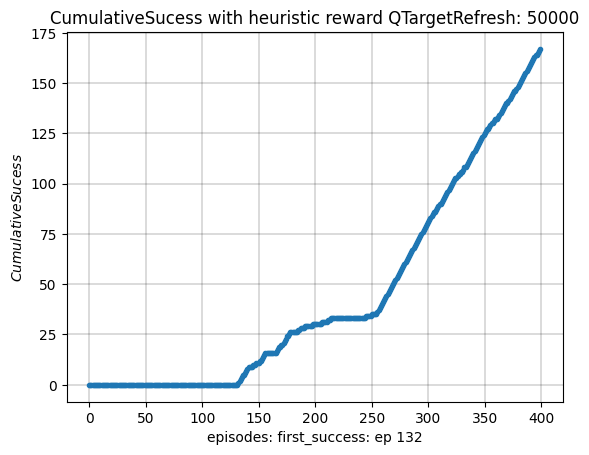

In [48]:
episodes = 400
batch_size = 64
refreshQTarget = 50000
reset_init = 1
replay_buffer_SIZE = 10000
epsilonDecreasing = 100
reward_factor = 0
predList_batch_size = 0
firstUpdate = 0
u=0.05
NewPosReward = np.array([(-1.1,u*7),(-1,u*6),(-0.9,u*5),(-0.8,u*4),(-0.7,u*3),(-0.6,u*2),(-0.4,u*2),(-0.3,u*3),(-0.2,u*4),(-0.1,u*5),(0,u*6),(0.1,u*7),(0.2,u*8),(0.3,u*9),(0.4,u*10),(0.5,20*u)])

DQN = DQNAgent("id0",epsilonMax = 1, predList_batch_size = predList_batch_size, reward_factor = reward_factor, batch_size = batch_size, arrayNewPosReward = NewPosReward, replay_buffer_SIZE = replay_buffer_SIZE)
episodesHistory, _, lossHistory, _,cumulativeHistory,_,_ = DQN.train(episodes, refreshQTarget = refreshQTarget, firstUpdate = firstUpdate, recap_mode = False, debug_mode = False, reset_init = reset_init, epsilonDecreasing =epsilonDecreasing)

fig1,ax1 = plt.subplots(1,1)
ax1.plot(range(episodesHistory.shape[0]), episodesHistory, marker='.')
ax1.set_title(f'Cumulative reward DQN heuristic reward')
ax1.set_xlabel(r'Episode $t$')
ax1.set_ylabel('Cumulative reward')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardDQNheurR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

fig3,ax3 = plt.subplots(1,1)
ax3.plot(range(lossHistory.shape[0]), lossHistory, marker='.')
ax3.set_title(f'Loss DQN heuristic reward')
ax3.set_xlabel(r'Step $t$')
ax3.set_ylabel(r'$Loss$')
ax3.set_xscale('linear')
ax3.set_yscale('log')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/LossDQNheurR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

s=0
for e in range(cumulativeHistory.shape[0]):
    if cumulativeHistory[e] == 1:
        s = e
        break
fig5,ax5 = plt.subplots(1,1)
ax5.plot(range(cumulativeHistory.shape[0]), cumulativeHistory[:], marker='.')
ax5.set_title(f'Cumulative Sucess DQN heuristic reward')
if u>0: ax5.set_title(f'CumulativeSucess with heuristic reward QTargetRefresh: {refreshQTarget}')
if reward_factor>0:ax5.set_title(f'CumulativeSucess with RND RewardFactor: {reward_factor} QTargetRefresh: {refreshQTarget}')
ax5.set_xlabel(r'episodes: first_success: ep '+str(s))
ax5.set_ylabel(r'$CumulativeSucess$')
ax5.set_xscale('linear')
ax5.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeSucessDQNheurR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')


100%|██████████| 990/990 [17:23<00:00,  1.05s/it]


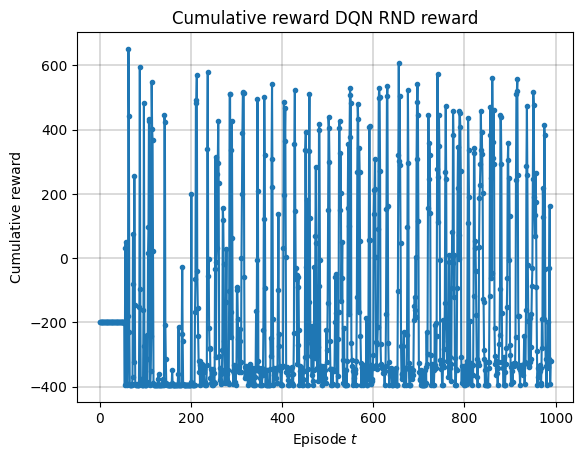

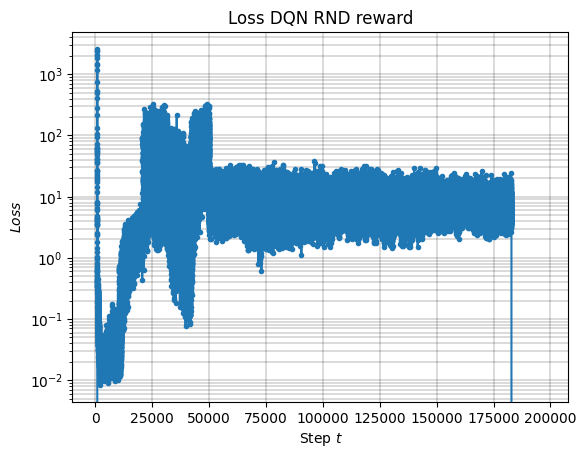

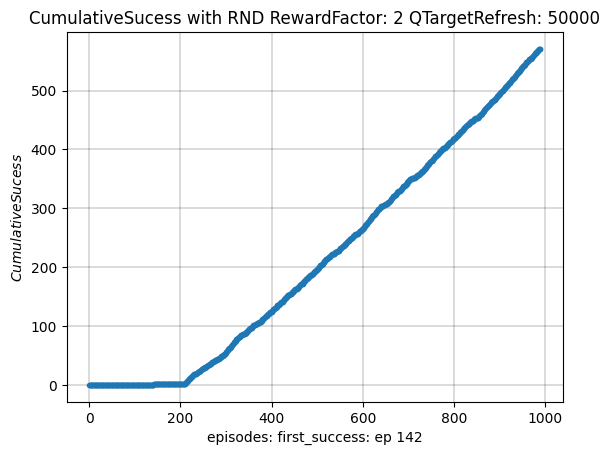

In [49]:
episodes = 990
batch_size = 64
refreshQTarget = 50000
reset_init = 1
replay_buffer_SIZE = 10000
epsilonDecreasing = 100
reward_factor = 2
predList_batch_size = 10000
firstUpdate = 1000
NewPosReward = np.array([None])

DQN = DQNAgent("id0",epsilonMax = 1, predList_batch_size = predList_batch_size, reward_factor = reward_factor, batch_size = batch_size, arrayNewPosReward = NewPosReward, replay_buffer_SIZE = replay_buffer_SIZE)
episodesHistory, _, lossHistory, _,cumulativeHistory,_,_ = DQN.train(episodes, refreshQTarget = refreshQTarget, firstUpdate = firstUpdate, recap_mode=False, reset_init = reset_init, epsilonDecreasing =epsilonDecreasing)

fig1,ax1 = plt.subplots(1,1)
ax1.plot(range(episodesHistory.shape[0]), episodesHistory, marker='.')
ax1.set_title(f'Cumulative reward DQN RND reward')
ax1.set_xlabel(r'Episode $t$')
ax1.set_ylabel('Cumulative reward')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeRewardDQNrndR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

fig3,ax3 = plt.subplots(1,1)
ax3.plot(range(lossHistory.shape[0]), lossHistory, marker='.')
ax3.set_title(f'Loss DQN RND reward')
ax3.set_xlabel(r'Step $t$')
ax3.set_ylabel(r'$Loss$')
ax3.set_xscale('linear')
ax3.set_yscale('log')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/LossDQNrndR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')

s=0
for e in range(cumulativeHistory.shape[0]):
    if cumulativeHistory[e] == 1:
        s = e
        break
fig5,ax5 = plt.subplots(1,1)
ax5.plot(range(cumulativeHistory.shape[0]), cumulativeHistory[:], marker='.')
ax5.set_title(f'Cumulative Sucess DQN RND reward')
if u>0: ax5.set_title(f'CumulativeSucess with heuristic reward QTargetRefresh: {refreshQTarget}')
if reward_factor>0:ax5.set_title(f'CumulativeSucess with RND RewardFactor: {reward_factor} QTargetRefresh: {refreshQTarget}')
ax5.set_xlabel(r'episodes: first_success: ep '+str(s))
ax5.set_ylabel(r'$CumulativeSucess$')
ax5.set_xscale('linear')
ax5.set_yscale('linear')
plt.grid(color='black', which="both", linestyle='-', linewidth=0.2)
plt.savefig(f'figures/CumulativeSucessDQNrndR_ep{episodes}_u{u}_bS{batch_size}_rT{refreshQTarget}_iN{reset_init}_rB{replay_buffer_SIZE}_eD{epsilonDecreasing}.png', format='png')
